In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from time import time
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy import spatial
from scipy import stats
import pandas as pd
import acopy
from simanneal import Annealer
import networkx as nx

In [ ]:
def generate_clustered_points(
    K=5,
    points_per_cluster=20,
    center_box=(0, 100),
    sigma=3.0,
    seed=None
):
    rng = np.random.default_rng(seed)

    centers = rng.uniform(
        center_box[0],
        center_box[1],
        size=(K, 2)
    )

    points = []

    for c in centers:
        Sigma = sigma * np.eye(2)

        cluster_points = rng.multivariate_normal(
            mean=c,
            cov=Sigma,
            size=points_per_cluster
        )

        points.append(cluster_points)

    return np.vstack(points) 

In [45]:
def nearest_neighbour(dist, start=0, end=None):
    dist = np.array(dist)
    n = dist.shape[0]

    visited = np.zeros(n, dtype=bool)
    visited[start] = True
    visited[end] = True if end is not None else visited

    path = [start]
    current = start

    for _ in range(n - 1):
        d = dist[current]
        d[visited] = np.inf
        next_city = np.argmin(d)

        visited[next_city] = True
        path.append(next_city)
        current = next_city

    path.append(end) if end != start else None
    return np.asarray(path)

In [ ]:
def boundary_points(cluster): 
    if len(cluster) <= 3:
        return cluster
    return cluster[spatial.ConvexHull(cluster).vertices]

In [47]:
def greedy_cluster_tour(dist):
    visited = [0]
    while len(visited) < len(dist):
        last = visited[-1]
        next_c = min(
            [i for i in range(len(dist)) if i not in visited],
            key=lambda i: dist[last, i]
        )
        visited.append(next_c)
    return visited

In [48]:
def solve_cluster(cluster, entry, exit, method='ACA', Tmax=50000, Tmin=0.1, max_iter_ACA=2500, max_iter_SA=100000):
    n = len(cluster)
    if n <= 2:
        return [0, 1] if n == 2 else [0]

    entry_idx = np.argmin(np.linalg.norm(cluster - entry, axis=1))
    exit_idx = np.argmin(np.linalg.norm(cluster - exit, axis=1))
    D = spatial.distance_matrix(cluster, cluster)

    def fitness_func(permutation):
        perm = permutation.astype(int)
        total_dist = 0.0

        total_dist += np.linalg.norm(cluster[entry_idx] - cluster[perm[0]])

        for i in range(n - 1):
            total_dist += np.linalg.norm(cluster[perm[i]] - cluster[perm[i + 1]])

        total_dist += np.linalg.norm(cluster[perm[-1]] - cluster[exit_idx])

        return total_dist
    if method == 'SA':
        print("Solving cluster with", n, "points...")
        class TravelingSalesmanProblem(Annealer):
            def __init__(self, state, distance_matrix, entry_idx=entry_idx, exit_idx=exit_idx):
                self.distance_matrix = distance_matrix
                self.entry_idx = entry_idx
                self.exit_idx = exit_idx
                self.Tmax = Tmax
                self.Tmin = Tmin
                self.steps = max_iter_SA
                super().__init__(state)

            def move(self):
                a, b = sorted(np.random.choice(len(self.state), 2, replace=False))
                self.state[a], self.state[b] = self.state[b], self.state[a]

            def energy(self):
                total_dist = 0.0
                total_dist += self.distance_matrix[self.entry_idx, self.state[0]]
                for i in range(len(self.state) - 1):
                    total_dist += self.distance_matrix[self.state[i], self.state[i + 1]]
                total_dist += self.distance_matrix[self.state[-1], self.exit_idx]
                return total_dist
            
        initial_state = np.random.permutation(n).tolist()
        tsp = TravelingSalesmanProblem(initial_state, D, entry_idx, exit_idx)
        best_permutation, best_distance = tsp.anneal()
        print("Best distance:", best_distance)
        
    elif method == 'ACA':
        print("Solving cluster with", n, "points...")
        solver = acopy.Solver(rho=.03, q=1.0)
        colony = acopy.Colony(alpha=1.0, beta=2.0)

        G = nx.Graph()
        for i in range(n):
            for j in range(i+1, n):
                G.add_edge(i, j, weight=D[i, j])

        tour = solver.solve(graph=G, colony=colony, limit=max_iter_ACA)
        best_permutation = tour.nodes

    elif method == 'NN':
        best_permutation = nearest_neighbour(D, start=entry_idx, end=exit_idx)
        best_distance = fitness_func(np.array(best_permutation))
        print("Best distance:", best_distance)
    else:
        raise ValueError("Unknown method: {}".format(method))
        
    best_permutation = np.asarray(best_permutation)
    return best_permutation.astype(int)

In [ ]:
"""routing_methods = ['NN', 'SA', 'ACA']
clustering_methods = ['None', 'kmeans', 'agglomerative']"""
combinations = {'None': ['NN', 'SA', 'ACA'], 'kmeans': ['NN', 'SA'], 'agglomerative': ['NN', 'SA']}
solution_times = {'None': {'NN': [], 'SA': [], 'ACA': []}, 'kmeans': {'NN': [], 'SA': []}, 'agglomerative': {'NN': [], 'SA': []}}
final_tour_distances = {'None': {'NN': [], 'SA': [], 'ACA': []}, 'kmeans': {'NN': [], 'SA': []}, 'agglomerative': {'NN': [], 'SA': []}}
fit_times = {'None': [], 'kmeans': [], 'agglomerative': []}
running = True
iteration = 0
num_clients = int(input("Number of clients: "))
num_clusters = int(input("Number of clusters: "))
num_iter = int(input("Number of iterations: "))

In [ ]:
# Main loop

while running:

    data = generate_clustered_points(K=num_clusters, points_per_cluster=num_clients // num_clusters, sigma=5.0)
    iteration += 1
    print(f"\n=== Iteration {iteration} ===")

    for clustering_method, routing_methods in combinations.items():

        print(f"\n=== Clustering method: {clustering_method} ===")

        for routing_method in routing_methods:

            print(f"\n=== Solving with routing method: {routing_method} ===")

            if clustering_method == 'kmeans':

                t0 = time()
                kmeans = KMeans(init="k-means++", n_clusters=num_clusters, n_init="auto").fit(data)
                fit_time = time() - t0
                print(f"KMeans fitting time: {fit_time:.2f} seconds.")
                labels = kmeans.labels_
                clusters = [data[labels == k] for k in range(num_clusters)]
                fit_times[clustering_method].append(fit_time)

            elif clustering_method == 'agglomerative':

                t0 = time()
                agglomerative = AgglomerativeClustering(n_clusters=num_clusters, metric='euclidean', linkage='ward')
                labels = agglomerative.fit_predict(data)
                fit_time = time() - t0
                print(f"Agglomerative fitting time: {fit_time:.2f} seconds.")
                clusters = [data[labels == k] for k in range(num_clusters)]
                fit_times[clustering_method].append(fit_time)

            elif clustering_method == 'None':

                print("No clustering applied.")

            else:

                raise ValueError(f"Unknown clustering method: {clustering_method}")
            
            final_tour = []

            if clustering_method != 'None':

                boundaries = [
                    boundary_points(clusters[i])
                    for i in range(len(clusters))
                ]

                cluster_dist = np.full((len(clusters), len(clusters)), np.inf)
                bridge_points = {}

                for i in range(len(clusters)):
                    for j in range(len(clusters)):
                        if i == j:
                            continue

                        D = spatial.distance_matrix(boundaries[i], boundaries[j])
                        idx = np.unravel_index(np.argmin(D), D.shape)

                        cluster_dist[i, j] = D[idx]
                        bridge_points[(i, j)] = (boundaries[i][idx[0]],
                                                 boundaries[j][idx[1]])

                cluster_tour = greedy_cluster_tour(cluster_dist)
                print(f"Cluster tour: {cluster_tour}")

                if len(cluster_tour) > 1:

                    entries = {}
                    exits = {}

                    for idx, c in enumerate(cluster_tour):
                        prev_c = cluster_tour[idx - 1]
                        next_c = cluster_tour[(idx + 1) % len(cluster_tour)]

                        entry = bridge_points[(prev_c, c)][1]
                        exit = bridge_points[(c, next_c)][0]

                        entries[c] = entry
                        exits[c] = exit

                    t0 = time()
                    for c in cluster_tour:
                        path = solve_cluster(clusters[c], entries[c], exits[c], method=routing_method)
                        print(f"Cluster {c} path: {path}")
                        final_tour = np.append(final_tour, np.where(labels == c)[0][path])
                    solution_time = time() - t0

                else:
                    t0 = time()
                    final_tour = solve_cluster(data, data[0], data[0], method=routing_method)
                    solution_time = time() - t0

            else:
                t0 = time()
                final_tour = solve_cluster(data, data[0], data[0], method=routing_method)
                solution_time = time() - t0

            solution_times[clustering_method][routing_method].append(solution_time)
            print(f"Solved in {solution_time:.2f} seconds.")

            final_tour = np.concatenate([final_tour, [final_tour[0]]]).astype(int)
            print("Final tour:", final_tour)

            best_points_coordinate = data[final_tour, :]
            final_tour_distance = np.sum(np.linalg.norm(best_points_coordinate[1:] - best_points_coordinate[:-1], axis=1))
            final_tour_distances[clustering_method][routing_method].append(final_tour_distance)
            print("Final tour distance:", final_tour_distance)

    if iteration >= 20:

        stop = True

        for clustering_method, routing_methods in combinations.items():
            for routing_method in routing_methods:
                n = len(final_tour_distances[clustering_method][routing_method])
                t = stats.t.ppf(q=0.975, df=n - 1)
                final_tour_distance_average = np.mean(final_tour_distances[clustering_method][routing_method])
                final_tour_distance_std = np.std(final_tour_distances[clustering_method][routing_method], ddof=1)
                half_width_distance = t * final_tour_distance_std / np.sqrt(n)
                print("Gamma:", half_width_distance / final_tour_distance_average)

                if half_width_distance / final_tour_distance_average >= 0.02:
                    stop = False
                    break

            if not stop:
                break

        if stop:
            print("\nStopping early due to convergence")
            running = False

    if iteration >= num_iter:
        print("\nReached maximum number of iterations.")
        running = False

print(final_tour_distances)
print(solution_times)
print(fit_times)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 22752.64046       2538.11    99.90%    49.70%     0:00:00     0:00:03


=== Iteration 401 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 358.21866020209933
Solved in 0.00 seconds.
Final tour: [ 0  4  5  6  2  9  7  8  1  3 33 37 39 36 31 32 30 38 34 35 24 22 29 27
 28 23 26 25 20 21 15 10 12 19 16 11 14 13 18 17  0]
Final tour distance: 358.2186602020993

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        346.21     0.40%     0.20%     0:00:03     0:00:00

Best distance: 345.80195714234867
Solved in 2.79 seconds.
Final tour: [ 5  6  9  2  7  8 15 10 12 19 16 11 14 13 18 17 21 20 23 26 25 28 29 27
 22 24 33 39 37 36 31 32 30 38 34 35  3  1  4  0  5]
Final tour distance: 345.8019571423486

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         39.65   100.00%    48.40%     0:00:00     0:00:02

Solved in 84.78 seconds.
Final tour: [13 18 14 11 16 12 10 15 19 17 21 20 23 26 25 29 27 28 22 24 33 39 37 36
 31 32 30 38 34 35  3  0  4  5  1  6  9  2  7  8 13]
Final tour distance: 345.3830037561195

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 24.731807394407234
Cluster 0 path: [3 7 9 6 1 2 0 8 4 5]
Best distance: 15.710325211895107
Cluster 3 path: [4 2 9 7 8 3 6 5 0 0 1]
Best distance: 24.605830092076186
Cluster 1 path: [5 0 2 9 6 1 4 8 7 0 3]
Best distance: 18.15638966193795
Cluster 2 path: [8 9 2 6 5 4 0 1 7 0 3]
Solved in 0.00 seconds.
Final tour: [33 37 39 36 31 32 30 38 34 35 24 22 29 27 28 23 26 25 20 20 21 15 10 12
 19 16 11 14 18 17 10 13  8  9  2  6  5  4  0  1  7  0  3 33]
Final tour distance: 364.55290313787305

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Solving cluster with 10 points...


     0.10000         20.14     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         50.31   100.00%    50.90%     0:00:00     0:00:02

Best distance: 20.144392365516765
Cluster 0 path: [3 8 4 1 6 7 9 2 0 5]
Solving cluster with 10 points...


     0.10000         18.30     2.10%     1.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 18.302106846995333
Cluster 3 path: [1 0 3 6 5 8 9 7 2 4]
Solving cluster with 10 points...


     0.10000         21.72     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         41.12   100.00%    50.50%     0:00:00     0:00:02

Best distance: 21.715400911524004
Cluster 1 path: [3 9 4 5 8 0 2 1 6 7]
Solving cluster with 10 points...


     0.10000         13.58     2.60%     1.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         55.37   100.00%    50.20%     0:00:00     0:00:02

Best distance: 13.57603022134466
Cluster 2 path: [3 0 4 1 5 6 9 2 7 8]
Solved in 7.07 seconds.
Final tour: [13 18 14 11 16 17 19 12 10 15 21 20 23 26 25 28 29 27 22 24 33 39 34 35
 38 30 32 31 36 37  3  0  4  1  5  6  9  2  7  8 13]
Final tour distance: 344.691490808469

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 1, 2, 3]
Best distance: 15.710325211895107
Cluster 0 path: [4 2 9 7 8 3 6 5 0 0 1]
Best distance: 24.605830092076186
Cluster 1 path: [5 0 2 9 6 1 4 8 7 0 3]
Best distance: 18.15638966193795
Cluster 2 path: [8 9 2 6 5 4 0 1 7 0 3]
Best distance: 24.731807394407234
Cluster 3 path: [3 7 9 6 1 2 0 8 4 5]
Solved in 0.00 seconds.
Final tour: [24 22 29 27 28 23 26 25 20 20 21 15 10 12 19 16 11 14 18 17 10 13  8  9
  2  6  5  4  0  1  7  0  3 33 37 39 36 31 32 30 38 34 35 24]
Final tour distance: 364.55290313787305

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00

     0.10000         18.30     2.50%     1.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         46.47   100.00%    49.10%     0:00:00     0:00:02

Best distance: 18.302106846995336
Cluster 0 path: [4 2 7 9 8 5 6 3 0 1]
Solving cluster with 10 points...


     0.10000         20.14     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         40.31   100.00%    50.10%     0:00:00     0:00:02

Best distance: 20.14439236551676
Cluster 1 path: [5 0 2 9 7 6 1 4 8 3]
Solving cluster with 10 points...


     0.10000         13.58     2.90%     1.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         40.19   100.00%    49.70%     0:00:00     0:00:02

Best distance: 13.57603022134466
Cluster 2 path: [8 7 2 9 6 5 1 4 0 3]
Solving cluster with 10 points...


     0.10000         21.72     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 22752.64046       2038.38   100.00%    47.40%     0:00:00     0:00:03

Best distance: 21.715400911524004
Cluster 3 path: [9 4 5 8 0 2 1 6 7 3]
Solved in 7.19 seconds.
Final tour: [24 22 27 29 28 25 26 23 20 21 15 10 12 19 17 16 11 14 18 13  8  7  2  9
  6  5  1  4  0  3 39 34 35 38 30 32 31 36 37 33 24]
Final tour distance: 344.1290134532155
Gamma: 0.01636516941587673
Gamma: 0.021741762619948694

=== Iteration 402 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 284.00285746593073
Solved in 0.00 seconds.
Final tour: [ 0  7  6  3  1  9  2  4  8  5 37 31 35 39 38 30 33 32 36 34 21 22 25 26
 29 20 23 27 24 28 14 19 18 13 15 12 10 17 11 16  0]
Final tour distance: 284.00285746593073

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        258.07     0.50%     0.30%     0:00:03     0:00:00

Best distance: 257.649910099991
Solved in 2.78 seconds.
Final tour: [ 0  6  1  3  7  5  8  9  2  4 37 33 30 38 39 31 35 25 26 29 28 20 23 27
 24 22 21 36 32 34 14 19 18 13 15 12 16 10 17 11  0]
Final tour distance: 257.649910099991

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         44.80   100.00%    50.60%     0:00:00     0:00:02

Solved in 84.83 seconds.
Final tour: [27 23 20 26 25 24 22 21 35 31 37 33 30 38 39 36 32 34 14 19 18 13 15 12
 16 10 17 11  1  3  6  0  7  5  8  9  2  4 29 28 27]
Final tour distance: 243.69977479515933

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 25.31884125215246
Cluster 0 path: [4 9 8 3 5 2 0 7 1 6]
Best distance: 27.517159156708452
Cluster 2 path: [1 3 6 7 0 5 8 9 2 0 4]
Best distance: 15.45906122879572
Cluster 3 path: [7 1 3 0 8 9 2 6 4 0 5]
Best distance: 30.128187206839243
Cluster 1 path: [1 2 5 6 9 0 3 7 4 8]
Solved in 0.00 seconds.
Final tour: [14 19 18 13 15 12 10 17 11 16  1  3  6  7  0  5  8  9  2  0  4 37 31 33
 30 38 39 32 36 34 30 35 21 22 25 26 29 20 23 27 24 28 14]
Final tour distance: 283.57733002648547

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Solving cluster with 10 points...


     0.10000         23.72     0.90%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         57.12   100.00%    50.00%     0:00:00     0:00:02

Best distance: 23.555605593729215
Cluster 0 path: [4 1 7 0 6 2 5 3 8 9]
Solving cluster with 10 points...


     0.10000         20.36     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 20.361129045859787
Cluster 2 path: [1 3 6 0 7 5 8 9 2 4]
Solving cluster with 10 points...


     0.10000         17.08     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         46.64    99.90%    49.80%     0:00:00     0:00:02

Best distance: 17.07973805770251
Cluster 3 path: [7 3 0 8 4 6 2 9 1 5]
Solving cluster with 10 points...


     0.10000         23.00     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 22.99837900641868
Cluster 1 path: [2 4 7 3 0 8 9 6 5 1]
Solved in 7.07 seconds.
Final tour: [14 11 17 10 16 12 15 13 18 19  1  3  6  0  7  5  8  9  2  4 37 33 30 38
 34 36 32 39 31 35 22 24 27 23 20 28 29 26 25 21 14]
Final tour distance: 262.06580670025534

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 27.517159156708452
Cluster 0 path: [1 3 6 7 0 5 8 9 2 0 4]
Best distance: 15.45906122879572
Cluster 3 path: [7 1 3 0 8 9 2 6 4 0 5]
Best distance: 30.128187206839243
Cluster 2 path: [1 2 5 6 9 0 3 7 4 8]
Best distance: 25.31884125215246
Cluster 1 path: [4 9 8 3 5 2 0 7 1 6]
Solved in 0.00 seconds.
Final tour: [ 1  3  6  7  0  5  8  9  2  0  4 37 31 33 30 38 39 32 36 34 30 35 21 22
 25 26 29 20 23 27 24 28 14 19 18 13 15 12 10 17 11 16  1]
Final tour distance: 283.5773300264854

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00 seco

     0.10000         20.36     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 20.361129045859787
Cluster 0 path: [1 3 6 0 7 5 8 9 2 4]
Solving cluster with 10 points...


     0.10000         17.08     2.10%     1.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         47.32   100.00%    49.80%     0:00:00     0:00:02

Best distance: 17.07973805770251
Cluster 3 path: [7 3 0 8 4 6 2 9 1 5]
Solving cluster with 10 points...


     0.10000         23.69     1.20%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         37.44   100.00%    49.50%     0:00:00     0:00:02

Best distance: 22.99837900641868
Cluster 2 path: [5 6 9 8 0 3 7 4 2 1]
Solving cluster with 10 points...


     0.10000         23.56     1.80%     0.90%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1494.85    99.90%    49.20%     0:00:00     0:00:03

Best distance: 23.555605593729215
Cluster 1 path: [4 1 7 0 6 2 5 3 8 9]
Solved in 7.23 seconds.
Final tour: [ 1  3  6  0  7  5  8  9  2  4 37 33 30 38 34 36 32 39 31 35 25 26 29 28
 20 23 27 24 22 21 14 11 17 10 16 12 15 13 18 19  1]
Final tour distance: 261.16519561849645
Gamma: 0.016324403149270417
Gamma: 0.021692332198897296

=== Iteration 403 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 237.9807010450205
Solved in 0.00 seconds.
Final tour: [ 0  2  1  7  5  4  8  9  3  6 15 19 14 12 16 11 18 17 13 10 29 25 28 27
 26 22 21 23 24 20 30 39 35 33 38 32 36 37 34 31  0]
Final tour distance: 237.98070104502045

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        243.02     0.20%     0.20%     0:00:03     0:00:00

Best distance: 243.01603856646227
Solved in 2.76 seconds.
Final tour: [ 0 12 14 19 16 11 18 15 13 17 10 29 25 28 27 26 22 35 33 38 32 36 31 34
 37 39 30 20 21 23 24  6  7  5  3  9  8  4  1  2  0]
Final tour distance: 243.0160385664622

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         40.17   100.00%    49.50%     0:00:00     0:00:02

Solved in 84.19 seconds.
Final tour: [20 21 23 24 22 27 26 28 29 25 10 13 17 18 11 16 19 14 12 15  0  2  1  5
  7  6  3  4  8  9 33 38 32 36 37 31 34 30 39 35 20]
Final tour distance: 231.383042658687

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.01 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 17.7166691806328
Cluster 0 path: [0 1 3 4 2 7 6 5 8 0 9]
Best distance: 26.582823818989326
Cluster 2 path: [0 7 3 8 1 6 9 4 5 0 2]
Best distance: 22.086763094548214
Cluster 3 path: [0 2 1 7 5 4 8 9 6 0 3]
Best distance: 26.730736014966233
Cluster 1 path: [0 9 5 3 8 2 6 7 4 1]
Solved in 0.00 seconds.
Final tour: [20 21 23 24 22 27 26 25 28 20 29 10 17 13 18 11 16 19 14 15 10 12  0  2
  1  7  5  4  8  9  6  0  3 30 39 35 33 38 32 36 37 34 31 20]
Final tour distance: 267.37967588492535

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Solving cluster with 10 points...


     0.10000         24.52     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         38.92    99.80%    49.70%     0:00:00     0:00:02

Best distance: 24.515182573640434
Cluster 0 path: [9 7 4 1 6 2 8 3 5 0]
Solving cluster with 10 points...


     0.10000         12.49     4.10%     2.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         41.00   100.00%    50.30%     0:00:00     0:00:02

Best distance: 12.494500350279878
Cluster 2 path: [0 4 3 1 2 6 7 8 5 9]
Solving cluster with 10 points...


     0.10000         23.01     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         43.42   100.00%    48.70%     0:00:00     0:00:02

Best distance: 22.611767854362117
Cluster 3 path: [0 3 7 8 1 6 9 5 4 2]
Solving cluster with 10 points...


     0.10000         19.10     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         37.87   100.00%    50.30%     0:00:00     0:00:02

Best distance: 19.098373405188468
Cluster 1 path: [0 2 1 6 7 5 4 8 9 3]
Solved in 7.13 seconds.
Final tour: [39 37 34 31 36 32 38 33 35 30 20 24 23 21 22 26 27 28 25 29 10 13 17 18
 11 16 19 15 14 12  0  2  1  6  7  5  4  8  9  3 39]
Final tour distance: 232.7277872095738

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 17.7166691806328
Cluster 0 path: [0 1 3 4 2 7 6 5 8 0 9]
Best distance: 26.582823818989326
Cluster 2 path: [0 7 3 8 1 6 9 4 5 0 2]
Best distance: 22.086763094548214
Cluster 3 path: [0 2 1 7 5 4 8 9 6 0 3]
Best distance: 26.730736014966233
Cluster 1 path: [0 9 5 3 8 2 6 7 4 1]
Solved in 0.00 seconds.
Final tour: [20 21 23 24 22 27 26 25 28 20 29 10 17 13 18 11 16 19 14 15 10 12  0  2
  1  7  5  4  8  9  6  0  3 30 39 35 33 38 32 36 37 34 31 20]
Final tour distance: 267.37967588492535

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.0

     0.10000         12.57     4.70%     2.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         57.14   100.00%    47.90%     0:00:00     0:00:02

Best distance: 12.494500350279878
Cluster 0 path: [0 4 3 1 2 6 7 8 5 9]
Solving cluster with 10 points...


     0.10000         22.73     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         37.17   100.00%    48.60%     0:00:00     0:00:02

Best distance: 22.611767854362117
Cluster 2 path: [0 3 7 8 1 6 9 5 4 2]
Solving cluster with 10 points...


     0.10000         20.18     1.90%     0.90%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         54.75   100.00%    49.90%     0:00:00     0:00:02

Best distance: 19.098373405188468
Cluster 3 path: [0 2 1 6 7 5 4 8 9 3]
Solving cluster with 10 points...


     0.10000         24.52     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1938.02    99.90%    47.70%     0:00:00     0:00:03

Best distance: 24.515182573640434
Cluster 1 path: [9 7 4 1 6 2 8 3 5 0]
Solved in 7.14 seconds.
Final tour: [20 24 23 21 22 26 27 28 25 29 10 13 17 18 11 16 19 15 14 12  0  2  1  6
  7  5  4  8  9  3 39 37 34 31 36 32 38 33 35 30 20]
Final tour distance: 232.72778720957376
Gamma: 0.016297704541212845
Gamma: 0.021650938542152637

=== Iteration 404 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 292.770373786789
Solved in 0.00 seconds.
Final tour: [ 0  8  3  1  7  4  2  5  9  6 27 28 20 23 25 29 21 24 26 22 11 17 16 12
 15 19 18 10 13 14 35 34 32 37 33 30 39 31 36 38  0]
Final tour distance: 292.770373786789

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        324.12     0.40%     0.30%     0:00:03     0:00:00

Best distance: 324.1239867349769
Solved in 2.73 seconds.
Final tour: [20 23 22 26 24 25 29 21 11 17 10 14 13 12 16 18 15 19 38 36 31 39 30 33
 37 32 34 35 28 27  5  2  1  7  4  3  9  6  8  0 20]
Final tour distance: 324.1239867349768

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         46.24   100.00%    51.30%     0:00:00     0:00:02

Solved in 84.67 seconds.
Final tour: [ 1  7  4  3  0  8  6  9  5  2 27 20 23 25 29 21 24 26 22 28 18 11 17 12
 16 10 14 13 15 19 35 34 36 38 31 39 30 32 37 33  1]
Final tour distance: 270.0868827493385

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 1, 3, 2]
Best distance: 13.196690585425383
Cluster 0 path: [3 7 2 4 6 8 1 9 0 0 5]
Best distance: 19.38815345869607
Cluster 1 path: [9 5 2 6 7 1 0 3 4 0 8]
Best distance: 16.630074708939436
Cluster 3 path: [8 0 3 5 9 1 4 6 2 0 7]
Best distance: 20.24999401287506
Cluster 2 path: [4 7 1 2 5 9 8 0 3 6]
Solved in 0.00 seconds.
Final tour: [33 37 32 34 36 38 31 39 30 30 35 19 15 12 16 17 11 10 13 14 10 18 28 20
 23 25 29 21 24 26 22 20 27  4  7  1  2  5  9  8  0  3  6 33]
Final tour distance: 282.7747462447137

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 10 points...


     0.10000         17.48     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         41.77   100.00%    48.90%     0:00:00     0:00:02

Best distance: 17.476772629429252
Cluster 0 path: [3 7 2 0 9 1 8 6 4 5]
Solving cluster with 10 points...


     0.10000         20.41     1.20%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         33.56   100.00%    49.40%     0:00:00     0:00:02

Best distance: 20.405207084751652
Cluster 3 path: [9 5 3 4 0 6 2 7 1 8]
Solving cluster with 10 points...


     0.10000         18.03     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         31.77   100.00%    49.80%     0:00:00     0:00:02

Best distance: 18.032825907492626
Cluster 2 path: [8 1 9 5 4 6 2 3 0 7]
Solving cluster with 10 points...


     0.10000         16.00     1.40%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         42.44   100.00%    49.40%     0:00:00     0:00:02

Best distance: 16.00469809288488
Cluster 1 path: [4 3 0 8 6 9 5 2 1 7]
Solved in 7.15 seconds.
Final tour: [33 37 32 30 39 31 38 36 34 35 19 15 13 14 10 16 12 17 11 18 28 21 29 25
 24 26 22 23 20 27  4  3  0  8  6  9  5  2  1  7 33]
Final tour distance: 268.27093990702076

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 1, 3, 2]
Best distance: 19.38815345869607
Cluster 0 path: [9 5 2 6 7 1 0 3 4 0 8]
Best distance: 16.630074708939436
Cluster 1 path: [8 0 3 5 9 1 4 6 2 0 7]
Best distance: 20.24999401287506
Cluster 3 path: [4 7 1 2 5 9 8 0 3 6]
Best distance: 13.196690585425383
Cluster 2 path: [3 7 2 4 6 8 1 9 0 0 5]
Solved in 0.00 seconds.
Final tour: [19 15 12 16 17 11 10 13 14 10 18 28 20 23 25 29 21 24 26 22 20 27  4  7
  1  2  5  9  8  0  3  6 33 37 32 34 36 38 31 39 30 30 35 19]
Final tour distance: 282.7747462447137

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00

     0.10000         20.41     1.60%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         48.65   100.00%    47.80%     0:00:00     0:00:02

Best distance: 20.405207084751652
Cluster 0 path: [9 5 3 4 0 6 2 7 1 8]
Solving cluster with 10 points...


     0.10000         18.03     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         32.80   100.00%    48.20%     0:00:00     0:00:02

Best distance: 18.032825907492626
Cluster 1 path: [8 1 9 5 4 6 2 3 0 7]
Solving cluster with 10 points...


     0.10000         16.14     2.00%     1.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         40.50   100.00%    49.00%     0:00:00     0:00:02

Best distance: 16.00469809288488
Cluster 3 path: [4 3 0 8 6 9 5 2 1 7]
Solving cluster with 10 points...


     0.10000         17.48     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1540.62    99.90%    50.70%     0:00:00     0:00:03

Best distance: 17.476772629429252
Cluster 2 path: [3 7 2 0 9 1 8 6 4 5]
Solved in 7.17 seconds.
Final tour: [19 15 13 14 10 16 12 17 11 18 28 21 29 25 24 26 22 23 20 27  4  3  0  8
  6  9  5  2  1  7 33 37 32 30 39 31 38 36 34 35 19]
Final tour distance: 268.27093990702076
Gamma: 0.01625956001993691
Gamma: 0.0216062173879279

=== Iteration 405 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 232.32862479651953
Solved in 0.00 seconds.
Final tour: [ 0  7  4  6  8  9  2  3  5  1 36 35 39 34 37 33 31 38 30 32 19 12 13 16
 14 18 10 11 15 17 27 26 25 21 24 29 20 22 23 28  0]
Final tour distance: 232.32862479651956

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        204.01     0.10%     0.00%     0:00:03     0:00:00

Best distance: 203.76312934345827
Solved in 2.73 seconds.
Final tour: [ 7  1  6  4  8  3  9  2 36 35 39 34 37 33 31 38 32 30 19 18 10 23 22 20
 29 24 21 28 25 26 27 11 15 17 12 13 14 16  5  0  7]
Final tour distance: 203.76312934345827

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         37.31   100.00%    50.10%     0:00:00     0:00:02

Solved in 84.76 seconds.
Final tour: [12 13 16 14 18 10 23 22 20 29 28 21 24 25 26 27 11 15 17 19 38 31 33 37
 34 39 35 36 32 30  1  7  0  4  6  8  9  2  3  5 12]
Final tour distance: 205.56044922806564

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 21.234749476124954
Cluster 0 path: [5 3 9 8 6 4 0 7 1 2]
Best distance: 15.209738774545624
Cluster 2 path: [6 5 9 4 7 3 1 2 0 0 8]
Best distance: 24.75396594548278
Cluster 3 path: [9 2 3 6 4 8 0 5 7 0 1]
Best distance: 24.096364020201896
Cluster 1 path: [7 6 5 1 4 9 0 2 8 0 3]
Solved in 0.00 seconds.
Final tour: [ 5  3  9  8  6  4  0  7  1  2 36 35 39 34 37 33 31 32 30 30 38 19 12 13
 16 14 18 10 15 17 10 11 27 26 25 21 24 29 20 22 28 20 23  5]
Final tour distance: 222.52963322774775

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Solving cluster with 10 points...


     0.10000         19.35     1.30%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         37.71   100.00%    49.10%     0:00:00     0:00:02

Best distance: 19.155123533432203
Cluster 0 path: [3 9 2 8 6 1 7 0 4 5]
Solving cluster with 10 points...


     0.10000         17.14     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         48.22    99.90%    50.10%     0:00:00     0:00:02

Best distance: 17.139158319021963
Cluster 2 path: [6 5 9 4 7 3 1 2 0 8]
Solving cluster with 10 points...


     0.10000         19.96     0.30%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         50.09   100.00%    50.30%     0:00:00     0:00:02

Best distance: 19.962490793589755
Cluster 1 path: [9 2 3 6 4 0 8 7 5 1]
Solving cluster with 10 points...


     0.10000         18.22     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         51.80    99.90%    48.90%     0:00:00     0:00:02

Best distance: 18.222792814337314
Cluster 3 path: [7 6 5 8 1 4 9 0 2 3]
Solved in 7.10 seconds.
Final tour: [ 3  9  2  8  6  1  7  0  4  5 36 35 39 34 37 33 31 32 30 38 19 12 13 16
 14 10 18 17 15 11 27 26 25 28 21 24 29 20 22 23  3]
Final tour distance: 205.56266303570177

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 1, 3, 2]
Best distance: 25.682915060948947
Cluster 0 path: [6 3 2 8 0 4 9 7 5 0 1]
Best distance: 28.613173478237286
Cluster 1 path: [7 6 5 1 4 9 0 2 3 8]
Best distance: 15.659744524254071
Cluster 3 path: [8 1 3 7 4 9 5 2 0 0 6]
Best distance: 21.234749476124954
Cluster 2 path: [5 3 9 8 6 4 0 7 1 2]
Solved in 0.00 seconds.
Final tour: [16 13 12 18 10 14 19 17 15 10 11 27 26 25 21 24 29 20 22 23 28 38 31 33
 37 34 39 35 32 30 30 36  5  3  9  8  6  4  0  7  1  2 16]
Final tour distance: 234.67622044354488

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00 

     0.10000         19.35     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         43.50   100.00%    47.30%     0:00:00     0:00:02

Best distance: 19.347491333245916
Cluster 0 path: [6 4 0 8 3 2 9 7 5 1]
Solving cluster with 10 points...


     0.10000         24.01     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         46.11   100.00%    49.50%     0:00:00     0:00:02

Best distance: 23.437937024291802
Cluster 1 path: [3 2 0 9 4 1 8 5 6 7]
Solving cluster with 10 points...


     0.10000         17.40     1.10%     0.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         37.38   100.00%    49.60%     0:00:00     0:00:02

Best distance: 17.13915831902196
Cluster 3 path: [8 0 2 1 3 7 4 9 5 6]
Solving cluster with 10 points...


     0.10000         19.16     1.40%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1547.58    99.90%    49.90%     0:00:00     0:00:03

Best distance: 19.155123533432203
Cluster 2 path: [3 9 2 8 6 1 7 0 4 5]
Solved in 7.16 seconds.
Final tour: [16 14 10 18 13 12 19 17 15 11 23 22 20 29 24 21 28 25 26 27 38 30 32 31
 33 37 34 39 35 36  3  9  2  8  6  1  7  0  4  5 16]
Final tour distance: 209.90549105993972
Gamma: 0.01623774985406108
Gamma: 0.021601550923522048

=== Iteration 406 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 262.9352298225624
Solved in 0.00 seconds.
Final tour: [ 0  3  7  1  5  8  4  9  6  2 33 32 31 37 35 39 38 36 30 34 12 14 13 11
 15 18 10 17 16 19 28 21 20 23 22 24 29 26 27 25  0]
Final tour distance: 262.93522982256246

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        246.34     0.30%     0.20%     0:00:03     0:00:00

Best distance: 246.2035719337647
Solved in 2.72 seconds.
Final tour: [ 2 22 24 29 26 27 20 23 28 21 25 16 19 15 18 13 14 11 10 17 12  6  9  0
  3  4  7  1  5  8 33 32 36 37 31 35 39 38 34 30  2]
Final tour distance: 241.15813595584086

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         33.74   100.00%    50.30%     0:00:00     0:00:02

Solved in 85.05 seconds.
Final tour: [10 17 16 19 18 15 11 13 14 12  6  9  4  7  3  0  1  5  8 33 32 35 37 31
 30 34 39 38 36  2 22 24 29 26 27 20 23 28 21 25 10]
Final tour distance: 241.7226323429641

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.01 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 35.267515149845806
Cluster 0 path: [3 2 1 7 5 9 8 6 0 4]
Best distance: 18.85791027197604
Cluster 3 path: [8 5 1 3 0 9 4 7 2 0 6]
Best distance: 23.596210595855915
Cluster 2 path: [2 4 3 1 5 8 0 7 9 0 6]
Best distance: 24.136390072727437
Cluster 1 path: [8 1 0 3 2 9 6 7 5 0 4]
Solved in 0.00 seconds.
Final tour: [33 32 31 37 35 39 38 36 30 34  8  5  1  3  0  9  4  7  2  0  6 12 14 13
 11 15 18 10 17 19 10 16 28 21 20 23 22 29 26 27 25 20 24 33]
Final tour distance: 267.26081905880113

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Solving cluster with 10 points...


     0.10000         20.13     4.10%     2.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         48.84   100.00%    50.80%     0:00:00     0:00:02

Best distance: 20.050561406563016
Cluster 0 path: [4 2 9 6 7 0 3 1 5 8]
Solving cluster with 10 points...


     0.10000         22.20     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         30.45   100.00%    50.40%     0:00:00     0:00:02

Best distance: 22.19742807599329
Cluster 2 path: [6 9 0 7 1 5 8 3 4 2]
Solving cluster with 10 points...


     0.10000         17.91     1.60%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         43.87   100.00%    49.30%     0:00:00     0:00:02

Best distance: 17.914521569178635
Cluster 3 path: [6 9 4 7 3 0 2 1 5 8]
Solving cluster with 10 points...


     0.10000         30.59     1.90%     1.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         56.03   100.00%    50.50%     0:00:00     0:00:02

Best distance: 30.03629392324898
Cluster 1 path: [6 2 1 7 5 9 8 4 0 3]
Solved in 7.16 seconds.
Final tour: [24 22 29 26 27 20 23 21 25 28 16 19 10 17 11 15 18 13 14 12  6  9  4  7
  3  0  2  1  5  8 36 32 31 37 35 39 38 34 30 33 24]
Final tour distance: 246.3251530722648

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 25.671241834190177
Cluster 0 path: [6 0 7 1 5 3 4 8 9 0 2]
Best distance: 19.74249083224848
Cluster 3 path: [6 9 0 3 7 1 5 4 2 0 8]
Best distance: 35.267515149845806
Cluster 2 path: [3 2 1 7 5 9 8 6 0 4]
Best distance: 21.033108541357443
Cluster 1 path: [4 2 9 6 7 0 3 1 5 0 8]
Solved in 0.00 seconds.
Final tour: [16 10 17 11 15 13 14 18 19 10 12  6  9  0  3  7  1  5  4  2  0  8 33 32
 31 37 35 39 38 36 30 34 24 22 29 26 27 20 23 21 25 20 28 16]
Final tour distance: 268.10159800358934

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.0

     0.10000         22.20     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         30.16   100.00%    49.10%     0:00:00     0:00:02

Best distance: 22.19742807599329
Cluster 0 path: [6 9 0 7 1 5 8 3 4 2]
Solving cluster with 10 points...


     0.10000         18.00     1.20%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         49.69   100.00%    47.90%     0:00:00     0:00:02

Best distance: 17.914521569178635
Cluster 3 path: [6 9 4 7 3 0 2 1 5 8]
Solving cluster with 10 points...


     0.10000         30.63     1.50%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         46.92   100.00%    47.90%     0:00:00     0:00:02

Best distance: 30.03629392324898
Cluster 2 path: [3 6 2 1 7 5 9 8 4 0]
Solving cluster with 10 points...


     0.10000         20.05     2.80%     1.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1842.01   100.00%    51.20%     0:00:00     0:00:02

Best distance: 20.050561406563016
Cluster 1 path: [4 2 9 6 7 0 3 1 5 8]
Solved in 7.10 seconds.
Final tour: [16 19 10 17 11 15 18 13 14 12  6  9  4  7  3  0  2  1  5  8 33 36 32 31
 37 35 39 38 34 30 24 22 29 26 27 20 23 21 25 28 16]
Final tour distance: 247.25045853763336
Gamma: 0.01619867764790174
Gamma: 0.02156177700774328

=== Iteration 407 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 306.4718910164802
Solved in 0.00 seconds.
Final tour: [ 0  7  3  2  5  8  9  1  4  6 39 32 33 34 31 38 35 37 30 36 21 24 28 29
 25 23 20 22 27 26 16 12 17 18 14 10 19 15 11 13  0]
Final tour distance: 306.4718910164802

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        277.57     0.30%     0.20%     0:00:03     0:00:00

Best distance: 277.572996725048
Solved in 2.71 seconds.
Final tour: [ 0  7  9  3  2  5  8 39 32 33 34 36 30 31 38 35 37 24 21 28 29 25 23 20
 22 27 26 18 13 14 19 10 15 11 12 17 16  1  4  6  0]
Final tour distance: 277.5729967250479

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         41.60   100.00%    49.30%     0:00:00     0:00:02

Solved in 84.29 seconds.
Final tour: [16 17 12 11 15 19 10 14 13 18 26 27 22 20 23 29 25 28 21 24 37 35 38 31
 36 30 33 34 39 32  8  5  2  3  7  0  4  6  9  1 16]
Final tour distance: 278.8884022458235

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 28.28006943061036
Cluster 0 path: [6 2 7 8 4 0 9 5 1 3]
Best distance: 28.29823039978632
Cluster 3 path: [6 7 2 0 3 9 5 8 4 0 1]
Best distance: 14.130260161038363
Cluster 2 path: [7 5 8 1 4 3 2 6 0 0 9]
Best distance: 26.385649449143102
Cluster 1 path: [8 5 2 3 7 0 4 6 9 0 1]
Solved in 0.00 seconds.
Final tour: [16 12 17 18 14 10 19 15 11 13 26 27 22 20 23 29 25 28 24 20 21 37 35 38
 31 34 33 32 36 30 30 39  8  5  2  3  7  0  4  6  9  0  1 16]
Final tour distance: 313.54577450200213

=== Solving with routing method: SA ===
KMeans fitting time: 0.01 seconds.
Cluster tour: [0, 3, 1, 2]
Solving cluster with 10 points...


     0.10000         21.99     1.50%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         52.15   100.00%    49.90%     0:00:00     0:00:02

Best distance: 21.991669761286406
Cluster 0 path: [6 1 5 0 9 4 3 8 7 2]
Solving cluster with 10 points...


     0.10000         21.67     3.20%     1.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         39.75   100.00%    49.20%     0:00:00     0:00:01

Best distance: 21.671483430792737
Cluster 3 path: [6 7 2 0 3 5 9 8 4 1]
Solving cluster with 10 points...


     0.10000         14.37     2.00%     1.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         50.21    99.90%    50.60%     0:00:00     0:00:02

Best distance: 14.36711510298366
Cluster 1 path: [7 5 8 1 0 6 4 3 2 9]
Solving cluster with 10 points...


     0.10000         22.36     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         50.67   100.00%    49.40%     0:00:00     0:00:02

Best distance: 22.361187760756145
Cluster 2 path: [8 5 2 3 7 0 6 4 9 1]
Solved in 7.11 seconds.
Final tour: [16 11 15 10 19 14 13 18 17 12 26 27 22 20 23 25 29 28 24 21 37 35 38 31
 30 36 34 33 32 39  8  5  2  3  7  0  6  4  9  1 16]
Final tour distance: 277.4154697152697

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Best distance: 25.23197354581208
Cluster 0 path: [1 9 3 7 2 5 0 4 6 0 8]
Best distance: 16.27701673772107
Cluster 2 path: [9 2 3 4 1 8 5 0 6 0 7]
Best distance: 22.613702722813805
Cluster 1 path: [1 4 8 9 5 3 0 2 7 0 6]
Best distance: 28.28006943061036
Cluster 3 path: [6 2 7 8 4 0 9 5 1 3]
Solved in 0.00 seconds.
Final tour: [ 1  9  3  7  2  5  0  4  6  0  8 39 32 33 34 31 38 35 30 36 30 37 21 24
 28 29 25 23 20 22 27 20 26 16 12 17 18 14 10 19 15 11 13  1]
Final tour distance: 304.31130384553535

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00

     0.10000         23.11     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         37.70   100.00%    49.90%     0:00:00     0:00:02

Best distance: 22.36118776075615
Cluster 0 path: [1 9 4 6 0 7 3 2 5 8]
Solving cluster with 10 points...


     0.10000         14.37     2.50%     1.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         56.29   100.00%    49.50%     0:00:00     0:00:02

Best distance: 14.36711510298366
Cluster 2 path: [9 2 3 4 6 0 1 8 5 7]
Solving cluster with 10 points...


     0.10000         21.67     4.10%     2.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         44.69   100.00%    49.30%     0:00:00     0:00:02

Best distance: 21.671483430792737
Cluster 1 path: [1 4 8 9 5 3 0 2 7 6]
Solving cluster with 10 points...


     0.10000         22.17     1.40%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1935.43    99.90%    49.80%     0:00:00     0:00:03

Best distance: 21.991669761286406
Cluster 3 path: [6 2 7 8 3 4 9 0 5 1]
Solved in 7.15 seconds.
Final tour: [ 1  9  4  6  0  7  3  2  5  8 39 32 33 34 36 30 31 38 35 37 21 24 28 29
 25 23 20 22 27 26 16 12 17 18 13 14 19 10 15 11  1]
Final tour distance: 277.52264336987474
Gamma: 0.016167659182742954
Gamma: 0.021507846557613865

=== Iteration 408 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 318.6560491235974
Solved in 0.00 seconds.
Final tour: [ 0  8  2  1  9  5  7  3  4  6 21 25 22 29 27 20 24 23 26 28 34 39 36 32
 38 35 31 37 33 30 10 16 11 12 19 15 18 14 17 13  0]
Final tour distance: 318.6560491235974

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        343.27     0.00%     0.00%     0:00:03     0:00:00

Best distance: 343.27255944920313
Solved in 2.72 seconds.
Final tour: [ 0  4  6  2  8  1  9  5  7  3 30 33 37 31 35 38 32 36 39 34 28 21 25 29
 27 24 23 16 11 12 13 17 19 15 18 14 10 26 20 22  0]
Final tour distance: 343.2725594492032

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         40.65   100.00%    49.90%     0:00:00     0:00:02

Solved in 84.99 seconds.
Final tour: [23 24 26 20 27 29 25 21 22 28  1  9  4  6  2  8  0  5  7  3 30 33 37 31
 35 32 38 36 39 34 10 16 11 12 19 15 18 14 17 13 23]
Final tour distance: 286.03464416327813

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Best distance: 18.09320537933999
Cluster 0 path: [0 9 6 2 8 5 1 7 3 0 4]
Best distance: 22.58877994488215
Cluster 2 path: [0 6 2 9 5 8 4 7 3 0 1]
Best distance: 21.20988647516803
Cluster 1 path: [6 4 3 0 7 9 5 2 8 0 1]
Best distance: 25.25652503752964
Cluster 3 path: [3 7 5 0 8 2 1 9 4 6]
Solved in 0.00 seconds.
Final tour: [30 39 36 32 38 35 31 37 33 30 34 10 16 12 19 15 18 14 17 13 10 11 26 24
 23 20 27 29 25 22 28 20 21  3  7  5  0  8  2  1  9  4  6 30]
Final tour distance: 313.5684384294021

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Solving cluster with 10 points...


     0.10000         16.97     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         46.28   100.00%    47.20%     0:00:00     0:00:02

Best distance: 16.97275033051291
Cluster 0 path: [6 3 4 0 7 9 8 5 2 1]
Solving cluster with 10 points...


     0.10000         22.51     2.10%     1.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         39.23   100.00%    51.20%     0:00:00     0:00:02

Best distance: 22.414658626242975
Cluster 2 path: [3 1 9 4 6 2 8 0 5 7]
Solving cluster with 10 points...


     0.10000         17.00     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         34.65   100.00%    48.00%     0:00:00     0:00:02

Best distance: 16.995287164062308
Cluster 1 path: [0 3 7 1 5 8 2 6 9 4]
Solving cluster with 10 points...


     0.10000         18.81     2.20%     1.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         41.20   100.00%    51.10%     0:00:00     0:00:02

Best distance: 18.749105055767817
Cluster 3 path: [0 6 9 8 4 5 7 3 2 1]
Solved in 7.25 seconds.
Final tour: [26 23 24 20 27 29 28 25 22 21  3  1  9  4  6  2  8  0  5  7 30 33 37 31
 35 38 32 36 39 34 10 16 19 18 14 15 17 13 12 11 26]
Final tour distance: 288.86977667018766

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 25.25652503752964
Cluster 0 path: [3 7 5 0 8 2 1 9 4 6]
Best distance: 21.476241838187068
Cluster 3 path: [1 5 2 9 7 0 4 6 8 0 3]
Best distance: 22.104404389285385
Cluster 1 path: [4 9 6 2 8 5 1 7 3 0]
Best distance: 22.578758776433443
Cluster 2 path: [0 1 2 9 5 8 4 7 3 0 6]
Solved in 0.00 seconds.
Final tour: [ 3  7  5  0  8  2  1  9  4  6 21 25 22 29 27 20 24 26 28 20 23 34 39 36
 32 38 35 31 37 33 30 10 11 12 19 15 18 14 17 13 10 16  3]
Final tour distance: 323.2222863729415

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00 se

     0.10000         22.41     1.20%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         33.79   100.00%    50.50%     0:00:00     0:00:02

Best distance: 22.414658626242975
Cluster 0 path: [3 1 9 4 6 2 8 0 5 7]
Solving cluster with 10 points...


     0.10000         16.51     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         50.77   100.00%    50.20%     0:00:00     0:00:02

Best distance: 16.50714241171772
Cluster 3 path: [1 2 5 8 9 7 0 6 4 3]
Solving cluster with 10 points...


     0.10000         20.78     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         45.76   100.00%    47.90%     0:00:00     0:00:02

Best distance: 20.78190074202018
Cluster 1 path: [6 2 8 5 1 7 3 0 9 4]
Solving cluster with 10 points...


     0.10000         18.69     1.60%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1231.30   100.00%    50.20%     0:00:00     0:00:03

Best distance: 18.688260154090425
Cluster 2 path: [0 4 8 5 9 7 3 2 1 6]
Solved in 7.33 seconds.
Final tour: [ 3  1  9  4  6  2  8  0  5  7 21 22 25 28 29 27 20 26 24 23 36 32 38 35
 31 37 33 30 39 34 10 14 18 15 19 17 13 12 11 16  3]
Final tour distance: 306.36494230988603
Gamma: 0.016145669855135304
Gamma: 0.021477132746918183

=== Iteration 409 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 204.01972607580433
Solved in 0.00 seconds.
Final tour: [ 0  9  6  3  7  1  2  5  8  4 33 31 34 36 35 39 38 30 37 32 23 21 20 24
 27 22 29 26 25 28 14 16 13 19 10 18 12 15 17 11  0]
Final tour distance: 204.01972607580433

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        210.84     0.00%     0.00%     0:00:03     0:00:00

Best distance: 210.84492488078303
Solved in 2.78 seconds.
Final tour: [ 9  6  8 14 16 11 10 19 13 18 15 12 17 33 31 34 36 30 37 32 35 39 38 23
 24 27 29 22 20 21 26 25 28  3  7  1  5  2  4  0  9]
Final tour distance: 210.84492488078308

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         39.15   100.00%    50.00%     0:00:00     0:00:02

Solved in 85.69 seconds.
Final tour: [ 8  5  2  1  7  3  6  9  0  4 33 37 30 32 35 36 34 31 39 38 23 24 21 20
 27 29 22 26 25 28 17 12 15 18 13 19 10 11 16 14  8]
Final tour distance: 179.43324037507745

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 18.44789002049001
Cluster 0 path: [8 3 7 1 2 5 4 0 6 0 9]
Best distance: 14.375024572864678
Cluster 3 path: [8 5 6 2 9 7 0 1 4 0 3]
Best distance: 25.3336008962766
Cluster 2 path: [8 9 1 4 6 5 0 7 2 3]
Best distance: 25.489145040084566
Cluster 1 path: [4 6 3 9 0 8 2 5 7 1]
Solved in 0.00 seconds.
Final tour: [ 8  3  7  1  2  5  4  0  6  0  9 28 25 26 22 29 27 20 21 24 20 23 38 39
 31 34 36 35 30 37 32 33 14 16 13 19 10 18 12 15 17 11  8]
Final tour distance: 218.12792445822967

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 10 points...


     0.10000         17.19     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 17.185873704027458
Cluster 0 path: [8 3 7 1 5 2 4 0 6 9]
Solving cluster with 10 points...


     0.10000         17.41     1.40%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 17.177833692739824
Cluster 3 path: [8 5 6 2 9 7 0 4 1 3]
Solving cluster with 10 points...


     0.10000         22.34     3.30%     1.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         40.14   100.00%    49.20%     0:00:00     0:00:02

Best distance: 22.283063736702946
Cluster 2 path: [8 6 5 2 0 7 3 4 1 9]
Solving cluster with 10 points...


     0.10000         18.92     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         46.10   100.00%    50.10%     0:00:00     0:00:02

Best distance: 18.92252705960503
Cluster 1 path: [7 2 5 8 3 9 0 1 6 4]
Solved in 7.31 seconds.
Final tour: [ 8  3  7  1  5  2  4  0  6  9 28 25 26 22 29 27 20 24 21 23 38 36 35 32
 30 37 33 34 31 39 17 12 15 18 13 19 10 11 16 14  8]
Final tour distance: 206.39682217095174

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 1, 2, 3]
Best distance: 20.35182137285383
Cluster 0 path: [9 2 7 0 1 4 6 5 3 0 8]
Best distance: 20.086777958857038
Cluster 1 path: [9 6 3 7 1 2 5 8 4 0 0]
Best distance: 17.81601765720662
Cluster 2 path: [3 1 4 6 5 9 0 7 2 0 8]
Best distance: 19.915264994707417
Cluster 3 path: [4 6 3 9 0 8 2 5 1 0 7]
Solved in 0.00 seconds.
Final tour: [29 22 27 20 21 24 26 25 23 20 28  9  6  3  7  1  2  5  8  4  0  0 33 31
 34 36 35 39 30 37 32 30 38 14 16 13 19 10 18 12 15 11 10 17 29]
Final tour distance: 217.60695131978846

=== Solving with routing method: SA ===
Agglomerative fitting time

     0.10000         19.03     1.00%     0.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         32.04   100.00%    49.10%     0:00:00     0:00:02

Best distance: 19.02806183950654
Cluster 0 path: [9 2 6 7 0 4 1 3 5 8]
Solving cluster with 10 points...


     0.10000         18.23     1.00%     0.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         36.47   100.00%    49.40%     0:00:00     0:00:02

Best distance: 17.721155122198592
Cluster 1 path: [9 6 3 8 5 2 1 7 4 0]
Solving cluster with 10 points...


     0.10000         17.18     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         37.42   100.00%    51.00%     0:00:00     0:00:02

Best distance: 17.176365808602874
Cluster 2 path: [3 7 0 2 5 6 4 1 9 8]
Solving cluster with 10 points...


     0.10000         16.02     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1945.08   100.00%    50.30%     0:00:00     0:00:03

Best distance: 16.018045419231772
Cluster 3 path: [4 6 1 0 9 3 8 5 2 7]
Solved in 7.31 seconds.
Final tour: [29 22 26 27 20 24 21 23 25 28  9  6  3  8  5  2  1  7  4  0 33 37 30 32
 35 36 34 31 39 38 14 16 11 10 19 13 18 15 12 17 29]
Final tour distance: 192.2970993036593
Gamma: 0.01615684527084118
Gamma: 0.0214644567029829

=== Iteration 410 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 308.58248144541875
Solved in 0.00 seconds.
Final tour: [ 0  6  5  7  8  4  9  1  2  3 14 17 12 19 18 15 13 11 16 10 23 28 26 29
 22 21 27 24 25 20 34 30 31 32 37 33 39 35 36 38  0]
Final tour distance: 308.5824814454187

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        346.18     0.20%     0.10%     0:00:03     0:00:00

Best distance: 346.1848351527216
Solved in 2.78 seconds.
Final tour: [ 6  3  7  4  2  1  9 22 21 20 25 24 34 30 39 38 36 35 32 31 37 33 11 13
 15 18 19 12 17 14 16 10 29 27 26 28 23  8  5  0  6]
Final tour distance: 346.1848351527216

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         46.42   100.00%    48.30%     0:00:00     0:00:02

Solved in 85.38 seconds.
Final tour: [33 37 34 30 31 32 39 35 36 38 11 14 17 13 15 18 19 12 16 10 23 28 26 29
 27 21 22 24 25 20  2  1  9  4  8  7  3  5  0  6 33]
Final tour distance: 293.9412729549917

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 1, 3, 2]
Best distance: 17.989459194929715
Cluster 0 path: [3 7 0 1 2 5 6 8 9 0 4]
Best distance: 21.828207764295108
Cluster 1 path: [1 4 7 2 9 8 5 3 6 0 0]
Best distance: 22.373814483367287
Cluster 3 path: [3 8 6 9 2 1 7 4 5 0]
Best distance: 17.506462830593044
Cluster 2 path: [9 4 7 8 3 1 2 6 0 0 5]
Solved in 0.00 seconds.
Final tour: [33 37 30 31 32 35 36 38 39 30 34 11 14 17 12 19 18 15 13 16 10 10 23 28
 26 29 22 21 27 24 25 20  9  4  7  8  3  1  2  6  0  0  5 33]
Final tour distance: 295.83077845653713

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 1, 3, 2]
Solving cluster with 10 points...


     0.10000         18.31     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         51.67   100.00%    49.30%     0:00:00     0:00:02

Best distance: 18.31092884583241
Cluster 0 path: [3 7 1 2 5 6 8 9 0 4]
Solving cluster with 10 points...


     0.10000         20.82     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         37.85   100.00%    51.50%     0:00:00     0:00:02

Best distance: 19.19497897207234
Cluster 1 path: [1 4 7 5 3 8 9 2 6 0]
Solving cluster with 10 points...


     0.10000         22.54     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         42.47   100.00%    48.90%     0:00:00     0:00:02

Best distance: 22.373814483367287
Cluster 3 path: [3 8 6 9 2 1 7 4 5 0]
Solving cluster with 10 points...


     0.10000         15.78     0.10%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         40.83   100.00%    50.10%     0:00:00     0:00:02

Best distance: 15.775659674449926
Cluster 2 path: [9 1 2 4 8 7 3 6 0 5]
Solved in 7.12 seconds.
Final tour: [33 37 31 32 35 36 38 39 30 34 11 14 17 15 13 18 19 12 16 10 23 28 26 29
 22 21 27 24 25 20  9  1  2  4  8  7  3  6  0  5 33]
Final tour distance: 289.195574960804

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 17.989459194929715
Cluster 0 path: [3 7 0 1 2 5 6 8 9 0 4]
Best distance: 21.828207764295108
Cluster 3 path: [1 4 7 2 9 8 5 3 6 0 0]
Best distance: 22.373814483367287
Cluster 1 path: [3 8 6 9 2 1 7 4 5 0]
Best distance: 17.506462830593044
Cluster 2 path: [9 4 7 8 3 1 2 6 0 0 5]
Solved in 0.00 seconds.
Final tour: [33 37 30 31 32 35 36 38 39 30 34 11 14 17 12 19 18 15 13 16 10 10 23 28
 26 29 22 21 27 24 25 20  9  4  7  8  3  1  2  6  0  0  5 33]
Final tour distance: 295.83077845653713

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.

     0.10000         18.31     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         40.89   100.00%    49.40%     0:00:00     0:00:02

Best distance: 18.31092884583241
Cluster 0 path: [3 7 1 2 5 6 8 9 0 4]
Solving cluster with 10 points...


     0.10000         19.05     0.80%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         44.61   100.00%    51.80%     0:00:00     0:00:02

Best distance: 19.046937597448704
Cluster 3 path: [1 4 7 3 5 8 9 2 6 0]
Solving cluster with 10 points...


     0.10000         22.63     1.00%     0.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         37.51   100.00%    49.10%     0:00:00     0:00:02

Best distance: 22.373814483367287
Cluster 1 path: [3 8 6 9 2 1 7 4 5 0]
Solving cluster with 10 points...


     0.10000         15.78     0.50%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 15.775659674449926
Cluster 2 path: [9 1 2 4 8 7 3 6 0 5]
Solved in 7.31 seconds.
Final tour: [33 37 31 32 35 36 38 39 30 34 11 14 17 13 15 18 19 12 16 10 23 28 26 29
 22 21 27 24 25 20  9  1  2  4  8  7  3  6  0  5 33]
Final tour distance: 289.04753358618035
Gamma: 0.016127386701741908
Gamma: 0.02143634461298084

=== Iteration 411 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 161.96816565200845
Solved in 0.00 seconds.
Final tour: [ 0  3  4  1  7  8  9  2  6  5 29 22 26 28 27 24 20 21 23 25 14 17 13 12
 11 16 19 18 10 15 34 31 30 39 37 38 36 35 33 32  0]
Final tour distance: 161.96816565200845

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        177.42     0.30%     0.10%     0:00:03     0:00:00

Best distance: 177.1290052990571
Solved in 2.81 seconds.
Final tour: [19 18 10 16 15 11 12 13 17 14 24 20  5  6  4  1  7  8  2  9 29 22 26 28
 27 21 23 25 34 31 39 30 37 38 36 35 33 32  3  0 19]
Final tour distance: 177.12900529905704

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 22752.64046         47.09   100.00%    49.10%     0:00:00     0:00:02

Solved in 88.10 seconds.
Final tour: [20 26 28 24 27 21 23 14 17 13 11 12 15 16 19 18 10 25 34 31 30 39 33 35
 36 37 38 32  2  9  8  7  1  4  6  5  0  3 29 22 20]
Final tour distance: 141.1096748587115

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 1, 3, 2]
Best distance: 24.705825498468847
Cluster 0 path: [3 0 4 1 7 8 9 2 6 5]
Best distance: 24.407325215937725
Cluster 1 path: [10  3  7  9  8  5  1  2  4  6  0  0]
Best distance: 24.96069689686187
Cluster 3 path: [6 3 2 1 5 8 7 0 4]
Best distance: 25.0082019423619
Cluster 2 path: [4 1 0 9 7 6 5 3 2 0 8]
Solved in 0.00 seconds.
Final tour: [ 3  0  4  1  7  8  9  2  6  5 29 22 26 28 27 24 20 21 23 25 14 14 17 13
 12 11 16 19 18 10 15 34 31 30 39 37 36 35 33 32 30 38  3]
Final tour distance: 166.77415494144014

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 1, 3, 2]
Solving cluster with 10 points...


     0.10000         27.38     0.70%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 27.379909787966383
Cluster 0 path: [7 6 2 3 5 9 0 1 4 8]
Solving cluster with 11 points...


     0.10000         21.63     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761         40.83   100.00%    50.90%     0:00:00     0:00:02

Best distance: 21.633718342566773
Cluster 1 path: [10  3  1  7  9  5  8  2  4  6  0]
Solving cluster with 9 points...


     0.10000         21.45     2.70%     1.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761         47.74   100.00%    51.50%     0:00:00     0:00:02

Best distance: 21.420096144881647
Cluster 3 path: [6 3 2 1 4 5 0 7 8]
Solving cluster with 10 points...


     0.10000         22.87     0.80%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         60.26   100.00%    50.60%     0:00:00     0:00:02

Best distance: 22.86609404515527
Cluster 2 path: [3 9 2 8 7 1 4 6 5 0]
Solved in 9.29 seconds.
Final tour: [37 36 32 33 35 39 30 31 34 38 29 22 20 26 28 24 27 21 23 25 14 17 13 12
 11 15 16 10 18 19  3  9  2  8  7  1  4  6  5  0 37]
Final tour distance: 157.92371923604085

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 24.407325215937725
Cluster 0 path: [10  3  7  9  8  5  1  2  4  6  0  0]
Best distance: 24.96069689686187
Cluster 3 path: [6 3 2 1 5 8 7 0 4]
Best distance: 24.705825498468847
Cluster 2 path: [3 0 4 1 7 8 9 2 6 5]
Best distance: 31.752723327498543
Cluster 1 path: [8 7 0 1 9 5 6 3 2 4]
Solved in 0.00 seconds.
Final tour: [29 22 26 28 27 24 20 21 23 25 14 14 17 13 12 11 16 19 18 10 15  3  0  4
  1  7  8  9  2  6  5 38 37 30 31 39 35 36 33 32 34 29]
Final tour distance: 165.12383872440998

=== Solving with routing method: SA ===
Agglomerative fitting time: 

     0.10000         21.63     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         40.64   100.00%    48.00%     0:00:00     0:00:02

Best distance: 21.633718342566773
Cluster 0 path: [10  3  1  7  9  5  8  2  4  6  0]
Solving cluster with 9 points...


     0.10000         21.42     2.90%     1.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         46.06   100.00%    48.90%     0:00:00     0:00:02

Best distance: 21.420096144881647
Cluster 3 path: [3 2 1 4 5 0 7 8 6]
Solving cluster with 10 points...


     0.10000         22.87     0.90%     0.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761         41.53   100.00%    49.20%     0:00:00     0:00:02

Best distance: 22.86609404515527
Cluster 2 path: [9 2 8 7 1 4 6 5 0 3]
Solving cluster with 10 points...


     0.10000         27.38     0.50%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1222.98   100.00%    51.00%     0:00:00     0:00:03

Best distance: 27.379909787966383
Cluster 1 path: [8 7 6 2 3 5 9 0 1 4]
Solved in 8.65 seconds.
Final tour: [29 22 20 26 28 24 27 21 23 25 14 13 12 11 15 16 10 18 19 17  9  2  8  7
  1  4  6  5  0  3 38 37 36 32 33 35 39 30 31 34 29]
Final tour distance: 154.38769817006232
Gamma: 0.016215122497359867
Gamma: 0.021468419392980255

=== Iteration 412 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 208.16473954293906
Solved in 0.00 seconds.
Final tour: [ 0  2  8  4  1  7  6  5  9  3 32 30 34 31 39 38 33 36 35 37 27 26 23 22
 20 28 24 21 29 25 19 12 14 15 11 10 16 17 18 13  0]
Final tour distance: 208.16473954293906

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        193.71     0.30%     0.20%     0:00:03     0:00:00

Best distance: 193.71388112488677
Solved in 2.96 seconds.
Final tour: [19 12 14 15 11 10 17 18 13 16  5  9  8  4  1 36 33 38 39 35 27 24 28 20
 21 29 25 22 23 26 37 31 34 30 32  3  7  6  2  0 19]
Final tour distance: 193.71388112488677

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         37.37   100.00%    50.30%     0:00:00     0:00:02

Solved in 88.14 seconds.
Final tour: [ 5  9  6  7  0  2  4  8  1  3 32 30 34 31 37 27 24 28 20 21 29 25 22 23
 26 35 39 38 33 36 14 12 19 15 11 10 17 18 13 16  5]
Final tour distance: 188.3502436856882

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 21.11107043022994
Cluster 0 path: [9 2 4 5 1 0 7 8 3 0 6]
Best distance: 14.951138252718678
Cluster 2 path: [5 9 2 0 8 4 1 7 6 0 3]
Best distance: 22.84848544892247
Cluster 3 path: [2 0 4 1 9 8 3 6 5 0 7]
Best distance: 29.07191350926815
Cluster 1 path: [7 6 3 2 0 8 4 1 9 5]
Solved in 0.00 seconds.
Final tour: [19 12 14 15 11 10 17 18 13 10 16  5  9  2  0  8  4  1  7  6  0  3 32 30
 34 31 39 38 33 36 35 30 37 27 26 23 22 20 28 24 21 29 25 19]
Final tour distance: 211.95485108086905

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 10 points...


     0.10000         23.20     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         47.24    99.90%    48.50%     0:00:00     0:00:02

Best distance: 23.2032669061754
Cluster 0 path: [4 8 0 1 9 5 2 3 6 7]
Solving cluster with 10 points...


     0.10000         20.50     3.90%     2.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         41.97   100.00%    49.30%     0:00:00     0:00:02

Best distance: 20.12546263676806
Cluster 3 path: [7 5 9 8 3 6 1 4 0 2]
Solving cluster with 10 points...


     0.10000         15.69     1.20%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         38.27   100.00%    49.20%     0:00:00     0:00:02

Best distance: 15.694570605594143
Cluster 2 path: [3 1 4 8 2 0 7 6 9 5]
Solving cluster with 10 points...


     0.10000         20.07     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         43.23    99.90%    48.90%     0:00:00     0:00:02

Best distance: 20.07280175903326
Cluster 1 path: [6 3 8 7 0 1 5 4 2 9]
Solved in 7.40 seconds.
Final tour: [24 28 20 21 29 25 22 23 26 27 37 35 39 38 33 36 31 34 30 32  3  1  4  8
  2  0  7  6  9  5 16 13 18 17 10 11 15 14 12 19 24]
Final tour distance: 193.8600530748941

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 21.11107043022994
Cluster 0 path: [9 2 4 5 1 0 7 8 3 0 6]
Best distance: 14.951138252718678
Cluster 2 path: [5 9 2 0 8 4 1 7 6 0 3]
Best distance: 22.84848544892247
Cluster 3 path: [2 0 4 1 9 8 3 6 5 0 7]
Best distance: 29.07191350926815
Cluster 1 path: [7 6 3 2 0 8 4 1 9 5]
Solved in 0.00 seconds.
Final tour: [19 12 14 15 11 10 17 18 13 10 16  5  9  2  0  8  4  1  7  6  0  3 32 30
 34 31 39 38 33 36 35 30 37 27 26 23 22 20 28 24 21 29 25 19]
Final tour distance: 211.95485108086905

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00 

     0.10000         20.07     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         34.28   100.00%    48.90%     0:00:00     0:00:02

Best distance: 20.07280175903326
Cluster 0 path: [9 2 4 5 1 0 7 8 3 6]
Solving cluster with 10 points...


     0.10000         16.10     1.60%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         38.79   100.00%    50.20%     0:00:00     0:00:02

Best distance: 15.694570605594144
Cluster 2 path: [5 9 6 7 0 2 8 4 1 3]
Solving cluster with 10 points...


     0.10000         20.50     2.90%     1.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         55.03   100.00%    49.80%     0:00:00     0:00:02

Best distance: 20.12546263676806
Cluster 3 path: [2 0 4 1 6 3 8 9 5 7]
Solving cluster with 10 points...


     0.10000         23.20     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 22752.64046       2016.73   100.00%    48.20%     0:00:00     0:00:03

Best distance: 23.2032669061754
Cluster 1 path: [4 8 0 1 9 5 2 3 6 7]
Solved in 7.75 seconds.
Final tour: [19 12 14 15 11 10 17 18 13 16  5  9  6  7  0  2  8  4  1  3 32 30 34 31
 36 33 38 39 35 37 24 28 20 21 29 25 22 23 26 27 19]
Final tour distance: 193.89383908169074
Gamma: 0.016219637454097387
Gamma: 0.021476020604516706

=== Iteration 413 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 347.9134311749214
Solved in 0.00 seconds.
Final tour: [ 0  4  1  9  7  6  3  5  8  2 15 12 13 14 19 10 17 11 16 18 29 20 28 25
 23 26 27 24 21 22 30 39 37 36 35 33 34 38 32 31  0]
Final tour distance: 347.91343117492147

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        405.09     0.10%     0.10%     0:00:03     0:00:00

Best distance: 405.0912361609623
Solved in 2.83 seconds.
Final tour: [ 4  1  2 29 22 21 25 28 20 11 17 14 19 10 18 16 13 12 15  9  6  7  3  5
  8 33 36 35 32 39 31 30 37 38 34 24 27 26 23  0  4]
Final tour distance: 405.0912361609622

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 22752.64046         42.78   100.00%    51.30%     0:00:00     0:00:02

Solved in 88.48 seconds.
Final tour: [33 36 37 35 39 30 31 32 38 34  0  4  2  9  1  5  8  3  7  6 15 12 13 16
 18 10 19 14 17 11 28 20 29 22 21 25 23 26 27 24 33]
Final tour distance: 319.27581453351485

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 23.779328892865312
Cluster 0 path: [0 4 1 9 7 3 5 8 2 0 6]
Best distance: 28.959982270666405
Cluster 3 path: [5 2 3 4 9 0 7 6 8 0 1]
Best distance: 25.29969015182853
Cluster 2 path: [9 0 8 5 3 6 7 1 2 0 4]
Best distance: 23.813541852598068
Cluster 1 path: [0 9 7 6 5 8 4 2 1 0 3]
Solved in 0.00 seconds.
Final tour: [ 0  4  1  9  7  3  5  8  2  0  6 15 12 13 14 19 10 17 16 18 10 11 29 20
 28 25 23 26 27 21 22 20 24 30 39 37 36 35 38 34 32 31 30 33  0]
Final tour distance: 358.11381874084975

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 1, 3, 2]
Solving cluster with 10 points...


     0.10000         21.41     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         42.82   100.00%    49.00%     0:00:00     0:00:02

Best distance: 21.298996642364337
Cluster 0 path: [0 1 9 2 5 7 6 8 4 3]
Solving cluster with 10 points...


     0.10000         15.95     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         53.87   100.00%    48.40%     0:00:00     0:00:02

Best distance: 15.949349627800501
Cluster 1 path: [0 4 2 9 1 5 8 3 7 6]
Solving cluster with 10 points...


     0.10000         24.82     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         43.39    99.90%    50.10%     0:00:00     0:00:02

Best distance: 24.82128220743712
Cluster 3 path: [5 2 3 4 6 8 0 9 7 1]
Solving cluster with 10 points...


     0.10000         20.94     0.10%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 20.944343451202887
Cluster 2 path: [9 2 1 0 8 5 3 6 7 4]
Solved in 7.79 seconds.
Final tour: [30 31 39 32 35 37 36 38 34 33  0  4  2  9  1  5  8  3  7  6 15 12 13 14
 16 18 10 19 17 11 29 22 21 20 28 25 23 26 27 24 30]
Final tour distance: 317.3714572556556

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 1, 2, 3]
Best distance: 36.8870382918918
Cluster 0 path: [5 2 3 4 9 0 7 1 6 8]
Best distance: 14.10533888351815
Cluster 1 path: [6 7 3 5 8 1 9 4 0 0 2]
Best distance: 24.734975442312695
Cluster 2 path: [8 0 9 1 2 5 3 6 7 0 4]
Best distance: 23.813541852598068
Cluster 3 path: [0 9 7 6 5 8 4 2 1 0 3]
Solved in 0.00 seconds.
Final tour: [15 12 13 14 19 10 17 11 16 18  6  7  3  5  8  1  9  4  0  0  2 28 20 29
 21 22 25 23 26 27 20 24 30 39 37 36 35 38 34 32 31 30 33 15]
Final tour distance: 370.1507622681804

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00 

     0.10000         29.17     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         39.41   100.00%    49.30%     0:00:00     0:00:02

Best distance: 29.170985683749407
Cluster 0 path: [1 7 9 0 8 6 4 3 2 5]
Solving cluster with 10 points...


     0.10000         18.58     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         53.22    99.80%    48.90%     0:00:00     0:00:02

Best distance: 18.36343076029558
Cluster 1 path: [6 7 3 8 5 0 4 1 9 2]
Solving cluster with 10 points...


     0.10000         19.69     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         38.00   100.00%    48.10%     0:00:00     0:00:02

Best distance: 19.68969203575704
Cluster 2 path: [8 0 9 2 1 5 3 6 7 4]
Solving cluster with 10 points...


     0.10000         21.30     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1973.60    99.90%    50.80%     0:00:00     0:00:03

Best distance: 21.298996642364337
Cluster 3 path: [0 1 9 2 5 7 6 8 4 3]
Solved in 7.72 seconds.
Final tour: [11 17 19 10 18 16 14 13 12 15  6  7  3  8  5  0  4  1  9  2 28 20 29 22
 21 25 23 26 27 24 30 31 39 32 35 37 36 38 34 33 11]
Final tour distance: 347.6954980612535
Gamma: 0.016230503538620256
Gamma: 0.021522476997220836

=== Iteration 414 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 279.0260502718029
Solved in 0.00 seconds.
Final tour: [ 0  1  2  6  8  5  3  9  4  7 12 15 13 18 14 17 19 11 16 10 20 29 22 27
 33 28 23 34 37 38 35 30 36 31 39 24 26 25 21 32  0]
Final tour distance: 279.02605027180283

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        257.68     0.00%     0.00%     0:00:03     0:00:00

Best distance: 257.678471096717
Solved in 2.86 seconds.
Final tour: [ 0  7 21 24 26 25 28 33 34 23 39 31 32 36 38 37 35 30 27 22 29 20 16 11
 19 17 12 15 13 18 14 10  4  9  3  5  8  6  2  1  0]
Final tour distance: 257.678471096717

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761         47.38   100.00%    48.10%     0:00:00     0:00:02

Solved in 88.26 seconds.
Final tour: [18 13 15 12 19 11 17 14 10 16 20 29 22 27 33 28 23 34 30 35 37 38 36 32
 31 39 24 26 25 21  7  5  8  3  9  4  6  2  1  0 18]
Final tour distance: 258.301736278524

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 15.593450976158804
Cluster 0 path: [2 5 3 8 4 7 9 1 0 0 6]
Best distance: 19.80245373248946
Cluster 3 path: [0 8 2 6 9 7 4 5 1 0 3]
Best distance: 9.253308287189123
Cluster 2 path: [9 2 6 8 7 5 1 4 0 0 3]
Best distance: 23.81522856038359
Cluster 1 path: [7 8 5 3 9 6 2 1 4 0 0]
Solved in 0.00 seconds.
Final tour: [12 15 13 18 14 17 19 11 10 10 16 20 29 22 27 33 28 25 26 21 20 24 39 31
 36 38 37 35 30 34 23 23 32  7  8  5  3  9  6  2  1  4  0  0 12]
Final tour distance: 277.74287164454734

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Solving cluster with 10 points...


     0.10000         18.97     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         24.46   100.00%    48.00%     0:00:00     0:00:02

Best distance: 18.965546900726885
Cluster 0 path: [2 5 3 8 0 4 7 9 1 6]
Solving cluster with 6 points...


     0.10000         16.07     4.40%     2.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         46.40   100.00%    50.00%     0:00:00     0:00:02

Best distance: 16.068901440938863
Cluster 3 path: [0 5 2 3 1 4]
Solving cluster with 14 points...


     0.10000         20.67     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         41.40   100.00%    50.70%     0:00:00     0:00:02

Best distance: 20.673800764832496
Cluster 1 path: [ 1 13  5  6 10 12 11  9  4  8  2  7  3  0]
Solving cluster with 10 points...


     0.10000         20.54     3.60%     1.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         39.24    99.90%    50.10%     0:00:00     0:00:02

Best distance: 20.38070006951929
Cluster 2 path: [7 8 5 3 9 4 6 2 1 0]
Solved in 7.72 seconds.
Final tour: [12 15 13 18 10 14 17 19 11 16 20 29 22 25 21 26 24 39 31 32 36 38 37 35
 30 34 27 33 28 23  7  8  5  3  9  4  6  2  1  0 12]
Final tour distance: 267.3983904526758

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 18.054437043673843
Cluster 0 path: [ 1  6  5  8 10  3 11  7  2  9  0  0  4]
Best distance: 13.023634216203744
Cluster 3 path: [7 1 4 2 6 5 3 0]
Best distance: 15.513561405018628
Cluster 2 path: [6 1 9 7 5 3 8 4 0 0 2]
Best distance: 20.985210713524083
Cluster 1 path: [0 1 2 6 8 5 3 9 4 0 7]
Solved in 0.00 seconds.
Final tour: [21 26 25 28 33 23 34 27 22 29 20 20 24 39 31 36 32 38 37 35 30 16 11 19
 17 15 13 18 14 10 10 12  0  1  2  6  8  5  3  9  4  0  7 21]
Final tour distance: 272.10906381926657

=== Solving with routing method: SA ===
Agglomerative fit

     0.10000         20.60     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         22.99   100.00%    49.60%     0:00:00     0:00:02

Best distance: 20.59982122713416
Cluster 0 path: [ 1  0  9  2  7 11  3 10  8  5  6  4]
Solving cluster with 8 points...


     0.10000         11.71     3.30%     1.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         38.86   100.00%    50.50%     0:00:00     0:00:02

Best distance: 11.647722456153268
Cluster 3 path: [7 5 3 0 6 4 2 1]
Solving cluster with 10 points...


     0.10000         18.97     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         46.30   100.00%    49.20%     0:00:00     0:00:02

Best distance: 18.965546900726885
Cluster 2 path: [6 1 9 7 4 0 8 3 5 2]
Solving cluster with 10 points...


     0.10000         20.38     2.50%     1.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 22752.64046       1054.20    99.80%    49.10%     0:00:00     0:00:03

Best distance: 20.380700069519293
Cluster 1 path: [0 1 2 6 4 9 3 5 8 7]
Solved in 7.65 seconds.
Final tour: [21 20 29 22 27 34 23 33 28 25 26 24 39 37 35 30 38 36 32 31 16 11 19 17
 14 10 18 13 15 12  0  1  2  6  4  9  3  5  8  7 21]
Final tour distance: 264.51880386307846
Gamma: 0.01619068882769957
Gamma: 0.021474890328794877

=== Iteration 415 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 202.83295461850307
Solved in 0.00 seconds.
Final tour: [ 0  3  1  6  8  2  5  9  4  7 38 34 32 33 37 36 39 35 31 30 21 27 29 20
 28 26 24 25 23 22 19 15 11 17 18 10 16 12 13 14  0]
Final tour distance: 202.83295461850304

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        219.42     0.50%     0.20%     0:00:03     0:00:00

Best distance: 218.80616828103337
Solved in 2.86 seconds.
Final tour: [ 0 38 34 32 30 37 33 39 36 35  4  9  7  5  2  8  6  1  3 27 21 20 28 29
 23 25 14 13 10 16 12 18 17 11 15 19 24 26 22 31  0]
Final tour distance: 218.80616828103334

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         38.84   100.00%    49.30%     0:00:00     0:00:02

Solved in 87.53 seconds.
Final tour: [19 15 13 16 12 17 11 18 10 14 24 20 28 26 27 21 22 31 35 39 36 33 37 32
 34 38 30  4  7  9  5  2  8  6  1  3  0 23 29 25 19]
Final tour distance: 183.06617575439142

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 12.562741218512887
Cluster 0 path: [8 4 2 3 7 6 9 5 0 0 1]
Best distance: 30.089302485201156
Cluster 3 path: [7 1 9 0 8 6 2 3 5 0 4]
Best distance: 25.226177690587214
Cluster 1 path: [9 5 1 7 8 0 6 2 3 4]
Best distance: 28.72887163649959
Cluster 2 path: [0 3 1 6 8 2 5 9 4 7]
Solved in 0.00 seconds.
Final tour: [38 34 32 33 37 36 39 35 30 30 31 27 21 29 20 28 26 22 23 25 20 24 19 15
 11 17 18 10 16 12 13 14  0  3  1  6  8  2  5  9  4  7 38]
Final tour distance: 199.04870829535486

=== Solving with routing method: SA ===
KMeans fitting time: 0.01 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 10 points...


     0.10000         22.96     1.60%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         49.24   100.00%    48.50%     0:00:00     0:00:02

Best distance: 22.964383472530137
Cluster 0 path: [9 5 4 3 0 6 2 8 1 7]
Solving cluster with 10 points...


     0.10000         24.43     1.40%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         35.35   100.00%    49.80%     0:00:00     0:00:02

Best distance: 24.428493750812713
Cluster 3 path: [4 5 3 9 0 8 6 2 1 7]
Solving cluster with 10 points...


     0.10000         15.05     1.20%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         44.70   100.00%    50.40%     0:00:00     0:00:02

Best distance: 15.052676456683471
Cluster 2 path: [1 5 9 6 3 7 2 0 4 8]
Solving cluster with 10 points...


     0.10000         24.91     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         46.51   100.00%    49.90%     0:00:00     0:00:02

Best distance: 24.91378640401234
Cluster 1 path: [0 3 9 4 7 5 2 8 6 1]
Solved in 7.39 seconds.
Final tour: [19 15 14 13 10 16 12 18 11 17 24 25 23 29 20 28 26 22 21 27 31 35 39 36
 33 37 32 30 34 38  0  3  9  4  7  5  2  8  6  1 19]
Final tour distance: 183.68573200757425

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 28.72887163649959
Cluster 0 path: [0 3 1 6 8 2 5 9 4 7]
Best distance: 12.562741218512887
Cluster 3 path: [8 4 2 3 7 6 9 5 0 0 1]
Best distance: 30.089302485201156
Cluster 2 path: [7 1 9 0 8 6 2 3 5 0 4]
Best distance: 25.226177690587214
Cluster 1 path: [9 5 1 7 8 0 6 2 3 4]
Solved in 0.00 seconds.
Final tour: [ 0  3  1  6  8  2  5  9  4  7 38 34 32 33 37 36 39 35 30 30 31 27 21 29
 20 28 26 22 23 25 20 24 19 15 11 17 18 10 16 12 13 14  0]
Final tour distance: 199.04870829535488

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00 se

     0.10000         24.91     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         34.92   100.00%    49.20%     0:00:00     0:00:02

Best distance: 24.91378640401234
Cluster 0 path: [3 9 4 7 5 2 8 6 1 0]
Solving cluster with 10 points...


     0.10000         15.05     1.20%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         50.27   100.00%    49.60%     0:00:00     0:00:02

Best distance: 15.052676456683473
Cluster 3 path: [8 4 0 2 7 3 6 9 5 1]
Solving cluster with 10 points...


     0.10000         24.54     0.70%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         33.93   100.00%    50.60%     0:00:00     0:00:02

Best distance: 24.428493750812713
Cluster 2 path: [7 1 2 6 8 0 9 3 5 4]
Solving cluster with 10 points...


     0.10000         23.36     0.90%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 22752.64046       1634.98    99.90%    49.90%     0:00:00     0:00:03

Best distance: 22.964383472530137
Cluster 1 path: [9 5 4 3 0 6 2 8 1 7]
Solved in 7.50 seconds.
Final tour: [ 3  9  4  7  5  2  8  6  1  0 38 34 30 32 37 33 36 39 35 31 27 21 22 26
 28 20 29 23 25 24 19 15 14 13 10 16 12 18 11 17  3]
Final tour distance: 185.30665750612513
Gamma: 0.016202315429669545
Gamma: 0.02145388993340387

=== Iteration 416 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 248.05699881668784
Solved in 0.00 seconds.
Final tour: [ 0  5  3  1  6  4  9  7  2  8 37 30 34 32 36 35 39 33 31 38 29 20 23 28
 27 21 24 22 25 26 19 10 17 13 16 18 12 11 15 14  0]
Final tour distance: 248.05699881668784

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        246.11     0.30%     0.10%     0:00:03     0:00:00

Best distance: 246.044391038611
Solved in 2.85 seconds.
Final tour: [20 29 23 28 27 21 24 22 25 26 37 32 33 38 31 39 35 36 34 30  2  9  4 13
 16 18 11 12 15 14 19 17 10  8  1  6  3  7  5  0 20]
Final tour distance: 246.04439103861102

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         53.22   100.00%    49.60%     0:00:00     0:00:02

Solved in 87.42 seconds.
Final tour: [37 30 34 32 36 35 39 33 31 38  4  9  2  6  1  3  7  5  0  8 10 17 13 16
 18 11 12 15 14 19 20 23 28 27 21 24 22 25 26 29 37]
Final tour distance: 231.45739650022585

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.01 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 22.612892127609594
Cluster 0 path: [9 0 7 3 6 2 1 5 4 0 8]
Best distance: 17.92241171969774
Cluster 3 path: [6 1 3 4 9 2 5 0 8 0 7]
Best distance: 17.81380345057964
Cluster 1 path: [0 4 2 6 5 9 3 1 8 0 7]
Best distance: 19.44547908478435
Cluster 2 path: [9 3 8 7 1 4 2 5 6 0 0]
Solved in 0.00 seconds.
Final tour: [19 10 17 13 16 12 11 15 14 10 18  6  1  3  4  9  2  5  0  8  0  7 30 34
 32 36 35 39 33 31 38 30 37 29 23 28 27 21 24 22 25 26 20 20 19]
Final tour distance: 244.85086647692148

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 10 points...


     0.10000         18.88     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         40.81   100.00%    50.70%     0:00:00     0:00:02

Best distance: 18.880207761127725
Cluster 0 path: [0 9 6 5 2 4 1 7 8 3]
Solving cluster with 10 points...


     0.10000         16.32     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         35.96   100.00%    50.40%     0:00:00     0:00:02

Best distance: 16.31769722705337
Cluster 3 path: [0 5 8 1 6 2 9 4 3 7]
Solving cluster with 10 points...


     0.10000         18.97     4.10%     2.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         52.11    99.90%    48.40%     0:00:00     0:00:02

Best distance: 18.968999670949245
Cluster 2 path: [5 9 1 8 3 6 2 4 7 0]
Solving cluster with 10 points...


     0.10000         22.58     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         45.50   100.00%    50.80%     0:00:00     0:00:02

Best distance: 22.580258701362972
Cluster 1 path: [8 1 5 2 6 3 0 7 4 9]
Solved in 7.82 seconds.
Final tour: [20 29 26 25 22 24 21 27 28 23  0  5  8  1  6  2  9  4  3  7 35 39 31 38
 33 36 32 34 37 30 18 11 15 12 16 13 10 17 14 19 20]
Final tour distance: 255.8553290635098

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 22.612892127609594
Cluster 0 path: [9 0 7 3 6 2 1 5 4 0 8]
Best distance: 17.92241171969774
Cluster 3 path: [6 1 3 4 9 2 5 0 8 0 7]
Best distance: 17.81380345057964
Cluster 1 path: [0 4 2 6 5 9 3 1 8 0 7]
Best distance: 19.44547908478435
Cluster 2 path: [9 3 8 7 1 4 2 5 6 0 0]
Solved in 0.00 seconds.
Final tour: [19 10 17 13 16 12 11 15 14 10 18  6  1  3  4  9  2  5  0  8  0  7 30 34
 32 36 35 39 33 31 38 30 37 29 23 28 27 21 24 22 25 26 20 20 19]
Final tour distance: 244.85086647692148

=== Solving with routing method: SA ===
Agglomerative fitting time:

     0.10000         22.92     0.30%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         35.75   100.00%    51.80%     0:00:00     0:00:02

Best distance: 22.580258701362972
Cluster 0 path: [9 4 7 0 3 6 2 5 1 8]
Solving cluster with 10 points...


     0.10000         17.34     0.90%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         38.56   100.00%    49.00%     0:00:00     0:00:02

Best distance: 16.949155167348952
Cluster 3 path: [6 1 8 0 5 3 4 9 2 7]
Solving cluster with 10 points...


     0.10000         17.86     3.90%     1.90%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         47.28   100.00%    48.70%     0:00:00     0:00:02

Best distance: 17.169249260273695
Cluster 1 path: [0 5 9 1 8 3 6 2 4 7]
Solving cluster with 10 points...


     0.10000         16.82     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 22752.64046       2308.36    99.70%    50.30%     0:00:00     0:00:03

Best distance: 16.822922358291553
Cluster 2 path: [9 6 5 2 4 1 7 8 3 0]
Solved in 7.51 seconds.
Final tour: [19 14 17 10 13 16 12 15 11 18  6  1  8  0  5  3  4  9  2  7 30 35 39 31
 38 33 36 32 34 37 29 26 25 22 24 21 27 28 23 20 19]
Final tour distance: 230.89935283491243
Gamma: 0.016169981740768252
Gamma: 0.021412254266785342

=== Iteration 417 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 325.24650635403776
Solved in 0.00 seconds.
Final tour: [ 0  3  5  4  8  6  1  7  9  2 29 21 25 28 20 22 26 27 23 24 17 16 13 18
 11 12 14 19 15 10 35 32 39 36 38 34 37 33 30 31  0]
Final tour distance: 325.2465063540378

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        309.62     0.20%     0.10%     0:00:03     0:00:00

Best distance: 309.4600383366538
Solved in 2.97 seconds.
Final tour: [ 1 17 10 33 37 34 38 36 39 32 30 31 35 14 19 15 12 11 16 13 18  9  7  2
  3  5 25 28 23 27 26 22 24 20 29 21  8  4  6  0  1]
Final tour distance: 309.4600383366537

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         34.04    99.90%    50.50%     0:00:00     0:00:02

Solved in 87.63 seconds.
Final tour: [15 19 14 12 11 10 16 13 18 17  9  1  6  0  7  2  3  5  4  8 29 21 25 28
 20 24 22 26 27 23 35 32 31 30 33 37 34 38 36 39 15]
Final tour distance: 301.86370327821163

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Best distance: 18.14285062061154
Cluster 0 path: [7 6 3 8 1 2 9 5 0 0 4]
Best distance: 23.19543780746404
Cluster 2 path: [5 2 9 6 8 4 7 3 0 1]
Best distance: 29.51227235132568
Cluster 1 path: [9 1 6 0 3 7 4 8 2 0 5]
Best distance: 26.202774955801782
Cluster 3 path: [9 5 8 0 2 6 7 3 4 0 1]
Solved in 0.00 seconds.
Final tour: [17 16 13 18 11 12 19 15 10 10 14 35 32 39 36 38 34 37 33 30 31  9  1  6
  0  3  7  4  8  2  0  5 29 25 28 20 22 26 27 23 24 20 21 17]
Final tour distance: 325.84667750465843

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 10 points...


     0.10000         24.48     2.30%     1.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         43.85   100.00%    50.10%     0:00:00     0:00:02

Best distance: 23.814829437020485
Cluster 0 path: [1 3 7 6 2 4 0 8 5 9]
Solving cluster with 10 points...


     0.10000         22.06     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         42.92   100.00%    49.20%     0:00:00     0:00:02

Best distance: 22.06073957889375
Cluster 3 path: [5 3 2 7 0 4 8 6 1 9]
Solving cluster with 10 points...


     0.10000         16.49     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         51.59   100.00%    50.20%     0:00:00     0:00:02

Best distance: 16.492640598235678
Cluster 2 path: [7 8 3 6 0 1 2 5 9 4]
Solving cluster with 10 points...


     0.10000         20.48     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         56.30   100.00%    49.60%     0:00:00     0:00:02

Best distance: 20.47722586987044
Cluster 1 path: [5 2 1 0 3 7 4 8 9 6]
Solved in 7.36 seconds.
Final tour: [21 23 27 26 22 24 20 28 25 29  5  3  2  7  0  4  8  6  1  9 17 18 13 16
 10 11 12 15 19 14 35 32 31 30 33 37 34 38 39 36 21]
Final tour distance: 302.00383026244015

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 22.648202403937034
Cluster 0 path: [6 9 2 1 0 3 7 4 8 0 5]
Best distance: 19.34396399127792
Cluster 2 path: [4 2 1 0 6 3 8 5 9 0 7]
Best distance: 29.51227235132568
Cluster 3 path: [9 1 6 0 3 7 4 8 2 0 5]
Best distance: 26.202774955801782
Cluster 1 path: [9 5 8 0 2 6 7 3 4 0 1]
Solved in 0.00 seconds.
Final tour: [36 39 32 31 30 33 37 34 38 30 35 14 12 11 10 16 13 18 15 19 10 17  9  1
  6  0  3  7  4  8  2  0  5 29 25 28 20 22 26 27 23 24 20 21 36]
Final tour distance: 330.47483977379966

=== Solving with routing method: SA ===
Agglomerative fitting time

     0.10000         22.48     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         38.19   100.00%    47.60%     0:00:00     0:00:02

Best distance: 20.477225869870438
Cluster 0 path: [6 9 8 4 7 3 0 1 2 5]
Solving cluster with 10 points...


     0.10000         16.49     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         45.22   100.00%    51.00%     0:00:00     0:00:02

Best distance: 16.492640598235678
Cluster 2 path: [4 9 5 2 1 0 6 3 8 7]
Solving cluster with 10 points...


     0.10000         22.06     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         42.12   100.00%    49.80%     0:00:00     0:00:02

Best distance: 22.06073957889375
Cluster 3 path: [9 1 6 8 4 0 7 2 3 5]
Solving cluster with 10 points...


     0.10000         24.48     2.00%     1.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1673.72   100.00%    49.60%     0:00:00     0:00:02

Best distance: 23.814829437020485
Cluster 1 path: [9 5 8 0 4 2 6 7 3 1]
Solved in 7.25 seconds.
Final tour: [36 39 38 34 37 33 30 31 32 35 14 19 15 12 11 10 16 13 18 17  9  1  6  8
  4  0  7  2  3  5 29 25 28 20 24 22 26 27 23 21 36]
Final tour distance: 302.00383026244015
Gamma: 0.016154083341245636
Gamma: 0.02136316346474018

=== Iteration 418 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 263.24007621207284
Solved in 0.00 seconds.
Final tour: [ 0  6  2  5  1  3  4  7  8  9 18 16 14 13 12 15 17 10 11 19 23 22 29 28
 27 25 26 20 21 24 35 33 32 36 34 38 37 30 39 31  0]
Final tour distance: 263.24007621207284

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        305.07     0.00%     0.00%     0:00:03     0:00:00

Best distance: 305.0726628102352
Solved in 2.82 seconds.
Final tour: [ 0  2  4  7  3  1  5  8  9 24 25 27 21 28 29 22 23 18 19 11 10 17 15 16
 14 13 12 32 36 34 31 39 30 37 38 33 35 20 26  6  0]
Final tour distance: 305.0726628102352

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         29.59   100.00%    49.40%     0:00:00     0:00:02

Solved in 86.94 seconds.
Final tour: [29 22 23 24 25 27 28 21 26 20 35 33 32 36 34 38 37 30 39 31 12 18 16 14
 13 10 17 15 11 19  1  3  4  7  6  0  2  5  8  9 29]
Final tour distance: 245.07080834610016

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 17.89738570286382
Cluster 0 path: [9 8 5 2 4 7 3 0 6 0 1]
Best distance: 14.16955601554603
Cluster 2 path: [8 6 4 3 5 7 0 1 9 0 2]
Best distance: 24.42273118408949
Cluster 3 path: [3 2 9 8 7 5 6 1 4 0 0]
Best distance: 23.67605525805921
Cluster 1 path: [5 3 2 6 4 8 7 0 9 1]
Solved in 0.00 seconds.
Final tour: [ 9  8  5  2  4  7  3  0  6  0  1 18 16 14 13 15 17 10 11 19 10 12 23 22
 29 28 27 25 26 21 24 20 20 35 33 32 36 34 38 37 30 39 31  9]
Final tour distance: 263.71853712462354

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Solving cluster with 10 points...


     0.10000         17.68     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         27.07   100.00%    50.70%     0:00:00     0:00:02

Best distance: 17.678724054863007
Cluster 0 path: [9 8 5 2 0 6 7 4 3 1]
Solving cluster with 10 points...


     0.10000         12.87     1.30%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         52.44   100.00%    51.00%     0:00:00     0:00:02

Best distance: 12.87180015458427
Cluster 2 path: [8 9 1 0 7 5 6 4 3 2]
Solving cluster with 10 points...


     0.10000         21.31     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         53.90   100.00%    47.90%     0:00:00     0:00:02

Best distance: 21.118262286063988
Cluster 3 path: [3 2 9 8 7 5 4 6 1 0]
Solving cluster with 10 points...


     0.10000         22.15     1.60%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         47.05   100.00%    49.20%     0:00:00     0:00:02

Best distance: 22.14802609453157
Cluster 1 path: [2 1 9 0 7 8 4 6 3 5]
Solved in 7.48 seconds.
Final tour: [ 9  8  5  2  0  6  7  4  3  1 18 19 11 10 17 15 16 14 13 12 23 22 29 28
 27 25 24 26 21 20 32 31 39 30 37 38 34 36 33 35  9]
Final tour distance: 249.3392939354649

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 1, 3, 2]
Best distance: 24.42273118408949
Cluster 0 path: [3 2 9 8 7 5 6 1 4 0 0]
Best distance: 23.67605525805921
Cluster 1 path: [5 3 2 6 4 8 7 0 9 1]
Best distance: 17.89738570286382
Cluster 3 path: [9 8 5 2 4 7 3 0 6 0 1]
Best distance: 14.16955601554603
Cluster 2 path: [8 6 4 3 5 7 0 1 9 0 2]
Solved in 0.00 seconds.
Final tour: [23 22 29 28 27 25 26 21 24 20 20 35 33 32 36 34 38 37 30 39 31  9  8  5
  2  4  7  3  0  6  0  1 18 16 14 13 15 17 10 11 19 10 12 23]
Final tour distance: 263.7185371246236

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.01 se

     0.10000         21.31     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 21.118262286063988
Cluster 0 path: [3 2 9 8 7 5 4 6 1 0]
Solving cluster with 10 points...


     0.10000         22.48     1.30%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         38.96   100.00%    48.90%     0:00:00     0:00:02

Best distance: 22.14802609453157
Cluster 1 path: [5 2 1 9 0 7 8 4 6 3]
Solving cluster with 10 points...


     0.10000         18.10     0.10%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         25.73   100.00%    49.50%     0:00:00     0:00:02

Best distance: 17.678724054863007
Cluster 3 path: [9 8 5 2 0 6 7 4 3 1]
Solving cluster with 10 points...


     0.10000         13.57     2.00%     1.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 12.87180015458427
Cluster 2 path: [8 9 1 0 7 5 6 4 3 2]
Solved in 7.52 seconds.
Final tour: [23 22 29 28 27 25 24 26 21 20 35 32 31 39 30 37 38 34 36 33  9  8  5  2
  0  6  7  4  3  1 18 19 11 10 17 15 16 14 13 12 23]
Final tour distance: 250.34835301595413
Gamma: 0.016116227746143196
Gamma: 0.021313017793122925

=== Iteration 419 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 335.3973146317479
Solved in 0.00 seconds.
Final tour: [ 0  2  3  5  9  6  7  4  1  8 15 14 11 17 19 18 12 10 13 16 31 39 36 33
 32 37 38 30 35 34 20 29 23 22 27 21 26 25 24 28  0]
Final tour distance: 335.397314631748

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        341.24     0.80%     0.40%     0:00:03     0:00:00

Best distance: 341.1548248925867
Solved in 2.87 seconds.
Final tour: [ 3  8 14 15 11 19 18 12 10 13 16 17 31 35 34 30 37 29 23 22 27 28 33 36
 39 38 32 20 26 21 25 24  1  4  7  9  6  5  2  0  3]
Final tour distance: 341.15482489258665

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         36.38   100.00%    49.90%     0:00:00     0:00:02

Solved in 87.14 seconds.
Final tour: [27 22 23 21 26 20 29 28 32 33 36 39 38 37 30 34 35 31 14 15 11 17 19 18
 12 10 13 16  8  5  9  6  7  4  1  3  2  0 25 24 27]
Final tour distance: 319.02810281160134

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 19.973948985123656
Cluster 0 path: [5 1 7 9 8 2 0 3 6 0 4]
Best distance: 25.629074825892395
Cluster 3 path: [1 9 6 3 8 7 0 5 4 0 2]
Best distance: 30.349420958111676
Cluster 1 path: [0 9 3 2 7 1 6 5 8 0 4]
Best distance: 16.856643610690302
Cluster 2 path: [1 4 7 9 5 6 3 2 0 0 8]
Solved in 0.00 seconds.
Final tour: [15 11 17 19 18 12 10 13 16 10 14 31 39 36 33 38 37 30 35 34 30 32 20 29
 23 22 27 21 26 25 28 20 24  1  4  7  9  5  6  3  2  0  0  8 15]
Final tour distance: 347.14571770602106

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Solving cluster with 10 points...


     0.10000         23.22     0.80%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         49.86    99.90%    50.50%     0:00:00     0:00:02

Best distance: 23.222371568938627
Cluster 0 path: [4 5 7 2 3 1 6 9 8 0]
Solving cluster with 10 points...


     0.10000         23.51     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         51.83   100.00%    48.80%     0:00:00     0:00:02

Best distance: 23.50506167268112
Cluster 3 path: [2 3 6 9 8 7 0 4 5 1]
Solving cluster with 10 points...


     0.10000         22.32     1.40%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         51.53    99.90%    49.80%     0:00:00     0:00:02

Best distance: 21.453671379019916
Cluster 1 path: [4 9 8 2 0 6 3 7 1 5]
Solving cluster with 10 points...


     0.10000         23.97     0.80%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         52.99   100.00%    49.40%     0:00:00     0:00:02

Best distance: 23.97148602460078
Cluster 2 path: [8 6 9 5 3 2 0 7 4 1]
Solved in 7.47 seconds.
Final tour: [24 25 27 22 23 21 26 29 28 20 32 33 36 39 38 37 30 34 35 31 14 19 18 12
 10 16 13 17 11 15  8  6  9  5  3  2  0  7  4  1 24]
Final tour distance: 316.52314973939554

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 21.28030580878294
Cluster 0 path: [8 5 9 6 7 4 3 2 0 0 1]
Best distance: 26.50392353609622
Cluster 3 path: [4 7 2 3 1 9 8 5 6 0 0]
Best distance: 20.639643500069063
Cluster 1 path: [2 7 8 3 6 9 5 4 0 0 1]
Best distance: 20.417205173014956
Cluster 2 path: [4 1 7 9 8 2 0 3 6 0 5]
Solved in 0.00 seconds.
Final tour: [ 8  5  9  6  7  4  3  2  0  0  1 24 27 22 23 21 29 28 25 26 20 20 32 37
 38 33 36 39 35 34 30 30 31 14 11 17 19 18 12 10 13 16 10 15  8]
Final tour distance: 334.94112247095956

=== Solving with routing method: SA ===
Agglomerative fitting time

     0.10000         24.22     1.20%     0.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         39.27   100.00%    49.90%     0:00:00     0:00:02

Best distance: 23.97148602460078
Cluster 0 path: [8 6 9 5 3 2 0 7 4 1]
Solving cluster with 10 points...


     0.10000         23.22     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         44.18   100.00%    51.70%     0:00:00     0:00:02

Best distance: 23.222371568938627
Cluster 3 path: [4 5 7 2 3 1 6 9 8 0]
Solving cluster with 10 points...


     0.10000         24.11     0.70%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         47.50   100.00%    49.80%     0:00:00     0:00:02

Best distance: 23.50506167268112
Cluster 1 path: [2 3 6 9 8 7 0 4 5 1]
Solving cluster with 10 points...


     0.10000         23.00     1.20%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761        957.15   100.00%    49.50%     0:00:00     0:00:03

Best distance: 21.37342564586681
Cluster 2 path: [4 9 8 2 0 3 6 7 1 5]
Solved in 7.49 seconds.
Final tour: [ 8  6  9  5  3  2  0  7  4  1 24 25 27 22 23 21 26 29 28 20 32 33 36 39
 38 37 30 34 35 31 14 19 18 12 10 13 16 17 11 15  8]
Final tour distance: 316.44290400624243
Gamma: 0.01611088582965689
Gamma: 0.02128143310389028

=== Iteration 420 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 158.71228458356998
Solved in 0.00 seconds.
Final tour: [ 0  3  7  1  9  4  5  8  2  6 32 37 39 35 30 33 31 34 38 36 15 19 13 11
 17 16 10 14 18 12 22 26 29 23 20 27 21 28 24 25  0]
Final tour distance: 158.71228458357004

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        236.72     0.80%     0.40%     0:00:03     0:00:00

Best distance: 236.33737830671103
Solved in 2.84 seconds.
Final tour: [ 0  5  8  4  9  7 12 18 14 11 17 16 10 30 35  6  2  1  3 25 24 26 29 23
 20 27 21 28 22 13 19 15 31 33 34 36 38 39 37 32  0]
Final tour distance: 236.33737830671106

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761         55.18   100.00%    49.90%     0:00:00     0:00:02

Solved in 86.86 seconds.
Final tour: [33 30 35 39 37 32  2  6  8  5  4  9  1  7  0  3 25 24 27 20 21 28 23 29
 26 22 18 14 11 17 16 10 19 13 12 15 36 34 38 31 33]
Final tour distance: 157.01816742373074

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 24.826035760331727
Cluster 0 path: [3 0 7 1 9 4 5 8 2 0 6]
Best distance: 23.86210750482602
Cluster 3 path: [2 7 9 5 0 3 4 8 6 0 1]
Best distance: 32.30155394901056
Cluster 1 path: [2 3 9 5 7 1 4 8 6 0]
Best distance: 20.703076721866115
Cluster 2 path: [2 6 9 3 0 7 1 8 4 0 5]
Solved in 0.00 seconds.
Final tour: [ 3  0  7  1  9  4  5  8  2  0  6 32 37 39 35 30 33 34 38 36 30 31 12 13
 19 15 17 11 14 18 16 10 22 26 29 23 20 27 21 28 24 20 25  3]
Final tour distance: 189.30339422653628

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 10 points...


     0.10000         22.09     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         50.95   100.00%    50.40%     0:00:00     0:00:02

Best distance: 22.09227165324502
Cluster 0 path: [1 6 8 4 3 0 5 9 7 2]
Solving cluster with 10 points...


     0.10000         18.05     1.20%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         45.18   100.00%    50.20%     0:00:00     0:00:02

Best distance: 18.053632695559003
Cluster 3 path: [6 2 8 5 4 9 1 7 0 3]
Solving cluster with 10 points...


     0.10000         18.72     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         50.28   100.00%    49.60%     0:00:00     0:00:02

Best distance: 18.115666882045993
Cluster 2 path: [5 4 0 7 1 8 3 9 6 2]
Solving cluster with 10 points...


     0.10000         28.02     3.10%     1.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         49.08   100.00%    50.80%     0:00:00     0:00:02

Best distance: 28.01919584808512
Cluster 1 path: [2 3 8 4 1 7 0 6 9 5]
Solved in 7.35 seconds.
Final tour: [31 36 38 34 33 30 35 39 37 32  6  2  8  5  4  9  1  7  0  3 25 24 20 27
 21 28 23 29 26 22 12 13 18 14 11 17 10 16 19 15 31]
Final tour distance: 155.09277668027877

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 1, 3, 2]
Best distance: 24.826035760331727
Cluster 0 path: [3 0 7 1 9 4 5 8 2 0 6]
Best distance: 23.86210750482602
Cluster 1 path: [2 7 9 5 0 3 4 8 6 0 1]
Best distance: 32.30155394901056
Cluster 3 path: [2 3 9 5 7 1 4 8 6 0]
Best distance: 20.703076721866115
Cluster 2 path: [2 6 9 3 0 7 1 8 4 0 5]
Solved in 0.00 seconds.
Final tour: [ 3  0  7  1  9  4  5  8  2  0  6 32 37 39 35 30 33 34 38 36 30 31 12 13
 19 15 17 11 14 18 16 10 22 26 29 23 20 27 21 28 24 20 25  3]
Final tour distance: 189.30339422653628

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.0

     0.10000         18.05     2.00%     1.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         50.94   100.00%    50.20%     0:00:00     0:00:02

Best distance: 18.053632695559003
Cluster 0 path: [3 0 7 1 9 4 5 8 2 6]
Solving cluster with 10 points...


     0.10000         22.91     2.00%     1.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         49.98   100.00%    49.90%     0:00:00     0:00:02

Best distance: 22.09227165324502
Cluster 1 path: [2 7 9 5 0 3 4 8 6 1]
Solving cluster with 10 points...


     0.10000         28.05     2.70%     1.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         39.19   100.00%    49.60%     0:00:00     0:00:02

Best distance: 28.01919584808512
Cluster 3 path: [5 9 6 0 7 1 4 8 3 2]
Solving cluster with 10 points...


     0.10000         18.12     2.60%     1.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 22752.64046        785.27    99.90%    49.40%     0:00:00     0:00:03

Best distance: 18.115666882045993
Cluster 2 path: [2 6 9 3 8 1 7 0 4 5]
Solved in 7.39 seconds.
Final tour: [ 3  0  7  1  9  4  5  8  2  6 32 37 39 35 30 33 34 38 36 31 15 19 16 10
 17 11 14 18 13 12 22 26 29 23 28 21 27 20 24 25  3]
Final tour distance: 155.09277668027877
Gamma: 0.01620147999040122
Gamma: 0.021246787105090047

=== Iteration 421 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 174.6647786788578
Solved in 0.00 seconds.
Final tour: [ 0  2  7  8  4  1  9  5  3 19 18 12 10 13 15 16 14 17 11 23 24 20 27 26
 28 29 22 21 25  6 38 37 36 32 31 35 30 33 34 39  0]
Final tour distance: 174.66477867885783

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        143.89     0.00%     0.00%     0:00:03     0:00:00

Best distance: 143.89496020120276
Solved in 2.76 seconds.
Final tour: [ 0 19  3  5  9  1  4  8  6  7  2 16 18 12 10 13 38 37 36 32 31 35 39 34
 30 33 25 21 22 28 29 26 27 20 24 23 11 17 15 14  0]
Final tour distance: 143.89496020120274

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         34.06   100.00%    49.20%     0:00:00     0:00:02

Solved in 87.40 seconds.
Final tour: [20 24 23 11 17 15 16 14  0  2  7  1  4  8  6  9  5  3 19 18 12 10 13 38
 37 36 32 35 31 39 34 30 33 25 21 22 28 29 27 26 20]
Final tour distance: 140.69238826806654

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 14.415041009405899
Cluster 0 path: [1 7 5 6 4 8 2 0 3 0 9]
Best distance: 21.231966365364148
Cluster 2 path: [3 5 0 1 4 8 7 9 6 0 2]
Best distance: 18.97040814501241
Cluster 3 path: [3 4 0 7 6 8 9 2 5 0 1]
Best distance: 24.144057935936413
Cluster 1 path: [8 7 6 2 1 5 0 3 4 9]
Solved in 0.00 seconds.
Final tour: [11 17 15 16 14 18 12 10 13 10 19  3  5  0  1  4  8  7  9  6  0  2 23 24
 20 27 26 28 29 22 25 20 21 38 37 36 32 31 35 30 33 34 39 11]
Final tour distance: 168.88588165987608

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 10 points...


     0.10000         14.40     1.90%     0.90%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         29.57   100.00%    48.80%     0:00:00     0:00:02

Best distance: 14.322510940047968
Cluster 0 path: [1 5 2 8 9 6 7 0 4 3]
Solving cluster with 10 points...


     0.10000         15.83     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         37.21    99.90%    49.00%     0:00:00     0:00:02

Best distance: 15.82614715623323
Cluster 3 path: [1 7 4 6 5 3 0 2 8 9]
Solving cluster with 10 points...


     0.10000         17.53     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         41.38   100.00%    49.30%     0:00:00     0:00:02

Best distance: 17.52577165038022
Cluster 2 path: [3 5 9 4 8 6 7 1 2 0]
Solving cluster with 10 points...


     0.10000         21.33     4.00%     2.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         41.62   100.00%    49.70%     0:00:00     0:00:02

Best distance: 20.675566615380006
Cluster 1 path: [8 7 6 2 1 5 9 4 0 3]
Solved in 7.52 seconds.
Final tour: [21 25 22 28 29 26 27 20 24 23 11 17 14 16 15 13 10 12 18 19  3  5  9  4
  8  6  7  1  2  0 38 37 36 32 31 35 39 34 30 33 21]
Final tour distance: 147.4605302228414

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 23.571812363684565
Cluster 0 path: [10  3  5  0  1  4  8  7  9  6  0  2]
Best distance: 13.444153166239792
Cluster 3 path: [4 6 5 7 3 2 0 8 0 1]
Best distance: 18.97040814501241
Cluster 2 path: [3 4 0 7 6 8 9 2 5 0 1]
Best distance: 24.144057935936413
Cluster 1 path: [8 7 6 2 1 5 0 3 4 9]
Solved in 0.00 seconds.
Final tour: [19  3  5  0  1  4  8  7  9  6  0  2 14 16 15 17 13 12 10 18 10 11 23 24
 20 27 26 28 29 22 25 20 21 38 37 36 32 31 35 30 33 34 39 19]
Final tour distance: 169.43835597363

=== Solving with routing method: SA ===
Agglomerative fitting

     0.10000         20.08     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 20.081101032793732
Cluster 0 path: [10  3  5  9  4  8  6  7  1  0  2]
Solving cluster with 9 points...


     0.10000         12.40     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         27.41   100.00%    49.00%     0:00:00     0:00:02

Best distance: 12.401491501539066
Cluster 3 path: [4 6 8 2 0 3 5 7 1]
Solving cluster with 10 points...


     0.10000         14.40     2.10%     1.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         44.47   100.00%    50.00%     0:00:00     0:00:02

Best distance: 14.322510940047968
Cluster 2 path: [3 4 0 7 6 9 8 2 5 1]
Solving cluster with 10 points...


     0.10000         20.68     1.40%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1771.88    99.90%    53.90%     0:00:00     0:00:03

Best distance: 20.675566615380006
Cluster 1 path: [3 0 4 9 5 1 2 6 7 8]
Solved in 7.57 seconds.
Final tour: [19  3  5  9  4  8  6  7  1  0  2 14 16 18 12 10 13 15 17 11 23 24 20 27
 26 29 28 22 25 21 33 30 34 39 35 31 32 36 37 38 19]
Final tour distance: 145.41791228388604
Gamma: 0.0162579928073861
Gamma: 0.021334917144033006

=== Iteration 422 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 288.5376746334131
Solved in 0.00 seconds.
Final tour: [ 0  2  1  9  4  7  6  3  8  5 25 24 20 26 29 27 21 23 22 28 10 19 13 17
 15 16 12 32 34 37 35 31 38 33 30 36 39 18 11 14  0]
Final tour distance: 288.53767463341313

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        400.73     0.40%     0.20%     0:00:03     0:00:00

Best distance: 400.7153990159099
Solved in 2.87 seconds.
Final tour: [ 2 25 28 22 27 21 23 29 26 20 24  4  9  1  3  6  8  7  5 14 11 18 16 13
 10 19 17 15 34 37 35 31 38 33 30 36 39 32 12  0  2]
Final tour distance: 400.71539901591007

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         32.52   100.00%    50.50%     0:00:00     0:00:02

Solved in 85.90 seconds.
Final tour: [11 18 14 10 19 17 15 13 16 12 32 34 37 31 38 33 39 36 30 35 23 21 27 29
 26 20 24 25 28 22  2  0  1  4  9  6  3  8  7  5 11]
Final tour distance: 274.69278849586584

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 18.943556721479965
Cluster 0 path: [5 4 0 6 9 7 1 2 8 0 3]
Best distance: 18.30928988212105
Cluster 3 path: [0 9 3 7 5 2 8 1 4 0 6]
Best distance: 27.509177914335538
Cluster 2 path: [2 4 7 5 1 8 3 0 6 9]
Best distance: 42.83822750929943
Cluster 1 path: [5 4 9 1 0 2 6 7 8 3]
Solved in 0.00 seconds.
Final tour: [25 24 20 26 29 27 21 22 28 20 23 10 19 13 17 15 12 18 11 14 10 16 32 34
 37 35 31 38 33 30 36 39  5  4  9  1  0  2  6  7  8  3 25]
Final tour distance: 303.53719492200213

=== Solving with routing method: SA ===
KMeans fitting time: 0.01 seconds.
Cluster tour: [0, 2, 3, 1]
Solving cluster with 10 points...


     0.10000         16.38     2.20%     1.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         37.26   100.00%    49.50%     0:00:00     0:00:02

Best distance: 13.432512973955097
Cluster 0 path: [5 8 2 4 0 6 9 7 1 3]
Solving cluster with 10 points...


     0.10000         15.89     2.20%     1.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         52.01   100.00%    50.30%     0:00:00     0:00:02

Best distance: 15.862432390431012
Cluster 2 path: [0 9 4 1 8 3 7 5 2 6]
Solving cluster with 10 points...


     0.10000         27.51     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 27.509177914335538
Cluster 3 path: [4 7 5 1 8 3 0 6 9 2]
Solving cluster with 10 points...


     0.10000         34.83     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         54.29   100.00%    50.10%     0:00:00     0:00:02

Best distance: 34.82945232725188
Cluster 1 path: [5 7 8 6 3 2 0 1 9 4]
Solved in 7.49 seconds.
Final tour: [25 28 22 24 20 26 29 27 21 23 10 19 14 11 18 13 17 15 12 16 34 37 35 31
 38 33 30 36 39 32  5  7  8  6  3  2  0  1  9  4 25]
Final tour distance: 277.34382775500626

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 27.50018675440912
Cluster 0 path: [ 1  8  4  0  9  3  7  5  6  2 10  0 11]
Best distance: 17.61897427774908
Cluster 3 path: [5 1 6 2 0 4 7 0 3]
Best distance: 15.03948462641496
Cluster 2 path: [3 1 7 9 6 0 4 8 2 0 5]
Best distance: 42.83822750929943
Cluster 1 path: [5 4 9 1 0 2 6 7 8 3]
Solved in 0.00 seconds.
Final tour: [11 18 14 10 19 13 17 15 16 12 32 10 34 37 31 38 33 30 36 39 30 35 23 21
 27 29 26 20 24 28 22 20 25  5  4  9  1  0  2  6  7  8  3 11]
Final tour distance: 307.1599905334117

=== Solving with routing method: SA ===
Agglomerative fitting

     0.10000         20.95     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 10353.65296         35.11    99.90%    49.80%     0:00:00     0:00:02

Best distance: 20.946783362888077
Cluster 0 path: [ 1  8  4  0  9  3  7  5  6  2 10 11]
Solving cluster with 8 points...


     0.10000         19.39     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         39.21   100.00%    49.20%     0:00:00     0:00:02

Best distance: 19.38816261951456
Cluster 3 path: [5 6 2 7 4 0 1 3]
Solving cluster with 10 points...


     0.10000         13.43     1.30%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         69.00   100.00%    50.10%     0:00:00     0:00:02

Best distance: 13.432512973955097
Cluster 2 path: [3 1 7 9 6 0 4 2 8 5]
Solving cluster with 10 points...


     0.10000         34.83     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 34.82945232725188
Cluster 1 path: [5 4 9 1 0 2 3 6 8 7]
Solved in 7.47 seconds.
Final tour: [11 18 14 10 19 13 17 15 16 12 32 34 37 38 33 39 36 30 31 35 23 21 27 29
 26 20 24 22 28 25  5  4  9  1  0  2  3  6  8  7 11]
Final tour distance: 275.0848183269459
Gamma: 0.01622032404083948
Gamma: 0.021372096440829262

=== Iteration 423 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 154.51622212919503
Solved in 0.00 seconds.
Final tour: [ 0  6  8  1  9  5  3  2  4  7 21 28 27 25 26 22 29 23 24 20 17 14 12 18
 16 10 11 15 19 13 34 35 39 31 32 37 38 33 30 36  0]
Final tour distance: 154.516222129195

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        149.11     0.00%     0.00%     0:00:03     0:00:00

Best distance: 149.11346144684518
Solved in 2.84 seconds.
Final tour: [ 0  6  7  4 20 24 23 22 29 14 12 18 10 34 35 39 31 32 37 38 33 30 36 15
 11 16 19 13 17 25 26 27 28 21  2  3  1  5  9  8  0]
Final tour distance: 149.11346144684518

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         42.50   100.00%    48.70%     0:00:00     0:00:02

Solved in 86.46 seconds.
Final tour: [38 37 32 31 39 35 34 15 11 10 16 18 12 14 17 19 13 28 21 27 25 26 22 29
 23 24 20  5  1  8  9  0  6  3  2  4  7 36 30 33 38]
Final tour distance: 136.4800859482277

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 21.018223565323392
Cluster 0 path: [8 7 5 6 2 9 3 4 1 0 0]
Best distance: 23.04936317382613
Cluster 3 path: [5 1 8 9 3 6 0 7 2 0 4]
Best distance: 19.474691254733955
Cluster 2 path: [4 2 8 6 1 5 9 3 7 0 0]
Best distance: 21.923667220443615
Cluster 1 path: [4 5 9 1 2 7 8 3 0 6]
Solved in 0.00 seconds.
Final tour: [28 27 25 26 22 29 23 24 21 20 20  5  1  8  9  3  6  0  7  2  0  4 14 12
 18 16 11 15 19 13 17 10 10 34 35 39 31 32 37 38 33 30 36 28]
Final tour distance: 161.19651452604757

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 10 points...


     0.10000         17.50     1.40%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         46.19   100.00%    48.90%     0:00:00     0:00:02

Best distance: 17.49906014700984
Cluster 0 path: [7 4 2 3 6 0 8 9 1 5]
Solving cluster with 10 points...


     0.10000         15.88     2.70%     1.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         32.60   100.00%    50.90%     0:00:00     0:00:02

Best distance: 15.761767531255007
Cluster 3 path: [0 4 3 9 2 6 5 7 1 8]
Solving cluster with 10 points...


     0.10000         15.69     3.80%     1.90%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         35.33   100.00%    49.30%     0:00:00     0:00:02

Best distance: 15.313764331814516
Cluster 2 path: [7 3 9 6 8 4 2 5 1 0]
Solving cluster with 10 points...


     0.10000         15.53     0.50%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         40.93    99.90%    50.10%     0:00:00     0:00:02

Best distance: 15.356335262590026
Cluster 1 path: [4 5 9 1 2 7 8 3 0 6]
Solved in 7.32 seconds.
Final tour: [ 7  4  2  3  6  0  8  9  1  5 20 24 23 29 22 26 25 27 21 28 17 13 19 16
 18 14 12 15 11 10 34 35 39 31 32 37 38 33 30 36  7]
Final tour distance: 136.70516552025632

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 21.018223565323392
Cluster 0 path: [8 7 5 6 2 9 3 4 1 0 0]
Best distance: 23.04936317382613
Cluster 3 path: [5 1 8 9 3 6 0 7 2 0 4]
Best distance: 19.474691254733955
Cluster 2 path: [4 2 8 6 1 5 9 3 7 0 0]
Best distance: 21.923667220443615
Cluster 1 path: [4 5 9 1 2 7 8 3 0 6]
Solved in 0.00 seconds.
Final tour: [28 27 25 26 22 29 23 24 21 20 20  5  1  8  9  3  6  0  7  2  0  4 14 12
 18 16 11 15 19 13 17 10 10 34 35 39 31 32 37 38 33 30 36 28]
Final tour distance: 161.19651452604757

=== Solving with routing method: SA ===
Agglomerative fitting time: 0

     0.10000         15.90     1.10%     0.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         34.21   100.00%    48.50%     0:00:00     0:00:02

Best distance: 15.761767531255005
Cluster 0 path: [8 1 7 5 6 2 9 3 4 0]
Solving cluster with 10 points...


     0.10000         18.81     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 18.808009713983918
Cluster 3 path: [5 9 8 1 2 3 6 0 7 4]
Solving cluster with 10 points...


     0.10000         15.22     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         39.38   100.00%    49.60%     0:00:00     0:00:02

Best distance: 15.219089065943065
Cluster 2 path: [4 2 7 3 9 6 8 5 1 0]
Solving cluster with 10 points...


     0.10000         21.29     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1641.32    99.70%    49.70%     0:00:00     0:00:03

Best distance: 21.291933447837817
Cluster 1 path: [1 2 7 8 3 0 6 9 5 4]
Solved in 7.40 seconds.
Final tour: [28 21 27 25 26 22 29 23 24 20  5  9  8  1  2  3  6  0  7  4 14 12 17 13
 19 16 18 15 11 10 31 32 37 38 33 30 36 39 35 34 28]
Final tour distance: 147.19060780154473
Gamma: 0.016317251037245056
Gamma: 0.02144853720437124

=== Iteration 424 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 275.2248854844963
Solved in 0.00 seconds.
Final tour: [ 0  8  1  6  7  2  9  3  5  4 22 25 26 20 24 28 29 23 27 21 34 38 33 37
 31 39 35 36 32 30 10 11 16 17 15 12 13 18 14 19  0]
Final tour distance: 275.2248854844963

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        270.68     0.00%     0.00%     0:00:03     0:00:00

Best distance: 270.68037243429404
Solved in 2.81 seconds.
Final tour: [22 25 26 29 23 34 19 17 16 15 13 18 12 14 11 10 35 36 32 30 31 39 37 33
 38 28 24 27 20 21  3  5  7  2  6  1  4  8  9  0 22]
Final tour distance: 270.6803724342941

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         34.78   100.00%    49.70%     0:00:00     0:00:02

Solved in 87.06 seconds.
Final tour: [34 38 33 37 39 35 31 30 32 36 10 19 17 16 11 14 15 12 18 13  5  3  9  0
  8  4  1  6  7  2 22 25 26 21 20 24 27 28 29 23 34]
Final tour distance: 251.73993566852556

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 20.515864069741607
Cluster 0 path: [2 5 6 0 4 8 9 7 1 0 3]
Best distance: 27.907068030809445
Cluster 3 path: [4 8 3 7 1 9 0 2 6 0 5]
Best distance: 26.995961940134173
Cluster 1 path: [0 1 6 7 5 2 3 8 4 0 9]
Best distance: 30.113465931527475
Cluster 2 path: [3 2 7 6 1 8 0 4 5 0 9]
Solved in 0.00 seconds.
Final tour: [22 25 26 20 24 28 29 27 21 20 23 34 38 33 37 31 39 30 32 36 30 35 10 11
 16 17 15 12 13 18 14 10 19  3  2  7  6  1  8  0  4  5  0  9 22]
Final tour distance: 280.7706843706803

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 10 points...


     0.10000         19.55     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         59.30   100.00%    50.30%     0:00:00     0:00:02

Best distance: 19.551063156691946
Cluster 0 path: [2 5 6 1 0 7 4 8 9 3]
Solving cluster with 10 points...


     0.10000         26.88     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         49.24   100.00%    49.40%     0:00:00     0:00:02

Best distance: 26.58338977273508
Cluster 3 path: [4 8 3 7 9 1 0 2 6 5]
Solving cluster with 10 points...


     0.10000         22.89     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 22.88854767493058
Cluster 2 path: [0 1 4 2 8 3 5 6 7 9]
Solving cluster with 10 points...


     0.10000         20.77     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         53.90   100.00%    50.70%     0:00:00     0:00:02

Best distance: 20.765259989258773
Cluster 1 path: [3 5 7 2 6 1 4 8 0 9]
Solved in 7.68 seconds.
Final tour: [22 25 26 21 20 27 24 28 29 23 34 38 33 37 39 31 30 32 36 35 10 11 14 12
 18 13 15 16 17 19  3  5  7  2  6  1  4  8  0  9 22]
Final tour distance: 246.3316868980573

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 27.940800521132555
Cluster 0 path: [9 7 6 1 4 2 5 3 8 0 0]
Best distance: 27.128623130020728
Cluster 2 path: [5 9 1 7 3 8 0 2 6 0 4]
Best distance: 20.22407262189525
Cluster 3 path: [3 9 5 6 0 4 8 7 1 0 2]
Best distance: 29.461505056837556
Cluster 1 path: [9 0 8 1 6 7 2 4 5 0 3]
Solved in 0.00 seconds.
Final tour: [19 17 16 11 14 12 15 13 18 10 10 35 39 31 37 33 38 30 32 36 30 34 23 29
 25 26 20 24 28 27 21 20 22  9  0  8  1  6  7  2  4  5  0  3 19]
Final tour distance: 274.4702496255023

=== Solving with routing method: SA ===
Agglomerative fitting time

     0.10000         22.89     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 22.88854767493058
Cluster 0 path: [9 7 6 5 3 8 2 4 1 0]
Solving cluster with 10 points...


     0.10000         27.30     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         39.15   100.00%    50.00%     0:00:00     0:00:02

Best distance: 26.58338977273508
Cluster 2 path: [5 6 2 0 1 9 7 3 8 4]
Solving cluster with 10 points...


     0.10000         19.55     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         41.38   100.00%    48.90%     0:00:00     0:00:02

Best distance: 19.551063156691942
Cluster 3 path: [3 9 8 4 7 0 1 6 5 2]
Solving cluster with 10 points...


     0.10000         20.77     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1939.52    99.70%    49.10%     0:00:00     0:00:03

Best distance: 20.76525998925877
Cluster 1 path: [9 0 8 4 1 6 2 7 5 3]
Solved in 7.52 seconds.
Final tour: [19 17 16 15 13 18 12 14 11 10 35 36 32 30 31 39 37 33 38 34 23 29 28 24
 27 20 21 26 25 22  9  0  8  4  1  6  2  7  5  3 19]
Final tour distance: 246.33168689805728
Gamma: 0.016278052969935806
Gamma: 0.021398177247176124

=== Iteration 425 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 314.49954944715387
Solved in 0.00 seconds.
Final tour: [ 0  6  9  7  4  3  8  5  2  1 11 10 18 17 14 15 19 16 13 12 36 32 33 35
 31 37 34 39 38 30 22 25 26 27 24 23 28 29 20 21  0]
Final tour distance: 314.49954944715387

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        299.60     0.00%     0.00%     0:00:03     0:00:00

Best distance: 299.60116931136923
Solved in 2.82 seconds.
Final tour: [ 5 10 12 24 27 26 22 25 29 23 28 20 21 31 37 30 38 39 34 35 33 32 36 13
 16 19 15 14 17 18 11  8  4  3  6  9  7  2  1  0  5]
Final tour distance: 299.6011693113692

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761         35.85   100.00%    50.80%     0:00:00     0:00:02

Solved in 87.41 seconds.
Final tour: [35 31 37 30 38 39 34 33 32 36  3  4  7  9  6  0  2  1  5  8 11 10 18 17
 12 14 15 19 16 13 26 27 24 23 28 29 20 21 25 22 35]
Final tour distance: 292.5100391627062

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 15.050058538140398
Cluster 0 path: [3 5 9 6 4 7 2 8 0 0 1]
Best distance: 19.90376202006264
Cluster 3 path: [8 5 7 9 6 0 2 1 4 0 3]
Best distance: 11.557390320935278
Cluster 1 path: [6 2 3 5 7 4 9 8 0 0 1]
Best distance: 18.148240173618504
Cluster 2 path: [2 5 6 7 3 8 9 0 1 0 4]
Solved in 0.00 seconds.
Final tour: [13 15 19 16 14 17 12 18 10 10 11  8  5  7  9  6  0  2  1  4  0  3 36 32
 33 35 37 34 39 38 30 30 31 22 25 26 27 23 28 29 20 21 20 24 13]
Final tour distance: 307.32269495389346

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Solving cluster with 10 points...


     0.10000         13.38     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         42.37   100.00%    49.30%     0:00:00     0:00:02

Best distance: 13.376964846273566
Cluster 0 path: [6 2 3 4 9 8 0 7 5 1]
Solving cluster with 10 points...


     0.10000         16.85     0.50%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         52.15   100.00%    48.40%     0:00:00     0:00:02

Best distance: 16.84641501284478
Cluster 2 path: [2 5 1 0 9 8 3 6 7 4]
Solving cluster with 10 points...


     0.10000         15.18     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         34.53   100.00%    50.90%     0:00:00     0:00:02

Best distance: 15.179923442322051
Cluster 3 path: [3 6 9 5 4 2 7 8 0 1]
Solving cluster with 10 points...


     0.10000         15.46     1.00%     0.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         45.98   100.00%    50.00%     0:00:00     0:00:02

Best distance: 15.29689155945411
Cluster 1 path: [8 5 2 1 0 6 9 7 4 3]
Solved in 7.37 seconds.
Final tour: [36 32 33 34 39 38 30 37 35 31 22 25 21 20 29 28 23 26 27 24 13 16 19 15
 14 12 17 18 10 11  8  5  2  1  0  6  9  7  4  3 36]
Final tour distance: 289.1197909385614

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 15.050058538140398
Cluster 0 path: [3 5 9 6 4 7 2 8 0 0 1]
Best distance: 19.90376202006264
Cluster 3 path: [8 5 7 9 6 0 2 1 4 0 3]
Best distance: 11.557390320935278
Cluster 1 path: [6 2 3 5 7 4 9 8 0 0 1]
Best distance: 18.148240173618504
Cluster 2 path: [2 5 6 7 3 8 9 0 1 0 4]
Solved in 0.00 seconds.
Final tour: [13 15 19 16 14 17 12 18 10 10 11  8  5  7  9  6  0  2  1  4  0  3 36 32
 33 35 37 34 39 38 30 30 31 22 25 26 27 23 28 29 20 21 20 24 13]
Final tour distance: 307.32269495389346

=== Solving with routing method: SA ===
Agglomerative fitting time

     0.10000         15.18     1.00%     0.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         37.90   100.00%    51.00%     0:00:00     0:00:02

Best distance: 15.179923442322051
Cluster 0 path: [3 6 9 5 4 2 7 8 0 1]
Solving cluster with 10 points...


     0.10000         15.30     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         32.78   100.00%    49.50%     0:00:00     0:00:02

Best distance: 15.29689155945411
Cluster 3 path: [8 5 2 1 0 6 9 7 4 3]
Solving cluster with 10 points...


     0.10000         13.38     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         39.34   100.00%    51.30%     0:00:00     0:00:02

Best distance: 13.376964846273566
Cluster 1 path: [6 2 3 4 9 8 0 7 5 1]
Solving cluster with 10 points...


     0.10000         16.85     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 16.84641501284478
Cluster 2 path: [2 5 1 0 9 8 3 6 7 4]
Solved in 7.60 seconds.
Final tour: [13 16 19 15 14 12 17 18 10 11  8  5  2  1  0  6  9  7  4  3 36 32 33 34
 39 38 30 37 35 31 22 25 21 20 29 28 23 26 27 24 13]
Final tour distance: 289.1197909385614
Gamma: 0.01625304880937288
Gamma: 0.021347517640894494

=== Iteration 426 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 220.6157993806786
Solved in 0.00 seconds.
Final tour: [ 0  8  9  2  6  7  5  4  1  3 36 38 34 30 37 35 33 32 39 31 18 12 17 14
 10 16 19 11 13 15 24 26 25 29 23 20 22 28 21 27  0]
Final tour distance: 220.61579938067857

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        282.19     0.00%     0.00%     0:00:03     0:00:00

Best distance: 282.1882880177029
Solved in 2.84 seconds.
Final tour: [ 0  8  9  6 27 21 28 26 25 29 23 20 22 24 32 39 31 35 37 30 33 34 38 36
 18 15 13 11 19 16 10 14 17 12  7  5  4  1  3  2  0]
Final tour distance: 282.1882880177029

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         50.73   100.00%    49.30%     0:00:00     0:00:02

Solved in 86.73 seconds.
Final tour: [ 7  5  4  1  3  9  2  6  0  8 36 38 34 30 37 35 31 39 32 33 18 15 13 12
 17 14 10 16 19 11 27 21 28 20 23 29 22 25 26 24  7]
Final tour distance: 214.01325558218497

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 16.77522113590358
Cluster 0 path: [7 5 6 9 2 0 3 1 4 0 8]
Best distance: 16.18640624602405
Cluster 3 path: [6 8 4 0 7 5 3 2 1 0 9]
Best distance: 23.695554070729333
Cluster 2 path: [8 2 7 4 0 6 9 3 5 0 1]
Best distance: 22.703974336320723
Cluster 1 path: [7 1 8 6 5 9 3 0 2 0 4]
Solved in 0.00 seconds.
Final tour: [ 7  5  6  9  2  0  3  1  4  0  8 36 38 34 30 37 35 33 32 31 30 39 18 12
 17 14 10 16 19 13 15 10 11 27 21 28 26 25 29 23 20 22 20 24  7]
Final tour distance: 239.11155352975118

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Solving cluster with 10 points...


     0.10000         21.76     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 21.199958085302438
Cluster 0 path: [4 2 0 3 9 5 6 8 1 7]
Solving cluster with 10 points...


     0.10000         20.23     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         39.77   100.00%    48.30%     0:00:00     0:00:02

Best distance: 20.228579101066558
Cluster 2 path: [1 9 6 0 4 7 2 3 5 8]
Solving cluster with 10 points...


     0.10000         14.82     1.20%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         27.93   100.00%    50.60%     0:00:00     0:00:01

Best distance: 14.817501019688756
Cluster 3 path: [9 1 5 7 0 2 3 4 8 6]
Solving cluster with 10 points...


     0.10000         11.44     1.80%     0.90%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         51.38   100.00%    50.20%     0:00:00     0:00:02

Best distance: 11.31165245818765
Cluster 1 path: [8 0 9 2 6 3 1 4 5 7]
Solved in 7.03 seconds.
Final tour: [24 22 20 23 29 25 26 28 21 27 11 19 16 10 14 17 12 13 15 18 39 31 35 37
 30 32 33 34 38 36  8  0  9  2  6  3  1  4  5  7 24]
Final tour distance: 211.71465202731798

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Best distance: 31.309269704486614
Cluster 0 path: [4 6 5 9 3 0 2 8 1 0 7]
Best distance: 21.581892658129597
Cluster 2 path: [1 9 4 0 7 2 3 5 6 0 8]
Best distance: 19.931433495775067
Cluster 1 path: [9 2 3 0 7 5 4 8 1 0 6]
Best distance: 13.100365924780505
Cluster 3 path: [8 0 9 2 6 5 4 1 3 0 7]
Solved in 0.00 seconds.
Final tour: [24 26 25 29 23 20 22 28 21 20 27 11 19 14 10 17 12 13 15 16 10 18 39 32
 33 30 37 35 34 38 31 30 36  8  0  9  2  6  5  4  1  3  0  7 24]
Final tour distance: 254.07268673067904

=== Solving with routing method: SA ===
Agglomerative fitting ti

     0.10000         21.58     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 21.199958085302438
Cluster 0 path: [4 2 0 3 9 5 6 8 1 7]
Solving cluster with 10 points...


     0.10000         20.23     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         42.51   100.00%    50.20%     0:00:00     0:00:02

Best distance: 20.228579101066558
Cluster 2 path: [1 9 6 0 4 7 2 3 5 8]
Solving cluster with 10 points...


     0.10000         14.82     1.20%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         23.62   100.00%    49.50%     0:00:00     0:00:02

Best distance: 14.817501019688756
Cluster 1 path: [9 1 5 7 0 2 3 4 8 6]
Solving cluster with 10 points...


     0.10000         11.31     2.00%     1.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 22752.64046       1198.89    99.80%    50.10%     0:00:00     0:00:03

Best distance: 11.31165245818765
Cluster 3 path: [8 0 9 2 6 3 1 4 5 7]
Solved in 7.12 seconds.
Final tour: [24 22 20 23 29 25 26 28 21 27 11 19 16 10 14 17 12 13 15 18 39 31 35 37
 30 32 33 34 38 36  8  0  9  2  6  3  1  4  5  7 24]
Final tour distance: 211.71465202731798
Gamma: 0.01624181165854939
Gamma: 0.021296081245540933

=== Iteration 427 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 272.5765137108133
Solved in 0.00 seconds.
Final tour: [ 0  9  4  7  2  1  3  6  8  5 14 18 15 13 10 19 11 12 17 16 36 39 33 34
 30 37 32 38 31 35 26 29 28 21 24 23 20 22 27 25  0]
Final tour distance: 272.57651371081334

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        301.60     0.00%     0.00%     0:00:03     0:00:00

Best distance: 301.42936323707835
Solved in 2.93 seconds.
Final tour: [ 3  1  2  7  5 12 17 16 36 39 34 37 30 32 38 31 35 33 11 19 10 13 15 18
 14 25 27 22 20 23 24 21 28 29 26  8  6  4  9  0  3]
Final tour distance: 301.4293632370784

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         37.23   100.00%    49.40%     0:00:00     0:00:02

Solved in 86.67 seconds.
Final tour: [25 27 22 20 23 24 21 28 29 26 35 31 38 32 30 37 34 33 36 39 16 17 12 11
 13 10 19 15 14 18  5  0  9  4  7  2  1  3  6  8 25]
Final tour distance: 270.62308519031626

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 22.199361250458207
Cluster 0 path: [5 1 8 2 0 7 4 3 9 0 6]
Best distance: 19.903617556090186
Cluster 3 path: [6 7 2 1 0 3 9 5 8 0 4]
Best distance: 28.21773242166616
Cluster 2 path: [8 6 0 9 4 7 2 1 3 5]
Best distance: 25.051708145676564
Cluster 1 path: [6 9 8 1 4 3 0 2 7 5]
Solved in 0.01 seconds.
Final tour: [35 31 38 32 30 37 34 33 39 30 36 16 17 12 11 10 13 19 15 18 10 14  8  6
  0  9  4  7  2  1  3  5 26 29 28 21 24 23 20 22 27 25 35]
Final tour distance: 293.5047703131771

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 10 points...


     0.10000         25.19     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         65.03   100.00%    50.10%     0:00:00     0:00:02

Best distance: 25.193421837355963
Cluster 0 path: [8 0 9 5 4 7 2 1 3 6]
Solving cluster with 10 points...


     0.10000         17.82     1.20%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         48.54   100.00%    49.70%     0:00:00     0:00:02

Best distance: 17.822968291713135
Cluster 3 path: [4 8 5 3 0 9 1 2 7 6]
Solving cluster with 10 points...


     0.10000         19.05     0.70%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         40.15   100.00%    49.40%     0:00:00     0:00:02

Best distance: 18.78894793010288
Cluster 2 path: [6 9 3 4 7 0 2 8 1 5]
Solving cluster with 10 points...


     0.10000         26.30     4.20%     2.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         43.42   100.00%    52.10%     0:00:00     0:00:02

Best distance: 25.051708145676564
Cluster 1 path: [9 8 1 4 3 0 2 7 5 6]
Solved in 7.07 seconds.
Final tour: [ 8  0  9  5  4  7  2  1  3  6 14 18 15 13 10 19 11 12 17 16 36 39 33 34
 37 30 32 38 31 35 29 28 21 24 23 20 22 27 25 26  8]
Final tour distance: 276.5312818663564

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 23.076731378263872
Cluster 0 path: [9 0 3 5 8 1 2 7 6 0 4]
Best distance: 20.86582044673139
Cluster 3 path: [8 6 0 9 4 7 2 1 3 0 5]
Best distance: 22.355107091087373
Cluster 2 path: [6 9 3 4 0 7 2 8 1 0 5]
Best distance: 25.051708145676564
Cluster 1 path: [6 9 8 1 4 3 0 2 7 5]
Solved in 0.00 seconds.
Final tour: [19 10 13 15 18 11 12 17 16 10 14  8  6  0  9  4  7  2  1  3  0  5 36 39
 33 34 30 37 32 38 31 30 35 26 29 28 21 24 23 20 22 27 25 19]
Final tour distance: 297.80043504921514

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.

     0.10000         22.48     1.00%     0.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         44.75   100.00%    49.50%     0:00:00     0:00:02

Best distance: 22.480677168728654
Cluster 0 path: [9 3 0 6 7 2 1 5 8 4]
Solving cluster with 10 points...


     0.10000         21.05     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         45.46   100.00%    48.30%     0:00:00     0:00:02

Best distance: 21.051630300497397
Cluster 3 path: [8 6 3 1 2 7 4 9 0 5]
Solving cluster with 10 points...


     0.10000         18.79     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         40.68    99.90%    49.20%     0:00:00     0:00:02

Best distance: 18.78894793010288
Cluster 2 path: [6 9 3 4 7 0 2 8 1 5]
Solving cluster with 10 points...


     0.10000         26.60     3.90%     1.90%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1666.93   100.00%    51.70%     0:00:00     0:00:03

Best distance: 25.051708145676564
Cluster 1 path: [6 5 7 2 0 3 4 1 8 9]
Solved in 7.05 seconds.
Final tour: [19 13 10 16 17 12 11 15 18 14  8  6  3  1  2  7  4  9  0  5 36 39 33 34
 37 30 32 38 31 35 26 25 27 22 20 23 24 21 28 29 19]
Final tour distance: 283.7362732024576
Gamma: 0.016203145585063583
Gamma: 0.021246249071167

=== Iteration 428 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 266.0462545043311
Solved in 0.00 seconds.
Final tour: [ 0  7  6  5  8  1  3  9  4  2 38 34 31 36 30 35 37 33 32 39 22 23 25 26
 28 21 24 29 27 20 16 15 12 10 11 18 19 14 13 17  0]
Final tour distance: 266.04625450433105

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        326.17     0.10%     0.00%     0:00:03     0:00:00

Best distance: 326.01087787207655
Solved in 2.75 seconds.
Final tour: [ 0  7  6  5 22 25 29 26 28 24 23  4  9  1  3  8  2 20 27 16 15 12 10 11
 18 19 14 13 17 21 34 38 31 36 30 37 35 33 32 39  0]
Final tour distance: 326.01087787207666

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         53.50   100.00%    49.10%     0:00:00     0:00:02

Solved in 86.13 seconds.
Final tour: [34 38 32 36 31 30 37 35 33 39  0  5  7  6  8  3  1  9  4  2 20 27 25 23
 22 24 21 28 26 29 16 15 12 10 11 18 19 14 13 17 34]
Final tour distance: 241.60340167646558

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Best distance: 13.854430080354737
Cluster 0 path: [2 3 5 6 8 4 9 7 0 0 1]
Best distance: 24.19560070926495
Cluster 2 path: [6 5 2 0 1 8 9 4 3 7]
Best distance: 26.751558782588294
Cluster 1 path: [2 8 6 7 5 3 1 9 4 0 0]
Best distance: 19.95106177243419
Cluster 3 path: [9 3 5 7 6 1 0 2 8 0 4]
Solved in 0.00 seconds.
Final tour: [22 23 25 26 28 24 29 27 20 20 21 16 15 12 10 11 18 19 14 13 17  2  8  6
  7  5  3  1  9  4  0  0 39 33 35 37 36 31 30 32 38 30 34 22]
Final tour distance: 261.2027288923648

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Solving cluster with 10 points...


     0.10000         22.56     0.10%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         39.36   100.00%    49.40%     0:00:00     0:00:02

Best distance: 22.5596228453156
Cluster 0 path: [2 9 4 1 3 8 6 7 5 0]
Solving cluster with 10 points...


     0.10000         15.87     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         39.19   100.00%    49.10%     0:00:00     0:00:02

Best distance: 15.872733715904069
Cluster 3 path: [9 3 5 7 0 1 6 2 8 4]
Solving cluster with 10 points...


     0.10000         17.17     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         50.75   100.00%    50.90%     0:00:00     0:00:02

Best distance: 17.16910949358824
Cluster 1 path: [2 3 5 0 7 9 6 4 8 1]
Solving cluster with 10 points...


     0.10000         24.20     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         58.47   100.00%    50.30%     0:00:00     0:00:02

Best distance: 24.19560070926495
Cluster 2 path: [6 5 2 0 1 8 9 4 3 7]
Solved in 7.14 seconds.
Final tour: [ 2  9  4  1  3  8  6  7  5  0 39 33 35 37 30 31 36 32 38 34 22 23 25 20
 27 29 26 24 28 21 16 15 12 10 11 18 19 14 13 17  2]
Final tour distance: 244.72607976531194

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 26.751558782588294
Cluster 0 path: [2 8 6 7 5 3 1 9 4 0 0]
Best distance: 19.95106177243419
Cluster 3 path: [9 3 5 7 6 1 0 2 8 0 4]
Best distance: 13.854430080354737
Cluster 2 path: [2 3 5 6 8 4 9 7 0 0 1]
Best distance: 24.19560070926495
Cluster 1 path: [6 5 2 0 1 8 9 4 3 7]
Solved in 0.00 seconds.
Final tour: [ 2  8  6  7  5  3  1  9  4  0  0 39 33 35 37 36 31 30 32 38 30 34 22 23
 25 26 28 24 29 27 20 20 21 16 15 12 10 11 18 19 14 13 17  2]
Final tour distance: 261.20272889236475

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.0

     0.10000         22.62     1.60%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         42.27   100.00%    50.50%     0:00:00     0:00:02

Best distance: 22.5596228453156
Cluster 0 path: [2 9 4 1 3 8 6 7 5 0]
Solving cluster with 10 points...


     0.10000         16.38     0.80%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         36.34   100.00%    48.90%     0:00:00     0:00:02

Best distance: 15.872733715904069
Cluster 3 path: [9 3 5 7 0 1 6 2 8 4]
Solving cluster with 10 points...


     0.10000         17.17     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         43.28   100.00%    50.30%     0:00:00     0:00:02

Best distance: 17.16910949358824
Cluster 2 path: [2 3 5 0 7 9 6 4 8 1]
Solving cluster with 10 points...


     0.10000         24.20     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       2528.24    99.70%    50.90%     0:00:00     0:00:03

Best distance: 24.19560070926495
Cluster 1 path: [5 2 0 1 8 9 4 3 7 6]
Solved in 7.33 seconds.
Final tour: [ 2  9  4  1  3  8  6  7  5  0 39 33 35 37 30 31 36 32 38 34 22 23 25 20
 27 29 26 24 28 21 15 12 10 11 18 19 14 13 17 16  2]
Final tour distance: 249.72257851750118
Gamma: 0.01616539100205852
Gamma: 0.021205544555580866

=== Iteration 429 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 311.35323338656076
Solved in 0.00 seconds.
Final tour: [ 0  4  3  1  8  6  2  5  9  7 34 31 30 32 39 33 35 38 37 36 18 14 19 10
 16 12 17 15 11 13 20 22 24 26 29 28 25 27 21 23  0]
Final tour distance: 311.35323338656076

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        307.05     0.10%     0.00%     0:00:03     0:00:00

Best distance: 307.0354251218813
Solved in 2.75 seconds.
Final tour: [ 4  3  1  8  6  2  5 35 33 38 39 32 30 37 18 14 19 12 17 13 11 15 10 16
 29 24 26 27 25 28 22 20 21 23 36 31 34  9  7  0  4]
Final tour distance: 307.0354251218813

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         52.85   100.00%    50.50%     0:00:00     0:00:02

Solved in 89.83 seconds.
Final tour: [11 15 13 17 12 16 10 19 18 14 29 27 25 28 22 24 26 20 21 23  2  6  3  1
  4  0  7  9  8  5 36 31 30 39 32 38 33 35 34 37 11]
Final tour distance: 288.18514920912514

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 26.746847021934258
Cluster 0 path: [3 1 0 2 4 6 8 5 7 0 9]
Best distance: 22.883469299474775
Cluster 2 path: [6 0 9 8 5 1 3 7 2 0 4]
Best distance: 28.599731915041065
Cluster 3 path: [7 0 2 9 3 5 1 6 8 0 4]
Best distance: 19.23620611698006
Cluster 1 path: [5 8 1 4 3 6 0 7 9 0 2]
Solved in 0.00 seconds.
Final tour: [23 21 20 22 24 26 28 25 27 20 29 16 10 19 18 15 11 13 17 12 10 14 37 30
 32 39 33 35 31 36 38 30 34  5  8  1  4  3  6  0  7  9  0  2 23]
Final tour distance: 310.09291317989886

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 10 points...


     0.10000         23.55     3.90%     2.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         44.62   100.00%    49.40%     0:00:00     0:00:02

Best distance: 23.10782270882765
Cluster 0 path: [7 8 3 5 9 2 0 1 6 4]
Solving cluster with 10 points...


     0.10000         19.02     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         43.37   100.00%    51.10%     0:00:00     0:00:02

Best distance: 19.01732877775003
Cluster 3 path: [5 8 9 7 0 4 3 1 6 2]
Solving cluster with 10 points...


     0.10000         24.29     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         47.57   100.00%    49.50%     0:00:00     0:00:02

Best distance: 24.27550985909658
Cluster 2 path: [3 1 0 2 8 5 7 6 4 9]
Solving cluster with 10 points...


     0.10000         20.69     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         55.13   100.00%    51.10%     0:00:00     0:00:02

Best distance: 19.83792511313647
Cluster 1 path: [6 2 7 3 1 5 9 0 8 4]
Solved in 7.51 seconds.
Final tour: [37 38 33 35 39 32 30 31 36 34  5  8  9  7  0  4  3  1  6  2 23 21 20 22
 28 25 27 26 24 29 16 12 17 13 11 15 19 10 18 14 37]
Final tour distance: 280.5506235267379

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Best distance: 26.746847021934258
Cluster 0 path: [3 1 0 2 4 6 8 5 7 0 9]
Best distance: 22.883469299474775
Cluster 2 path: [6 0 9 8 5 1 3 7 2 0 4]
Best distance: 28.599731915041065
Cluster 1 path: [7 0 2 9 3 5 1 6 8 0 4]
Best distance: 19.23620611698006
Cluster 3 path: [5 8 1 4 3 6 0 7 9 0 2]
Solved in 0.00 seconds.
Final tour: [23 21 20 22 24 26 28 25 27 20 29 16 10 19 18 15 11 13 17 12 10 14 37 30
 32 39 33 35 31 36 38 30 34  5  8  1  4  3  6  0  7  9  0  2 23]
Final tour distance: 310.09291317989886

=== Solving with routing method: SA ===
Agglomerative fitting time

     0.10000         24.28     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         52.40   100.00%    48.60%     0:00:00     0:00:02

Best distance: 24.27550985909658
Cluster 0 path: [3 1 0 2 8 5 7 6 4 9]
Solving cluster with 10 points...


     0.10000         19.84     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         46.59    99.90%    48.40%     0:00:00     0:00:02

Best distance: 19.83792511313647
Cluster 2 path: [6 2 7 3 1 5 9 0 8 4]
Solving cluster with 10 points...


     0.10000         23.65     3.40%     1.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         45.98   100.00%    49.50%     0:00:00     0:00:02

Best distance: 23.10782270882765
Cluster 1 path: [7 8 3 5 9 2 0 1 6 4]
Solving cluster with 10 points...


     0.10000         19.02     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 22752.64046       1475.13    99.90%    50.20%     0:00:00     0:00:03

Best distance: 19.01732877775003
Cluster 3 path: [5 8 9 7 0 4 3 1 6 2]
Solved in 7.14 seconds.
Final tour: [23 21 20 22 28 25 27 26 24 29 16 12 17 13 11 15 19 10 18 14 37 38 33 35
 39 32 30 31 36 34  5  8  9  7  0  4  3  1  6  2 23]
Final tour distance: 280.5506235267379
Gamma: 0.01613873519110708
Gamma: 0.02115744277853577

=== Iteration 430 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 255.62561158034822
Solved in 0.00 seconds.
Final tour: [ 0  1  6  8 19 16  9  2  5 12 13  4 10 11 14 15  7 18  3 17 27 22 25 20
 29 21 24 28 26 23 39 33 32 30 35 36 38 34 37 31  0]
Final tour distance: 255.62561158034825

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        227.97     0.50%     0.30%     0:00:03     0:00:00

Best distance: 227.87711646234567
Solved in 2.79 seconds.
Final tour: [10  4 26 28 24 21 23 29 20 25 22 27 13 12  5  7 18  2  9 16 19  8  6  1
 11 14 15  3 39 34 38 36 35 32 30 37 31 33 17  0 10]
Final tour distance: 227.87711646234567

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         65.08   100.00%    48.50%     0:00:00     0:00:02

Solved in 86.63 seconds.
Final tour: [17  0  1  6  8 19 16  9  2  7 18 12 13  5 27 25 22 20 28 24 21 23 29 26
  4 10 11 14 15  3 34 38 36 35 30 32 37 31 33 39 17]
Final tour distance: 223.90696528863126

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 17.738436595392983
Cluster 0 path: [5 1 2 3 0 6 4]
Best distance: 22.026475890445862
Cluster 3 path: [ 9  6 12 10  5  0  3  7  8  4 11  1  0  2]
Best distance: 33.95387523109626
Cluster 2 path: [7 2 5 0 9 1 4 8 6 3]
Best distance: 32.00067957782759
Cluster 1 path: [9 3 2 0 5 6 8 4 7 1]
Solved in 0.00 seconds.
Final tour: [14  1  6  8  0 17 10 15 11 19 16  9  2  5 12 13  7 18  3  2  4 27 22 25
 20 29 21 24 28 26 23 39 33 32 30 35 36 38 34 37 31 14]
Final tour distance: 256.8599377499619

=== Solving with routing method: SA ===
KMeans fitting time: 0.01 seconds.
Cluster tour: [0, 2, 1, 3]
Solving cluster with 20 points...


     0.10000         30.20     1.90%     1.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         51.88    99.90%    48.70%     0:00:00     0:00:02

Best distance: 29.958542438066168
Cluster 0 path: [ 3 15 14 11 16  9  2  7 18  5 19  8  6  1 17  0 13 12  4 10]
Solving cluster with 10 points...


     0.10000         27.35     2.10%     1.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 10353.65296         23.20    99.90%    48.30%     0:00:00     0:00:01

Best distance: 27.310904751048437
Cluster 2 path: [7 5 0 8 4 1 3 9 6 2]
Solving cluster with 5 points...


     0.10000         13.18     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         15.46   100.00%    46.80%     0:00:00     0:00:01

Best distance: 13.177254936400503
Cluster 1 path: [4 0 1 3 2]
Solving cluster with 5 points...


     0.10000         12.54     3.20%     1.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 12.541298143625568
Cluster 3 path: [3 4 1 0 2]
Solved in 7.21 seconds.
Final tour: [ 3 15 14 11 16  9  2  7 18  5 19  8  6  1 17  0 13 12  4 10 27 25 20 28
 24 21 23 29 26 22 39 33 34 38 36 35 37 31 30 32  3]
Final tour distance: 238.26429746719623

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Best distance: 35.114545038671366
Cluster 0 path: [ 3 15 14 11 19 16  9  2  5 12 13  4  8  6  1  0 17  7 18  0 10]
Best distance: 33.95387523109626
Cluster 2 path: [7 2 5 0 9 1 4 8 6 3]
Best distance: 18.13528834754781
Cluster 1 path: [7 3 2 0 4 1 6 0 5]
Cluster 3 path: [0, 1]
Solved in 0.00 seconds.
Final tour: [ 3 15 14 11 19 16  9  2  5 12 13  4  8  6  1  0 17  7 18  0 10 27 22 25
 20 29 21 24 28 26 23 39 33 32 30 35 31 37 30 36 34 38  3]
Final tour distance: 249.18421689428843

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [

     0.10000         30.25     1.60%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         48.86   100.00%    49.20%     0:00:00     0:00:02

Best distance: 29.564498548908304
Cluster 0 path: [ 3 15 14 11 19  9 16  2  7 18  5 12 13  4  8  6  1  0 17 10]
Solving cluster with 10 points...


     0.10000         27.73     1.40%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         35.79    99.90%    49.30%     0:00:00     0:00:02

Best distance: 27.310904751048437
Cluster 2 path: [7 5 0 8 4 1 3 9 6 2]
Solving cluster with 8 points...


     0.10000         17.99     1.20%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1752.14    99.90%    50.10%     0:00:00     0:00:03

Best distance: 17.986005208742377
Cluster 1 path: [7 3 1 6 0 2 4 5]
Cluster 3 path: [0, 1]
Solved in 5.68 seconds.
Final tour: [ 3 15 14 11 19  9 16  2  7 18  5 12 13  4  8  6  1  0 17 10 27 25 20 28
 24 21 23 29 26 22 39 33 31 37 30 32 35 36 34 38  3]
Final tour distance: 234.56468161545612
Gamma: 0.016104090153662452
Gamma: 0.021129805994209244

=== Iteration 431 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 282.15786286014065
Solved in 0.00 seconds.
Final tour: [ 0  8  5  3  1  9  6  2  4  7 34 35 33 30 37 39 36 38 31 32 10 15 18 13
 14 12 19 11 17 16 25 27 20 29 23 28 21 26 24 22  0]
Final tour distance: 282.15786286014065

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        255.22     0.30%     0.10%     0:00:03     0:00:00

Best distance: 253.97969019131233
Solved in 2.80 seconds.
Final tour: [ 5 33 30 37 32 31 38 36 39 35 34  7 10 15 18 16 13 14 12 19 24 22 29 23
 28 21 26 27 25 20 11 17  4  9  6  2  1  3  8  0  5]
Final tour distance: 253.9796901913124

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         57.01   100.00%    49.40%     0:00:00     0:00:02

Solved in 87.43 seconds.
Final tour: [22 24 20 29 23 28 21 26 27 25 17 11 10 15 18 13 14 12 19 16  4  7  8  0
  5 39 36 38 31 32 37 30 33 35 34  3  1  9  6  2 22]
Final tour distance: 248.71454957343872

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 27.429636529036088
Cluster 0 path: [6 2 9 1 3 8 5 7 4 0 0]
Best distance: 16.061418933015894
Cluster 3 path: [4 5 0 7 9 6 8 1 2 0 3]
Best distance: 32.13598250094916
Cluster 2 path: [5 8 3 4 2 9 0 1 6 0 7]
Best distance: 31.18285950894825
Cluster 1 path: [5 7 0 9 3 8 1 6 4 2]
Solved in 0.00 seconds.
Final tour: [ 6  2  9  1  3  8  5  7  4  0  0 34 35 30 37 39 36 38 31 32 30 33 15 18
 13 14 12 19 10 11 16 10 17 25 27 20 29 23 28 21 26 24 22  6]
Final tour distance: 277.2809579508035

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Solving cluster with 10 points...


     0.10000         21.68     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         50.50   100.00%    48.00%     0:00:00     0:00:02

Best distance: 21.67866198635633
Cluster 0 path: [7 1 9 2 4 3 6 8 5 0]
Solving cluster with 10 points...


     0.10000         23.29     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         33.08   100.00%    49.10%     0:00:00     0:00:02

Best distance: 23.290311241794445
Cluster 3 path: [4 7 3 9 6 2 1 5 8 0]
Solving cluster with 10 points...


     0.10000         17.90     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         48.01   100.00%    49.10%     0:00:00     0:00:02

Best distance: 17.62380136055162
Cluster 1 path: [4 7 9 6 8 1 2 0 3 5]
Solving cluster with 10 points...


     0.10000         23.55     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 23.55155694681148
Cluster 2 path: [5 0 4 2 9 3 8 1 6 7]
Solved in 7.38 seconds.
Final tour: [17 11 19 12 14 13 16 18 15 10  4  7  3  9  6  2  1  5  8  0 34 37 39 36
 38 31 32 30 33 35 25 20 24 22 29 23 28 21 26 27 17]
Final tour distance: 252.54682192823844

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 1, 3, 2]
Best distance: 26.222242306827766
Cluster 0 path: [7 1 9 2 4 3 8 5 6 0 0]
Best distance: 27.901771862600206
Cluster 1 path: [4 7 8 5 3 1 9 6 2 0 0]
Best distance: 18.793787553145275
Cluster 3 path: [4 5 3 0 7 9 6 8 1 2]
Best distance: 31.18285950894825
Cluster 2 path: [5 7 0 9 3 8 1 6 4 2]
Solved in 0.00 seconds.
Final tour: [17 11 19 12 14 13 18 15 16 10 10  4  7  8  5  3  1  9  6  2  0  0 34 35
 33 30 37 39 36 38 31 32 25 27 20 29 23 28 21 26 24 22 17]
Final tour distance: 268.2517198178583

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00 sec

     0.10000         21.68     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         49.61   100.00%    48.20%     0:00:00     0:00:02

Best distance: 21.67866198635633
Cluster 0 path: [7 1 9 2 4 3 6 8 5 0]
Solving cluster with 10 points...


     0.10000         23.29     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         28.19   100.00%    49.60%     0:00:00     0:00:02

Best distance: 23.290311241794445
Cluster 1 path: [4 7 3 9 6 2 1 5 8 0]
Solving cluster with 10 points...


     0.10000         18.15     0.90%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         49.96   100.00%    49.00%     0:00:00     0:00:02

Best distance: 17.62380136055162
Cluster 3 path: [4 7 9 6 8 1 2 0 3 5]
Solving cluster with 10 points...


     0.10000         23.75     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 22752.64046       2141.09   100.00%    51.70%     0:00:00     0:00:03

Best distance: 23.55155694681148
Cluster 2 path: [5 0 4 2 9 3 8 1 6 7]
Solved in 7.61 seconds.
Final tour: [17 11 19 12 14 13 16 18 15 10  4  7  3  9  6  2  1  5  8  0 34 37 39 36
 38 31 32 30 33 35 25 20 24 22 29 23 28 21 26 27 17]
Final tour distance: 252.54682192823844
Gamma: 0.0160664441161879
Gamma: 0.021086422858206964

=== Iteration 432 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 321.0692069743711
Solved in 0.00 seconds.
Final tour: [ 0  6  1  7  9  2  4  3  8  5 16 13 12 18 19 11 17 10 15 14 30 38 33 36
 34 31 35 37 32 39 22 26 29 27 24 21 28 25 23 20  0]
Final tour distance: 321.06920697437107

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        310.60     0.10%     0.10%     0:00:03     0:00:00

Best distance: 310.5952798278668
Solved in 2.85 seconds.
Final tour: [ 0  2  4  6  1  7  9  5  8 14 15 18 19 30 38 31 34 39 37 32 35 33 36 22
 23 20 24 29 27 28 21 26 25 11 17 10 12 13 16  3  0]
Final tour distance: 310.5952798278668

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761         44.63   100.00%    51.00%     0:00:00     0:00:02

Solved in 87.81 seconds.
Final tour: [38 30 36 33 31 34 35 37 32 39 26 22 23 20 24 29 27 21 28 25 11 10 17 14
 15 12 18 19 13 16  3  0  8  5  9  7  1  6  2  4 38]
Final tour distance: 271.7282279551017

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 17.80507188406754
Cluster 0 path: [4 2 6 1 7 9 5 8 0 0 3]
Best distance: 26.086211835823317
Cluster 3 path: [6 3 2 8 9 1 7 0 5 4]
Best distance: 23.133010159014667
Cluster 1 path: [0 8 3 1 4 5 7 2 9 0 6]
Best distance: 19.291086235792122
Cluster 2 path: [2 6 9 7 4 1 8 3 0 0 5]
Solved in 0.00 seconds.
Final tour: [ 4  2  6  1  7  9  5  8  0  0  3 16 13 12 18 19 11 17 10 15 14 30 38 33
 31 34 35 37 32 39 30 36 22 26 29 27 24 21 28 23 20 20 25  4]
Final tour distance: 294.5937217946872

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 10 points...


     0.10000         24.87     1.20%     0.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         53.55   100.00%    51.80%     0:00:00     0:00:02

Best distance: 23.686775318124855
Cluster 0 path: [4 2 6 1 7 9 5 8 0 3]
Solving cluster with 10 points...


     0.10000         25.97     2.90%     1.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         36.90   100.00%    50.40%     0:00:00     0:00:02

Best distance: 25.974729853158436
Cluster 3 path: [4 5 0 7 1 8 2 9 3 6]
Solving cluster with 10 points...


     0.10000         20.35     1.40%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         51.14   100.00%    50.40%     0:00:00     0:00:02

Best distance: 19.59129372712914
Cluster 2 path: [0 8 5 2 7 9 4 1 3 6]
Solving cluster with 10 points...


     0.10000         24.46     1.40%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         49.29   100.00%    49.50%     0:00:00     0:00:02

Best distance: 24.461496175091014
Cluster 1 path: [2 6 3 0 4 9 7 1 8 5]
Solved in 7.35 seconds.
Final tour: [ 4  2  6  1  7  9  5  8  0  3 14 15 10 17 11 18 12 19 13 16 30 38 35 32
 37 39 34 31 33 36 22 26 23 20 24 29 27 21 28 25  4]
Final tour distance: 282.09966386069516

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 17.80507188406754
Cluster 0 path: [4 2 6 1 7 9 5 8 0 0 3]
Best distance: 26.086211835823317
Cluster 3 path: [6 3 2 8 9 1 7 0 5 4]
Best distance: 23.133010159014667
Cluster 2 path: [0 8 3 1 4 5 7 2 9 0 6]
Best distance: 19.291086235792122
Cluster 1 path: [2 6 9 7 4 1 8 3 0 0 5]
Solved in 0.00 seconds.
Final tour: [ 4  2  6  1  7  9  5  8  0  0  3 16 13 12 18 19 11 17 10 15 14 30 38 33
 31 34 35 37 32 39 30 36 22 26 29 27 24 21 28 23 20 20 25  4]
Final tour distance: 294.5937217946872

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.

     0.10000         24.59     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         50.20   100.00%    49.60%     0:00:00     0:00:02

Best distance: 23.686775318124855
Cluster 0 path: [4 2 6 1 7 9 5 8 0 3]
Solving cluster with 10 points...


     0.10000         26.09     2.90%     1.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         39.37   100.00%    49.40%     0:00:00     0:00:02

Best distance: 25.974729853158436
Cluster 3 path: [3 9 2 8 1 7 0 5 4 6]
Solving cluster with 10 points...


     0.10000         19.64     0.90%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         47.31   100.00%    49.50%     0:00:00     0:00:02

Best distance: 19.59129372712914
Cluster 2 path: [0 8 5 2 7 9 4 1 3 6]
Solving cluster with 10 points...


     0.10000         24.46     1.50%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 24.461496175091014
Cluster 1 path: [2 6 3 0 4 9 7 1 8 5]
Solved in 7.36 seconds.
Final tour: [ 4  2  6  1  7  9  5  8  0  3 13 19 12 18 11 17 10 15 14 16 30 38 35 32
 37 39 34 31 33 36 22 26 23 20 24 29 27 21 28 25  4]
Final tour distance: 283.7124800834828
Gamma: 0.016047257354312897
Gamma: 0.021040023048044025

=== Iteration 433 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 235.9951992289308
Solved in 0.00 seconds.
Final tour: [ 0  6  4  5  1  2  8 31 35 33 39 38 34 36 30 37 32  7  3  9 23 28 29 21
 27 26 25 20 22 24 14 18 11 16 15 19 10 13 17 12  0]
Final tour distance: 235.9951992289308

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        316.53     0.90%     0.50%     0:00:03     0:00:00

Best distance: 316.0233175111231
Solved in 2.88 seconds.
Final tour: [ 0  6 12 11 15 19 10 17 13 16 18 14 22 20 25  3  2  8 31 33 39 36 38 34
 32 37 30 35  1  5  4  7  9 23 29 21 24 27 26 28  0]
Final tour distance: 316.0233175111231

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         37.83   100.00%    48.70%     0:00:00     0:00:02

Solved in 87.97 seconds.
Final tour: [22 20 25 26 27 21 24 29 28 23  9  3  7  0  6  4  5  1  2  8 31 35 37 30
 33 39 36 38 34 32 12 11 18 16 15 19 10 17 13 14 22]
Final tour distance: 224.3542624087018

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Best distance: 27.17593168798102
Cluster 0 path: [3 8 9 1 7 6 5 0 4 0 2]
Best distance: 14.956474950005266
Cluster 2 path: [4 8 1 6 5 9 0 3 7 0 2]
Best distance: 18.26082204064445
Cluster 1 path: [ 9  7  3  2  8  1  5  4  6  0  0 10]
Best distance: 24.381649302215276
Cluster 3 path: [4 2 8 7 3 5 0 6 1]
Solved in 0.00 seconds.
Final tour: [23 28 29 21 27 26 25 20 24 20 22 14 18 11 16 15 19 10 13 17 10 12  9  7
  3  2  8  1  5  4  6  0  0 31 35 33 39 38 34 36 30 37 32 23]
Final tour distance: 249.73200217277423

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Solving cluster with 10 points...


     0.10000         17.69     2.70%     1.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         38.26   100.00%    48.30%     0:00:00     0:00:02

Best distance: 17.673831670419567
Cluster 0 path: [3 8 9 1 4 7 6 5 0 2]
Solving cluster with 10 points...


     0.10000         20.42     2.30%     1.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         51.32    99.90%    49.30%     0:00:00     0:00:02

Best distance: 19.832989407081474
Cluster 2 path: [4 8 1 6 3 7 5 9 0 2]
Solving cluster with 11 points...


     0.10000         21.13     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         38.58    99.90%    49.90%     0:00:00     0:00:02

Best distance: 21.126019812159207
Cluster 1 path: [ 9  0  6  4  5  1  7  3  2  8 10]
Solving cluster with 9 points...


     0.10000         20.22     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         61.63   100.00%    49.50%     0:00:00     0:00:02

Best distance: 20.223269321125613
Cluster 3 path: [0 6 1 3 7 5 8 2 4]
Solved in 7.25 seconds.
Final tour: [23 28 29 21 24 27 26 25 20 22 14 18 11 16 13 17 15 19 10 12  9  0  6  4
  5  1  7  3  2  8 31 30 37 32 34 38 36 39 33 35 23]
Final tour distance: 228.3802228995225

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 22.03527814585638
Cluster 0 path: [ 9  7  3  2  8 10  1  5  4  6  0  0 11]
Best distance: 20.44620687566524
Cluster 3 path: [2 7 6 3 4 0 5 1]
Best distance: 27.17593168798102
Cluster 2 path: [3 8 9 1 7 6 5 0 4 0 2]
Best distance: 14.956474950005266
Cluster 1 path: [4 8 1 6 5 9 0 3 7 0 2]
Solved in 0.00 seconds.
Final tour: [ 9  7  3  2  8 31  1  5  4  6  0  0 35 33 39 38 34 36 30 37 32 23 28 29
 21 27 26 25 20 24 20 22 14 18 11 16 15 19 10 13 17 10 12  9]
Final tour distance: 249.5902400471581

=== Solving with routing method: SA ===
Agglomerative fitting 

     0.10000         24.70     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         31.46   100.00%    48.60%     0:00:00     0:00:02

Best distance: 24.702151737764808
Cluster 0 path: [ 9  3  7  0  6  4  5  1  2  8 10 11]
Solving cluster with 8 points...


     0.10000         16.06     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         42.80   100.00%    50.40%     0:00:00     0:00:02

Best distance: 16.056847814504447
Cluster 3 path: [7 4 6 3 1 5 0 2]
Solving cluster with 10 points...


     0.10000         17.81     3.10%     1.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         33.55    99.90%    50.10%     0:00:00     0:00:02

Best distance: 17.673831670419567
Cluster 2 path: [3 8 9 1 4 7 6 5 0 2]
Solving cluster with 10 points...


     0.10000         20.02     1.70%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 19.832989407081474
Cluster 1 path: [4 8 1 6 3 7 5 9 0 2]
Solved in 7.17 seconds.
Final tour: [ 9  3  7  0  6  4  5  1  2  8 31 35 39 36 38 34 32 37 30 33 23 28 29 21
 24 27 26 25 20 22 14 18 11 16 13 17 15 19 10 12  9]
Final tour distance: 230.8281910067339
Gamma: 0.01602358667714118
Gamma: 0.02099572467360965

=== Iteration 434 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 263.2021732465104
Solved in 0.00 seconds.
Final tour: [ 0  6  1  8  3  5  9  7  2  4 21 20 22 25 24 28 26 23 27 29 19 14 16 10
 11 13 17 12 15 18 38 30 32 36 31 35 34 33 37 39  0]
Final tour distance: 263.20217324651037

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        347.88     0.20%     0.10%     0:00:03     0:00:00

Best distance: 347.43457298734546
Solved in 2.79 seconds.
Final tour: [ 0  1  5  9  2 11 12 15 13 17 18 39 37 36 31 35 34 33 32 30 38  6  8  3
  4 21 20 26 23 28 24 27 25 22 29 10 16 14 19  7  0]
Final tour distance: 347.4345729873455

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         44.24    99.90%    49.90%     0:00:00     0:00:02

Solved in 87.13 seconds.
Final tour: [ 6  0  1  8  3  5  9  7  2  4 21 20 26 23 28 24 27 25 22 29 19 10 16 14
 17 13 11 12 15 18 38 30 33 34 35 31 36 32 37 39  6]
Final tour distance: 257.6963858728313

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 22.28760626944717
Cluster 0 path: [1 0 2 5 4 8 6 3 7 0 9]
Best distance: 32.219241651264056
Cluster 3 path: [9 4 6 0 1 3 7 2 5 8]
Best distance: 15.936571374588251
Cluster 2 path: [2 7 9 5 4 3 8 1 0 0 6]
Best distance: 21.0944818452994
Cluster 1 path: [0 2 6 1 5 4 3 7 9 0 8]
Solved in 0.00 seconds.
Final tour: [21 20 22 25 24 28 26 23 27 20 29 19 14 16 10 11 13 17 12 15 18  2  7  9
  5  4  3  8  1  0  0  6 30 32 36 31 35 34 33 37 39 30 38 21]
Final tour distance: 299.2894367471972

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Solving cluster with 10 points...


     0.10000         20.79     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         45.64   100.00%    50.30%     0:00:00     0:00:02

Best distance: 20.619170805372022
Cluster 0 path: [8 3 4 5 1 6 2 7 9 0]
Solving cluster with 10 points...


     0.10000         16.74     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         44.07   100.00%    50.20%     0:00:00     0:00:02

Best distance: 16.744234421779847
Cluster 2 path: [6 0 1 8 3 4 5 9 7 2]
Solving cluster with 10 points...


     0.10000         18.64     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         41.84   100.00%    50.10%     0:00:00     0:00:02

Best distance: 18.637980529773134
Cluster 1 path: [1 0 6 3 8 4 7 5 2 9]
Solving cluster with 10 points...


     0.10000         18.95     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         50.79   100.00%    48.90%     0:00:00     0:00:02

Best distance: 18.95239833001149
Cluster 3 path: [9 4 6 0 5 2 1 3 7 8]
Solved in 7.39 seconds.
Final tour: [38 33 34 35 31 36 32 37 39 30  6  0  1  8  3  4  5  9  7  2 21 20 26 23
 28 24 27 25 22 29 19 14 16 10 15 12 11 13 17 18 38]
Final tour distance: 257.63883339555593

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 20.12473142033761
Cluster 0 path: [8 7 3 1 2 5 6 0 4 0 9]
Best distance: 20.648067836441587
Cluster 3 path: [9 2 5 4 8 6 3 0 7 0 1]
Best distance: 15.936571374588251
Cluster 2 path: [2 7 9 5 4 3 8 1 0 0 6]
Best distance: 21.0944818452994
Cluster 1 path: [0 2 6 1 5 4 3 7 9 0 8]
Solved in 0.00 seconds.
Final tour: [18 17 13 11 12 15 16 10 14 10 19 29 22 25 24 28 26 23 20 27 20 21  2  7
  9  5  4  3  8  1  0  0  6 30 32 36 31 35 34 33 37 39 30 38 18]
Final tour distance: 270.7780236583879

=== Solving with routing method: SA ===
Agglomerative fitting time: 

     0.10000         18.95     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         43.48   100.00%    50.60%     0:00:00     0:00:02

Best distance: 18.95239833001149
Cluster 0 path: [8 7 3 1 2 5 0 6 4 9]
Solving cluster with 10 points...


     0.10000         20.78     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 18.637980529773134
Cluster 3 path: [9 2 5 7 4 8 3 6 0 1]
Solving cluster with 10 points...


     0.10000         16.74     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         39.07   100.00%    49.30%     0:00:00     0:00:02

Best distance: 16.744234421779847
Cluster 2 path: [2 7 9 5 4 3 8 1 0 6]
Solving cluster with 10 points...


     0.10000         20.79     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1999.40    99.80%    50.70%     0:00:00     0:00:03

Best distance: 20.46951300025702
Cluster 1 path: [0 9 7 6 1 5 4 3 2 8]
Solved in 7.37 seconds.
Final tour: [18 17 13 11 12 15 10 16 14 19 29 22 25 27 24 28 23 26 20 21  2  7  9  5
  4  3  8  1  0  6 30 39 37 36 31 35 34 33 32 38 18]
Final tour distance: 257.48917559044094
Gamma: 0.0159873489993117
Gamma: 0.02097011136282559

=== Iteration 435 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 314.98848702024793
Solved in 0.00 seconds.
Final tour: [ 0  9  1  2  3  7  8  6  5  4 31 36 39 32 37 33 34 30 38 35 25 29 24 26
 28 27 23 22 21 20 19 15 12 17 10 13 14 11 18 16  0]
Final tour distance: 314.988487020248

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        280.75     0.00%     0.00%     0:00:03     0:00:00

Best distance: 280.67829640300954
Solved in 2.78 seconds.
Final tour: [ 9 31 35 38 34 30 37 33 32 36 39  4  8  6 29 22 21 23 18 11 10 13 16 14
 17 12 15 19 27 28 26 24 20 25  5  7  3  2  1  0  9]
Final tour distance: 280.67829640300954

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         30.39   100.00%    48.90%     0:00:00     0:00:02

Solved in 85.51 seconds.
Final tour: [11 12 17 10 13 14 16 15 19 18 27 28 26 24 29 25  3  2  1  0  9  4 31 38
 35 30 34 33 37 32 36 39  6  8  7  5 22 21 23 20 11]
Final tour distance: 281.42009598874915

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 23.72962318706018
Cluster 0 path: [3 2 1 0 9 7 8 6 5 0 4]
Best distance: 19.77266196261278
Cluster 3 path: [1 6 3 7 4 0 8 5 2 0 9]
Best distance: 22.786103794960415
Cluster 2 path: [5 9 4 6 8 3 2 1 0 0 7]
Best distance: 30.726705819162714
Cluster 1 path: [9 5 2 7 0 3 4 1 8 6]
Solved in 0.00 seconds.
Final tour: [ 3  2  1  0  9  7  8  6  5  0  4 31 36 33 37 34 30 38 35 32 30 39 25 29
 24 26 28 23 22 21 20 20 27 19 15 12 17 10 13 14 11 18 16  3]
Final tour distance: 314.3752316440356

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 10 points...


     0.10000         16.32     3.10%     1.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         59.58   100.00%    50.10%     0:00:00     0:00:02

Best distance: 16.319982996408534
Cluster 0 path: [9 6 2 3 7 0 4 8 5 1]
Solving cluster with 10 points...


     0.10000         23.87     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 10353.65296         42.53   100.00%    48.80%     0:00:00     0:00:01

Best distance: 23.872781595259124
Cluster 3 path: [4 9 0 1 2 3 7 8 6 5]
Solving cluster with 10 points...


     0.10000         21.34     1.90%     0.90%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 21.295154248788755
Cluster 2 path: [5 0 4 9 2 1 3 6 8 7]
Solving cluster with 10 points...


     0.10000         22.31     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         48.98   100.00%    48.70%     0:00:00     0:00:01

Best distance: 22.309751530809454
Cluster 1 path: [5 2 7 4 6 3 0 1 8 9]
Solved in 6.95 seconds.
Final tour: [39 36 32 33 37 30 34 38 35 31  4  9  0  1  2  3  7  8  6  5 25 20 24 29
 22 21 23 26 28 27 15 12 17 14 16 13 10 11 18 19 39]
Final tour distance: 286.1038467799924

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Best distance: 30.726705819162714
Cluster 0 path: [9 5 2 7 0 3 4 1 8 6]
Best distance: 19.236743246526746
Cluster 2 path: [7 8 6 4 9 2 1 3 0 0 5]
Best distance: 26.384670494062856
Cluster 1 path: [5 7 8 6 0 9 1 2 3 0 4]
Best distance: 19.77266196261278
Cluster 3 path: [1 6 3 7 4 0 8 5 2 0 9]
Solved in 0.00 seconds.
Final tour: [19 15 12 17 10 13 14 11 18 16 27 28 26 24 29 22 21 23 20 20 25  5  7  8
  6  0  9  1  2  3  0  4 31 36 33 37 34 30 38 35 32 30 39 19]
Final tour distance: 313.16639528566566

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.

     0.10000         22.31     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 10353.65296         42.71   100.00%    49.80%     0:00:00     0:00:01

Best distance: 22.309751530809454
Cluster 0 path: [9 5 2 7 4 6 3 0 1 8]
Solving cluster with 10 points...


     0.10000         21.34     1.80%     0.90%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         53.14   100.00%    49.30%     0:00:00     0:00:02

Best distance: 21.295154248788755
Cluster 2 path: [7 8 6 3 1 2 9 4 0 5]
Solving cluster with 10 points...


     0.10000         23.87     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         38.11   100.00%    50.40%     0:00:00     0:00:02

Best distance: 23.872781595259124
Cluster 1 path: [5 6 8 7 3 2 1 0 9 4]
Solving cluster with 10 points...


     0.10000         16.32     2.10%     1.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1578.87    99.80%    48.90%     0:00:00     0:00:02

Best distance: 16.31998299640853
Cluster 3 path: [1 5 8 4 0 7 3 2 6 9]
Solved in 6.94 seconds.
Final tour: [19 15 12 17 14 16 13 10 11 18 27 28 26 23 21 22 29 24 20 25  5  6  8  7
  3  2  1  0  9  4 31 35 38 34 30 37 33 32 36 39 19]
Final tour distance: 286.08263180416213
Gamma: 0.015963820697659233
Gamma: 0.020920778936521032

=== Iteration 436 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 251.60358269077133
Solved in 0.00 seconds.
Final tour: [ 0  2  1  9  7  4  5  8  3  6 32 34 36 31 35 33 38 37 39 30 17 13 15 10
 16 12 14 18 19 11 24 28 29 25 23 27 20 22 26 21  0]
Final tour distance: 251.60358269077136

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        221.87     0.00%     0.00%     0:00:03     0:00:00

Best distance: 221.86532150778027
Solved in 2.70 seconds.
Final tour: [ 0 32 34 37 38 39 11 14 19 18 12 16 10 15 13 17 33 35 36 31 30  2  6 21
 27 23 25 22 26 20 29 28 24  3  8  5  4  7  9  1  0]
Final tour distance: 221.8653215077802

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         46.87   100.00%    51.30%     0:00:00     0:00:02

Solved in 85.42 seconds.
Final tour: [11 19 18 14 12 16 10 15 13 17 39 37 38 33 35 36 31 32 34 21 27 23 25 29
 28 22 26 20 24  6  3  8  5  4  7  9  1  2  0 30 11]
Final tour distance: 220.912262227462

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 35.68144050296881
Cluster 0 path: [4 8 9 5 3 7 0 2 6 1]
Best distance: 24.28434819556841
Cluster 2 path: [6 3 8 7 9 1 4 5 0 0 2]
Best distance: 18.05462655549428
Cluster 3 path: [2 4 6 1 5 8 7 9 0 0 3]
Best distance: 21.91151310657312
Cluster 1 path: [7 3 5 0 6 2 4 8 9 1]
Solved in 0.00 seconds.
Final tour: [24 28 29 25 23 27 20 22 26 21  6  3  8  7  9  1  4  5  0  0  2 32 34 36
 31 35 38 37 39 30 30 33 17 13 15 10 16 12 14 18 19 11 24]
Final tour distance: 241.72187263600088

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Solving cluster with 10 points...


     0.10000         28.75     3.60%     1.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         66.13   100.00%    48.20%     0:00:00     0:00:02

Best distance: 28.568785542910774
Cluster 0 path: [2 6 0 9 1 7 3 5 8 4]
Solving cluster with 10 points...


     0.10000         23.78     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         36.04   100.00%    50.20%     0:00:00     0:00:01

Best distance: 23.784663051428442
Cluster 2 path: [6 3 8 5 4 7 9 1 0 2]
Solving cluster with 10 points...


     0.10000         17.57     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         33.51   100.00%    48.30%     0:00:00     0:00:02

Best distance: 17.57168684383349
Cluster 1 path: [2 4 6 1 0 5 7 8 9 3]
Solving cluster with 10 points...


     0.10000         21.79     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         61.77   100.00%    49.50%     0:00:00     0:00:02

Best distance: 21.789000515091576
Cluster 3 path: [7 3 5 0 6 2 8 9 4 1]
Solved in 7.03 seconds.
Final tour: [22 26 20 29 21 27 23 25 28 24  6  3  8  5  4  7  9  1  0  2 32 34 36 31
 30 35 37 38 39 33 17 13 15 10 16 12 18 19 14 11 22]
Final tour distance: 232.46761714597642

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 24.28434819556841
Cluster 0 path: [6 3 8 7 9 1 4 5 0 0 2]
Best distance: 18.05462655549428
Cluster 3 path: [2 4 6 1 5 8 7 9 0 0 3]
Best distance: 21.91151310657312
Cluster 2 path: [7 3 5 0 6 2 4 8 9 1]
Best distance: 35.68144050296881
Cluster 1 path: [4 8 9 5 3 7 0 2 6 1]
Solved in 0.00 seconds.
Final tour: [ 6  3  8  7  9  1  4  5  0  0  2 32 34 36 31 35 38 37 39 30 30 33 17 13
 15 10 16 12 14 18 19 11 24 28 29 25 23 27 20 22 26 21  6]
Final tour distance: 241.72187263600088

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00 seco

     0.10000         23.78     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         34.50   100.00%    49.30%     0:00:00     0:00:02

Best distance: 23.784663051428442
Cluster 0 path: [6 3 8 5 4 7 9 1 0 2]
Solving cluster with 10 points...


     0.10000         17.92     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         48.79   100.00%    50.40%     0:00:00     0:00:02

Best distance: 17.57168684383349
Cluster 3 path: [2 4 6 1 0 5 7 8 9 3]
Solving cluster with 10 points...


     0.10000         21.79     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         48.89   100.00%    49.50%     0:00:00     0:00:02

Best distance: 21.789000515091576
Cluster 2 path: [7 3 5 0 6 2 8 9 4 1]
Solving cluster with 10 points...


     0.10000         28.77     4.20%     2.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 22752.64046       1299.15    99.90%    50.60%     0:00:00     0:00:03

Best distance: 28.568785542910774
Cluster 1 path: [4 2 6 0 9 1 7 3 5 8]
Solved in 7.01 seconds.
Final tour: [ 6  3  8  5  4  7  9  1  0  2 32 34 36 31 30 35 37 38 39 33 17 13 15 10
 16 12 18 19 14 11 24 22 26 20 29 21 27 23 25 28  6]
Final tour distance: 232.23793383889415
Gamma: 0.0159316587454972
Gamma: 0.020898940981220648

=== Iteration 437 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 220.72287666882517
Solved in 0.00 seconds.
Final tour: [ 0  4  5  8  7  2  3  9  1  6 20 27 25 22 28 24 29 23 26 21 12 15 33 36
 17 14 30 39 10 11 18 13 35 38 31 32 37 16 34 19  0]
Final tour distance: 220.7228766688251

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        251.92     0.00%     0.00%     0:00:03     0:00:00

Best distance: 251.8838324677269
Solved in 2.74 seconds.
Final tour: [ 0  8  7 21 26 22 25 27 20 12 18 11 19 10 39 30 14 13 17 36 33 28 23 29
 24 15 35 34 16 38 31 32 37  6  1  2  3  9  5  4  0]
Final tour distance: 251.88383246772688

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         34.00   100.00%    49.50%     0:00:00     0:00:02

Solved in 85.53 seconds.
Final tour: [37 32 31 38 34 16 14 35 30 39 10 19 11 18 13 17 36 33 15 12 20 27 25 22
 28 24 29 23 26 21  7  8  5  4  0  9  2  3  1  6 37]
Final tour distance: 194.11004468038334

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 20.60520745099006
Cluster 0 path: [ 5  2  3  7  1  0 10  9  4  8  0  6]
Best distance: 15.554700762768524
Cluster 3 path: [6 1 2 7 8 5 0 4 0 3]
Best distance: 18.175343366246345
Cluster 2 path: [0 7 5 2 8 4 9 3 6 0 1]
Best distance: 26.156240228590093
Cluster 1 path: [7 8 2 3 9 0 4 5 1 0 6]
Solved in 0.00 seconds.
Final tour: [15 12 13 18 11 10 39 30 14 19 10 17 36 31 32 37 38 35 16 34 16 33 20 27
 25 22 28 24 29 23 26 20 21  7  8  2  3  9  0  4  5  1  0  6 15]
Final tour distance: 239.67095009958396

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Solving cluster with 10 points...


     0.10000         12.75     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         57.51   100.00%    50.40%     0:00:00     0:00:02

Best distance: 12.749123605706014
Cluster 0 path: [1 6 3 9 4 8 2 5 7 0]
Solving cluster with 13 points...


     0.10000         20.42     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         31.55   100.00%    49.70%     0:00:00     0:00:01

Best distance: 20.41831196632302
Cluster 2 path: [ 2  5 10 11  6  4  3  7  1  8  0 12  9]
Solving cluster with 7 points...


     0.10000         12.15     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         49.01   100.00%    48.80%     0:00:00     0:00:02

Best distance: 12.151546152768892
Cluster 3 path: [4 3 0 6 1 2 5]
Solving cluster with 10 points...


     0.10000         18.60     1.60%     0.80%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761         49.35   100.00%    51.20%     0:00:00     0:00:02

Best distance: 18.597287214130024
Cluster 1 path: [6 1 2 3 9 0 4 5 8 7]
Solved in 8.08 seconds.
Final tour: [21 26 23 29 24 28 22 25 27 20 12 15 33 36 17 14 13 18 11 19 10 39 30 35
 34 16 38 31 32 37  6  1  2  3  9  0  4  5  8  7 21]
Final tour distance: 192.92386513824957

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Best distance: 20.469767977621675
Cluster 0 path: [6 1 3 2 9 0 4 5 8 0 7]
Best distance: 12.749123605706014
Cluster 2 path: [1 6 3 9 4 8 2 5 7 0 0]
Best distance: 16.02040985425273
Cluster 1 path: [2 4 3 5 1 0 8 6 0 7]
Best distance: 20.24566506440015
Cluster 3 path: [ 0  7  2  8  5  4  3 10  1  6  0  9]
Solved in 0.00 seconds.
Final tour: [ 6  1  3  2  9  0  4  5  8  0  7 21 26 23 29 24 28 22 25 27 20 20 12 15
 13 18 11 10 39 19 10 30 14 35 17 36 33 32 31 38 16 34 14 37  6]
Final tour distance: 210.43807334664936

=== Solving with routing method: SA ===
Agglomerative

     0.10000         18.60     2.10%     1.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         40.23   100.00%    50.20%     0:00:00     0:00:02

Best distance: 18.597287214130024
Cluster 0 path: [6 1 2 3 9 0 4 5 8 7]
Solving cluster with 10 points...


     0.10000         12.75     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         33.39   100.00%    51.00%     0:00:00     0:00:02

Best distance: 12.749123605706014
Cluster 2 path: [1 6 3 9 4 8 2 5 7 0]
Solving cluster with 9 points...


     0.10000         15.03     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         49.89   100.00%    50.50%     0:00:00     0:00:02

Best distance: 15.028753044633945
Cluster 1 path: [2 4 3 5 1 6 0 8 7]
Solving cluster with 11 points...


     0.10000         21.07     1.00%     0.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1728.61    99.90%    49.30%     0:00:00     0:00:03

Best distance: 19.477054491549286
Cluster 3 path: [ 0  2  5  8  7  6  1 10  3  4  9]
Solved in 7.36 seconds.
Final tour: [ 6  1  2  3  9  0  4  5  8  7 21 26 23 29 24 28 22 25 27 20 12 15 13 18
 11 19 10 39 30 14 17 33 36 35 34 16 38 31 32 37  6]
Final tour distance: 194.39151939394026
Gamma: 0.0159211912977806
Gamma: 0.02085764654944452

=== Iteration 438 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 281.70622425360295
Solved in 0.00 seconds.
Final tour: [ 0  6  3  8  7  9  4  5  2  1 11 10 15 16 14 19 12 17 18 13 35 38 30 36
 34 31 39 37 33 32 24 23 27 28 25 21 29 26 22 20  0]
Final tour distance: 281.70622425360307

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        289.45     0.10%     0.10%     0:00:03     0:00:00

Best distance: 289.45329928738084
Solved in 2.78 seconds.
Final tour: [ 0  6 17 18 20 22 26 29 25 21 28 27 23 24 37 39 31 34 33 32 36 30 38 35
 13 12 19 14 16 15 10 11  1  2  9  3  4  5  8  7  0]
Final tour distance: 289.4532992873808

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         43.20   100.00%    49.20%     0:00:00     0:00:02

Solved in 86.12 seconds.
Final tour: [13 18 17 12 19 16 14 15 10 11  0  6  9  3  8  7  5  4  2  1 35 38 30 36
 32 33 34 31 39 37 24 23 27 28 21 25 29 26 22 20 13]
Final tour distance: 246.4060378275404

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Best distance: 31.860014376387127
Cluster 0 path: [1 6 3 8 7 9 4 5 2 0 0]
Best distance: 21.674571756254615
Cluster 2 path: [1 0 5 6 4 9 2 7 8 0 3]
Best distance: 11.751492714067904
Cluster 1 path: [5 8 0 6 4 1 9 3 2 0 7]
Best distance: 17.04921997138918
Cluster 3 path: [4 3 7 8 5 1 9 6 2 0 0]
Solved in 0.00 seconds.
Final tour: [ 1  6  3  8  7  9  4  5  2  0  0 11 10 15 16 14 19 12 17 18 10 13 35 38
 30 36 34 31 39 33 32 30 37 24 23 27 28 25 21 29 26 22 20 20  1]
Final tour distance: 297.7822714058657

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Solving cluster with 10 points...


     0.10000         23.41     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         44.34   100.00%    49.20%     0:00:00     0:00:02

Best distance: 23.40514336356191
Cluster 0 path: [1 2 4 5 7 8 3 9 6 0]
Solving cluster with 10 points...


     0.10000         17.77     2.90%     1.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         28.75   100.00%    50.20%     0:00:00     0:00:02

Best distance: 17.7004004274729
Cluster 2 path: [1 0 5 6 4 9 2 7 8 3]
Solving cluster with 10 points...


     0.10000         10.43     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         30.53   100.00%    50.10%     0:00:00     0:00:02

Best distance: 10.430522317118227
Cluster 3 path: [5 8 0 6 2 3 4 1 9 7]
Solving cluster with 10 points...


     0.10000         16.29     2.20%     1.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         37.60   100.00%    50.60%     0:00:00     0:00:02

Best distance: 16.290064779508644
Cluster 1 path: [4 3 7 8 1 5 9 6 2 0]
Solved in 7.00 seconds.
Final tour: [ 1  2  4  5  7  8  3  9  6  0 11 10 15 16 14 19 12 17 18 13 35 38 30 36
 32 33 34 31 39 37 24 23 27 28 21 25 29 26 22 20  1]
Final tour distance: 270.93711514294966

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 21.674571756254615
Cluster 0 path: [1 0 5 6 4 9 2 7 8 0 3]
Best distance: 11.751492714067904
Cluster 3 path: [5 8 0 6 4 1 9 3 2 0 7]
Best distance: 17.04921997138918
Cluster 1 path: [4 3 7 8 5 1 9 6 2 0 0]
Best distance: 31.860014376387127
Cluster 2 path: [1 6 3 8 7 9 4 5 2 0 0]
Solved in 0.00 seconds.
Final tour: [11 10 15 16 14 19 12 17 18 10 13 35 38 30 36 34 31 39 33 32 30 37 24 23
 27 28 25 21 29 26 22 20 20  1  6  3  8  7  9  4  5  2  0  0 11]
Final tour distance: 297.78227140586574

=== Solving with routing method: SA ===
Agglomerative fitting ti

     0.10000         17.77     2.60%     1.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 10353.65296         30.25   100.00%    49.90%     0:00:00     0:00:01

Best distance: 17.7004004274729
Cluster 0 path: [1 0 5 6 4 9 2 7 8 3]
Solving cluster with 10 points...


     0.10000         10.43     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         44.67    99.90%    50.50%     0:00:00     0:00:02

Best distance: 10.430522317118227
Cluster 3 path: [5 8 0 6 2 3 4 1 9 7]
Solving cluster with 10 points...


     0.10000         16.29     1.40%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         44.00   100.00%    49.70%     0:00:00     0:00:02

Best distance: 16.290064779508644
Cluster 1 path: [4 3 7 8 1 5 9 6 2 0]
Solving cluster with 10 points...


     0.10000         23.54     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 22752.64046       2284.25    99.90%    50.80%     0:00:00     0:00:03

Best distance: 23.40514336356191
Cluster 2 path: [1 2 4 5 7 8 3 9 6 0]
Solved in 7.04 seconds.
Final tour: [11 10 15 16 14 19 12 17 18 13 35 38 30 36 32 33 34 31 39 37 24 23 27 28
 21 25 29 26 22 20  1  2  4  5  7  8  3  9  6  0 11]
Final tour distance: 270.93711514294966
Gamma: 0.015884525807521196
Gamma: 0.02080872326971457

=== Iteration 439 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 292.81451745304656
Solved in 0.00 seconds.
Final tour: [ 0  6  2  8  5  3  1  9  4  7 11 33 35 10 19 36 12 38 34 30 31 32 39 18
 17 13 15 37 16 14 25 20 23 26 24 21 29 28 27 22  0]
Final tour distance: 292.81451745304656

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        279.62     0.20%     0.20%     0:00:03     0:00:00

Best distance: 279.61857899043713
Solved in 2.77 seconds.
Final tour: [ 0  6  2  3  1  9  4  5  8 39 32 38 19 10 35 33 11 17 18 13 15 37 16 14
 36 12 34 30 31 25 27 28 23 20 26 29 21 24 22  7  0]
Final tour distance: 279.6185789904371

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         37.52   100.00%    49.80%     0:00:00     0:00:02

Solved in 84.68 seconds.
Final tour: [ 3  4  9  1  8  5  2  6  0  7 22 24 26 23 20 21 29 28 27 25 39 32 31 30
 34 38 12 36 14 16 37 18 17 13 15 19 10 35 33 11  3]
Final tour distance: 276.52967235942236

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.01 seconds.
Cluster tour: [0, 1, 3, 2]
Best distance: 18.325946787482582
Cluster 0 path: [2 4 6 3 0 1 9 8 7 0 5]
Best distance: 7.946379916136385
Cluster 1 path: [7 3 6 4 1 2 0 0 5]
Best distance: 23.460092813014082
Cluster 3 path: [ 8  0 10  9  7  6  2  4 11  5  3  0  1]
Best distance: 14.709491149285487
Cluster 2 path: [2 6 0 5 8 3 1 9 4 0 7]
Solved in 0.00 seconds.
Final tour: [22 24 26 23 20 21 29 28 27 20 25 39 32 38 34 30 31 12 12 36 19 10 35 33
 18 17 13 15 37 16 14 10 11  2  6  0  5  8  3  1  9  4  0  7 22]
Final tour distance: 288.74471288577905

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 1, 3, 2]
Solving cluster with 10 points...


     0.10000         18.38     1.40%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         42.75   100.00%    49.40%     0:00:00     0:00:02

Best distance: 18.32868280493251
Cluster 0 path: [2 4 0 3 6 1 9 8 7 5]
Solving cluster with 13 points...


     0.10000         17.15     2.10%     1.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         26.84   100.00%    49.90%     0:00:00     0:00:01

Best distance: 17.146325970806775
Cluster 1 path: [12  6  5  4  8 11  2 10  3  7  1  9  0]
Solving cluster with 7 points...


     0.10000         14.16     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 14.156561615854171
Cluster 3 path: [5 6 3 1 2 0 4]
Solving cluster with 10 points...


     0.10000          9.27     2.00%     1.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         34.41    99.90%    49.70%     0:00:00     0:00:02

Best distance: 9.254903037183714
Cluster 2 path: [4 9 1 3 5 8 2 6 0 7]
Solved in 7.01 seconds.
Final tour: [22 24 20 23 26 21 29 28 27 25 39 32 31 30 34 38 12 36 19 33 11 35 10 18
 37 16 14 15 13 17  4  9  1  3  5  8  2  6  0  7 22]
Final tour distance: 275.97598583751704

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Best distance: 14.280990008385828
Cluster 0 path: [7 0 6 5 8 3 1 9 4 0 2]
Best distance: 19.430762748398905
Cluster 2 path: [ 1  7  9  3 10  2 11  8  4  5  6 12  0  0]
Best distance: 17.165368256732002
Cluster 1 path: [5 4 0 2 6 3 1]
Best distance: 17.43311634281908
Cluster 3 path: [5 0 3 6 4 1 9 8 7 0 2]
Solved in 0.01 seconds.
Final tour: [ 7  0  6  5  8  3  1  9  4  0  2 11 33 35 19 36 12 38 34 30 31 32 39 10
 10 18 17 13 15 37 16 14 25 20 23 26 24 21 29 28 27 20 22  7]
Final tour distance: 291.80113132144226

=== Solving with routing method: SA ===
Agglomerative fi

     0.10000         13.03     2.70%     1.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         46.82   100.00%    48.80%     0:00:00     0:00:02

Best distance: 12.842530305110326
Cluster 0 path: [7 0 6 3 1 9 4 5 8 2]
Solving cluster with 13 points...


     0.10000         18.52     2.90%     1.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 10353.65296         22.61   100.00%    48.60%     0:00:00     0:00:01

Best distance: 17.55100911403397
Cluster 2 path: [ 1  7 12  6  5  4  8 11  2 10  3  9  0]
Solving cluster with 7 points...


     0.10000         16.45     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         38.95   100.00%    50.10%     0:00:00     0:00:02

Best distance: 16.446970052654034
Cluster 1 path: [6 3 1 2 0 4 5]
Solving cluster with 10 points...


     0.10000         19.00     1.10%     0.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1375.88    99.90%    51.70%     0:00:00     0:00:03

Best distance: 18.32868280493251
Cluster 3 path: [5 7 8 9 1 6 3 0 4 2]
Solved in 7.04 seconds.
Final tour: [ 7  0  6  3  1  9  4  5  8  2 11 33 39 32 31 30 34 38 12 36 19 35 10 37
 16 14 15 13 17 18 25 27 28 29 21 26 23 20 24 22  7]
Final tour distance: 286.1426897544346
Gamma: 0.01585033753557321
Gamma: 0.02076030061132629

=== Iteration 440 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 249.01470442192618
Solved in 0.00 seconds.
Final tour: [ 0  1  7  8  9  6  2  5  3  4 14 15 10 18 11 12 19 13 17 16 25 26 20 29
 21 27 22 24 23 28 38 31 35 36 37 30 32 33 34 39  0]
Final tour distance: 249.0147044219262

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        222.75     0.20%     0.10%     0:00:03     0:00:00

Best distance: 222.74630281601236
Solved in 2.75 seconds.
Final tour: [ 8  9  5 14 15 17 10 18 11 12 16 19 13  3  4  6  2 28 29 20 26 25 21 22
 24 27 23 34 33 39 32 30 37 36 35 31 38  7  1  0  8]
Final tour distance: 222.74630281601236

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         54.54   100.00%    49.50%     0:00:00     0:00:02

Solved in 86.18 seconds.
Final tour: [38 31 35 36 37 30 32 39 33 34 23 27 24 22 21 25 26 20 29 28  4  3  5  6
  9  2  8  7  1  0 14 15 10 12 11 18 17 13 19 16 38]
Final tour distance: 211.080449807108

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 36.67551797899736
Cluster 0 path: [4 5 0 8 1 2 9 3 7 6]
Best distance: 20.429879058203767
Cluster 3 path: [0 1 7 8 9 6 5 3 4 0 2]
Best distance: 20.36738211710994
Cluster 2 path: [5 6 0 9 1 7 2 4 8 0 3]
Best distance: 26.99646416101188
Cluster 1 path: [8 1 5 6 7 0 2 3 4 9]
Solved in 0.00 seconds.
Final tour: [14 15 10 18 11 12 19 13 17 16  0  1  7  8  9  6  5  3  4  0  2 25 26 20
 29 21 27 22 24 28 20 23 38 31 35 36 37 30 32 33 34 39 14]
Final tour distance: 245.51357269775482

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 10 points...


     0.10000         26.91     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 10353.65296         39.77   100.00%    50.60%     0:00:00     0:00:01

Best distance: 26.91155594407613
Cluster 0 path: [7 3 9 6 2 1 8 0 5 4]
Solving cluster with 10 points...


     0.10000         14.68     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         38.40    99.90%    50.30%     0:00:00     0:00:02

Best distance: 14.679061492209451
Cluster 3 path: [0 1 7 8 5 3 4 6 9 2]
Solving cluster with 10 points...


     0.10000         19.46     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 19.459044215621685
Cluster 2 path: [5 1 6 0 9 8 4 2 7 3]
Solving cluster with 10 points...


     0.10000         23.19     2.10%     1.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         34.59    99.90%    50.70%     0:00:00     0:00:02

Best distance: 23.167627952810268
Cluster 1 path: [8 1 5 6 2 9 3 4 0 7]
Solved in 6.97 seconds.
Final tour: [17 13 19 16 12 11 18 10 15 14  0  1  7  8  5  3  4  6  9  2 25 21 26 20
 29 28 24 22 27 23 38 31 35 36 32 39 33 34 30 37 17]
Final tour distance: 213.2657885626935

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 26.99646416101188
Cluster 0 path: [8 1 5 6 7 0 2 3 4 9]
Best distance: 21.645562160950675
Cluster 2 path: [3 7 2 4 9 0 6 1 8 0 5]
Best distance: 15.8006237219651
Cluster 3 path: [2 9 6 5 3 4 8 7 1 0 0]
Best distance: 36.67551797899736
Cluster 1 path: [4 5 0 8 1 2 9 3 7 6]
Solved in 0.00 seconds.
Final tour: [38 31 35 36 37 30 32 33 34 39 23 27 22 24 29 20 26 21 28 20 25  2  9  6
  5  3  4  8  7  1  0  0 14 15 10 18 11 12 19 13 17 16 38]
Final tour distance: 227.43522331311607

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00 secon

     0.10000         23.17     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         50.01   100.00%    49.90%     0:00:00     0:00:02

Best distance: 23.167627952810268
Cluster 0 path: [1 5 6 2 9 3 4 0 7 8]
Solving cluster with 10 points...


     0.10000         19.46     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         29.79   100.00%    49.10%     0:00:00     0:00:02

Best distance: 19.45904421562169
Cluster 2 path: [3 7 2 4 8 9 0 6 1 5]
Solving cluster with 10 points...


     0.10000         14.68     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         46.16    99.70%    49.10%     0:00:00     0:00:02

Best distance: 14.67906149220945
Cluster 3 path: [2 9 6 4 3 5 8 7 1 0]
Solving cluster with 10 points...


     0.10000         26.91     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 26.91155594407613
Cluster 1 path: [5 0 8 1 2 6 9 3 7 4]
Solved in 7.05 seconds.
Final tour: [31 35 36 32 39 33 34 30 37 38 23 27 22 24 28 29 20 26 21 25  2  9  6  4
  3  5  8  7  1  0 15 10 18 11 12 16 19 13 17 14 31]
Final tour distance: 213.7992974795868
Gamma: 0.015819832456428776
Gamma: 0.020738125013575134

=== Iteration 441 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 256.11060897852656
Solved in 0.00 seconds.
Final tour: [ 0  9  4  6  7  1  5  8  3 18  2 16 10 14 15 19 11 13 12 17 24 23 21 26
 29 28 20 27 22 25 31 36 33 30 37 38 34 35 32 39  0]
Final tour distance: 256.1106089785265

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        226.22     0.20%     0.10%     0:00:03     0:00:00

Best distance: 226.17924893123396
Solved in 2.73 seconds.
Final tour: [ 0 24 23 29 26 21 28 20 27 22 25 31 36 39 33 30 38 37 34 35 32 17 10 14
 15 13 12 19 11 16 18  2  8  1  5  3  6  7  4  9  0]
Final tour distance: 226.17924893123399

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         55.43   100.00%    49.70%     0:00:00     0:00:02

Solved in 85.53 seconds.
Final tour: [32 35 34 37 38 30 33 36 39 31 25 22 27 20 28 21 26 29 23 24  0  9  4  6
  3  5  1  8  7  2 18 16 10 14 15 19 11 13 12 17 32]
Final tour distance: 226.68832292312436

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 20.160051992585416
Cluster 0 path: [2 5 8 7 0 3 6 9 4 0 1]
Best distance: 32.886626829648044
Cluster 2 path: [5 6 9 1 8 0 7 2 3 0 4]
Best distance: 29.585641755379374
Cluster 3 path: [ 0  9  4  6  7  1  5  8  3  2  0 10]
Best distance: 10.199725900729124
Cluster 1 path: [6 0 4 5 8 1 3 2 0 7]
Solved in 0.00 seconds.
Final tour: [32 35 38 37 30 33 36 39 34 30 31 25 26 29 21 28 20 27 22 23 20 24  0  9
  4  6  7  1  5  8  3  2  0 18 16 10 14 15 19 11 13 12 10 17 32]
Final tour distance: 268.25788030362753

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 10 points...


     0.10000         22.09     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         54.52   100.00%    48.70%     0:00:00     0:00:02

Best distance: 22.093566379493026
Cluster 0 path: [5 2 7 0 8 1 6 9 3 4]
Solving cluster with 11 points...


     0.10000         20.10     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 10353.65296         27.01   100.00%    51.30%     0:00:00     0:00:01

Best distance: 20.10390966668683
Cluster 3 path: [ 0  9  4  6  3  5  1  8  7  2 10]
Solving cluster with 9 points...


     0.10000         12.41     1.60%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         38.90    99.90%    49.70%     0:00:00     0:00:01

Best distance: 12.405894367480146
Cluster 2 path: [6 1 8 2 3 5 4 0 7]
Solving cluster with 10 points...


     0.10000         16.98     2.60%     1.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         44.60   100.00%    48.60%     0:00:00     0:00:02

Best distance: 16.91907451123903
Cluster 1 path: [2 5 4 7 8 0 3 9 6 1]
Solved in 6.90 seconds.
Final tour: [25 22 27 20 28 21 26 29 23 24  0  9  4  6  3  5  1  8  7  2 18 16 11 19
 12 13 15 14 10 17 32 35 34 37 38 30 33 39 36 31 25]
Final tour distance: 225.18438423930098

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 32.886626829648044
Cluster 0 path: [5 6 9 1 8 0 7 2 3 0 4]
Best distance: 29.585641755379374
Cluster 2 path: [ 0  9  4  6  7  1  5  8  3  2  0 10]
Best distance: 10.199725900729124
Cluster 3 path: [6 0 4 5 8 1 3 2 0 7]
Best distance: 20.160051992585416
Cluster 1 path: [2 5 8 7 0 3 6 9 4 0 1]
Solved in 0.00 seconds.
Final tour: [25 26 29 21 28 20 27 22 23 20 24  0  9  4  6  7  1  5  8  3  2  0 18 16
 10 14 15 19 11 13 12 10 17 32 35 38 37 30 33 36 39 34 30 31 25]
Final tour distance: 268.2578803036276

=== Solving with routing method: SA ===
Agglomerative

     0.10000         22.09     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         57.35   100.00%    49.00%     0:00:00     0:00:02

Best distance: 22.093566379493026
Cluster 0 path: [5 2 7 0 8 1 6 9 3 4]
Solving cluster with 11 points...


     0.10000         20.10     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         28.64   100.00%    49.10%     0:00:00     0:00:02

Best distance: 20.10390966668683
Cluster 2 path: [ 0  9  4  6  3  5  1  8  7  2 10]
Solving cluster with 9 points...


     0.10000         13.06     2.80%     1.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         40.82   100.00%    51.10%     0:00:00     0:00:02

Best distance: 12.405894367480146
Cluster 3 path: [6 1 8 2 3 5 4 0 7]
Solving cluster with 10 points...


     0.10000         16.98     2.80%     1.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1897.08   100.00%    50.80%     0:00:00     0:00:02

Best distance: 16.91907451123903
Cluster 1 path: [2 5 4 7 8 0 3 9 6 1]
Solved in 7.02 seconds.
Final tour: [25 22 27 20 28 21 26 29 23 24  0  9  4  6  3  5  1  8  7  2 18 16 11 19
 12 13 15 14 10 17 32 35 34 37 38 30 33 39 36 31 25]
Final tour distance: 225.18438423930098
Gamma: 0.015786592319771107
Gamma: 0.02071320327442983

=== Iteration 442 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 236.23617487005623
Solved in 0.00 seconds.
Final tour: [ 0  8  3  2  7  4  9  5  1  6 34 32 33 31 35 30 37 38 39 36 13 16 10 17
 11 18 15 19 12 14 28 22 24 21 29 23 25 20 27 26  0]
Final tour distance: 236.23617487005623

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        392.97     0.60%     0.20%     0:00:03     0:00:00

Best distance: 377.6246304219082
Solved in 2.76 seconds.
Final tour: [38 31 18 11 12 14 19 23 20 17 10 16 29 25 27 24 28 22 21 26 15 13 30 35
  5  7  2  8 33 37  6  1  0  9 36 32 34 39  4  3 38]
Final tour distance: 376.437861990952

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         44.21   100.00%    48.20%     0:00:00     0:00:02

Solved in 85.57 seconds.
Final tour: [13 16 10 18 11 17 15 19 12 14 28 22 21 24 29 20 25 23 27 26 30 35 31 33
 32 34  1  5  9  4  3  8  0  7  2  6 36 38 39 37 13]
Final tour distance: 223.51238256357533

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 24.993912357273658
Cluster 0 path: [6 2 3 8 0 7 4 9 5 1]
Best distance: 18.020335337693133
Cluster 2 path: [4 2 3 1 5 0 9 8 6 0 7]
Best distance: 18.31236219991684
Cluster 3 path: [6 7 3 5 9 0 4 1 2 0 8]
Best distance: 17.156364666948413
Cluster 1 path: [8 1 7 5 9 2 4 6 0 0 3]
Solved in 0.00 seconds.
Final tour: [ 6  2  3  8  0  7  4  9  5  1 34 32 33 31 35 30 39 38 36 30 37 26 27 23
 25 29 20 24 21 22 20 28 18 11 17 15 19 12 14 16 10 10 13  6]
Final tour distance: 244.95678308630826

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Solving cluster with 10 points...


     0.10000         14.50     0.90%     0.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         38.14   100.00%    50.60%     0:00:00     0:00:02

Best distance: 14.503673396984682
Cluster 0 path: [6 7 3 5 0 9 4 1 2 8]
Solving cluster with 10 points...


     0.10000         19.28     3.00%     1.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         36.62   100.00%    51.20%     0:00:00     0:00:02

Best distance: 19.275507787911693
Cluster 2 path: [8 1 7 5 9 2 4 6 0 3]
Solving cluster with 10 points...


     0.10000         16.19     1.70%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         40.58    99.90%    50.80%     0:00:00     0:00:02

Best distance: 16.05282622572677
Cluster 3 path: [7 8 6 9 0 5 1 3 2 4]
Solving cluster with 10 points...


     0.10000         23.40     3.40%     1.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         33.93   100.00%    49.10%     0:00:00     0:00:01

Best distance: 23.401284667308914
Cluster 1 path: [6 2 7 0 8 3 9 1 5 4]
Solved in 6.97 seconds.
Final tour: [26 27 23 25 20 29 24 21 22 28 18 11 17 15 19 12 14 16 10 13 37 38 36 39
 30 35 31 33 32 34  6  2  7  0  8  3  9  1  5  4 26]
Final tour distance: 232.76392309742045

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 24.993912357273658
Cluster 0 path: [6 2 3 8 0 7 4 9 5 1]
Best distance: 18.020335337693133
Cluster 3 path: [4 2 3 1 5 0 9 8 6 0 7]
Best distance: 18.31236219991684
Cluster 2 path: [6 7 3 5 9 0 4 1 2 0 8]
Best distance: 17.156364666948413
Cluster 1 path: [8 1 7 5 9 2 4 6 0 0 3]
Solved in 0.00 seconds.
Final tour: [ 6  2  3  8  0  7  4  9  5  1 34 32 33 31 35 30 39 38 36 30 37 26 27 23
 25 29 20 24 21 22 20 28 18 11 17 15 19 12 14 16 10 10 13  6]
Final tour distance: 244.95678308630826

=== Solving with routing method: SA ===
Agglomerative fitting time: 0

     0.10000         23.42     2.60%     1.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         42.44   100.00%    50.90%     0:00:00     0:00:01

Best distance: 23.401284667308914
Cluster 0 path: [2 7 0 8 3 9 1 5 4 6]
Solving cluster with 10 points...


     0.10000         16.05     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         25.85   100.00%    49.60%     0:00:00     0:00:02

Best distance: 16.052826225726765
Cluster 3 path: [4 2 3 1 5 0 9 6 8 7]
Solving cluster with 10 points...


     0.10000         14.50     0.90%     0.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         47.51   100.00%    48.70%     0:00:00     0:00:02

Best distance: 14.503673396984682
Cluster 2 path: [6 7 3 5 0 9 4 1 2 8]
Solving cluster with 10 points...


     0.10000         19.28     4.10%     2.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1760.56   100.00%    50.20%     0:00:00     0:00:03

Best distance: 19.275507787911693
Cluster 1 path: [8 1 7 5 9 2 4 6 0 3]
Solved in 6.98 seconds.
Final tour: [ 2  7  0  8  3  9  1  5  4  6 34 32 33 31 35 30 39 36 38 37 26 27 23 25
 20 29 24 21 22 28 18 11 17 15 19 12 14 16 10 13  2]
Final tour distance: 235.53836990702095
Gamma: 0.015763661914607385
Gamma: 0.02071683324892803

=== Iteration 443 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 261.00291232955186
Solved in 0.00 seconds.
Final tour: [ 0  2  3  6  8  1  7  5  9  4 32 30 38 35 34 39 33 37 36 31 19 12 15 10
 11 18 17 16 13 14 27 23 22 26 20 21 29 24 28 25  0]
Final tour distance: 261.0029123295519

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        239.95     1.10%     0.50%     0:00:03     0:00:00

Best distance: 239.46783503357375
Solved in 2.79 seconds.
Final tour: [ 0  4  1  8  6  7  5 32 30 33 39 34 35 38 37 36 31 19 12 15 10 18 17 16
 13 14 11 27 23 22 26 20 25 21 29 24 28  9  3  2  0]
Final tour distance: 239.46783503357375

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         54.44   100.00%    50.40%     0:00:00     0:00:02

Solved in 84.85 seconds.
Final tour: [11 10 15 18 12 19 17 16 13 14 31 36 37 30 38 35 34 39 33 32  5  7  6  8
  1  3  2  0  4  9 28 24 29 21 20 25 26 23 22 27 11]
Final tour distance: 238.08984446158343

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 19.024208221809936
Cluster 0 path: [1 0 5 2 8 7 6 3 4 0 9]
Best distance: 19.707189387862016
Cluster 3 path: [3 9 4 5 8 0 7 6 1 0 2]
Best distance: 12.702004867746199
Cluster 2 path: [5 7 6 8 1 3 2 0 4 0 9]
Best distance: 18.850434990856066
Cluster 1 path: [8 6 3 2 0 1 9 4 5 0 7]
Solved in 0.00 seconds.
Final tour: [11 10 15 12 18 17 16 13 14 10 19 33 39 34 35 38 30 37 36 31 30 32  5  7
  6  8  1  3  2  0  4  0  9 28 26 23 22 20 21 29 24 25 20 27 11]
Final tour distance: 249.93109706374878

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 10 points...


     0.10000         20.43     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         41.80   100.00%    51.20%     0:00:00     0:00:02

Best distance: 18.757121652064377
Cluster 0 path: [1 0 5 2 8 6 3 4 7 9]
Solving cluster with 10 points...


     0.10000         21.28     2.90%     1.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         33.61   100.00%    49.80%     0:00:00     0:00:02

Best distance: 20.136027147118778
Cluster 3 path: [3 9 4 5 8 1 6 7 0 2]
Solving cluster with 10 points...


     0.10000         15.04     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 15.03583372237333
Cluster 2 path: [5 7 6 8 1 4 0 2 3 9]
Solving cluster with 10 points...


     0.10000         15.60     4.00%     2.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         38.72   100.00%    46.40%     0:00:00     0:00:02

Best distance: 15.600651152975116
Cluster 1 path: [8 4 9 1 5 0 6 3 2 7]
Solved in 7.07 seconds.
Final tour: [11 10 15 12 18 16 13 14 17 19 33 39 34 35 38 31 36 37 30 32  5  7  6  8
  1  4  0  2  3  9 28 24 29 21 25 20 26 23 22 27 11]
Final tour distance: 236.3817308353901

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 1, 2, 3]
Best distance: 19.024208221809936
Cluster 0 path: [1 0 5 2 8 7 6 3 4 0 9]
Best distance: 19.707189387862016
Cluster 1 path: [3 9 4 5 8 0 7 6 1 0 2]
Best distance: 12.702004867746199
Cluster 2 path: [5 7 6 8 1 3 2 0 4 0 9]
Best distance: 18.850434990856066
Cluster 3 path: [8 6 3 2 0 1 9 4 5 0 7]
Solved in 0.00 seconds.
Final tour: [11 10 15 12 18 17 16 13 14 10 19 33 39 34 35 38 30 37 36 31 30 32  5  7
  6  8  1  3  2  0  4  0  9 28 26 23 22 20 21 29 24 25 20 27 11]
Final tour distance: 249.93109706374878

=== Solving with routing method: SA ===
Agglomerative fitting ti

     0.10000         18.14     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 18.138302890541716
Cluster 0 path: [1 0 5 2 8 7 4 3 6 9]
Solving cluster with 10 points...


     0.10000         20.85     1.50%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 20.136027147118778
Cluster 1 path: [3 9 4 5 8 1 6 7 0 2]
Solving cluster with 10 points...


     0.10000         15.04     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         40.24   100.00%    48.60%     0:00:00     0:00:02

Best distance: 15.03583372237333
Cluster 2 path: [5 7 6 8 1 4 0 2 3 9]
Solving cluster with 10 points...


     0.10000         15.62     4.10%     2.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 22752.64046       1737.53   100.00%    49.90%     0:00:00     0:00:03

Best distance: 15.600651152975116
Cluster 3 path: [8 4 9 1 5 0 6 3 2 7]
Solved in 7.06 seconds.
Final tour: [11 10 15 12 18 17 14 13 16 19 33 39 34 35 38 31 36 37 30 32  5  7  6  8
  1  4  0  2  3  9 28 24 29 21 25 20 26 23 22 27 11]
Final tour distance: 235.76291207386743
Gamma: 0.015729228593411575
Gamma: 0.020682967743853028

=== Iteration 444 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 248.5304322829512
Solved in 0.00 seconds.
Final tour: [ 0  2  6  1  8  9  7  3  5  4 16 18 11 17 14 10 12 19 15 37 39 32 36 30
 34 38 35 31 33 13 27 23 21 26 28 29 25 22 24 20  0]
Final tour distance: 248.53043228295127

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        280.23     0.00%     0.00%     0:00:03     0:00:00

Best distance: 280.23278456390716
Solved in 2.75 seconds.
Final tour: [34 36 30 32 39 37 12 19 15 10 14 17  4  2  6  8  1  9  7  3 29 28 26 20
 24 25 22 21 23 27 38 35 31 33 13 11 18 16  5  0 34]
Final tour distance: 280.23278456390716

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         15.02   100.00%    44.10%     0:00:00     0:00:01

Solved in 84.75 seconds.
Final tour: [37 39 32 30 36 34 38 35 31 33 13 17 14 12 19 15 10 11 18 16  4  5  0  2
  6  1  8  9  7  3 27 23 21 26 29 28 20 25 24 22 37]
Final tour distance: 236.67141437451588

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 8.848781921454586
Cluster 0 path: [2 1 0 0]
Best distance: 14.16658732486288
Cluster 3 path: [1 3 0 5 6 4 2]
Best distance: 30.367204992754225
Cluster 2 path: [ 6  8  1  7  4  0  2  9  5 17 19 12 16 10 14 15 11 13  3  0 18]
Best distance: 31.047021388713958
Cluster 1 path: [7 3 1 6 8 9 5 2 4 0]
Solved in 0.00 seconds.
Final tour: [ 5  4  0  0  2  6  1  8  9  7  3 16 18 11 17 14 10 12 19 15 37 39 32 36
 30 34 35 31 33 13 10 38 27 23 21 26 28 29 25 22 24 20  5]
Final tour distance: 254.14798394968471

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 3 points...


     0.10000          8.85     0.00%     0.00%     0:00:01     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         21.27   100.00%    48.90%     0:00:00     0:00:01

Best distance: 8.848781921454586
Cluster 0 path: [2 1 0]
Solving cluster with 7 points...


     0.10000         12.76     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         84.24   100.00%    48.90%     0:00:00     0:00:02

Best distance: 12.756609159798655
Cluster 3 path: [4 2 6 0 5 3 1]
Solving cluster with 20 points...


     0.10000         29.94     0.30%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 29.387437507589674
Cluster 2 path: [ 6  8  1  7  4  0  5  9  2  3 13 17 19 12 10 16 14 11 15 18]
Solving cluster with 10 points...


     0.10000         26.48     2.60%     1.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         54.35   100.00%    47.20%     0:00:00     0:00:01

Best distance: 25.789535336414307
Cluster 1 path: [1 6 9 8 0 5 4 2 3 7]
Solved in 6.89 seconds.
Final tour: [ 5  4  0  7  3  9  1  8  6  2 16 18 11 17 14 10 15 19 12 13 33 37 39 32
 30 36 34 31 35 38 21 26 29 28 20 25 24 22 23 27  5]
Final tour distance: 240.50336085731936

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 20.316829992657212
Cluster 0 path: [5 0 2 6 1 8 9 7 3 0 4]
Best distance: 19.344340815701045
Cluster 3 path: [ 6  8  1  7  4  0  2  9  5 11  3  0 10]
Best distance: 12.729682074857312
Cluster 2 path: [1 4 3 5 0 2 7 0 6]
Best distance: 31.047021388713958
Cluster 1 path: [7 3 1 6 8 9 5 2 4 0]
Solved in 0.00 seconds.
Final tour: [ 5  0  2  6  1  8  9  7  3  0  4 16 18 11 17 14 10 12 19 15 37 13 10 33
 31 35 34 36 30 32 39 30 38 27 23 21 26 28 29 25 22 24 20  5]
Final tour distance: 254.00909727500465

=== Solving with routing method: SA ===
Agglomerative f

     0.10000         21.86     3.40%     1.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 21.248950970001967
Cluster 0 path: [5 0 7 3 9 1 8 6 2 4]
Solving cluster with 12 points...


     0.10000         16.29     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         22.03    99.90%    49.90%     0:00:00     0:00:02

Best distance: 16.261216058654355
Cluster 3 path: [ 6  8  1  0  5 11  9  2  4  7  3 10]
Solving cluster with 8 points...


     0.10000         13.99     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         55.49   100.00%    50.20%     0:00:00     0:00:02

Best distance: 13.987646113119672
Cluster 2 path: [1 4 3 5 7 2 0 6]
Solving cluster with 10 points...


     0.10000         25.84     1.90%     0.90%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1916.67    99.90%    50.40%     0:00:00     0:00:02

Best distance: 25.789535336414307
Cluster 1 path: [7 1 6 9 8 0 5 4 2 3]
Solved in 6.91 seconds.
Final tour: [ 5  0  7  3  9  1  8  6  2  4 16 18 11 10 15 37 19 12 14 17 13 33 31 35
 34 36 39 32 30 38 27 21 26 29 28 20 25 24 22 23  5]
Final tour distance: 237.21338719579765
Gamma: 0.015699406987609587
Gamma: 0.02063532519875378

=== Iteration 445 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 231.42542897928877
Solved in 0.01 seconds.
Final tour: [ 0  2  7  1  9  8  4  3  6 16 15 11 10 18 14 12 13 19 17  5 24 23 25 21
 28 26 27 20 22 29 37 33 31 38 39 34 32 30 35 36  0]
Final tour distance: 231.42542897928874

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        228.41     0.10%     0.00%     0:00:03     0:00:00

Best distance: 228.33527957128945
Solved in 2.73 seconds.
Final tour: [ 4  3  6 12 13 19 14 18 10 11 15 16 17  1  7  8  2 24 21 28 30 35 36 39
 38 34 32 31 33 37 26 27 29 20 25 23 22  5  9  0  4]
Final tour distance: 228.33527957128945

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         44.29   100.00%    49.60%     0:00:00     0:00:02

Solved in 85.41 seconds.
Final tour: [ 0  2  9  1  7  8  4  3  6 16 18 10 11 15 12 13 19 14 17  5 22 20 26 27
 29 37 32 34 39 38 31 33 30 35 36 28 21 25 23 24  0]
Final tour distance: 213.73808451750233

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 29.139891664531177
Cluster 0 path: [4 3 5 1 8 6 0 2 9 0 7]
Best distance: 37.322810105153756
Cluster 2 path: [7 3 1 8 9 4 2 0 5 6]
Best distance: 17.995770877464366
Cluster 3 path: [ 5  9  1  7  8  4  3  6  2  0  0 10]
Best distance: 25.47725909610034
Cluster 1 path: [6 5 1 0 7 4 2 3 8]
Solved in 0.00 seconds.
Final tour: [24 23 25 21 28 26 20 22 29 20 27 37 33 31 38 39 34 32 30 35 36  5  9  1
  7  8  4  3  6  2  0  0 17 16 15 11 10 18 14 12 13 19 24]
Final tour distance: 247.40273708264118

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Solving cluster with 10 points...


     0.10000         31.10     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         58.64   100.00%    49.60%     0:00:00     0:00:02

Best distance: 31.103229735607027
Cluster 0 path: [7 3 1 8 9 0 5 6 4 2]
Solving cluster with 10 points...


     0.10000         28.11     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         62.99   100.00%    51.10%     0:00:00     0:00:02

Best distance: 28.11385751810804
Cluster 2 path: [7 9 2 0 6 8 1 5 3 4]
Solving cluster with 11 points...


     0.10000         24.41     1.80%     0.90%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         37.35   100.00%    48.20%     0:00:00     0:00:01

Best distance: 24.41007005617874
Cluster 1 path: [ 5  0  2  6  3  4  8  7  1  9 10]
Solving cluster with 9 points...


     0.10000         21.63     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         62.85   100.00%    49.10%     0:00:00     0:00:02

Best distance: 21.630256365887323
Cluster 3 path: [6 5 1 0 7 4 8 3 2]
Solved in 6.89 seconds.
Final tour: [37 33 31 38 39 30 35 36 34 32 27 29 22 20 26 28 21 25 23 24  5  0  2  6
  3  4  8  7  1  9 17 16 15 11 10 18 14 19 13 12 37]
Final tour distance: 233.1979021559821

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 17.995770877464366
Cluster 0 path: [ 5  9  1  7  8  4  3  6  2  0  0 10]
Best distance: 25.47725909610034
Cluster 3 path: [6 5 1 0 7 4 2 3 8]
Best distance: 29.139891664531177
Cluster 2 path: [4 3 5 1 8 6 0 2 9 0 7]
Best distance: 37.322810105153756
Cluster 1 path: [7 3 1 8 9 4 2 0 5 6]
Solved in 0.00 seconds.
Final tour: [ 5  9  1  7  8  4  3  6  2  0  0 17 16 15 11 10 18 14 12 13 19 24 23 25
 21 28 26 20 22 29 20 27 37 33 31 38 39 34 32 30 35 36  5]
Final tour distance: 247.40273708264118

=== Solving with routing method: SA ===
Agglomerative fitting tim

     0.10000         24.41     2.10%     1.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         34.37   100.00%    47.60%     0:00:00     0:00:01

Best distance: 24.41007005617874
Cluster 0 path: [ 5  0  2  6  3  4  8  7  1  9 10]
Solving cluster with 9 points...


     0.10000         21.63     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         55.79    99.90%    49.20%     0:00:00     0:00:02

Best distance: 21.630256365887323
Cluster 3 path: [6 5 1 0 7 4 8 3 2]
Solving cluster with 10 points...


     0.10000         28.11     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         62.91   100.00%    48.40%     0:00:00     0:00:02

Best distance: 28.11385751810804
Cluster 2 path: [4 3 5 1 8 6 0 2 9 7]
Solving cluster with 10 points...


     0.10000         31.47     2.00%     1.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1481.76    99.80%    51.00%     0:00:00     0:00:02

Best distance: 31.103229735607027
Cluster 1 path: [7 3 1 8 9 0 5 6 4 2]
Solved in 6.97 seconds.
Final tour: [ 5  0  2  6  3  4  8  7  1  9 17 16 15 11 10 18 14 19 13 12 24 23 25 21
 28 26 20 22 29 27 37 33 31 38 39 30 35 36 34 32  5]
Final tour distance: 233.61223591771932
Gamma: 0.015680179118217463
Gamma: 0.0206091822516891

=== Iteration 446 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 258.41580741604906
Solved in 0.01 seconds.
Final tour: [ 0  8  7  1  3  4  2  5  6  9 31 36 39 32 37 38 34 33 30 35 12 11 16 15
 10 18 13 14 19 17 24 22 29 28 25 27 21 23 20 26  0]
Final tour distance: 258.41580741604906

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        250.85     0.20%     0.00%     0:00:03     0:00:00

Best distance: 250.78460968893742
Solved in 2.72 seconds.
Final tour: [ 5 20 26 23 22 21 27 25 28 29 24 19 14 13 18 10 17 16 15 12 11 31 35 30
 33 34 38 37 32 39 36  6  9  8  0  2  4  3  7  1  5]
Final tour distance: 249.42680571911578

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761         48.59   100.00%    49.80%     0:00:00     0:00:02

Solved in 85.37 seconds.
Final tour: [ 1  7  3  0  8  9  6  2  4  5 31 36 39 32 37 38 34 33 35 30 20 26 23 29
 28 25 27 21 22 24 19 14 13 18 10 17 11 12 16 15  1]
Final tour distance: 228.9552680341807

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 19.743544198302914
Cluster 0 path: [2 1 6 5 0 8 3 4 7 0 9]
Best distance: 26.877282475427165
Cluster 2 path: [4 2 9 8 5 7 1 3 6 0 0]
Best distance: 15.527033449147375
Cluster 3 path: [0 5 6 9 2 7 8 4 3 0 1]
Best distance: 20.25659695541519
Cluster 1 path: [5 2 4 3 7 1 0 8 6 9]
Solved in 0.00 seconds.
Final tour: [12 11 16 15 10 18 13 14 17 10 19 24 22 29 28 25 27 21 23 26 20 20 30 35
 36 39 32 37 38 34 33 30 31  5  2  4  3  7  1  0  8  6  9 12]
Final tour distance: 244.64768493010274

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Solving cluster with 10 points...


     0.10000         24.01     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         44.56    99.80%    49.10%     0:00:00     0:00:02

Best distance: 24.00657496583161
Cluster 0 path: [0 6 3 9 8 5 7 1 2 4]
Solving cluster with 10 points...


     0.10000         19.17     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         40.21   100.00%    49.60%     0:00:00     0:00:02

Best distance: 19.166018292628785
Cluster 2 path: [9 4 3 8 0 7 1 6 5 2]
Solving cluster with 10 points...


     0.10000         18.62     1.20%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         41.31   100.00%    49.30%     0:00:00     0:00:02

Best distance: 18.624977449768387
Cluster 3 path: [4 3 7 1 0 8 9 6 2 5]
Solving cluster with 10 points...


     0.10000         15.15     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         57.17   100.00%    48.90%     0:00:00     0:00:02

Best distance: 15.15367722011846
Cluster 1 path: [1 6 9 2 7 8 4 3 5 0]
Solved in 6.97 seconds.
Final tour: [20 26 23 29 28 25 27 21 22 24 19 14 13 18 10 17 11 16 15 12  4  3  7  1
  0  8  9  6  2  5 31 36 39 32 37 38 34 33 35 30 20]
Final tour distance: 228.65506954712066

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 30.313194485654154
Cluster 0 path: [0 3 9 8 5 7 1 2 6 0 4]
Best distance: 19.749595182248974
Cluster 2 path: [9 4 3 8 0 7 1 6 5 0 2]
Best distance: 20.25659695541519
Cluster 3 path: [5 2 4 3 7 1 0 8 6 9]
Best distance: 15.15367722011846
Cluster 1 path: [1 6 9 2 7 8 4 3 5 0 0]
Solved in 0.00 seconds.
Final tour: [20 23 29 28 25 27 21 22 26 20 24 19 14 13 18 10 17 11 16 15 10 12  5  2
  4  3  7  1  0  8  6  9 31 36 39 32 37 38 34 33 35 30 30 20]
Final tour distance: 246.86689081396108

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.0

     0.10000         24.01     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         45.07   100.00%    48.60%     0:00:00     0:00:02

Best distance: 24.00657496583161
Cluster 0 path: [0 6 3 9 8 5 7 1 2 4]
Solving cluster with 10 points...


     0.10000         19.17     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         34.55   100.00%    50.20%     0:00:00     0:00:01

Best distance: 19.166018292628785
Cluster 2 path: [9 4 3 8 0 7 1 6 5 2]
Solving cluster with 10 points...


     0.10000         18.62     2.20%     1.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         33.76   100.00%    51.10%     0:00:00     0:00:02

Best distance: 18.624977449768387
Cluster 3 path: [5 4 3 7 1 0 8 9 6 2]
Solving cluster with 10 points...


     0.10000         15.15     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1577.21    99.90%    49.40%     0:00:00     0:00:02

Best distance: 15.15367722011846
Cluster 1 path: [1 6 9 2 7 8 4 3 5 0]
Solved in 7.01 seconds.
Final tour: [20 26 23 29 28 25 27 21 22 24 19 14 13 18 10 17 11 16 15 12  5  4  3  7
  1  0  8  9  6  2 31 36 39 32 37 38 34 33 35 30 20]
Final tour distance: 230.8504821940161
Gamma: 0.01564682021708183
Gamma: 0.020570362368429875

=== Iteration 447 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 237.03676033601778
Solved in 0.00 seconds.
Final tour: [ 0  8  7  1  6  4  5  3  2  9 22 27 25 29 28 26 21 23 24 20 17 19 10 13
 11 15 36 33 31 34 32 35 37 30 39 38 16 14 12 18  0]
Final tour distance: 237.03676033601772

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        320.56     0.30%     0.10%     0:00:03     0:00:00

Best distance: 320.3848198704097
Solved in 2.73 seconds.
Final tour: [ 8  1  6 18 12 14 15 33 32 37 35 31 36 16 11 13 19 10 17 23 21 26 28 29
 25 24 20 27 22  9  7  0  2  5  3 39 34 30 38  4  8]
Final tour distance: 318.3569621868993

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         38.19   100.00%    49.70%     0:00:00     0:00:02

Solved in 84.27 seconds.
Final tour: [26 23 21 28 29 25 27 20 24 22  9  7  1  8  0  2  5  3  4  6 16 36 33 31
 34 39 38 30 35 37 32 15 14 11 13 12 18 19 17 10 26]
Final tour distance: 211.89498922226153

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 17.665315855493198
Cluster 0 path: [6 8 9 5 7 4 0 1 3 0 2]
Best distance: 21.650633175482888
Cluster 2 path: [9 7 1 8 0 2 5 4 3 0 6]
Best distance: 25.472932788082677
Cluster 3 path: [7 9 0 3 1 2 8 4 6 0 5]
Best distance: 21.623053066654556
Cluster 1 path: [6 3 1 4 2 5 7 0 9 8]
Solved in 0.00 seconds.
Final tour: [26 28 29 25 27 24 20 21 23 20 22  9  7  1  8  0  2  5  4  3  0  6 17 19
 10 13 11 12 18 14 16 10 15 36 33 31 34 32 35 37 30 39 38 26]
Final tour distance: 241.542727472798

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Solving cluster with 10 points...


     0.10000         21.05     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         36.80   100.00%    49.70%     0:00:00     0:00:02

Best distance: 21.05494569189566
Cluster 0 path: [6 3 4 5 2 0 8 1 7 9]
Solving cluster with 10 points...


     0.10000         14.74     3.30%     1.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         39.63   100.00%    50.10%     0:00:00     0:00:02

Best distance: 14.740470741777159
Cluster 2 path: [2 7 0 4 5 9 8 1 3 6]
Solving cluster with 10 points...


     0.10000         21.58     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         25.72   100.00%    49.80%     0:00:00     0:00:02

Best distance: 21.584168827388527
Cluster 1 path: [7 9 0 6 1 3 8 2 4 5]
Solving cluster with 10 points...


     0.10000         15.70     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         48.50   100.00%    50.50%     0:00:00     0:00:02

Best distance: 15.547434176850052
Cluster 3 path: [6 3 1 4 2 7 5 0 9 8]
Solved in 6.92 seconds.
Final tour: [ 6  3  4  5  2  0  8  1  7  9 22 27 20 24 25 29 28 21 23 26 17 19 10 16
 11 13 18 12 14 15 36 33 31 34 32 37 35 30 39 38  6]
Final tour distance: 212.45172856822302

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 21.740475213296108
Cluster 0 path: [6 1 7 8 0 2 5 4 3 0 9]
Best distance: 14.000174460384287
Cluster 2 path: [2 7 5 9 8 1 3 4 0 0 6]
Best distance: 21.147966889444138
Cluster 3 path: [6 8 0 3 1 2 7 4 0 5]
Best distance: 22.363049911607895
Cluster 1 path: [ 7  4  2  5  3  6  8  1 10  9  0  0]
Solved in 0.00 seconds.
Final tour: [ 6  1  7  8  0  2  5  4  3  0  9 22 27 25 29 28 21 23 24 20 20 26 17 19
 10 13 11 12 18 14 10 15 36 33 31 34 32 35 37 30 39 38 16 16  6]
Final tour distance: 233.1530751835249

=== Solving with routing method: SA ===
Agglomerativ

     0.10000         21.05     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         36.19   100.00%    51.30%     0:00:00     0:00:02

Best distance: 21.05494569189566
Cluster 0 path: [6 3 4 5 2 0 8 1 7 9]
Solving cluster with 10 points...


     0.10000         14.74     2.60%     1.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         36.38    99.90%    46.80%     0:00:00     0:00:02

Best distance: 14.740470741777159
Cluster 2 path: [2 7 0 4 5 9 8 1 3 6]
Solving cluster with 9 points...


     0.10000         16.08     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         52.51   100.00%    47.60%     0:00:00     0:00:02

Best distance: 16.0811350833337
Cluster 3 path: [6 0 8 7 2 3 1 4 5]
Solving cluster with 11 points...


     0.10000         20.91     0.30%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 20.912073818202963
Cluster 1 path: [ 7  4  2  5  3  8  6  1  9 10  0]
Solved in 7.04 seconds.
Final tour: [ 6  3  4  5  2  0  8  1  7  9 22 27 20 24 25 29 28 21 23 26 17 10 19 18
 12 13 11 14 15 36 33 31 34 32 37 35 30 38 39 16  6]
Final tour distance: 210.9700502687691
Gamma: 0.015623733198121008
Gamma: 0.020529484876487827

=== Iteration 448 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 271.24414870912136
Solved in 0.00 seconds.
Final tour: [ 0  8  9  5  4  7  2  3  6  1 19 17 16 10 12 14 15 11 13 18 29 23 28 24
 25 20 26 22 27 21 32 34 37 38 36 35 30 31 39 33  0]
Final tour distance: 271.2441487091213

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        272.65     0.20%     0.00%     0:00:03     0:00:00

Best distance: 272.3317360402618
Solved in 2.74 seconds.
Final tour: [ 0  9  3  2  1 19 17 13 11 15 18 14 12 16 10  6 34 37 38 36 30 35 31 39
 33 32  8  4 29 21 22 27 26 25 20 24 28 23  7  5  0]
Final tour distance: 272.3317360402618

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         49.61   100.00%    51.90%     0:00:00     0:00:02

Solved in 84.81 seconds.
Final tour: [23 28 24 25 20 27 22 21 26 29  7  4  5  9  2  1  6  3  0  8 34 37 38 36
 35 30 31 39 33 32 18 12 14 15 13 11 16 10 17 19 23]
Final tour distance: 253.09546719189896

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.01 seconds.
Cluster tour: [0, 1, 3, 2]
Best distance: 22.222139674502333
Cluster 0 path: [2 4 7 8 6 5 0 1 9 3]
Best distance: 22.14517667886896
Cluster 1 path: [8 0 9 5 4 7 2 3 6 0 1]
Best distance: 35.405045883791225
Cluster 3 path: [9 7 6 0 2 4 5 1 3 8]
Best distance: 22.522615444589725
Cluster 2 path: [9 3 8 4 5 0 6 2 7 1]
Solved in 0.00 seconds.
Final tour: [32 34 37 38 36 35 30 31 39 33  8  0  9  5  4  7  2  3  6  0  1 19 17 16
 10 12 14 15 11 13 18 29 23 28 24 25 20 26 22 27 21 32]
Final tour distance: 275.5730055269229

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 10 points...


     0.10000         22.15     0.80%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         51.97    99.90%    50.80%     0:00:00     0:00:02

Best distance: 22.148223680286364
Cluster 0 path: [8 2 4 5 3 1 6 0 7 9]
Solving cluster with 10 points...


     0.10000         20.89     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         47.20   100.00%    50.20%     0:00:00     0:00:02

Best distance: 20.88586414470264
Cluster 3 path: [1 2 3 6 8 0 9 5 4 7]
Solving cluster with 10 points...


     0.10000         21.81     1.50%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         50.57   100.00%    49.00%     0:00:00     0:00:01

Best distance: 21.813160669734287
Cluster 2 path: [3 8 4 0 5 6 7 2 1 9]
Solving cluster with 10 points...


     0.10000         22.21     2.10%     1.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 22.20746844010988
Cluster 1 path: [2 4 7 8 6 0 5 1 9 3]
Solved in 6.94 seconds.
Final tour: [18 12 14 15 13 11 16 10 17 19  1  2  3  6  8  0  9  5  4  7 23 28 24 20
 25 26 27 22 21 29 32 34 37 38 36 30 35 31 39 33 18]
Final tour distance: 269.0178374750262

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 22.222139674502333
Cluster 0 path: [2 4 7 8 6 5 0 1 9 3]
Best distance: 22.14517667886896
Cluster 3 path: [8 0 9 5 4 7 2 3 6 0 1]
Best distance: 35.405045883791225
Cluster 1 path: [9 7 6 0 2 4 5 1 3 8]
Best distance: 22.522615444589725
Cluster 2 path: [9 3 8 4 5 0 6 2 7 1]
Solved in 0.00 seconds.
Final tour: [32 34 37 38 36 35 30 31 39 33  8  0  9  5  4  7  2  3  6  0  1 19 17 16
 10 12 14 15 11 13 18 29 23 28 24 25 20 26 22 27 21 32]
Final tour distance: 275.5730055269229

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00 seconds.


     0.10000         22.22     1.70%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 22.20746844010988
Cluster 0 path: [2 4 7 8 6 0 5 1 9 3]
Solving cluster with 10 points...


     0.10000         19.96     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         53.42   100.00%    49.20%     0:00:00     0:00:02

Best distance: 19.964247227133896
Cluster 3 path: [8 0 9 5 4 7 3 6 2 1]
Solving cluster with 10 points...


     0.10000         29.53     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         44.89   100.00%    49.20%     0:00:00     0:00:02

Best distance: 29.533737657538964
Cluster 1 path: [2 4 8 5 3 1 6 0 7 9]
Solving cluster with 10 points...


     0.10000         21.81     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761        884.44    99.90%    48.70%     0:00:00     0:00:03

Best distance: 21.813160669734287
Cluster 2 path: [3 8 4 0 5 6 7 2 1 9]
Solved in 7.02 seconds.
Final tour: [32 34 37 38 36 30 35 31 39 33  8  0  9  5  4  7  3  6  2  1 12 14 18 15
 13 11 16 10 17 19 23 28 24 20 25 26 27 22 21 29 32]
Final tour distance: 257.1277327284378
Gamma: 0.015588359301583046
Gamma: 0.020483634084098503

=== Iteration 449 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 168.05621199030358
Solved in 0.00 seconds.
Final tour: [ 0  5  7  2  8  3  6  4  9  1 14 18 15 12 17 21 16 19 11 10 13 27 25 28
 24 23 22 26 29 20 39 38 34 35 31 36 33 30 32 37  0]
Final tour distance: 168.05621199030355

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        162.81     0.70%     0.20%     0:00:03     0:00:00

Best distance: 162.63804703960784
Solved in 2.72 seconds.
Final tour: [ 2  3  4  6  9  1 18 22 32 30 35 33 36 31 37 34 38 39 29 23 21 16 17 12
 15 19 27 25 28 24 26 20 13 10 11 14  8  7  5  0  2]
Final tour distance: 162.63804703960778

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         40.88   100.00%    48.50%     0:00:00     0:00:02

Solved in 85.26 seconds.
Final tour: [11 10 13 20 26 29 39 38 34 37 31 36 35 30 33 32 22 23 24 28 25 27 19 16
 21 17 12 15 18 14  1  9  4  6  3  2  8  7  0  5 11]
Final tour distance: 141.17418170794537

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 26.46111339062244
Cluster 0 path: [4 6 3 2 1 5 7 0]
Best distance: 20.84663323433531
Cluster 3 path: [11  3  0  1  9  5  8  4  2  7 10  6]
Best distance: 26.67732896571809
Cluster 2 path: [9 8 4 5 1 6 3 0 2 7]
Best distance: 21.477465573854303
Cluster 1 path: [0 5 7 2 8 3 6 4 9 1]
Solved in 0.01 seconds.
Final tour: [25 28 24 23 22 26 29 20 27 13 10 11 19 15 18 14 12 17 21 16 39 38 34 35
 31 36 33 30 32 37  0  5  7  2  8  3  6  4  9  1 25]
Final tour distance: 179.82607136018538

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 8 points...


     0.10000         25.03     4.50%     2.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         39.78   100.00%    51.00%     0:00:00     0:00:02

Best distance: 25.032847015123803
Cluster 0 path: [6 3 1 2 7 5 0 4]
Solving cluster with 12 points...


     0.10000         19.33     2.10%     0.90%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         42.07   100.00%    49.70%     0:00:00     0:00:02

Best distance: 19.179387684499694
Cluster 3 path: [11  3  0  1  4  8  5  7  6 10  2  9]
Solving cluster with 10 points...


     0.10000         21.11     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         33.22   100.00%    49.30%     0:00:00     0:00:02

Best distance: 21.105519280347053
Cluster 2 path: [8 4 7 1 6 3 2 0 5 9]
Solving cluster with 10 points...


     0.10000         21.50     3.00%     1.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         55.12    99.90%    48.20%     0:00:00     0:00:02

Best distance: 20.458292143056507
Cluster 1 path: [0 5 7 8 2 3 4 6 9 1]
Solved in 6.94 seconds.
Final tour: [28 24 22 23 29 26 20 25 27 13 10 11 14 18 15 17 16 21 12 19 38 34 37 31
 36 33 32 30 35 39  0  5  7  8  2  3  4  6  9  1 28]
Final tour distance: 177.16038324061154

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 1, 2, 3]
Best distance: 18.076757826709855
Cluster 0 path: [ 4  8  5  2  7 10  6  9  1  0  3 12  0 11]
Best distance: 10.58405433540511
Cluster 1 path: [5 3 2 1 4 0 0 6]
Best distance: 26.67732896571809
Cluster 2 path: [9 8 4 5 1 6 3 0 2 7]
Best distance: 21.477465573854303
Cluster 3 path: [0 5 7 2 8 3 6 4 9 1]
Solved in 0.00 seconds.
Final tour: [14 18 15 12 17 21 16 19 11 10 13 27 10 25 28 24 23 22 26 20 20 29 39 38
 34 35 31 36 33 30 32 37  0  5  7  2  8  3  6  4  9  1 14]
Final tour distance: 166.24303149559123

=== Solving with routing method: SA ===
Agglomerative fitting

     0.10000         18.48     1.70%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         30.78   100.00%    48.90%     0:00:00     0:00:01

Best distance: 18.476054889398544
Cluster 0 path: [ 4  8  5  7  6 10  2  9  1  0  3 12 11]
Solving cluster with 7 points...


     0.10000         17.03     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         42.86   100.00%    48.60%     0:00:00     0:00:02

Best distance: 17.029226773756722
Cluster 1 path: [5 1 2 3 4 0 6]
Solving cluster with 10 points...


     0.10000         21.11     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         39.35   100.00%    51.50%     0:00:00     0:00:02

Best distance: 21.105519280347053
Cluster 2 path: [5 0 2 3 6 1 7 4 8 9]
Solving cluster with 10 points...


     0.10000         20.46     2.10%     1.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1645.13   100.00%    50.00%     0:00:00     0:00:03

Best distance: 20.458292143056507
Cluster 3 path: [0 5 7 8 2 3 4 6 9 1]
Solved in 7.04 seconds.
Final tour: [14 18 15 17 16 21 12 19 11 10 13 27 25 28 22 23 24 26 20 29 35 30 32 33
 36 31 37 34 38 39  0  5  7  8  2  3  4  6  9  1 14]
Final tour distance: 153.8847546380022
Gamma: 0.015651368130307722
Gamma: 0.020532959851538562

=== Iteration 450 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 259.0748472226876
Solved in 0.00 seconds.
Final tour: [ 0  9  7  1  5  8  2  3  4  6 23 20 27 29 25 28 21 24 26 22 16 13 11 12
 17 19 18 10 14 15 35 38 36 30 37 34 32 39 31 33  0]
Final tour distance: 259.0748472226876

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        276.98     0.40%     0.20%     0:00:03     0:00:00

Best distance: 276.981812404268
Solved in 2.74 seconds.
Final tour: [ 7  1  5  8  2  4  3  6 16 14 15 19 18 10 17 12 11 13 25 27 20 29 24 22
 26 21 28 35 38 33 39 31 32 34 37 36 30 23  9  0  7]
Final tour distance: 276.981812404268

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         36.26   100.00%    49.90%     0:00:00     0:00:02

Solved in 85.04 seconds.
Final tour: [30 36 37 32 34 39 31 33 38 35 15 14 17 12 19 18 10 11 13 16 28 25 29 22
 26 21 24  6  9  0  7  1  5  8  2  3  4 23 20 27 30]
Final tour distance: 246.53517155613466

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 29.480231418833977
Cluster 0 path: [8 0 1 2 7 9 5 4 3 0 6]
Best distance: 17.391870646728442
Cluster 3 path: [8 5 9 1 4 6 2 7 0 0 3]
Best distance: 17.511921992838865
Cluster 2 path: [6 9 0 7 1 5 8 2 3 4]
Best distance: 25.41919772740838
Cluster 1 path: [5 8 6 0 7 4 2 9 1 3]
Solved in 0.00 seconds.
Final tour: [18 10 11 12 17 19 15 14 13 10 16 28 25 29 21 24 26 22 27 20 20 23  6  9
  0  7  1  5  8  2  3  4 35 38 36 30 37 34 32 39 31 33 18]
Final tour distance: 269.5765586221273

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Solving cluster with 10 points...


     0.10000         17.17     1.80%     0.90%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         58.41    99.90%    50.40%     0:00:00     0:00:02

Best distance: 17.170437608339125
Cluster 0 path: [9 0 7 1 5 8 2 4 3 6]
Solving cluster with 10 points...


     0.10000         19.73     1.00%     0.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         59.42    99.90%    48.50%     0:00:00     0:00:02

Best distance: 19.73081913837868
Cluster 2 path: [3 0 7 9 4 2 6 1 5 8]
Solving cluster with 10 points...


     0.10000         23.24     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         48.42    99.90%    49.40%     0:00:00     0:00:02

Best distance: 23.23691200655233
Cluster 3 path: [6 3 1 2 7 4 5 9 0 8]
Solving cluster with 10 points...


     0.10000         25.21     4.00%     2.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         48.82   100.00%    49.70%     0:00:00     0:00:02

Best distance: 25.17881937839933
Cluster 1 path: [5 3 9 1 2 4 7 0 6 8]
Solved in 6.93 seconds.
Final tour: [ 9  0  7  1  5  8  2  4  3  6 23 20 27 29 24 22 26 21 25 28 16 13 11 12
 17 14 15 19 10 18 35 33 39 31 32 34 37 30 36 38  9]
Final tour distance: 252.64679269020706

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 25.41919772740838
Cluster 0 path: [5 8 6 0 7 4 2 9 1 3]
Best distance: 29.480231418833977
Cluster 3 path: [8 0 1 2 7 9 5 4 3 0 6]
Best distance: 17.391870646728442
Cluster 1 path: [8 5 9 1 4 6 2 7 0 0 3]
Best distance: 17.511921992838865
Cluster 2 path: [6 9 0 7 1 5 8 2 3 4]
Solved in 0.00 seconds.
Final tour: [35 38 36 30 37 34 32 39 31 33 18 10 11 12 17 19 15 14 13 10 16 28 25 29
 21 24 26 22 27 20 20 23  6  9  0  7  1  5  8  2  3  4 35]
Final tour distance: 269.5765586221273

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00 sec

     0.10000         25.60     1.90%     0.90%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         52.42   100.00%    49.10%     0:00:00     0:00:02

Best distance: 25.17881937839933
Cluster 0 path: [5 3 9 1 2 4 7 0 6 8]
Solving cluster with 10 points...


     0.10000         23.24     0.50%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         29.87   100.00%    48.80%     0:00:00     0:00:02

Best distance: 23.23691200655233
Cluster 3 path: [8 0 9 5 4 7 2 1 3 6]
Solving cluster with 10 points...


     0.10000         19.93     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         42.17   100.00%    49.00%     0:00:00     0:00:02

Best distance: 19.730819138378678
Cluster 1 path: [8 5 1 6 2 4 9 7 0 3]
Solving cluster with 10 points...


     0.10000         17.17     0.80%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761        961.47   100.00%    49.20%     0:00:00     0:00:02

Best distance: 17.170437608339125
Cluster 2 path: [6 3 4 2 8 5 1 7 0 9]
Solved in 6.96 seconds.
Final tour: [35 33 39 31 32 34 37 30 36 38 18 10 19 15 14 17 12 11 13 16 28 25 21 26
 22 24 29 27 20 23  6  3  4  2  8  5  1  7  0  9 35]
Final tour distance: 253.98024137742436
Gamma: 0.015618099108781085
Gamma: 0.020486585843451328

=== Iteration 451 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 200.840276100693
Solved in 0.00 seconds.
Final tour: [ 0  3  9  5  6  1  2  4  8  7 13 18 10 11 15 14 12 19 16 17 28 23 29 25
 21 24 22 20 27 26 33 30 34 36 31 38 37 39 35 32  0]
Final tour distance: 200.84027610069302

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        201.26     0.00%     0.00%     0:00:03     0:00:00

Best distance: 201.26312835779606
Solved in 2.72 seconds.
Final tour: [19 16 12 15 14 18  9  5  6  7  8  2  1  4 24 20 22 27 29 25 21 28 23 26
 17 10 11 13 33 30 34 36 31 39 37 38 35 32  3  0 19]
Final tour distance: 201.2631283577961

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         67.30   100.00%    48.80%     0:00:00     0:00:02

Solved in 84.84 seconds.
Final tour: [ 7  8  2  1  6  4  5  9  3  0 29 23 26 27 22 20 24 25 21 28 17 10 11 15
 14 12 19 16 18 13 33 30 34 36 31 39 37 38 35 32  7]
Final tour distance: 170.25161334752278

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 23.19308826685652
Cluster 0 path: [3 8 0 1 5 4 2 9 6 0 7]
Best distance: 19.771967552643538
Cluster 3 path: [8 3 9 5 1 6 7 2 0 0 4]
Best distance: 38.8496084494341
Cluster 2 path: [5 9 6 1 2 4 3 0 8 0 7]
Best distance: 28.02742335165712
Cluster 1 path: [2 5 4 6 1 8 7 9 0 0 3]
Solved in 0.00 seconds.
Final tour: [13 18 10 11 15 14 12 19 16 10 17 28 23 29 25 21 26 27 22 20 20 24  5  9
  6  1  2  4  3  0  8  0  7 32 35 34 36 31 38 37 39 30 30 33 13]
Final tour distance: 204.6040705786092

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Solving cluster with 10 points...


     0.10000         25.13     1.70%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 25.05036779686064
Cluster 0 path: [3 0 4 6 1 8 9 7 5 2]
Solving cluster with 10 points...


     0.10000         21.09     0.80%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 21.088681775979186
Cluster 2 path: [7 8 2 1 6 4 5 9 3 0]
Solving cluster with 10 points...


     0.10000         21.34     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         36.89    99.90%    49.20%     0:00:00     0:00:01

Best distance: 20.309453464237446
Cluster 3 path: [3 8 9 6 2 4 5 1 0 7]
Solving cluster with 10 points...


     0.10000         23.82     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         62.73   100.00%    49.40%     0:00:00     0:00:02

Best distance: 22.905942434397897
Cluster 1 path: [8 3 6 7 2 0 4 9 5 1]
Solved in 6.92 seconds.
Final tour: [33 30 34 36 31 38 39 37 35 32  7  8  2  1  6  4  5  9  3  0 13 18 19 16
 12 14 15 11 10 17 28 23 26 27 22 20 24 29 25 21 33]
Final tour distance: 174.22930927427018

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 29.912001171989257
Cluster 0 path: [3 0 4 6 1 8 7 9 5 0 2]
Best distance: 30.850494469548018
Cluster 2 path: [7 8 2 1 6 5 9 3 4 0 0]
Best distance: 23.19308826685652
Cluster 3 path: [3 8 0 1 5 4 2 9 6 0 7]
Best distance: 31.410952468719614
Cluster 1 path: [8 3 9 5 4 2 0 7 6 0 1]
Solved in 0.00 seconds.
Final tour: [33 30 34 36 31 38 37 39 35 30 32  7  8  2  1  6  5  9  3  4  0  0 13 18
 10 11 15 14 12 19 16 10 17 28 23 29 25 24 22 20 27 26 20 21 33]
Final tour distance: 215.89372451117615

=== Solving with routing method: SA ===
Agglomerative fitting ti

     0.10000         25.05     1.30%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         49.76   100.00%    50.30%     0:00:00     0:00:02

Best distance: 25.05036779686064
Cluster 0 path: [3 0 4 6 1 8 9 7 5 2]
Solving cluster with 10 points...


     0.10000         21.09     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         40.80   100.00%    50.00%     0:00:00     0:00:02

Best distance: 21.088681775979186
Cluster 2 path: [7 8 2 1 6 4 5 9 3 0]
Solving cluster with 10 points...


     0.10000         21.34     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         42.03    99.80%    51.10%     0:00:00     0:00:02

Best distance: 20.309453464237446
Cluster 3 path: [3 8 9 6 2 4 5 1 0 7]
Solving cluster with 10 points...


     0.10000         23.82     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       2066.82    99.60%    51.80%     0:00:00     0:00:02

Best distance: 21.898242125661202
Cluster 1 path: [8 6 3 9 7 2 0 4 5 1]
Solved in 6.92 seconds.
Final tour: [33 30 34 36 31 38 39 37 35 32  7  8  2  1  6  4  5  9  3  0 13 18 19 16
 12 14 15 11 10 17 28 26 23 29 27 22 20 24 25 21 33]
Final tour distance: 173.2216089655335
Gamma: 0.015629548329308178
Gamma: 0.02048493759853116

=== Iteration 452 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 317.1821772977492
Solved in 0.00 seconds.
Final tour: [ 0  5  3  9  8  1  6  2  7  4 23 21 25 27 28 22 24 29 20 26 17 14 12 10
 18 16 11 15 13 19 30 32 31 35 36 33 38 37 39 34  0]
Final tour distance: 317.18217729774926

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        289.50     0.00%     0.00%     0:00:03     0:00:00

Best distance: 289.5048342860737
Solved in 2.73 seconds.
Final tour: [ 5  3  7  2  6 23 21 25 27 28 22 20 26 24 29 35 32 31 36 33 38 37 39 34
 30 13 15 19 11 14 12 10 16 18 17  1  8  9  4  0  5]
Final tour distance: 289.50483428607373

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         50.31   100.00%    49.80%     0:00:00     0:00:02

Solved in 84.89 seconds.
Final tour: [33 38 37 39 34 30 32 31 35 36 16 18 10 17 11 14 12 13 15 19  2  7  0  5
  3  8  9  4  1  6 23 21 25 29 28 27 22 24 26 20 33]
Final tour distance: 291.9792351209704

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 26.56404821756202
Cluster 0 path: [3 8 7 9 1 2 5 6 4 0 0]
Best distance: 30.638550439716226
Cluster 3 path: [3 5 2 4 1 0 8 6 9 0 7]
Best distance: 18.447466464689132
Cluster 1 path: [5 1 7 8 2 4 9 0 6 0 3]
Best distance: 27.323999730892744
Cluster 2 path: [6 1 8 9 3 5 0 7 2 4]
Solved in 0.00 seconds.
Final tour: [33 38 37 39 31 32 35 36 34 30 30 13 15 12 14 11 10 18 16 19 10 17 25 21
 27 28 22 24 29 20 26 20 23  6  1  8  9  3  5  0  7  2  4 33]
Final tour distance: 316.09299902102197

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Solving cluster with 10 points...


     0.10000         19.42     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 19.422802370200074
Cluster 0 path: [5 9 4 6 0 2 8 7 1 3]
Solving cluster with 10 points...


     0.10000         22.53     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         43.01   100.00%    49.60%     0:00:00     0:00:02

Best distance: 22.531096775352577
Cluster 2 path: [6 2 7 0 5 3 8 9 4 1]
Solving cluster with 10 points...


     0.10000         20.81     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         49.61   100.00%    51.00%     0:00:00     0:00:02

Best distance: 20.814807500698134
Cluster 3 path: [7 8 6 0 2 4 1 9 5 3]
Solving cluster with 10 points...


     0.10000         23.76     1.20%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 22.494749812517735
Cluster 1 path: [0 2 5 6 1 4 9 7 8 3]
Solved in 7.50 seconds.
Final tour: [25 29 24 26 20 22 28 27 21 23  6  2  7  0  5  3  8  9  4  1 17 18 16 10
 12 14 11 19 15 13 30 32 35 36 31 34 39 37 38 33 25]
Final tour distance: 285.745842170105

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 27.20349226959423
Cluster 0 path: [7 4 2 0 8 6 1 5 9 0 3]
Best distance: 23.46689164473826
Cluster 3 path: [0 2 1 5 6 8 7 9 4 0 3]
Best distance: 18.447466464689132
Cluster 1 path: [5 1 7 8 2 4 9 0 6 0 3]
Best distance: 27.323999730892744
Cluster 2 path: [6 1 8 9 3 5 0 7 2 4]
Solved in 0.00 seconds.
Final tour: [17 14 12 10 18 16 11 15 19 10 13 30 32 31 35 36 38 37 39 34 30 33 25 21
 27 28 22 24 29 20 26 20 23  6  1  8  9  3  5  0  7  2  4 17]
Final tour distance: 314.6289081390143

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00 

     0.10000         20.81     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         37.05   100.00%    50.00%     0:00:00     0:00:02

Best distance: 20.814807500698134
Cluster 0 path: [7 8 6 0 2 4 1 9 5 3]
Solving cluster with 10 points...


     0.10000         22.49     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         44.79   100.00%    47.80%     0:00:00     0:00:02

Best distance: 22.494749812517735
Cluster 3 path: [0 2 5 6 1 4 9 7 8 3]
Solving cluster with 10 points...


     0.10000         19.42     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         45.62   100.00%    48.20%     0:00:00     0:00:02

Best distance: 19.422802370200074
Cluster 1 path: [5 9 4 6 0 2 8 7 1 3]
Solving cluster with 10 points...


     0.10000         22.53     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1578.27    99.80%    50.60%     0:00:00     0:00:03

Best distance: 22.531096775352577
Cluster 2 path: [6 1 4 9 8 3 5 0 7 2]
Solved in 7.32 seconds.
Final tour: [17 18 16 10 12 14 11 19 15 13 30 32 35 36 31 34 39 37 38 33 25 29 24 26
 20 22 28 27 21 23  6  1  4  9  8  3  5  0  7  2 17]
Final tour distance: 285.401033990094
Gamma: 0.015609632382590288
Gamma: 0.020438409475374657

=== Iteration 453 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 286.72677710996146
Solved in 0.00 seconds.
Final tour: [ 0  1  9  4  5  8  2  3  7  6 20 21 22 29 25 23 27 28 24 26 10 17 15 12
 14 16 13 11 19 18 30 32 38 31 34 36 37 35 33 39  0]
Final tour distance: 286.7267771099615

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        285.16     0.20%     0.10%     0:00:03     0:00:00

Best distance: 285.16311459083374
Solved in 2.73 seconds.
Final tour: [ 1  6 20 22 28 23 27 24 25 29 21 26 18 19 11 13 16 14 12 15 10 17 30 37
 35 36 32 38 31 34 33 39  8  5  4  3  7  2  9  0  1]
Final tour distance: 285.16311459083386

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         50.75   100.00%    48.90%     0:00:00     0:00:02

Solved in 84.66 seconds.
Final tour: [15 12 14 16 13 11 19 18 17 10 30 32 38 31 34 35 37 36 33 39  8  5  0  1
  9  4  2  3  7  6 20 21 22 29 25 27 23 28 24 26 15]
Final tour distance: 285.3285729052652

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 27.158114633082846
Cluster 0 path: [8 5 4 2 9 1 0 3 6 0 7]
Best distance: 25.56528582002914
Cluster 3 path: [0 1 2 9 5 3 7 8 4 0 6]
Best distance: 21.561078944819062
Cluster 2 path: [0 5 2 4 6 3 1 9 8 0 7]
Best distance: 34.061139381557105
Cluster 1 path: [0 2 8 1 4 6 7 5 3 9]
Solved in 0.00 seconds.
Final tour: [ 8  5  4  2  9  1  0  3  6  0  7 20 21 22 29 25 23 27 28 24 20 26 10 15
 12 14 16 13 11 19 18 10 17 30 32 38 31 34 36 37 35 33 39  8]
Final tour distance: 306.78848944353575

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Solving cluster with 10 points...


     0.10000         22.13     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         37.23    99.90%    49.10%     0:00:00     0:00:02

Best distance: 22.125510218900835
Cluster 0 path: [6 1 9 4 7 3 5 8 2 0]
Solving cluster with 10 points...


     0.10000         22.51     1.70%     0.90%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 22.339444100785062
Cluster 3 path: [7 3 4 2 6 9 1 0 5 8]
Solving cluster with 10 points...


     0.10000         32.28     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         42.39   100.00%    49.10%     0:00:00     0:00:02

Best distance: 32.27503707643186
Cluster 1 path: [0 7 6 5 4 2 8 1 3 9]
Solving cluster with 10 points...


     0.10000         19.85     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         49.12   100.00%    50.50%     0:00:00     0:00:02

Best distance: 19.85320040827724
Cluster 2 path: [7 8 9 1 3 6 4 2 5 0]
Solved in 6.93 seconds.
Final tour: [26 21 29 24 27 23 25 28 22 20  7  3  4  2  6  9  1  0  5  8 30 37 36 35
 34 32 38 31 33 39 17 18 19 11 13 16 14 12 15 10 26]
Final tour distance: 286.4453397504703

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 26.540937004261693
Cluster 0 path: [6 1 2 9 5 3 7 8 4 0 0]
Best distance: 22.324414102998208
Cluster 3 path: [7 3 2 4 5 0 1 9 6 0 8]
Best distance: 34.061139381557105
Cluster 1 path: [0 2 8 1 4 6 7 5 3 9]
Best distance: 22.536441920605466
Cluster 2 path: [7 5 2 4 6 3 1 9 8 0 0]
Solved in 0.00 seconds.
Final tour: [26 21 22 29 25 23 27 28 24 20 20  7  3  2  4  5  0  1  9  6  0  8 30 32
 38 31 34 36 37 35 33 39 17 15 12 14 16 13 11 19 18 10 10 26]
Final tour distance: 298.34496288676337

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.

     0.10000         22.13     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         49.28   100.00%    50.80%     0:00:00     0:00:02

Best distance: 22.125510218900835
Cluster 0 path: [6 1 9 4 7 3 5 8 2 0]
Solving cluster with 10 points...


     0.10000         22.51     1.70%     0.90%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 22.339444100785062
Cluster 3 path: [7 3 4 2 6 9 1 0 5 8]
Solving cluster with 10 points...


     0.10000         32.64     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         48.94    99.90%    47.70%     0:00:00     0:00:02

Best distance: 32.27503707643186
Cluster 1 path: [7 6 5 4 2 8 1 3 9 0]
Solving cluster with 10 points...


     0.10000         23.38     1.20%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       2006.95   100.00%    49.70%     0:00:00     0:00:03

Best distance: 19.85320040827724
Cluster 2 path: [7 8 9 1 3 6 4 2 5 0]
Solved in 7.08 seconds.
Final tour: [26 21 29 24 27 23 25 28 22 20  7  3  4  2  6  9  1  0  5  8 37 36 35 34
 32 38 31 33 39 30 17 18 19 11 13 16 14 12 15 10 26]
Final tour distance: 287.0533622240293
Gamma: 0.015575748265443336
Gamma: 0.020392028368841617

=== Iteration 454 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 298.1612356718701
Solved in 0.00 seconds.
Final tour: [ 0  4  9  6  8  7  5  2  3  1 22 27 26 23 28 24 25 20 21 29 34 36 38 35
 39 30 31 32 37 33 16 12 13 11 15 14 19 17 10 18  0]
Final tour distance: 298.1612356718701

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        406.86     0.10%     0.10%     0:00:03     0:00:00

Best distance: 406.8638345115281
Solved in 2.85 seconds.
Final tour: [ 4  7  9 36 38 35 30 31 20 25 24 28 29 23 26 27 21 22  8  6  1 18 17 10
 19 14 15 11 13 12 16 33 37 32 39 34  5  2  3  0  4]
Final tour distance: 406.86383451152807

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         47.56   100.00%    50.40%     0:00:00     0:00:02

Solved in 85.07 seconds.
Final tour: [ 1  6  9  5  3  2  0  4  7  8 22 27 26 23 29 28 24 25 20 21 34 36 38 35
 39 30 31 32 37 33 16 12 11 13 15 14 19 17 10 18  1]
Final tour distance: 275.0978764279508

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 27.265888609031144
Cluster 0 path: [4 6 8 5 9 0 1 2 7 0 3]
Best distance: 21.808721192463956
Cluster 3 path: [6 2 3 5 4 9 7 0 8 0 1]
Best distance: 21.511817389559646
Cluster 1 path: [1 6 9 5 2 3 0 4 7 0 8]
Best distance: 26.46858444127426
Cluster 2 path: [2 7 6 3 8 4 5 0 9 0 1]
Solved in 0.00 seconds.
Final tour: [34 36 38 35 39 30 31 32 37 30 33 16 12 13 15 14 19 17 10 18 10 11  1  6
  9  5  2  3  0  4  7  0  8 22 27 26 23 28 24 25 20 29 20 21 34]
Final tour distance: 303.10396660849733

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Solving cluster with 10 points...


     0.10000         20.81     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         48.75   100.00%    49.60%     0:00:00     0:00:02

Best distance: 20.814997739243815
Cluster 0 path: [1 0 5 4 8 9 3 6 7 2]
Solving cluster with 10 points...


     0.10000         21.57     1.30%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         39.33   100.00%    49.20%     0:00:00     0:00:02

Best distance: 21.283840775554374
Cluster 2 path: [8 6 9 7 4 0 3 2 5 1]
Solving cluster with 10 points...


     0.10000         20.68     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         62.89   100.00%    49.00%     0:00:00     0:00:02

Best distance: 20.676487140787877
Cluster 3 path: [1 3 2 5 4 9 8 7 0 6]
Solving cluster with 10 points...


     0.10000         26.66     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         60.89   100.00%    50.70%     0:00:00     0:00:02

Best distance: 26.661739341238775
Cluster 1 path: [3 7 2 0 1 5 9 8 6 4]
Solved in 7.02 seconds.
Final tour: [21 20 25 24 28 29 23 26 27 22  8  6  9  7  4  0  3  2  5  1 11 13 12 15
 14 19 18 17 10 16 33 37 32 30 31 35 39 38 36 34 21]
Final tour distance: 273.8080724631112

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 27.265888609031144
Cluster 0 path: [4 6 8 5 9 0 1 2 7 0 3]
Best distance: 21.808721192463956
Cluster 3 path: [6 2 3 5 4 9 7 0 8 0 1]
Best distance: 21.511817389559646
Cluster 1 path: [1 6 9 5 2 3 0 4 7 0 8]
Best distance: 26.46858444127426
Cluster 2 path: [2 7 6 3 8 4 5 0 9 0 1]
Solved in 0.00 seconds.
Final tour: [34 36 38 35 39 30 31 32 37 30 33 16 12 13 15 14 19 17 10 18 10 11  1  6
  9  5  2  3  0  4  7  0  8 22 27 26 23 28 24 25 20 29 20 21 34]
Final tour distance: 303.10396660849733

=== Solving with routing method: SA ===
Agglomerative fitting tim

     0.10000         26.66     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 26.661739341238775
Cluster 0 path: [4 6 8 9 5 1 0 2 7 3]
Solving cluster with 10 points...


     0.10000         20.68     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 20.676487140787877
Cluster 3 path: [6 0 7 8 9 4 5 2 3 1]
Solving cluster with 10 points...


     0.10000         21.42     0.90%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 21.283840775554374
Cluster 1 path: [1 5 2 3 0 4 7 9 6 8]
Solving cluster with 10 points...


     0.10000         20.81     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       2434.66   100.00%    48.10%     0:00:00     0:00:03

Best distance: 20.814997739243818
Cluster 2 path: [2 7 6 3 9 8 4 5 0 1]
Solved in 6.98 seconds.
Final tour: [34 36 38 39 35 31 30 32 37 33 16 10 17 18 19 14 15 12 13 11  1  5  2  3
  0  4  7  9  6  8 22 27 26 23 29 28 24 25 20 21 34]
Final tour distance: 273.8080724631112
Gamma: 0.015545398300052658
Gamma: 0.020435577198543577

=== Iteration 455 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 304.1559385287709
Solved in 0.00 seconds.
Final tour: [ 0  4  6  8  5  1  2  3  9  7 35 38 31 37 39 36 34 33 32 30 21 27 23 28
 24 22 29 20 25 26 13 14 16 18 19 12 15 17 10 11  0]
Final tour distance: 304.1559385287709

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        314.72     0.40%     0.30%     0:00:03     0:00:00

Best distance: 314.7169177590693
Solved in 2.77 seconds.
Final tour: [ 0  3 17 10 11 15 12 19 16 18 14 13 24 22 29 25 20 26 23 27 21 28 33 34
 36 39 37 35 32 30  7  9  8  6  5  1 38 31  2  4  0]
Final tour distance: 314.7169177590692

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         46.06   100.00%    50.80%     0:00:00     0:00:02

Solved in 84.38 seconds.
Final tour: [33 34 36 39 37 31 38 35 30 32  7  9  2  1  5  8  6  4  0  3 17 10 11 18
 16 19 12 15 14 13 28 24 22 29 25 20 26 23 27 21 33]
Final tour distance: 292.9199426342109

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.01 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 24.643127670399174
Cluster 0 path: [3 0 4 6 8 5 1 2 9 0 7]
Best distance: 14.370182207272823
Cluster 3 path: [5 8 1 7 9 6 3 2 0 0 4]
Best distance: 14.39986263140136
Cluster 2 path: [1 7 3 8 4 9 0 5 6 0 2]
Best distance: 12.806858828701076
Cluster 1 path: [3 4 6 8 9 2 5 1 0 0 7]
Solved in 0.00 seconds.
Final tour: [ 3  0  4  6  8  5  1  2  9  0  7 35 38 31 37 39 36 33 32 30 30 34 21 27
 23 28 24 29 20 25 26 20 22 13 14 16 18 19 12 15 11 10 10 17  3]
Final tour distance: 311.80815926113985

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Solving cluster with 10 points...


     0.10000         15.66     4.40%     2.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 15.648669776308386
Cluster 0 path: [7 0 1 2 5 9 6 8 4 3]
Solving cluster with 10 points...


     0.10000         12.53     4.60%     2.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         35.64   100.00%    47.50%     0:00:00     0:00:02

Best distance: 12.526888176032399
Cluster 2 path: [2 4 9 5 0 6 8 3 7 1]
Solving cluster with 10 points...


     0.10000         16.73     0.10%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         51.55   100.00%    50.90%     0:00:00     0:00:02

Best distance: 16.72515690480908
Cluster 1 path: [4 3 7 1 8 9 6 2 0 5]
Solving cluster with 10 points...


     0.10000         23.03     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         54.91   100.00%    50.80%     0:00:00     0:00:02

Best distance: 23.0281629375649
Cluster 3 path: [7 9 1 2 5 8 6 4 0 3]
Solved in 6.99 seconds.
Final tour: [17 10 11 12 15 19 16 18 14 13 22 24 29 25 20 26 28 23 27 21 34 33 37 31
 38 39 36 32 30 35  7  9  1  2  5  8  6  4  0  3 17]
Final tour distance: 292.00917169746214

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 24.643127670399174
Cluster 0 path: [3 0 4 6 8 5 1 2 9 0 7]
Best distance: 14.370182207272823
Cluster 3 path: [5 8 1 7 9 6 3 2 0 0 4]
Best distance: 14.39986263140136
Cluster 2 path: [1 7 3 8 4 9 0 5 6 0 2]
Best distance: 12.806858828701076
Cluster 1 path: [3 4 6 8 9 2 5 1 0 0 7]
Solved in 0.00 seconds.
Final tour: [ 3  0  4  6  8  5  1  2  9  0  7 35 38 31 37 39 36 33 32 30 30 34 21 27
 23 28 24 29 20 25 26 20 22 13 14 16 18 19 12 15 11 10 10 17  3]
Final tour distance: 311.80815926113985

=== Solving with routing method: SA ===
Agglomerative fitting time

     0.10000         23.19     1.40%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         32.56   100.00%    49.60%     0:00:00     0:00:02

Best distance: 23.0281629375649
Cluster 0 path: [3 0 4 6 8 5 2 1 9 7]
Solving cluster with 10 points...


     0.10000         16.73     1.40%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         36.85    99.90%    50.00%     0:00:00     0:00:02

Best distance: 16.72515690480908
Cluster 3 path: [5 0 2 6 9 8 1 7 3 4]
Solving cluster with 10 points...


     0.10000         12.53     2.60%     1.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         43.80    99.90%    48.30%     0:00:00     0:00:02

Best distance: 12.526888176032399
Cluster 2 path: [1 7 3 8 6 0 5 9 4 2]
Solving cluster with 10 points...


     0.10000         15.68     5.00%     2.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       2271.90   100.00%    51.50%     0:00:00     0:00:03

Best distance: 15.648669776308388
Cluster 1 path: [3 4 8 6 9 5 2 1 0 7]
Solved in 7.20 seconds.
Final tour: [ 3  0  4  6  8  5  2  1  9  7 35 30 32 36 39 38 31 37 33 34 21 27 23 28
 26 20 25 29 24 22 13 14 18 16 19 15 12 11 10 17  3]
Final tour distance: 292.00917169746214
Gamma: 0.015517800755789117
Gamma: 0.020394259535894806

=== Iteration 456 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 313.1899705404103
Solved in 0.00 seconds.
Final tour: [ 0  7  3  1  2  9  4  5  8  6 23 27 24 28 20 21 25 26 29 22 31 32 37 36
 35 33 38 39 34 30 15 14 16 12 10 11 19 13 17 18  0]
Final tour distance: 313.18997054041034

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        341.72     0.00%     0.00%     0:00:03     0:00:00

Best distance: 341.71747475782047
Solved in 2.74 seconds.
Final tour: [ 0  7  3 16 12 18 10 11 19 13 17 14 15 30 39 34 38 33 35 36 32 37 31  6
  8  5  4 23 27 24 25 21 20 28 29 26 22  9  2  1  0]
Final tour distance: 341.71747475782036

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         31.68   100.00%    50.40%     0:00:00     0:00:02

Solved in 85.12 seconds.
Final tour: [23 27 25 21 20 28 24 26 29 22  8  5  4  9  2  1  3  7  0  6 14 15 17 13
 19 11 10 18 12 16 30 39 34 38 33 35 36 32 37 31 23]
Final tour distance: 302.5400728299261

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 14.10613654785098
Cluster 0 path: [3 1 7 0 6 8 4 9 2 0 5]
Best distance: 17.598253651937426
Cluster 3 path: [3 7 4 8 0 1 6 9 2 0 5]
Best distance: 19.373874509114117
Cluster 2 path: [1 2 7 6 5 3 8 9 4 0 0]
Best distance: 22.451437545755383
Cluster 1 path: [5 4 6 2 0 1 9 3 7 8]
Solved in 0.00 seconds.
Final tour: [ 3  1  7  0  6  8  4  9  2  0  5 23 27 24 28 20 21 26 29 22 20 25 31 32
 37 36 35 33 38 39 34 30 30 15 14 16 12 10 11 19 13 17 18  3]
Final tour distance: 318.5775515319749

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Solving cluster with 10 points...


     0.10000         16.02     0.30%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         24.18   100.00%    50.00%     0:00:00     0:00:02

Best distance: 15.662394242543426
Cluster 0 path: [7 5 1 0 8 9 6 2 4 3]
Solving cluster with 10 points...


     0.10000         11.17     1.50%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         43.22   100.00%    50.10%     0:00:00     0:00:02

Best distance: 11.169778019054663
Cluster 2 path: [5 8 4 9 2 1 3 7 0 6]
Solving cluster with 10 points...


     0.10000         17.45     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         39.92   100.00%    48.70%     0:00:00     0:00:02

Best distance: 17.451169152501876
Cluster 3 path: [1 7 2 6 5 3 8 4 9 0]
Solving cluster with 10 points...


     0.10000         18.68     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         46.29   100.00%    47.90%     0:00:00     0:00:02

Best distance: 18.68388626722859
Cluster 1 path: [5 4 7 3 9 1 0 8 2 6]
Solved in 6.94 seconds.
Final tour: [27 25 21 20 28 29 26 22 24 23  5  8  4  9  2  1  3  7  0  6 31 37 32 36
 35 33 38 34 39 30 15 14 17 13 19 11 10 18 12 16 27]
Final tour distance: 339.3270930477755

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 1, 3, 2]
Best distance: 22.451437545755383
Cluster 0 path: [5 4 6 2 0 1 9 3 7 8]
Best distance: 14.10613654785098
Cluster 1 path: [3 1 7 0 6 8 4 9 2 0 5]
Best distance: 17.598253651937426
Cluster 3 path: [3 7 4 8 0 1 6 9 2 0 5]
Best distance: 19.373874509114117
Cluster 2 path: [1 2 7 6 5 3 8 9 4 0 0]
Solved in 0.00 seconds.
Final tour: [15 14 16 12 10 11 19 13 17 18  3  1  7  0  6  8  4  9  2  0  5 23 27 24
 28 20 21 26 29 22 20 25 31 32 37 36 35 33 38 39 34 30 30 15]
Final tour distance: 318.5775515319749

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00

     0.10000         18.68     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         31.22   100.00%    49.70%     0:00:00     0:00:02

Best distance: 18.68388626722859
Cluster 0 path: [6 2 8 0 1 9 3 7 4 5]
Solving cluster with 10 points...


     0.10000         12.81     2.20%     1.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 12.715052407327828
Cluster 1 path: [3 1 7 0 6 8 2 9 4 5]
Solving cluster with 10 points...


     0.10000         13.19     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         48.75   100.00%    51.80%     0:00:00     0:00:02

Best distance: 13.18540442038539
Cluster 3 path: [3 7 4 2 6 9 8 0 1 5]
Solving cluster with 10 points...


     0.10000         17.45     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1095.56   100.00%    51.70%     0:00:00     0:00:02

Best distance: 17.451169152501876
Cluster 2 path: [1 7 2 6 5 3 8 4 9 0]
Solved in 6.97 seconds.
Final tour: [16 12 18 10 11 19 13 17 14 15  3  1  7  0  6  8  2  9  4  5 23 27 24 22
 26 29 28 20 21 25 31 37 32 36 35 33 38 34 39 30 16]
Final tour distance: 300.79991922805004
Gamma: 0.015495376647661846
Gamma: 0.020366805308057647

=== Iteration 457 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 164.30224056428995
Solved in 0.01 seconds.
Final tour: [ 0  3  6  5  1  4  8  9  7  2 23 20 21 26 22 24 28 27 25 29 33 36 39 37
 35 30 31 38 32 34 19 15 14 10 18 13 12 17 16 11  0]
Final tour distance: 164.30224056428997

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        157.40     0.00%     0.00%     0:00:03     0:00:00

Best distance: 157.4029550318994
Solved in 2.70 seconds.
Final tour: [ 0  6  4  1  5  8  9  2  7 23 20 21 26 24 22 28 25 29 27 33 37 35 34 32
 31 38 36 39 30 19 15 14 10 18 13 12 17 16 11  3  0]
Final tour distance: 157.40295503189938

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         30.60   100.00%    50.10%     0:00:00     0:00:02

Solved in 85.84 seconds.
Final tour: [ 1  4  5  6  3  0  9  8  2  7 23 20 21 26 24 22 28 27 29 25 33 38 31 32
 34 35 37 39 36 30 19 15 10 14 13 12 17 16 18 11  1]
Final tour distance: 152.81274459226734

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.01 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 17.249722457556555
Cluster 0 path: [4 1 5 6 0 3 9 8 2 0 7]
Best distance: 21.490706967495974
Cluster 3 path: [3 0 1 6 2 4 7 5 9 0 8]
Best distance: 24.560308596171588
Cluster 1 path: [3 6 9 7 5 1 8 2 4 0 0]
Best distance: 14.473097981758187
Cluster 2 path: [9 2 3 4 0 8 6 7 1 0 5]
Solved in 0.00 seconds.
Final tour: [ 4  1  5  6  0  3  9  8  2  0  7 23 20 21 26 22 24 27 25 29 20 28 33 36
 39 37 35 31 38 32 34 30 30 19 12 13 14 10 18 16 17 11 10 15  4]
Final tour distance: 169.74681114609174

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Solving cluster with 10 points...


     0.10000         15.50     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         46.13    99.90%    50.30%     0:00:00     0:00:02

Best distance: 15.49967142207379
Cluster 0 path: [4 1 5 6 3 0 9 8 2 7]
Solving cluster with 10 points...


     0.10000         19.56     0.10%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         56.26   100.00%    49.00%     0:00:00     0:00:02

Best distance: 19.55772923242126
Cluster 3 path: [3 0 5 9 7 1 6 4 2 8]
Solving cluster with 10 points...


     0.10000         21.95     1.30%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         22.23   100.00%    47.60%     0:00:00     0:00:02

Best distance: 21.655648613158903
Cluster 1 path: [3 6 9 7 8 1 2 4 5 0]
Solving cluster with 10 points...


     0.10000         14.39     3.80%     1.90%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         51.61   100.00%    50.80%     0:00:00     0:00:02

Best distance: 13.606679676914505
Cluster 2 path: [9 2 3 7 6 1 8 0 4 5]
Solved in 6.98 seconds.
Final tour: [ 4  1  5  6  3  0  9  8  2  7 23 20 25 29 27 21 26 24 22 28 33 36 39 37
 38 31 32 34 35 30 19 12 13 17 16 11 18 10 14 15  4]
Final tour distance: 153.41499948047743

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 1, 2, 3]
Best distance: 21.106097418054496
Cluster 0 path: [0 7 9 6 8 1 2 4 5 0 3]
Best distance: 21.39914855553321
Cluster 1 path: [8 7 5 9 0 1 6 2 4 0 3]
Best distance: 22.887366741367163
Cluster 2 path: [7 3 0 9 8 5 6 1 2 0 4]
Best distance: 13.872283100111634
Cluster 3 path: [5 4 0 8 3 2 7 6 1 0 9]
Solved in 0.00 seconds.
Final tour: [30 37 39 36 38 31 32 34 35 30 33 28 27 25 29 20 21 26 22 24 20 23  7  3
  0  9  8  5  6  1  2  0  4 15 14 10 18 13 12 17 16 11 10 19 30]
Final tour distance: 179.19714980323428

=== Solving with routing method: SA ===
Agglomerative fitting ti

     0.10000         21.95     1.70%     0.90%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         57.82    99.90%    50.70%     0:00:00     0:00:02

Best distance: 21.655648613158903
Cluster 0 path: [0 5 4 2 1 8 7 9 6 3]
Solving cluster with 10 points...


     0.10000         19.56     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         46.67   100.00%    49.70%     0:00:00     0:00:02

Best distance: 19.557729232421256
Cluster 1 path: [8 2 4 6 1 7 9 5 0 3]
Solving cluster with 10 points...


     0.10000         15.50     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         21.84   100.00%    49.40%     0:00:00     0:00:02

Best distance: 15.49967142207379
Cluster 2 path: [7 2 8 9 0 3 6 5 1 4]
Solving cluster with 10 points...


     0.10000         13.61     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 13.606679676914503
Cluster 3 path: [5 4 0 8 1 6 7 3 2 9]
Solved in 7.02 seconds.
Final tour: [30 35 34 32 31 38 37 39 36 33 28 22 24 26 21 27 29 25 20 23  7  2  8  9
  0  3  6  5  1  4 15 14 10 18 11 16 17 13 12 19 30]
Final tour distance: 153.41499948047738
Gamma: 0.015563261387640498
Gamma: 0.020422766399361525

=== Iteration 458 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 315.36717063764274
Solved in 0.00 seconds.
Final tour: [ 0  3  2  6  1  9  5  7  8  4 18 16 10 11 19 17 14 13 15 12 24 20 25 31
 26 35 23 21 33 34 32 37 38 39 22 29 30 28 36 27  0]
Final tour distance: 315.3671706376428

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        362.19     0.50%     0.30%     0:00:03     0:00:00

Best distance: 361.6688894935717
Solved in 2.74 seconds.
Final tour: [ 2  3  4  8 27 26 35 23 21 34 37 38 17 19 12 11 10 15 16 18 14 13 29 22
 39 36 32 28 33 30 25 31 24 20  7  5  9  6  1  0  2]
Final tour distance: 361.6688894935718

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         22.68   100.00%    48.90%     0:00:00     0:00:02

Solved in 84.92 seconds.
Final tour: [27 26 23 35 21 28 33 34 32 37 38 39 22 29 36 30 31 25 20 24 13 14 18 16
 15 10 11 19 12 17  7  9  5  1  6  0  2  3  4  8 27]
Final tour distance: 285.9947635903268

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 15.075174697799458
Cluster 0 path: [6 5 7 4 8 2 3 0 0 1]
Best distance: 21.593651476927455
Cluster 3 path: [ 1  5  6  4  8  9 10  0  3  7  0  2]
Best distance: 22.422142918751707
Cluster 2 path: [3 4 6 0 1 9 7 2 5 0 8]
Best distance: 26.875168292701588
Cluster 1 path: [7 9 5 6 1 3 2 0 4 0 8]
Solved in 0.00 seconds.
Final tour: [27 26 31 25 35 23 24 20 20 21 28 33 34 32 37 38 39 22 30 36 22 29 13 14
 16 10 11 19 17 12 15 10 18  7  9  5  6  1  3  2  0  4  0  8 27]
Final tour distance: 312.10119633058866

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 9 points...


     0.10000         15.19     1.60%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         34.37   100.00%    49.40%     0:00:00     0:00:02

Best distance: 15.190835754482295
Cluster 0 path: [6 5 0 3 4 7 8 2 1]
Solving cluster with 11 points...


     0.10000         18.92     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         40.80   100.00%    51.00%     0:00:00     0:00:02

Best distance: 18.776312026907718
Cluster 3 path: [ 1  4  6  5  3  8  9 10  7  0  2]
Solving cluster with 10 points...


     0.10000         17.36     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         46.95    99.90%    49.30%     0:00:00     0:00:02

Best distance: 17.357045657577103
Cluster 2 path: [3 4 7 9 2 1 0 5 6 8]
Solving cluster with 10 points...


     0.10000         21.20     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         44.54   100.00%    50.10%     0:00:00     0:00:02

Best distance: 21.201920093867862
Cluster 1 path: [7 9 5 6 1 0 2 3 4 8]
Solved in 6.96 seconds.
Final tour: [27 26 20 24 25 31 35 23 21 28 32 34 33 30 37 38 39 36 22 29 13 14 17 19
 12 11 10 15 16 18  7  9  5  6  1  0  2  3  4  8 27]
Final tour distance: 279.7099882458738

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Best distance: 17.89392003145223
Cluster 0 path: [8 4 5 9 6 1 3 2 0 0 7]
Best distance: 25.356958059934325
Cluster 2 path: [8 6 0 1 9 7 4 5 2 0 3]
Best distance: 21.513274764537638
Cluster 1 path: [3 0 4 7 5 8 2 6 0 1]
Best distance: 22.23293647103529
Cluster 3 path: [ 1  5  6  4  8  9 10  0  2  7  0  3]
Solved in 0.00 seconds.
Final tour: [ 8  4  5  9  6  1  3  2  0  0  7 18 16 10 11 19 17 14 15 12 10 13 24 20
 25 31 26 35 23 27 20 21 28 33 34 32 37 38 39 22 29 36 22 30  8]
Final tour distance: 320.8197794348911

=== Solving with routing method: SA ===
Agglomerative f

     0.10000         21.20     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         27.26   100.00%    49.70%     0:00:00     0:00:02

Best distance: 21.20192009386786
Cluster 0 path: [8 4 3 2 0 1 6 5 9 7]
Solving cluster with 10 points...


     0.10000         17.36     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         33.12   100.00%    49.40%     0:00:00     0:00:02

Best distance: 17.357045657577107
Cluster 2 path: [8 6 5 0 1 2 9 7 4 3]
Solving cluster with 9 points...


     0.10000         17.25     1.60%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 17.147505928643366
Cluster 1 path: [3 0 4 7 5 6 8 2 1]
Solving cluster with 11 points...


     0.10000         21.67     2.20%     1.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1650.99    99.70%    49.50%     0:00:00     0:00:02

Best distance: 21.111277799888178
Cluster 3 path: [ 1  5  6  4  8  9 10  7  0  2  3]
Solved in 7.03 seconds.
Final tour: [ 8  4  3  2  0  1  6  5  9  7 18 16 15 10 11 12 19 17 14 13 24 20 25 31
 26 27 35 23 21 28 33 34 32 37 38 39 36 22 29 30  8]
Final tour distance: 288.1158323494775
Gamma: 0.015542202516128952
Gamma: 0.020410953237394888

=== Iteration 459 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 319.89685647283613
Solved in 0.00 seconds.
Final tour: [ 0  4  1  9  2  7  5  6  3  8 21 23 27 22 28 29 24 20 26 25 10 11 19 16
 17 12 13 15 18 14 36 37 34 33 38 30 39 31 35 32  0]
Final tour distance: 319.89685647283613

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        303.81     0.30%     0.20%     0:00:03     0:00:00

Best distance: 303.80840753065155
Solved in 2.76 seconds.
Final tour: [ 5  6  3  7  9  1  2 36 38 32 30 35 31 39 37 34 33 14 18 15 13 12 17 16
 19 11 10  8  0  4 21 20 24 23 27 29 26 28 25 22  5]
Final tour distance: 302.4726765405651

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060          6.17   100.00%    42.00%     0:00:00     0:00:01

Solved in 84.55 seconds.
Final tour: [10 11 16 19 17 12 13 15 18 14 36 37 34 33 38 32 30 39 31 35 20 24 29 26
 28 25 22 27 23 21  4  0  1  2  9  5  6  3  7  8 10]
Final tour distance: 286.94879826459504

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Best distance: 24.938227930366093
Cluster 0 path: [6 7 4 3 8 0 9 1 5 2]
Best distance: 18.677715924471087
Cluster 2 path: [4 1 9 6 7 2 3 5 8 0 0]
Best distance: 35.09431212544646
Cluster 1 path: [8 2 1 9 7 5 6 0 3 0 4]
Best distance: 33.98713585185212
Cluster 3 path: [1 3 7 2 8 9 4 6 5 0 0]
Solved in 0.00 seconds.
Final tour: [36 37 34 33 38 30 39 31 35 32 14 11 19 16 17 12 13 15 18 10 10  8  2  1
  9  7  5  6  0  3  0  4 21 23 27 22 28 29 24 26 25 20 20 36]
Final tour distance: 317.43388921182157

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 4 points...


     0.10000          3.48     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 3.4761415650764316
Cluster 0 path: [2 3 1 0]
Solving cluster with 6 points...


     0.10000         12.50     4.20%     2.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         40.44   100.00%    49.50%     0:00:00     0:00:02

Best distance: 12.502930969753713
Cluster 3 path: [2 3 1 5 0 4]
Solving cluster with 10 points...


     0.10000         15.42     0.80%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569        187.02   100.00%    49.70%     0:00:00     0:00:02

Best distance: 15.4227725376515
Cluster 2 path: [4 8 5 3 2 7 6 9 1 0]
Solving cluster with 20 points...


     0.10000         66.33     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         52.95   100.00%    47.50%     0:00:00     0:00:01

Best distance: 66.18077306423888
Cluster 1 path: [ 7  9  1  5  3  6 15 12 17 18 16 19 14 10 11 13  4  0  2  8]
Solved in 6.86 seconds.
Final tour: [36 37 34 33 32 35 31 39 30 38 14 18 15 13 12 17 16 19 11 10  7  9  1  5
  3  6 25 22 27 28 26 29 24 20 21 23  4  0  2  8 36]
Final tour distance: 302.386022340659

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Best distance: 24.938227930366093
Cluster 0 path: [6 7 4 3 8 0 9 1 5 2]
Best distance: 18.677715924471087
Cluster 2 path: [4 1 9 6 7 2 3 5 8 0 0]
Best distance: 35.09431212544646
Cluster 1 path: [8 2 1 9 7 5 6 0 3 0 4]
Best distance: 33.98713585185212
Cluster 3 path: [1 3 7 2 8 9 4 6 5 0 0]
Solved in 0.00 seconds.
Final tour: [36 37 34 33 38 30 39 31 35 32 14 11 19 16 17 12 13 15 18 10 10  8  2  1
  9  7  5  6  0  3  0  4 21 23 27 22 28 29 24 26 25 20 20 36]
Final tour distance: 317.43388921182157

=== Solving with routing method: 

     0.10000         22.48     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         38.87   100.00%    49.40%     0:00:00     0:00:02

Best distance: 22.33127676427371
Cluster 0 path: [7 4 3 8 2 0 5 1 9 6]
Solving cluster with 10 points...


     0.10000         15.42     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         47.89   100.00%    48.40%     0:00:00     0:00:02

Best distance: 15.4227725376515
Cluster 2 path: [4 8 5 3 2 7 6 9 1 0]
Solving cluster with 10 points...


     0.10000         24.57     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         46.32    99.90%    49.80%     0:00:00     0:00:02

Best distance: 23.902645763739706
Cluster 1 path: [8 2 1 9 7 3 6 5 0 4]
Solving cluster with 10 points...


     0.10000         23.31     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       2249.89    99.80%    48.90%     0:00:00     0:00:02

Best distance: 23.306828233064678
Cluster 3 path: [1 3 7 2 5 8 6 9 4 0]
Solved in 6.93 seconds.
Final tour: [37 34 33 38 32 30 35 31 39 36 14 18 15 13 12 17 16 19 11 10  8  2  1  9
  7  3  6  5  0  4 21 23 27 22 25 28 26 29 24 20 37]
Final tour distance: 290.0569556377705
Gamma: 0.015524326444525175
Gamma: 0.020366700139795062

=== Iteration 460 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 327.52861101496103
Solved in 0.00 seconds.
Final tour: [ 0  5  1  8  4  2  3  7  6  9 34 38 31 36 30 33 32 39 37 35 22 28 27 24
 21 26 20 25 29 23 12 17 10 15 11 13 14 19 16 18  0]
Final tour distance: 327.52861101496103

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        451.50     0.30%     0.10%     0:00:03     0:00:00

Best distance: 451.3358719605017
Solved in 2.71 seconds.
Final tour: [ 0  2  3  7 13 11 18 15 10 12 17 14 19 16 31 36 38 34  8  4  9 35 30 33
 32 22 29 25 21 26 20 24 27 28 23 39 37  6  1  5  0]
Final tour distance: 451.33587196050166

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         57.05   100.00%    49.00%     0:00:00     0:00:02

Solved in 84.96 seconds.
Final tour: [19 14 16 18 13 11 15 10 17 12 23 28 27 24 20 26 21 25 29 22 30 32 33 39
 37 35 36 31 38 34  6  9  5  0  1  8  4  2  3  7 19]
Final tour distance: 310.7642710706831

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 25.934109590706488
Cluster 0 path: [9 6 1 8 4 2 3 7 0 5]
Best distance: 23.79056619938678
Cluster 3 path: [4 8 1 6 0 3 7 5 9 0 2]
Best distance: 21.041462694767652
Cluster 1 path: [2 8 7 4 1 6 0 5 9 0 3]
Best distance: 22.764232612419054
Cluster 2 path: [2 7 0 5 1 3 4 9 8 0 6]
Solved in 0.00 seconds.
Final tour: [ 9  6  1  8  4  2  3  7  0  5 34 38 31 36 30 33 37 35 39 30 32 22 28 27
 24 21 26 20 25 29 20 23 12 17 10 15 11 13 14 19 18 10 16  9]
Final tour distance: 335.3067239988476

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Solving cluster with 10 points...


     0.10000         17.91     0.90%     0.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         47.66   100.00%    49.30%     0:00:00     0:00:01

Best distance: 17.906129709084407
Cluster 0 path: [4 8 1 6 0 5 7 9 3 2]
Solving cluster with 10 points...


     0.10000         18.09     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         44.52   100.00%    50.60%     0:00:00     0:00:02

Best distance: 18.090990904052028
Cluster 3 path: [2 9 5 1 6 0 4 7 8 3]
Solving cluster with 10 points...


     0.10000         18.45     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         58.93   100.00%    50.70%     0:00:00     0:00:02

Best distance: 18.454973374143687
Cluster 1 path: [2 7 0 5 8 1 3 4 9 6]
Solving cluster with 10 points...


     0.10000         24.51     0.80%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 24.508993115980548
Cluster 2 path: [6 1 5 0 7 3 2 4 8 9]
Solved in 6.95 seconds.
Final tour: [34 38 31 36 30 35 37 39 33 32 22 29 25 21 26 20 24 27 28 23 12 17 10 15
 18 11 13 14 19 16  6  1  5  0  7  3  2  4  8  9 34]
Final tour distance: 306.68525933807206

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 1, 2, 3]
Best distance: 23.79056619938678
Cluster 0 path: [4 8 1 6 0 3 7 5 9 0 2]
Best distance: 21.041462694767652
Cluster 1 path: [2 8 7 4 1 6 0 5 9 0 3]
Best distance: 22.764232612419054
Cluster 2 path: [2 7 0 5 1 3 4 9 8 0 6]
Best distance: 25.934109590706488
Cluster 3 path: [9 6 1 8 4 2 3 7 0 5]
Solved in 0.00 seconds.
Final tour: [34 38 31 36 30 33 37 35 39 30 32 22 28 27 24 21 26 20 25 29 20 23 12 17
 10 15 11 13 14 19 18 10 16  9  6  1  8  4  2  3  7  0  5 34]
Final tour distance: 335.30672399884753

=== Solving with routing method: SA ===
Agglomerative fitting time: 0

     0.10000         17.91     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         39.45   100.00%    50.60%     0:00:00     0:00:02

Best distance: 17.906129709084407
Cluster 0 path: [4 8 1 6 0 5 7 9 3 2]
Solving cluster with 10 points...


     0.10000         18.09     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         57.05   100.00%    51.00%     0:00:00     0:00:02

Best distance: 18.090990904052028
Cluster 1 path: [2 9 5 1 6 0 4 7 8 3]
Solving cluster with 10 points...


     0.10000         18.45     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 18.454973374143687
Cluster 2 path: [2 7 0 5 8 1 3 4 9 6]
Solving cluster with 10 points...


     0.10000         24.51     0.50%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       2062.16   100.00%    49.70%     0:00:00     0:00:03

Best distance: 24.508993115980548
Cluster 3 path: [6 1 5 0 7 3 2 4 8 9]
Solved in 6.98 seconds.
Final tour: [34 38 31 36 30 35 37 39 33 32 22 29 25 21 26 20 24 27 28 23 12 17 10 15
 18 11 13 14 19 16  6  1  5  0  7  3  2  4  8  9 34]
Final tour distance: 306.68525933807206
Gamma: 0.015512494410196552
Gamma: 0.020482579147718775

=== Iteration 461 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 320.191486100724
Solved in 0.00 seconds.
Final tour: [ 0  6  1  4  5  3  7  2  8  9 39 31 35 30 32 38 33 34 37 36 10 13 14 11
 19 12 17 15 18 16 20 28 21 25 26 23 24 29 22 27  0]
Final tour distance: 320.19148610072403

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        304.54     0.20%     0.10%     0:00:03     0:00:00

Best distance: 304.381174858057
Solved in 2.75 seconds.
Final tour: [ 0 22 29 21 24 23 26 27 25 28 20 14 11 19 12 18 17 15 16 13 10 36 33 34
 37 38 32 30 35 31 39  6  1  4  5  3  7  2  8  9  0]
Final tour distance: 304.3811748580571

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         58.41   100.00%    50.40%     0:00:00     0:00:02

Solved in 84.72 seconds.
Final tour: [ 9  8  7  3  2  5  4  1  6  0 39 35 31 36 33 30 32 38 37 34 16 15 18 17
 12 19 11 14 13 10 27 26 25 21 23 24 29 22 28 20  9]
Final tour distance: 305.6985142317024

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 25.51386790919075
Cluster 0 path: [2 9 8 1 5 6 3 4 7 0 0]
Best distance: 17.547518223142696
Cluster 3 path: [4 3 6 5 7 8 2 9 1 0 0]
Best distance: 24.86806815684841
Cluster 1 path: [6 3 0 2 8 7 4 5 1 0 9]
Best distance: 26.1839916859694
Cluster 2 path: [0 6 1 4 5 3 7 2 8 9]
Solved in 0.00 seconds.
Final tour: [22 29 28 21 25 26 23 24 27 20 20 14 13 16 15 17 18 12 19 11 10 10 36 33
 30 32 38 37 34 35 31 30 39  0  6  1  4  5  3  7  2  8  9 22]
Final tour distance: 318.7257200083796

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Solving cluster with 10 points...


     0.10000         21.25     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         43.56   100.00%    48.40%     0:00:00     0:00:02

Best distance: 19.947578820861615
Cluster 0 path: [9 1 5 0 2 8 7 4 3 6]
Solving cluster with 10 points...


     0.10000         15.68     2.20%     1.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 15.675252376792617
Cluster 3 path: [0 3 6 5 7 8 2 9 1 4]
Solving cluster with 10 points...


     0.10000         23.82     0.70%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         35.82   100.00%    50.50%     0:00:00     0:00:01

Best distance: 23.818745420268545
Cluster 1 path: [0 7 6 4 3 5 1 8 9 2]
Solving cluster with 10 points...


     0.10000         26.29     0.80%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 26.1839916859694
Cluster 2 path: [0 9 8 2 7 3 5 4 1 6]
Solved in 6.98 seconds.
Final tour: [39 31 35 30 32 38 37 34 33 36 10 13 16 15 17 18 12 19 11 14 20 27 26 24
 23 25 21 28 29 22  0  9  8  2  7  3  5  4  1  6 39]
Final tour distance: 303.10929458875995

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 19.167308646922983
Cluster 0 path: [9 1 5 0 2 8 3 4 7 0 6]
Best distance: 17.872708430390787
Cluster 3 path: [0 3 6 5 7 8 2 9 1 0 4]
Best distance: 30.682761556639893
Cluster 1 path: [0 8 1 5 6 3 4 9 7 0 2]
Best distance: 26.1839916859694
Cluster 2 path: [0 6 1 4 5 3 7 2 8 9]
Solved in 0.00 seconds.
Final tour: [39 31 35 30 32 38 33 34 37 30 36 10 13 16 15 17 18 12 19 11 10 14 20 28
 21 25 26 23 24 29 27 20 22  0  6  1  4  5  3  7  2  8  9 39]
Final tour distance: 325.37088401176516

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00

     0.10000         20.78     1.50%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         47.39   100.00%    49.20%     0:00:00     0:00:02

Best distance: 19.947578820861615
Cluster 0 path: [9 1 5 0 2 8 7 4 3 6]
Solving cluster with 10 points...


     0.10000         17.55     1.60%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         43.51   100.00%    49.60%     0:00:00     0:00:02

Best distance: 16.559576000986528
Cluster 3 path: [0 6 5 7 8 2 9 1 3 4]
Solving cluster with 10 points...


     0.10000         23.82     1.30%     0.90%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         44.39   100.00%    49.70%     0:00:00     0:00:02

Best distance: 23.818745420268545
Cluster 1 path: [0 7 6 4 3 5 1 8 9 2]
Solving cluster with 10 points...


     0.10000         26.18     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761        832.95   100.00%    50.60%     0:00:00     0:00:02

Best distance: 26.1839916859694
Cluster 2 path: [0 6 1 4 5 3 7 2 8 9]
Solved in 6.96 seconds.
Final tour: [39 31 35 30 32 38 37 34 33 36 10 16 15 17 18 12 19 11 13 14 20 27 26 24
 23 25 21 28 29 22  0  6  1  4  5  3  7  2  8  9 39]
Final tour distance: 307.497943955437
Gamma: 0.015494719313708615
Gamma: 0.02043857761087869

=== Iteration 462 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 171.56998885258355
Solved in 0.00 seconds.
Final tour: [ 0  1  7  5  2  8  4  6  9 27 22 20 25 23 21 29 28 24 26 13 16 14 19 10
 18 15 12 17 11  3 36 39 35 33 37 34 31 32 38 30  0]
Final tour distance: 171.56998885258355

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        156.92     0.50%     0.20%     0:00:03     0:00:00

Best distance: 156.7580777431078
Solved in 2.74 seconds.
Final tour: [ 7  4  6 15 18 10 19 14 12 17 11 16 13 24 26 28 23 21 29  8  2  5  9 27
 20 22 25 36 39 38 35 33 37 34 31 30 32  3  1  0  7]
Final tour distance: 156.75807774310778

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060          8.77   100.00%    45.10%     0:00:00     0:00:01

Solved in 84.75 seconds.
Final tour: [14 19 17 12 11 16 13  6  4  7  5  2  8  9  0  1  3 25 22 20 27 23 21 29
 28 24 26 36 39 38 32 31 30 34 37 33 35 15 18 10 14]
Final tour distance: 150.02345880059627

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Best distance: 28.282138244677384
Cluster 0 path: [6 9 5 3 7 4 1 2 8 0]
Best distance: 10.94211886605108
Cluster 2 path: [6 4 8 1 3 7 2 0 5 0 9]
Best distance: 21.239900757426067
Cluster 1 path: [ 8  2  5  7  1  0  9  4  6  3  0 10]
Best distance: 26.093015008010088
Cluster 3 path: [5 3 8 0 7 2 6 1 0 4]
Solved in 0.00 seconds.
Final tour: [36 39 35 33 37 34 31 32 38 30 26 24 28 21 23 27 22 20 25 20 29  8  2  5
  7  1  0  9  4  6  3  0 13 16 14 19 10 18 12 17 11 10 15 36]
Final tour distance: 170.9048145550162

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 4 points...


     0.10000          4.68     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         21.13   100.00%    47.70%     0:00:00     0:00:02

Best distance: 4.682352462967218
Cluster 0 path: [2 3 1 0]
Solving cluster with 6 points...


     0.10000         12.44     2.20%     1.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         85.71   100.00%    49.90%     0:00:00     0:00:02

Best distance: 12.441719688119496
Cluster 3 path: [4 3 1 0 2 5]
Solving cluster with 20 points...


     0.10000         29.75     0.10%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         42.35   100.00%    48.20%     0:00:00     0:00:02

Best distance: 29.609221215849598
Cluster 2 path: [16 14 18 11 19 13 15 12 10 17  9  3  0  1  7  5  2  8  4  6]
Solving cluster with 10 points...


     0.10000         29.74     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         44.63   100.00%    50.40%     0:00:00     0:00:01

Best distance: 29.738128162512805
Cluster 1 path: [3 5 8 0 9 4 2 7 1 6]
Solved in 6.93 seconds.
Final tour: [36 39 35 33 37 34 31 30 32 38 26 24 28 21 29 23 25 22 20 27  9  3  0  1
  7  5  2  8  4  6 13 15 18 10 19 14 12 17 11 16 36]
Final tour distance: 149.8880760299345

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 23.40893277347383
Cluster 0 path: [4 8 3 2 6 1 0 7 0 5]
Best distance: 21.492923121435588
Cluster 2 path: [10  4  6  7  1  0  5  2  9  3  0  8]
Best distance: 12.514394664972112
Cluster 3 path: [9 1 3 8 4 5 2 0 7 0 6]
Best distance: 28.282138244677384
Cluster 1 path: [6 9 5 3 7 4 1 2 8 0]
Solved in 0.00 seconds.
Final tour: [15 19 14 12 17 11 10 18 10 16 13  4  6  7  1  0  5  2  9  3  0  8 29 21
 23 28 24 25 22 20 27 20 26 36 39 35 33 37 34 31 32 38 30 15]
Final tour distance: 169.04867693948609

=== Solving with routing method: SA ===
Agglomerative fitt

     0.10000         20.58     0.10%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         42.93   100.00%    48.40%     0:00:00     0:00:02

Best distance: 20.57990114471332
Cluster 0 path: [4 7 0 8 3 2 6 1 5]
Solving cluster with 11 points...


     0.10000         20.24     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         27.81   100.00%    51.20%     0:00:00     0:00:02

Best distance: 20.238136629114475
Cluster 2 path: [10  6  4  7  1  0  3  9  5  2  8]
Solving cluster with 10 points...


     0.10000         11.56     0.10%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         54.42   100.00%    49.50%     0:00:00     0:00:02

Best distance: 11.559503483621867
Cluster 3 path: [9 1 3 7 0 2 5 8 4 6]
Solving cluster with 10 points...


     0.10000         22.52     1.20%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1612.84    99.90%    48.70%     0:00:00     0:00:02

Best distance: 22.51885788731409
Cluster 1 path: [6 9 8 2 0 1 4 7 3 5]
Solved in 7.05 seconds.
Final tour: [15 18 10 19 14 12 17 11 16 13  6  4  7  1  0  3  9  5  2  8 29 21 23 27
 20 22 25 28 24 26 36 39 38 32 30 31 34 37 33 35 15]
Final tour distance: 145.82927641762393
Gamma: 0.015548481616688536
Gamma: 0.02049408079091103

=== Iteration 463 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 266.9964582479515
Solved in 0.00 seconds.
Final tour: [ 0  9  1  4  8  3  5  6  2  7 35 38 34 31 33 36 39 32 30 37 19 18 15 11
 13 16 12 10 14 17 21 25 22 28 24 27 23 29 20 26  0]
Final tour distance: 266.9964582479515

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        300.94     0.20%     0.00%     0:00:03     0:00:00

Best distance: 300.8473852985359
Solved in 2.73 seconds.
Final tour: [35 33 36 17 14 12 10 16 13 11 15 18 19 21 28 20 29 23 26 27 24 22 25  8
  3  5  6  7  2  4  1  9 37 30 34 32 39 31 38  0 35]
Final tour distance: 300.8473852985359

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         38.56   100.00%    49.80%     0:00:00     0:00:02

Solved in 84.95 seconds.
Final tour: [33 36 32 39 31 34 30 37 38 35  0  9  1  4  8  3  5  6  2  7 22 25 21 28
 24 26 27 23 29 20 19 10 12 16 13 15 18 11 14 17 33]
Final tour distance: 248.49775594371926

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.01 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 26.51667998623408
Cluster 0 path: [0 9 1 4 8 3 5 6 2 7]
Best distance: 17.937288700805375
Cluster 3 path: [5 8 4 1 3 9 2 0 7 0 6]
Best distance: 34.065920152095934
Cluster 2 path: [9 8 5 1 3 6 2 0 4 7]
Best distance: 27.183053242589775
Cluster 1 path: [1 8 4 7 3 9 0 6 2 0 5]
Solved in 0.00 seconds.
Final tour: [ 0  9  1  4  8  3  5  6  2  7 35 38 34 31 33 39 32 30 37 30 36 19 18 15
 11 13 16 12 10 14 17 21 28 24 27 23 29 20 26 22 20 25  0]
Final tour distance: 276.3373682156826

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Solving cluster with 10 points...


     0.10000         24.87     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         28.61   100.00%    49.30%     0:00:00     0:00:01

Best distance: 24.86579868967812
Cluster 0 path: [9 1 4 3 5 6 2 7 8 0]
Solving cluster with 10 points...


     0.10000         15.30     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         44.66   100.00%    50.70%     0:00:00     0:00:02

Best distance: 15.296916093654469
Cluster 2 path: [5 8 7 0 4 1 3 9 2 6]
Solving cluster with 10 points...


     0.10000         29.94     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         31.19   100.00%    50.70%     0:00:00     0:00:02

Best distance: 29.941329195111585
Cluster 3 path: [9 0 2 6 4 7 3 1 5 8]
Solving cluster with 10 points...


     0.10000         20.18     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         47.83    99.90%    47.60%     0:00:00     0:00:02

Best distance: 20.176593944188586
Cluster 1 path: [1 0 9 3 6 7 4 8 2 5]
Solved in 6.98 seconds.
Final tour: [ 9  1  4  3  5  6  2  7  8  0 35 38 37 30 34 31 33 39 32 36 19 10 12 16
 14 17 13 11 15 18 21 20 29 23 26 27 24 28 22 25  9]
Final tour distance: 250.94162491753056

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 1, 2, 3]
Best distance: 26.51667998623408
Cluster 0 path: [0 9 1 4 8 3 5 6 2 7]
Best distance: 17.937288700805375
Cluster 1 path: [5 8 4 1 3 9 2 0 7 0 6]
Best distance: 34.065920152095934
Cluster 2 path: [9 8 5 1 3 6 2 0 4 7]
Best distance: 27.183053242589775
Cluster 3 path: [1 8 4 7 3 9 0 6 2 0 5]
Solved in 0.00 seconds.
Final tour: [ 0  9  1  4  8  3  5  6  2  7 35 38 34 31 33 39 32 30 37 30 36 19 18 15
 11 13 16 12 10 14 17 21 28 24 27 23 29 20 26 22 20 25  0]
Final tour distance: 276.3373682156826

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00 se

     0.10000         24.87     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         46.08   100.00%    48.60%     0:00:00     0:00:02

Best distance: 24.86579868967812
Cluster 0 path: [0 9 1 4 3 5 6 2 7 8]
Solving cluster with 10 points...


     0.10000         15.30     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         50.07   100.00%    48.70%     0:00:00     0:00:02

Best distance: 15.296916093654469
Cluster 1 path: [5 8 7 0 4 1 3 9 2 6]
Solving cluster with 10 points...


     0.10000         29.94     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         32.87   100.00%    50.10%     0:00:00     0:00:02

Best distance: 29.941329195111585
Cluster 2 path: [0 2 6 4 7 3 1 5 8 9]
Solving cluster with 10 points...


     0.10000         20.18     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1556.80    99.90%    50.20%     0:00:00     0:00:02

Best distance: 20.176593944188586
Cluster 3 path: [1 0 9 3 6 7 4 8 2 5]
Solved in 6.97 seconds.
Final tour: [ 0  9  1  4  3  5  6  2  7  8 35 38 37 30 34 31 33 39 32 36 10 12 16 14
 17 13 11 15 18 19 21 20 29 23 26 27 24 28 22 25  0]
Final tour distance: 250.30290273669823
Gamma: 0.01551484820082349
Gamma: 0.02044962121472936

=== Iteration 464 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 289.3855148755996
Solved in 0.00 seconds.
Final tour: [ 0  1  5  9  8  6  3  2  7  4 35 39 33 36 38 32 31 34 37 30 19 15 14 10
 13 16 11 18 12 17 22 24 28 21 25 26 27 29 20 23  0]
Final tour distance: 289.38551487559954

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        253.06     0.00%     0.00%     0:00:03     0:00:00

Best distance: 253.00909617147758
Solved in 2.74 seconds.
Final tour: [ 1  9  5 17 12 10 13 18 23 25 26 29 20 27 24 22 28 21 11 16 14 15 19 35
 33 39 34 37 31 32 30 36 38  8  6  3  7  2  4  0  1]
Final tour distance: 253.00909617147755

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         60.40   100.00%    49.30%     0:00:00     0:00:02

Solved in 84.72 seconds.
Final tour: [20 29 27 26 25 23 22 24 28 21 18 16 11 19 15 14 10 13 12 17  5  1  0  4
  7  2  3  6  9  8 35 39 33 36 38 30 32 31 34 37 20]
Final tour distance: 235.37803841251397

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.01 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 18.368681440738627
Cluster 0 path: [7 1 2 4 9 3 6 8 0 0 5]
Best distance: 25.12968135172918
Cluster 2 path: [8 9 1 0 4 2 7 3 6 0 5]
Best distance: 30.65601997694761
Cluster 3 path: [7 2 0 3 4 6 5 9 8 0 1]
Best distance: 26.480320691444582
Cluster 1 path: [2 4 8 5 6 7 9 0 3 0 1]
Solved in 0.00 seconds.
Final tour: [37 31 32 34 39 33 36 38 30 30 35  8  9  1  0  4  2  7  3  6  0  5 17 12
 10 13 14 16 15 19 18 10 11 22 24 28 25 26 27 29 20 23 20 21 37]
Final tour distance: 272.4400551030321

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Solving cluster with 10 points...


     0.10000         20.49     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         67.84    99.90%    49.80%     0:00:00     0:00:02

Best distance: 20.493009028394557
Cluster 0 path: [5 1 0 4 2 7 3 6 9 8]
Solving cluster with 10 points...


     0.10000         34.84     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         52.82    99.90%    49.40%     0:00:00     0:00:02

Best distance: 34.84283039744741
Cluster 2 path: [5 9 3 6 8 0 2 1 7 4]
Solving cluster with 10 points...


     0.10000         27.66     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         38.29   100.00%    50.40%     0:00:00     0:00:02

Best distance: 27.655603548603583
Cluster 3 path: [9 5 4 7 2 0 3 8 6 1]
Solving cluster with 10 points...


     0.10000         19.96     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 19.92468218813348
Cluster 1 path: [2 4 3 5 6 9 0 7 8 1]
Solved in 6.94 seconds.
Final tour: [ 5  1  0  4  2  7  3  6  9  8 35 39 33 36 38 30 32 31 37 34 19 15 14 17
 12 10 13 18 16 11 22 24 23 25 26 29 20 27 28 21  5]
Final tour distance: 256.81476840985124

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Best distance: 22.360045022371555
Cluster 0 path: [5 1 0 4 2 7 3 6 9 0 8]
Best distance: 41.43888363265204
Cluster 2 path: [5 9 3 6 8 2 1 4 7 0]
Best distance: 29.114549808937785
Cluster 1 path: [9 5 4 0 3 6 8 2 7 0 1]
Best distance: 26.480320691444582
Cluster 3 path: [2 4 8 5 6 7 9 0 3 0 1]
Solved in 0.00 seconds.
Final tour: [ 5  1  0  4  2  7  3  6  9  0  8 35 39 33 36 38 32 31 34 37 30 19 15 14
 10 13 16 18 12 17 10 11 22 24 28 25 26 27 29 20 23 20 21  5]
Final tour distance: 294.9052898446994

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.0

     0.10000         20.49     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         70.80   100.00%    50.90%     0:00:00     0:00:02

Best distance: 20.493009028394557
Cluster 0 path: [5 1 0 4 2 7 3 6 9 8]
Solving cluster with 10 points...


     0.10000         35.56     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 34.84283039744741
Cluster 2 path: [4 7 1 2 0 8 6 3 9 5]
Solving cluster with 10 points...


     0.10000         27.66     0.80%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         39.17   100.00%    50.10%     0:00:00     0:00:02

Best distance: 27.655603548603583
Cluster 1 path: [9 5 4 7 2 0 3 8 6 1]
Solving cluster with 10 points...


     0.10000         19.96     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1540.66    99.90%    49.10%     0:00:00     0:00:03

Best distance: 19.92468218813348
Cluster 3 path: [2 4 3 5 6 9 0 7 8 1]
Solved in 6.96 seconds.
Final tour: [ 5  1  0  4  2  7  3  6  9  8 34 37 31 32 30 38 36 33 39 35 19 15 14 17
 12 10 13 18 16 11 22 24 23 25 26 29 20 27 28 21  5]
Final tour distance: 259.20160420263846
Gamma: 0.015482419333240646
Gamma: 0.020411208705610837

=== Iteration 465 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 240.4577243955311
Solved in 0.00 seconds.
Final tour: [ 0  6  1  9  7  5  3  4  8 35 36 33 30 31 34 37 32 39 38  2 26 29 25 28
 20 24 27 22 23 21 12 15 10 14 18 11 17 13 19 16  0]
Final tour distance: 240.4577243955311

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        230.96     0.20%     0.10%     0:00:03     0:00:00

Best distance: 230.8569046114716
Solved in 2.75 seconds.
Final tour: [26 29 21 25 28 20 24 27 23 22 12 15 10 17 16 11 18 14 13 19  4  3  5  7
  9  8 35 38 39 32 37 34 31 30 33 36  2  1  6  0 26]
Final tour distance: 230.85690461147158

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         45.39   100.00%    48.90%     0:00:00     0:00:02

Solved in 84.92 seconds.
Final tour: [ 4  3  5  7  9  1  6  0  2  8 35 36 33 30 31 34 37 39 32 38 26 29 21 25
 28 20 24 27 22 23 12 15 10 14 18 16 11 17 13 19  4]
Final tour distance: 219.73226149404775

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.01 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 10.599798803546467
Cluster 0 path: [4 7 2 3 1 9 5 8 0 0 6]
Best distance: 11.30223662894404
Cluster 2 path: [6 4 2 8 7 1 0 3 0 5]
Best distance: 28.528820652463143
Cluster 3 path: [10  8  9  7  1  6  2  5  3  4  0  0]
Best distance: 32.15058776831379
Cluster 1 path: [2 5 0 4 8 1 7 3 9 6]
Solved in 0.00 seconds.
Final tour: [24 27 22 23 21 29 25 28 20 20 26 37 34 32 39 38 31 30 33 30 36 35  8  9
  7  1  6  2  5  3  4  0  0 12 15 10 14 18 11 17 13 19 16 24]
Final tour distance: 232.0164866796559

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Solving cluster with 10 points...


     0.10000         27.40     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         45.28   100.00%    50.20%     0:00:00     0:00:02

Best distance: 26.597421623150613
Cluster 0 path: [5 0 4 8 1 6 7 9 3 2]
Solving cluster with 11 points...


     0.10000         24.49     3.10%     1.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         35.80   100.00%    49.70%     0:00:00     0:00:02

Best distance: 24.168343593014836
Cluster 3 path: [ 0  6  1  7  4  3  5  9  2  8 10]
Solving cluster with 9 points...


     0.10000         13.35     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         21.17   100.00%    48.00%     0:00:00     0:00:02

Best distance: 13.349948446321845
Cluster 1 path: [5 3 0 1 7 8 2 4 6]
Solving cluster with 10 points...


     0.10000         13.32     2.60%     1.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         50.45   100.00%    49.40%     0:00:00     0:00:02

Best distance: 13.324536375172588
Cluster 2 path: [6 9 1 5 8 0 7 3 2 4]
Solved in 6.99 seconds.
Final tour: [15 10 14 18 11 16 17 19 13 12  0  6  1  7  4  3  5  9  2  8 35 36 33 30
 31 38 39 32 34 37 26 29 21 25 28 20 27 23 22 24 15]
Final tour distance: 220.9837241285901

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 1, 2, 3]
Best distance: 16.486938159358754
Cluster 0 path: [ 9 10  3  5  8  2  1  4  7  6  0  0]
Best distance: 23.449002577620547
Cluster 1 path: [8 7 1 6 0 5 3 4 0 2]
Best distance: 15.836242888872654
Cluster 2 path: [6 9 5 8 0 7 2 3 1 0 4]
Best distance: 32.15058776831379
Cluster 3 path: [2 5 0 4 8 1 7 3 9 6]
Solved in 0.00 seconds.
Final tour: [38 39 32 34 37 31 30 33 36 35  8  8  9  7  1  6  0  5  3  4  0  2 26 29
 25 28 20 27 22 23 21 20 24 12 15 10 14 18 11 17 13 19 16 38]
Final tour distance: 247.23529517401954

=== Solving with routing method: SA ===
Agglomerative fitt

     0.10000         16.49     0.30%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         40.31   100.00%    50.40%     0:00:00     0:00:02

Best distance: 16.34009782685096
Cluster 0 path: [ 9 10  3  8  5  2  1  4  7  6  0]
Solving cluster with 9 points...


     0.10000         19.29     1.40%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         35.20   100.00%    49.30%     0:00:00     0:00:02

Best distance: 19.28720539067067
Cluster 1 path: [8 5 3 4 7 1 6 0 2]
Solving cluster with 10 points...


     0.10000         13.32     3.40%     1.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         46.75    99.90%    50.50%     0:00:00     0:00:02

Best distance: 13.324536375172588
Cluster 2 path: [6 9 1 5 8 0 7 3 2 4]
Solving cluster with 10 points...


     0.10000         26.60     0.10%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 26.597421623150613
Cluster 3 path: [2 5 0 4 8 1 6 7 9 3]
Solved in 7.04 seconds.
Final tour: [38 39 32 37 34 31 30 33 36 35  8  9  5  3  4  7  1  6  0  2 26 29 21 25
 28 20 27 23 22 24 12 15 10 14 18 11 16 17 19 13 38]
Final tour distance: 230.05236179671124
Gamma: 0.01545832141101285
Gamma: 0.020384707829565748

=== Iteration 466 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 233.7181202118756
Solved in 0.00 seconds.
Final tour: [ 0  6  4  7  1  9  5  3  8  2 13 11 18 14 10 19 12 17 16 15 37 35 39 31
 36 34 38 33 30 32 28 26 29 21 24 27 23 20 22 25  0]
Final tour distance: 233.7181202118755

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        244.82     0.10%     0.00%     0:00:03     0:00:00

Best distance: 244.717714665485
Solved in 2.75 seconds.
Final tour: [ 0  6 10 19 17 14 12 13  1  4  7  2  8  3  9  5 22 20 23 27 24 25 21 29
 26 28 11 18 16 15 32 30 38 33 34 36 39 35 31 37  0]
Final tour distance: 244.717714665485

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         42.48   100.00%    49.00%     0:00:00     0:00:02

Solved in 84.81 seconds.
Final tour: [13 11 18 14 12 10 19 16 17 37 31 36 34 33 38 35 39 30 32 15  6  0  1  4
  7  2  8  3  9  5 22 20 23 27 21 24 25 29 26 28 13]
Final tour distance: 204.66446671540336

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.01 seconds.
Cluster tour: [0, 1, 2, 3]
Best distance: 22.17808671879425
Cluster 0 path: [2 0 3 7 4 1 9 6 5 0 8]
Best distance: 19.854498649056016
Cluster 1 path: [3 1 8 4 0 9 2 7 6 0 5]
Best distance: 18.076885546980023
Cluster 2 path: [7 5 9 1 6 4 8 3 0 0 2]
Best distance: 21.550005320259157
Cluster 3 path: [0 6 4 7 1 9 3 8 2 0 5]
Solved in 0.00 seconds.
Final tour: [22 20 23 27 24 21 29 26 25 20 28 13 11 18 14 10 19 12 17 16 10 15 37 35
 39 31 36 34 38 33 30 30 32  0  6  4  7  1  9  3  8  2  0  5 22]
Final tour distance: 225.4581071772578

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 10 points...


     0.10000         21.33     1.10%     0.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         52.96   100.00%    48.60%     0:00:00     0:00:01

Best distance: 21.180248105091167
Cluster 0 path: [1 5 9 6 4 3 8 0 2 7]
Solving cluster with 10 points...


     0.10000         19.37     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         45.62   100.00%    50.30%     0:00:00     0:00:02

Best distance: 19.36641400613611
Cluster 3 path: [5 6 7 4 9 0 2 8 1 3]
Solving cluster with 10 points...


     0.10000         22.85     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         38.76   100.00%    50.70%     0:00:00     0:00:02

Best distance: 22.85121425477974
Cluster 2 path: [5 9 3 8 2 6 0 7 4 1]
Solving cluster with 10 points...


     0.10000         18.84     1.50%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 18.838432053203313
Cluster 1 path: [2 0 3 7 4 5 1 9 6 8]
Solved in 7.03 seconds.
Final tour: [31 35 39 36 34 33 38 30 32 37 15 16 17 14 19 10 12 18 11 13  5  9  3  8
  2  6  0  7  4  1 22 20 23 27 24 25 21 29 26 28 31]
Final tour distance: 213.93772878225562

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.01 seconds.
Cluster tour: [0, 1, 2, 3]
Best distance: 19.854498649056016
Cluster 0 path: [3 1 8 4 0 9 2 7 6 0 5]
Best distance: 18.076885546980023
Cluster 1 path: [7 5 9 1 6 4 8 3 0 0 2]
Best distance: 21.550005320259157
Cluster 2 path: [0 6 4 7 1 9 3 8 2 0 5]
Best distance: 22.17808671879425
Cluster 3 path: [2 0 3 7 4 1 9 6 5 0 8]
Solved in 0.00 seconds.
Final tour: [13 11 18 14 10 19 12 17 16 10 15 37 35 39 31 36 34 38 33 30 30 32  0  6
  4  7  1  9  3  8  2  0  5 22 20 23 27 24 21 29 26 25 20 28 13]
Final tour distance: 225.45810717725777

=== Solving with routing method: SA ===
Agglomerative fitting ti

     0.10000         19.37     1.00%     0.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         37.20   100.00%    49.60%     0:00:00     0:00:02

Best distance: 19.36641400613611
Cluster 0 path: [3 1 8 2 0 9 4 7 6 5]
Solving cluster with 10 points...


     0.10000         20.30     1.50%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         49.15   100.00%    50.40%     0:00:00     0:00:01

Best distance: 20.2961037287696
Cluster 1 path: [7 1 5 9 6 4 3 8 0 2]
Solving cluster with 10 points...


     0.10000         18.47     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         33.53   100.00%    49.20%     0:00:00     0:00:02

Best distance: 18.465891263289734
Cluster 2 path: [0 6 1 4 7 2 8 3 9 5]
Solving cluster with 10 points...


     0.10000         18.84     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 22752.64046       1799.28   100.00%    51.80%     0:00:00     0:00:03

Best distance: 18.838432053203313
Cluster 3 path: [2 0 3 7 4 5 1 9 6 8]
Solved in 7.01 seconds.
Final tour: [13 11 18 12 10 19 14 17 16 15 37 31 35 39 36 34 33 38 30 32  0  6  1  4
  7  2  8  3  9  5 22 20 23 27 24 25 21 29 26 28 13]
Final tour distance: 200.69037506092917
Gamma: 0.015438429205224312
Gamma: 0.020350250254884385

=== Iteration 467 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 285.15288831950926
Solved in 0.01 seconds.
Final tour: [ 0  5  6  3  7  1  2  9  4  8 28 26 24 29 25 23 21 20 27 22 30 37 39 33
 35 31 36 38 34 32 15 16 11 13 18 19 10 12 17 14  0]
Final tour distance: 285.1528883195093

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        280.76     0.30%     0.20%     0:00:03     0:00:00

Best distance: 280.76322988955246
Solved in 2.78 seconds.
Final tour: [ 0  5  4  9  2  7 14 17 12 19 10 11 16 13 18 15 29 30 37 39 34 33 35 31
 38 36 32 22 27 20 25 23 21 24 26 28  8  1  6  3  0]
Final tour distance: 280.76322988955246

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         55.06   100.00%    47.80%     0:00:00     0:00:02

Solved in 84.69 seconds.
Final tour: [37 39 34 33 35 31 38 36 32 30 22 27 20 25 29 23 21 24 26 28  8  1  2  9
  4  5  6  3  0  7 14 12 17 19 10 11 16 18 13 15 37]
Final tour distance: 274.36480231566475

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.01 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 25.69976993861937
Cluster 0 path: [0 7 9 3 5 1 6 8 4 2]
Best distance: 18.985188168494
Cluster 3 path: [2 7 0 5 3 1 9 4 6 0 8]
Best distance: 17.974767431893618
Cluster 1 path: [8 1 2 9 4 5 6 3 0 0 7]
Best distance: 23.687159647416074
Cluster 2 path: [4 7 2 9 0 1 6 3 8 0 5]
Solved in 0.00 seconds.
Final tour: [30 37 39 33 35 31 36 38 34 32 22 27 20 25 23 21 29 24 26 20 28  8  1  2
  9  4  5  6  3  0  0  7 14 17 12 19 10 11 16 13 18 10 15 30]
Final tour distance: 298.8049733494988

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 1, 3, 2]
Solving cluster with 10 points...


     0.10000         20.49     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 20.3125963393841
Cluster 0 path: [4 7 2 9 0 1 6 3 8 5]
Solving cluster with 10 points...


     0.10000         15.89     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         52.95   100.00%    47.00%     0:00:00     0:00:02

Best distance: 15.889690984362849
Cluster 1 path: [6 8 4 9 5 3 1 0 7 2]
Solving cluster with 10 points...


     0.10000         22.20     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         57.85   100.00%    49.80%     0:00:00     0:00:02

Best distance: 22.203034736399285
Cluster 3 path: [7 9 4 3 5 1 8 6 2 0]
Solving cluster with 10 points...


     0.10000         22.14     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         53.13   100.00%    50.20%     0:00:00     0:00:02

Best distance: 22.135876882180224
Cluster 2 path: [8 1 2 9 4 5 6 0 3 7]
Solved in 6.99 seconds.
Final tour: [14 17 12 19 10 11 16 13 18 15 26 28 24 29 25 23 21 20 27 22 37 39 34 33
 35 31 38 36 32 30  8  1  2  9  4  5  6  0  3  7 14]
Final tour distance: 285.6209214451876

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 23.687159647416074
Cluster 0 path: [4 7 2 9 0 1 6 3 8 0 5]
Best distance: 24.344042920702236
Cluster 2 path: [6 4 9 5 3 1 0 7 8 0 2]
Best distance: 25.69976993861937
Cluster 3 path: [0 7 9 3 5 1 6 8 4 2]
Best distance: 17.974767431893618
Cluster 1 path: [8 1 2 9 4 5 6 3 0 0 7]
Solved in 0.00 seconds.
Final tour: [14 17 12 19 10 11 16 13 18 10 15 26 24 29 25 23 21 20 27 28 20 22 30 37
 39 33 35 31 36 38 34 32  8  1  2  9  4  5  6  3  0  0  7 14]
Final tour distance: 311.2806514237531

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.0

     0.10000         20.31     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         49.46   100.00%    48.20%     0:00:00     0:00:02

Best distance: 20.3125963393841
Cluster 0 path: [4 7 2 9 0 1 6 3 8 5]
Solving cluster with 10 points...


     0.10000         15.89     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         41.34   100.00%    49.50%     0:00:00     0:00:02

Best distance: 15.889690984362849
Cluster 2 path: [6 8 4 9 5 3 1 0 7 2]
Solving cluster with 10 points...


     0.10000         22.20     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         46.07   100.00%    49.70%     0:00:00     0:00:02

Best distance: 22.203034736399285
Cluster 3 path: [0 7 9 4 3 5 1 8 6 2]
Solving cluster with 10 points...


     0.10000         22.18     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 22.135876882180224
Cluster 1 path: [8 1 2 9 4 5 6 0 3 7]
Solved in 6.96 seconds.
Final tour: [14 17 12 19 10 11 16 13 18 15 26 28 24 29 25 23 21 20 27 22 30 37 39 34
 33 35 31 38 36 32  8  1  2  9  4  5  6  0  3  7 14]
Final tour distance: 282.3035377906023
Gamma: 0.015405578290363077
Gamma: 0.020305663317497943

=== Iteration 468 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 251.60726404148392
Solved in 0.00 seconds.
Final tour: [ 0  2  4  6  8  5  1  9  7  3 37 39 35 38 33 31 34 30 36 32 14 13 10 15
 11 16 17 19 12 18 26 25 29 22 28 20 24 27 23 21  0]
Final tour distance: 251.60726404148386

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        231.59     0.10%     0.00%     0:00:03     0:00:00

Best distance: 231.5227459389828
Solved in 2.71 seconds.
Final tour: [36 30 34 38 33 31 14 13 12 18 19 17 16 11 15 10 32 35 39 37  8  6  4  9
  7  3 29 25 26 21 23 24 27 28 20 22  1  5  2  0 36]
Final tour distance: 231.52274593898278

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         43.85   100.00%    50.00%     0:00:00     0:00:02

Solved in 84.77 seconds.
Final tour: [26 21 23 24 27 28 20 22 29 25  1  5  9  7  3  2  4  6  8 37 36 30 34 31
 33 38 35 39 32 12 19 18 17 16 11 15 10 13 14  0 26]
Final tour distance: 235.53658880760716

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 21.7958869706207
Cluster 0 path: [1 3 8 5 9 6 0 4 2 0 7]
Best distance: 24.740032266335724
Cluster 3 path: [8 6 4 2 0 7 9 5 1 0 3]
Best distance: 25.157051593238187
Cluster 1 path: [5 9 2 8 0 4 7 3 1 0 6]
Best distance: 28.044598710492455
Cluster 2 path: [4 3 0 5 1 6 7 9 2 8]
Solved in 0.00 seconds.
Final tour: [31 33 38 35 39 36 30 34 32 30 37  8  6  4  2  0  7  9  5  1  0  3 25 29
 22 28 20 24 27 23 21 20 26 14 13 10 15 11 16 17 19 12 18 31]
Final tour distance: 263.84028446688905

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Solving cluster with 10 points...


     0.10000         18.24     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         38.64   100.00%    50.50%     0:00:00     0:00:01

Best distance: 17.89774348629304
Cluster 0 path: [1 3 2 5 8 4 0 6 9 7]
Solving cluster with 10 points...


     0.10000         21.66     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         55.22    99.90%    48.60%     0:00:00     0:00:02

Best distance: 21.406556569389146
Cluster 3 path: [8 6 5 1 9 7 4 0 2 3]
Solving cluster with 10 points...


     0.10000         21.91     0.60%     0.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 10353.65296         49.22   100.00%    50.00%     0:00:00     0:00:01

Best distance: 21.90980715685881
Cluster 1 path: [5 9 2 0 8 7 4 3 1 6]
Solving cluster with 10 points...


     0.10000         25.18     1.20%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         49.18    99.90%    49.10%     0:00:00     0:00:02

Best distance: 25.08262176064706
Cluster 2 path: [3 0 5 1 6 7 9 8 2 4]
Solved in 6.97 seconds.
Final tour: [31 33 32 35 38 34 30 36 39 37  8  6  5  1  9  7  4  0  2  3 25 29 22 20
 28 27 24 23 21 26 13 10 15 11 16 17 19 18 12 14 31]
Final tour distance: 236.10799540404255

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.01 seconds.
Cluster tour: [0, 1, 3, 2]
Best distance: 29.030701602572492
Cluster 0 path: [6 7 4 3 1 8 0 9 2 0 5]
Best distance: 27.690673976321424
Cluster 1 path: [3 7 9 4 6 2 0 5 1 0 8]
Best distance: 22.248574260738327
Cluster 3 path: [7 9 5 8 3 4 0 6 2 0 1]
Best distance: 28.044598710492455
Cluster 2 path: [4 3 0 5 1 6 7 9 2 8]
Solved in 0.00 seconds.
Final tour: [26 27 24 23 21 28 20 29 22 20 25  3  7  9  4  6  2  0  5  1  0  8 37 39
 35 38 33 34 30 36 32 30 31 14 13 10 15 11 16 17 19 12 18 26]
Final tour distance: 271.7386737702291

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.

     0.10000         22.09     0.50%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 21.909807156858815
Cluster 0 path: [6 1 3 4 7 8 0 2 9 5]
Solving cluster with 10 points...


     0.10000         21.66     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         38.71   100.00%    49.20%     0:00:00     0:00:02

Best distance: 21.333878302930497
Cluster 1 path: [3 7 9 2 0 4 6 1 5 8]
Solving cluster with 10 points...


     0.10000         18.24     0.80%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         50.28   100.00%    48.80%     0:00:00     0:00:02

Best distance: 17.897743486293038
Cluster 3 path: [7 9 6 0 4 8 5 2 3 1]
Solving cluster with 10 points...


     0.10000         26.80     3.80%     1.90%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761        868.53   100.00%    49.00%     0:00:00     0:00:02

Best distance: 25.08262176064706
Cluster 2 path: [4 3 0 5 1 6 7 9 8 2]
Solved in 7.04 seconds.
Final tour: [26 21 23 24 27 28 20 22 29 25  3  7  9  2  0  4  6  1  5  8 37 39 36 30
 34 38 35 32 33 31 14 13 10 15 11 16 17 19 18 12 26]
Final tour distance: 235.38026411189725
Gamma: 0.015376520472333708
Gamma: 0.02027900142137431

=== Iteration 469 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 168.0002589189579
Solved in 0.00 seconds.
Final tour: [ 0  6  2  9  1  4  7  5  3 20 27 28 23 25 22 26 21 38 37 31 33 39 30 32
 35 34 36 24 29  8 19 14 12 11 18 13 17 10 16 15  0]
Final tour distance: 168.00025891895794

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        158.41     0.40%     0.20%     0:00:03     0:00:00

Best distance: 158.0771091583875
Solved in 2.70 seconds.
Final tour: [ 7  5 35 32 30 36 39 33 31 37 34 38 21 22 25 23 26 28 27 24 29 20  9 19
 14 11 12 18 16 13 17 10 15  8  2  0  6  4  3  1  7]
Final tour distance: 154.7098100785584

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         46.46   100.00%    49.70%     0:00:00     0:00:02

Solved in 85.91 seconds.
Final tour: [15 17 10 13 16 18 12 11 14 19  8  2  0  6  5  7  4  1 20 24 29 26 28 23
 22 25 21 38 36 34 37 31 33 39 30 32 35 27  3  9 15]
Final tour distance: 155.83382854287862

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 23.444114099657337
Cluster 0 path: [9 4 2 1 8 3 7 0 6 5]
Best distance: 20.42949693028215
Cluster 3 path: [8 2 6 0 1 4 7 5 9 0 3]
Best distance: 21.321213786036978
Cluster 1 path: [ 0  7  8  3  5  2  6  1  4  9  0 10]
Best distance: 17.113158911136814
Cluster 2 path: [7 1 3 8 0 2 5 4 6]
Solved in 0.00 seconds.
Final tour: [19 14 12 11 18 13 17 10 16 15  8  2  6  0  1  4  7  5  9  0  3 20 27 28
 23 25 22 26 21 24 29 20 38 37 31 33 39 30 32 35 34 36 19]
Final tour distance: 182.20943494639832

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Solving cluster with 10 points...


     0.10000         21.31     3.60%     1.90%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 10353.65296         33.53   100.00%    50.00%     0:00:00     0:00:01

Best distance: 21.310793356395994
Cluster 0 path: [4 2 8 6 3 7 0 5 1 9]
Solving cluster with 10 points...


     0.10000         16.45     2.10%     1.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         51.72   100.00%    52.70%     0:00:00     0:00:02

Best distance: 16.44930086076788
Cluster 3 path: [8 2 9 0 6 1 4 7 5 3]
Solving cluster with 11 points...


     0.10000         19.07     1.00%     0.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         22.07   100.00%    49.80%     0:00:00     0:00:02

Best distance: 18.787954434880668
Cluster 1 path: [ 0  9  4  7  8  6  3  5  2  1 10]
Solving cluster with 9 points...


     0.10000         15.02     3.00%     1.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         96.00   100.00%    50.50%     0:00:00     0:00:02

Best distance: 14.996555335090417
Cluster 2 path: [7 4 6 0 2 5 8 3 1]
Solved in 7.06 seconds.
Final tour: [14 12 18 16 13 17 10 15 11 19  8  2  9  0  6  1  4  7  5  3 20 29 24 27
 28 26 23 25 22 21 38 37 34 36 30 32 35 39 33 31 14]
Final tour distance: 161.93712778196502

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 29.741081451451645
Cluster 0 path: [ 8  2  6  0  1  4  7  5  3 10 11 13  9  0 12]
Best distance: 6.009997446996721
Cluster 3 path: [5 2 3 1 4 0 0 6]
Best distance: 17.113158911136814
Cluster 2 path: [7 1 3 8 0 2 5 4 6]
Best distance: 23.444114099657337
Cluster 1 path: [9 4 2 1 8 3 7 0 6 5]
Solved in 0.00 seconds.
Final tour: [ 8  2  6  0  1  4  7  5  3 20 24 29  9  0 27 28 23 25 22 26 21 21 38 37
 31 33 39 30 32 35 34 36 19 14 12 11 18 13 17 10 16 15  8]
Final tour distance: 174.73192848972596

=== Solving with routing method: SA ===
Agglomerative fitting

     0.10000         25.97     1.40%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         17.95   100.00%    49.20%     0:00:00     0:00:01

Best distance: 25.969703934369274
Cluster 0 path: [ 8  2  9  0  6  1  4  7  5  3 10 13 11 12]
Solving cluster with 7 points...


     0.10000          8.45     2.20%     1.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         24.66    99.90%    48.90%     0:00:00     0:00:02

Best distance: 8.45105022681216
Cluster 3 path: [5 4 2 3 1 0 6]
Solving cluster with 9 points...


     0.10000         15.22     1.70%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         46.09   100.00%    48.50%     0:00:00     0:00:02

Best distance: 14.996555335090417
Cluster 2 path: [4 6 0 2 5 8 3 1 7]
Solving cluster with 10 points...


     0.10000         21.31     3.20%     1.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       2431.60    99.70%    47.70%     0:00:00     0:00:03

Best distance: 21.310793356395994
Cluster 1 path: [4 2 8 6 3 7 0 5 1 9]
Solved in 7.04 seconds.
Final tour: [ 8  2  9  0  6  1  4  7  5  3 20 29 24 27 28 26 23 25 22 21 38 34 36 30
 32 35 39 33 31 37 14 12 18 16 13 17 10 15 11 19  8]
Final tour distance: 161.9793103516339
Gamma: 0.01543477915540897
Gamma: 0.020336005241620915

=== Iteration 470 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 324.3055806430985
Solved in 0.00 seconds.
Final tour: [ 0  7  4  5  1  8  2  6  9  3 36 32 33 39 34 30 31 35 37 38 26 23 22 27
 24 28 21 20 29 25 18 16 11 12 19 15 17 13 10 14  0]
Final tour distance: 324.30558064309855

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        304.46     0.20%     0.10%     0:00:03     0:00:00

Best distance: 304.46116606452773
Solved in 2.71 seconds.
Final tour: [ 7  5 14 10 13 17 15 19 12 11 16 18 26 29 25 28 21 20 24 27 22 23 35 38
 31 30 34 33 39 37 32 36  4  9  6  3  2  8  1  0  7]
Final tour distance: 304.4611660645278

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         45.33    99.90%    48.60%     0:00:00     0:00:02

Solved in 85.25 seconds.
Final tour: [36 32 34 33 39 30 31 35 38 25 29 27 24 28 21 20 23 22 26 18 11 16 12 19
 15 17 13 10 14  1  8  2  3  6  9  0  7  4  5 37 36]
Final tour distance: 302.4622457562859

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.01 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 26.20647239470066
Cluster 0 path: [5 7 4 0 9 6 2 8 1 3]
Best distance: 27.737753704853105
Cluster 3 path: [6 2 3 9 4 0 1 7 8 0 5]
Best distance: 29.587304303410818
Cluster 2 path: [6 3 2 7 4 8 1 0 9 5]
Best distance: 21.71353661081124
Cluster 1 path: [8 6 1 2 9 5 7 3 0 0 4]
Solved in 0.00 seconds.
Final tour: [ 5  7  4  0  9  6  2  8  1  3 36 32 33 39 34 30 31 37 38 30 35 26 23 22
 27 24 28 21 20 29 25 18 16 11 12 19 15 17 13 10 10 14  5]
Final tour distance: 320.288505456868

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Solving cluster with 10 points...


     0.10000         26.66     1.30%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         43.98    99.90%    48.80%     0:00:00     0:00:02

Best distance: 26.428903647503486
Cluster 0 path: [6 3 9 5 8 1 0 4 7 2]
Solving cluster with 10 points...


     0.10000         23.15     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         50.19   100.00%    47.90%     0:00:00     0:00:02

Best distance: 23.15126750654494
Cluster 2 path: [8 6 1 2 9 5 7 3 0 4]
Solving cluster with 10 points...


     0.10000         26.55     2.40%     1.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         36.78   100.00%    50.00%     0:00:00     0:00:02

Best distance: 26.37196171149045
Cluster 3 path: [5 8 1 0 4 3 9 7 2 6]
Solving cluster with 10 points...


     0.10000         20.73     0.90%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         45.95   100.00%    49.40%     0:00:00     0:00:02

Best distance: 19.86272521714556
Cluster 1 path: [5 4 7 0 9 6 3 2 8 1]
Solved in 6.98 seconds.
Final tour: [26 23 29 25 28 21 20 24 27 22 18 16 11 12 19 15 17 13 10 14 35 38 31 30
 34 33 39 37 32 36  5  4  7  0  9  6  3  2  8  1 26]
Final tour distance: 314.6292338363114

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Best distance: 29.50912372236636
Cluster 0 path: [4 0 5 9 2 1 6 7 3 0 8]
Best distance: 29.587304303410818
Cluster 2 path: [6 3 2 7 4 8 1 0 9 5]
Best distance: 30.77352880442687
Cluster 1 path: [5 1 0 4 3 9 2 7 8 0 6]
Best distance: 26.20647239470066
Cluster 3 path: [5 7 4 0 9 6 2 8 1 3]
Solved in 0.00 seconds.
Final tour: [14 10 15 19 12 11 16 17 13 10 18 26 23 22 27 24 28 21 20 29 25 35 31 30
 34 33 39 32 37 38 30 36  5  7  4  0  9  6  2  8  1  3 14]
Final tour distance: 326.7098811517159

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00 second

     0.10000         23.15     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         50.09   100.00%    50.10%     0:00:00     0:00:02

Best distance: 23.15126750654494
Cluster 0 path: [4 0 3 7 5 9 2 1 6 8]
Solving cluster with 10 points...


     0.10000         26.43     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         40.28    99.90%    48.90%     0:00:00     0:00:02

Best distance: 26.428903647503486
Cluster 2 path: [6 3 9 5 8 1 0 4 7 2]
Solving cluster with 10 points...


     0.10000         26.37     1.10%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         30.51   100.00%    50.60%     0:00:00     0:00:02

Best distance: 26.37196171149045
Cluster 1 path: [5 8 1 0 4 3 9 7 2 6]
Solving cluster with 10 points...


     0.10000         19.86     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 19.86272521714556
Cluster 3 path: [5 1 8 2 3 6 9 0 7 4]
Solved in 6.98 seconds.
Final tour: [14 10 13 17 15 19 12 11 16 18 26 23 29 25 28 21 20 24 27 22 35 38 31 30
 34 33 39 37 32 36  5  1  8  2  3  6  9  0  7  4 14]
Final tour distance: 303.82233499446573
Gamma: 0.015420640046626553
Gamma: 0.02029329085924051

=== Iteration 471 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 272.8691533041675
Solved in 0.00 seconds.
Final tour: [ 0  9  8  2  7  3  6  1  5  4 37 39 30 36 32 31 34 38 35 33 17 12 19 11
 18 15 10 13 16 14 25 23 29 24 21 27 22 26 20 28  0]
Final tour distance: 272.8691533041675

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        259.44     0.10%     0.00%     0:00:03     0:00:00

Best distance: 259.0403954724307
Solved in 2.76 seconds.
Final tour: [ 9  7  3  5  4 39 36 32 38 34 31 33 35 30 37 13 10 15 14 16 18 11 19 12
 17 25 20 23 29 24 21 27 22 26 28  1  6  2  8  0  9]
Final tour distance: 259.0403954724306

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         38.89   100.00%    48.30%     0:00:00     0:00:02

Solved in 84.51 seconds.
Final tour: [ 3  7  6  1  8  2  9  0  5  4 33 35 31 34 38 32 36 30 39 37 17 12 19 18
 11 13 10 15 14 16 25 23 29 24 21 27 22 28 26 20  3]
Final tour distance: 253.68060785715267

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 24.753164925549058
Cluster 0 path: [7 9 0 6 2 1 4 8 5 3]
Best distance: 28.342432319980563
Cluster 3 path: [7 2 9 1 8 5 0 3 6 4]
Best distance: 19.155700137516103
Cluster 2 path: [4 5 0 9 8 2 7 3 6 0 1]
Best distance: 22.951863613664194
Cluster 1 path: [8 2 6 0 3 9 4 1 7 0 5]
Solved in 0.00 seconds.
Final tour: [37 39 30 36 32 31 34 38 35 33 17 12 19 11 18 15 10 13 16 14  4  5  0  9
  8  2  7  3  6  0  1 28 22 26 20 23 29 24 21 27 20 25 37]
Final tour distance: 305.66192623582856

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Solving cluster with 10 points...


     0.10000         18.98     1.20%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         47.96   100.00%    49.50%     0:00:00     0:00:02

Best distance: 17.305390722638027
Cluster 0 path: [1 8 2 6 3 7 9 0 5 4]
Solving cluster with 10 points...


     0.10000         22.45     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         41.86   100.00%    48.60%     0:00:00     0:00:02

Best distance: 22.453549224577483
Cluster 3 path: [6 2 8 4 1 3 5 0 9 7]
Solving cluster with 10 points...


     0.10000         19.41     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         44.01   100.00%    48.10%     0:00:00     0:00:02

Best distance: 18.63412627841961
Cluster 1 path: [7 2 1 3 0 5 4 6 8 9]
Solving cluster with 10 points...


     0.10000         21.89     1.10%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         48.98   100.00%    49.20%     0:00:00     0:00:02

Best distance: 21.88633685338398
Cluster 2 path: [5 3 9 4 1 7 0 6 2 8]
Solved in 6.90 seconds.
Final tour: [ 1  8  2  6  3  7  9  0  5  4 36 32 38 34 31 33 35 30 39 37 17 12 11 13
 10 15 14 16 18 19 25 23 29 24 21 27 20 26 22 28  1]
Final tour distance: 256.32819430095424

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.01 seconds.
Cluster tour: [0, 2, 1, 3]
Best distance: 18.067780527981462
Cluster 0 path: [5 3 9 4 1 7 2 6 0 0 8]
Best distance: 19.023645536787527
Cluster 2 path: [1 2 8 9 0 5 7 3 6 0 4]
Best distance: 24.753164925549058
Cluster 1 path: [7 9 0 6 2 1 4 8 5 3]
Best distance: 23.13094229668123
Cluster 3 path: [7 2 1 8 5 0 3 6 4 0 9]
Solved in 0.00 seconds.
Final tour: [25 23 29 24 21 27 22 26 20 20 28  1  2  8  9  0  5  7  3  6  0  4 37 39
 30 36 32 31 34 38 35 33 17 12 11 18 15 10 13 16 14 10 19 25]
Final tour distance: 275.1647644556416

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.0

     0.10000         21.89     1.00%     0.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         38.44   100.00%    49.80%     0:00:00     0:00:02

Best distance: 21.88633685338398
Cluster 0 path: [5 3 9 4 1 7 0 6 2 8]
Solving cluster with 10 points...


     0.10000         17.31     0.80%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         54.97   100.00%    49.00%     0:00:00     0:00:02

Best distance: 17.305390722638027
Cluster 2 path: [1 8 2 6 3 7 9 0 5 4]
Solving cluster with 10 points...


     0.10000         22.85     0.30%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         41.44   100.00%    47.70%     0:00:00     0:00:02

Best distance: 22.45354922457748
Cluster 1 path: [9 0 5 3 1 4 8 2 6 7]
Solving cluster with 10 points...


     0.10000         18.63     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1780.80    99.80%    50.70%     0:00:00     0:00:03

Best distance: 18.63412627841961
Cluster 3 path: [7 2 1 3 0 5 4 6 8 9]
Solved in 6.99 seconds.
Final tour: [25 23 29 24 21 27 20 26 22 28  1  8  2  6  3  7  9  0  5  4 39 30 35 33
 31 34 38 32 36 37 17 12 11 13 10 15 14 16 18 19 25]
Final tour distance: 255.82105000093122
Gamma: 0.015387348317660756
Gamma: 0.020253432465985682

=== Iteration 472 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 293.4077327570162
Solved in 0.00 seconds.
Final tour: [ 0  3  7  4  5  8  9  1  2  6 38 37 36 35 31 33 30 39 32 34 14 18 17 19
 16 11 13 15 10 12 26 20 28 25 24 23 21 29 22 27  0]
Final tour distance: 293.4077327570162

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        310.74     0.30%     0.20%     0:00:03     0:00:00

Best distance: 310.74248007596964
Solved in 2.80 seconds.
Final tour: [ 3  7  5  8 32 34  6  9  1  2 26 28 25 24 23 21 29 22 27 20 39 30 14 10
 15 13 11 16 19 17 18 12 33 31 35 36 38 37  4  0  3]
Final tour distance: 310.7424800759696

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         28.19   100.00%    49.60%     0:00:00     0:00:02

Solved in 85.14 seconds.
Final tour: [34 32 39 38 37 36 35 31 33 30 14 10 15 13 11 16 19 17 18 12  3  0  7  4
  5  8  9  1  2  6 26 20 28 25 24 23 21 29 22 27 34]
Final tour distance: 272.0224619486586

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 1, 3, 2]
Best distance: 26.40503632817549
Cluster 0 path: [6 0 8 5 4 3 1 9 2 7]
Best distance: 15.403520420079786
Cluster 1 path: [4 2 9 5 1 6 7 3 0 0 8]
Best distance: 22.667432992775684
Cluster 3 path: [6 8 5 7 9 1 3 0 2 0 4]
Best distance: 33.02949698224985
Cluster 2 path: [4 8 7 9 6 1 3 5 0 2]
Solved in 0.00 seconds.
Final tour: [26 20 28 25 24 23 21 29 22 27 34 32 39 35 31 36 37 33 30 30 38  6  8  5
  7  9  1  3  0  2  0  4 14 18 17 19 16 11 13 15 10 12 26]
Final tour distance: 310.47274174800106

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 10 points...


     0.10000         23.26     1.30%     0.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         33.12   100.00%    49.50%     0:00:00     0:00:02

Best distance: 23.264076539140262
Cluster 0 path: [2 1 9 3 0 7 4 5 8 6]
Solving cluster with 10 points...


     0.10000         15.33     1.10%     0.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         53.45   100.00%    50.80%     0:00:00     0:00:02

Best distance: 15.212448542803351
Cluster 3 path: [8 7 6 2 4 9 5 1 3 0]
Solving cluster with 10 points...


     0.10000         30.18     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         58.75   100.00%    46.80%     0:00:00     0:00:02

Best distance: 30.179905665515598
Cluster 2 path: [8 2 7 9 6 1 3 5 0 4]
Solving cluster with 10 points...


     0.10000         25.31     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 25.31276418678572
Cluster 1 path: [0 7 2 9 1 3 4 5 8 6]
Solved in 7.00 seconds.
Final tour: [ 2  1  9  3  0  7  4  5  8  6 38 37 36 32 34 39 35 31 33 30 18 12 17 19
 16 11 13 15 10 14 20 27 22 29 21 23 24 25 28 26  2]
Final tour distance: 275.56392474358034

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 26.40503632817549
Cluster 0 path: [6 0 8 5 4 3 1 9 2 7]
Best distance: 15.403520420079786
Cluster 3 path: [4 2 9 5 1 6 7 3 0 0 8]
Best distance: 22.667432992775684
Cluster 1 path: [6 8 5 7 9 1 3 0 2 0 4]
Best distance: 33.02949698224985
Cluster 2 path: [4 8 7 9 6 1 3 5 0 2]
Solved in 0.00 seconds.
Final tour: [26 20 28 25 24 23 21 29 22 27 34 32 39 35 31 36 37 33 30 30 38  6  8  5
  7  9  1  3  0  2  0  4 14 18 17 19 16 11 13 15 10 12 26]
Final tour distance: 310.47274174800106

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00 sec

     0.10000         25.31     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         36.35   100.00%    49.20%     0:00:00     0:00:02

Best distance: 25.31276418678572
Cluster 0 path: [0 7 2 9 1 3 4 5 8 6]
Solving cluster with 10 points...


     0.10000         17.23     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 17.226828634509854
Cluster 3 path: [4 2 9 0 3 1 5 6 7 8]
Solving cluster with 10 points...


     0.10000         18.12     0.80%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         53.66   100.00%    49.30%     0:00:00     0:00:02

Best distance: 18.11945393341762
Cluster 1 path: [6 2 1 9 3 0 7 8 5 4]
Solving cluster with 10 points...


     0.10000         31.04     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1887.50    99.90%    47.70%     0:00:00     0:00:03

Best distance: 30.179905665515598
Cluster 2 path: [0 5 3 1 6 9 7 2 8 4]
Solved in 6.96 seconds.
Final tour: [20 27 22 29 21 23 24 25 28 26 34 32 39 30 33 31 35 36 37 38  6  2  1  9
  3  0  7  8  5  4 10 15 13 11 16 19 17 12 18 14 20]
Final tour distance: 293.1631776243324
Gamma: 0.015356802501741068
Gamma: 0.020212585101408866

=== Iteration 473 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 279.1759421845895
Solved in 0.00 seconds.
Final tour: [ 0  9  6  8  2  1  5  4  7  3 30 36 38 39 35 37 33 31 32 34 21 25 23 24
 20 22 27 29 26 28 10 19 15 16 18 13 12 17 11 14  0]
Final tour distance: 279.1759421845894

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        250.83     0.00%     0.00%     0:00:03     0:00:00

Best distance: 250.82743722763044
Solved in 2.76 seconds.
Final tour: [ 9  7  4  5  1  2  3 26 21 25 29 28 27 24 23 20 22 10 19 15 16 13 18 12
 17 11 14 34 32 31 33 37 35 39 38 36 30  8  6  0  9]
Final tour distance: 250.82743722763047

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         47.11   100.00%    49.40%     0:00:00     0:00:02

Solved in 85.17 seconds.
Final tour: [14 11 17 12 18 13 16 15 19 10 22 20 24 23 25 21 29 27 28 26  3  2  1  5
  4  7  9  0  6  8 30 36 38 39 35 37 33 31 32 34 14]
Final tour distance: 248.0247630741161

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Best distance: 27.730980711346284
Cluster 0 path: [3 8 6 0 7 4 5 1 2 0 9]
Best distance: 19.65263937806464
Cluster 2 path: [0 6 8 9 5 7 3 1 2 0 4]
Best distance: 29.246864161133605
Cluster 1 path: [1 5 3 4 0 7 9 6 8 0 2]
Best distance: 23.80479307032438
Cluster 3 path: [0 9 5 6 8 3 2 7 1 0 4]
Solved in 0.00 seconds.
Final tour: [ 3  8  6  0  7  4  5  1  2  0  9 30 36 38 39 35 37 33 31 32 30 34 21 25
 23 24 20 27 29 26 28 20 22 10 19 15 16 18 13 12 17 11 10 14  3]
Final tour distance: 289.0829610421996

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Solving cluster with 10 points...


     0.10000         24.91     0.80%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         42.49   100.00%    50.00%     0:00:00     0:00:02

Best distance: 23.32557626052329
Cluster 0 path: [1 5 3 9 6 8 7 4 0 2]
Solving cluster with 10 points...


     0.10000         17.60     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         65.04   100.00%    48.00%     0:00:00     0:00:02

Best distance: 17.603435980175902
Cluster 2 path: [0 9 5 6 3 8 2 7 1 4]
Solving cluster with 10 points...


     0.10000         25.51     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         44.87    99.90%    48.20%     0:00:00     0:00:02

Best distance: 25.505884971865257
Cluster 1 path: [3 8 6 2 1 5 4 7 0 9]
Solving cluster with 10 points...


     0.10000         14.65     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         53.33   100.00%    49.10%     0:00:00     0:00:02

Best distance: 14.649983060776542
Cluster 3 path: [0 6 8 9 5 7 3 1 2 4]
Solved in 6.91 seconds.
Final tour: [21 25 23 29 26 28 27 24 20 22 10 19 15 16 13 18 12 17 11 14  3  8  6  2
  1  5  4  7  0  9 30 36 38 39 35 37 33 31 32 34 21]
Final tour distance: 254.52939254389514

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Best distance: 27.730980711346284
Cluster 0 path: [3 8 6 0 7 4 5 1 2 0 9]
Best distance: 19.65263937806464
Cluster 2 path: [0 6 8 9 5 7 3 1 2 0 4]
Best distance: 29.246864161133605
Cluster 1 path: [1 5 3 4 0 7 9 6 8 0 2]
Best distance: 23.80479307032438
Cluster 3 path: [0 9 5 6 8 3 2 7 1 0 4]
Solved in 0.00 seconds.
Final tour: [ 3  8  6  0  7  4  5  1  2  0  9 30 36 38 39 35 37 33 31 32 30 34 21 25
 23 24 20 27 29 26 28 20 22 10 19 15 16 18 13 12 17 11 10 14  3]
Final tour distance: 289.0829610421996

=== Solving with routing method: SA ===
Agglomerative fitting time

     0.10000         25.51     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         38.89   100.00%    47.00%     0:00:00     0:00:02

Best distance: 25.505884971865257
Cluster 0 path: [3 8 6 2 1 5 4 7 0 9]
Solving cluster with 10 points...


     0.10000         14.65     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 14.649983060776542
Cluster 2 path: [0 6 8 9 5 7 3 1 2 4]
Solving cluster with 10 points...


     0.10000         23.33     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 10353.65296         45.93   100.00%    49.50%     0:00:00     0:00:01

Best distance: 23.32557626052329
Cluster 1 path: [1 5 3 9 6 8 7 4 0 2]
Solving cluster with 10 points...


     0.10000         17.60     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1579.17   100.00%    52.10%     0:00:00     0:00:03

Best distance: 17.603435980175902
Cluster 3 path: [0 9 5 6 3 8 2 7 1 4]
Solved in 6.95 seconds.
Final tour: [ 3  8  6  2  1  5  4  7  0  9 30 36 38 39 35 37 33 31 32 34 21 25 23 29
 26 28 27 24 20 22 10 19 15 16 13 18 12 17 11 14  3]
Final tour distance: 254.52939254389514
Gamma: 0.01532387924837736
Gamma: 0.02017607944256675

=== Iteration 474 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 265.2931319094664
Solved in 0.00 seconds.
Final tour: [ 0  8  5  3  1  9  2  4  6  7 21 20 29 26 24 27 23 25 22 28 10 15 18 14
 11 17 16 12 13 19 31 37 33 34 36 32 39 35 38 30  0]
Final tour distance: 265.29313190946635

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        262.89     0.20%     0.10%     0:00:03     0:00:00

Best distance: 262.89142388303964
Solved in 2.75 seconds.
Final tour: [ 0  8  9  1  3  5 11 14 18 15 17 13 19 31 37 32 36 34 33 39 35 38 30 12
 16 10 20 28 22 25 23 27 24 29 26 21  4  2  6  7  0]
Final tour distance: 262.8914238830397

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         50.27   100.00%    50.30%     0:00:00     0:00:02

Solved in 85.03 seconds.
Final tour: [20 21 26 29 24 27 23 25 22 28 30 38 35 39 36 32 37 33 34 31 19 13 12 16
 17 10 15 18 14 11  0  8  5  3  1  9  7  6  4  2 20]
Final tour distance: 255.2604756171044

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 21.408873338171183
Cluster 0 path: [9 3 2 7 6 5 8 4 1 0 0]
Best distance: 21.564218098679532
Cluster 3 path: [0 9 6 4 7 3 5 2 8 0 1]
Best distance: 28.121613328684823
Cluster 2 path: [4 2 1 9 3 5 8 6 7 0 0]
Best distance: 20.591257981606716
Cluster 1 path: [1 7 3 4 6 2 9 5 8 0]
Solved in 0.00 seconds.
Final tour: [19 13 12 17 16 15 18 14 11 10 10 20 29 26 24 27 23 25 22 28 20 21  4  2
  1  9  3  5  8  6  7  0  0 31 37 33 34 36 32 39 35 38 30 19]
Final tour distance: 273.6095917807074

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Solving cluster with 10 points...


     0.10000         18.34     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         42.64   100.00%    51.00%     0:00:00     0:00:02

Best distance: 18.344020850949768
Cluster 0 path: [0 8 5 3 1 9 7 6 2 4]
Solving cluster with 10 points...


     0.10000         21.90     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         45.33   100.00%    48.30%     0:00:00     0:00:02

Best distance: 20.305355472145052
Cluster 2 path: [1 6 9 4 7 3 5 2 8 0]
Solving cluster with 10 points...


     0.10000         18.89     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         24.61   100.00%    49.00%     0:00:00     0:00:02

Best distance: 18.88653984572967
Cluster 3 path: [0 5 8 4 1 7 6 2 3 9]
Solving cluster with 10 points...


     0.10000         20.15     0.40%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         41.69   100.00%    49.70%     0:00:00     0:00:02

Best distance: 20.14612191082067
Cluster 1 path: [0 8 5 9 6 2 4 3 7 1]
Solved in 6.94 seconds.
Final tour: [ 0  8  5  3  1  9  7  6  2  4 21 26 29 24 27 23 25 22 28 20 10 15 18 14
 11 17 16 12 13 19 30 38 35 39 36 32 34 33 37 31  0]
Final tour distance: 257.85301045872495

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 1, 2, 3]
Best distance: 24.157044140330576
Cluster 0 path: [0 8 5 3 1 9 2 6 7 0 4]
Best distance: 20.75171959679825
Cluster 1 path: [1 9 6 4 7 3 5 2 8 0 0]
Best distance: 23.51105456281161
Cluster 2 path: [0 5 8 4 1 7 6 2 3 0 9]
Best distance: 20.591257981606716
Cluster 3 path: [1 7 3 4 6 2 9 5 8 0]
Solved in 0.00 seconds.
Final tour: [ 0  8  5  3  1  9  2  6  7  0  4 21 29 26 24 27 23 25 22 28 20 20 10 15
 18 14 11 17 16 12 13 10 19 31 37 33 34 36 32 39 35 38 30  0]
Final tour distance: 282.97296486108417

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.0

     0.10000         18.34     0.30%     0.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 18.344020850949768
Cluster 0 path: [0 8 5 3 1 9 7 6 2 4]
Solving cluster with 10 points...


     0.10000         20.96     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         51.13   100.00%    50.60%     0:00:00     0:00:02

Best distance: 20.305355472145052
Cluster 1 path: [1 6 9 4 7 3 5 2 8 0]
Solving cluster with 10 points...


     0.10000         18.89     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         42.77    99.90%    49.60%     0:00:00     0:00:02

Best distance: 18.88653984572967
Cluster 2 path: [0 5 8 4 1 7 6 2 3 9]
Solving cluster with 10 points...


     0.10000         20.15     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       1828.63   100.00%    52.00%     0:00:00     0:00:03

Best distance: 20.14612191082067
Cluster 3 path: [0 8 5 9 6 2 4 3 7 1]
Solved in 7.01 seconds.
Final tour: [ 0  8  5  3  1  9  7  6  2  4 21 26 29 24 27 23 25 22 28 20 10 15 18 14
 11 17 16 12 13 19 30 38 35 39 36 32 34 33 37 31  0]
Final tour distance: 257.85301045872495
Gamma: 0.015291734577287174
Gamma: 0.020135571708327783

=== Iteration 475 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 294.70583187503905
Solved in 0.00 seconds.
Final tour: [ 0  3  8  7  1  2  5  4  9  6 34 33 36 38 32 37 30 39 31 35 17 14 13 11
 16 10 18 19 12 15 26 27 28 25 22 24 29 20 23 21  0]
Final tour distance: 294.70583187503905

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        267.15     0.60%     0.30%     0:00:03     0:00:00

Best distance: 267.1384732518349
Solved in 2.75 seconds.
Final tour: [ 4  9  6 15 17 14 12 18 19 13 11 16 10 24 20 23 21 29 22 25 28 27 26 39
 30 31 37 32 38 36 35 33 34  8  3  0  7  1  2  5  4]
Final tour distance: 263.27890417083165

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         39.10   100.00%    48.00%     0:00:00     0:00:02

Solved in 84.62 seconds.
Final tour: [35 34 33 36 38 32 37 30 39 31 24 26 27 25 28 29 22 20 23 21 12 19 18 10
 16 11 13 14 17 15  6  9  4  5  2  1  7  8  3  0 35]
Final tour distance: 265.3264377167856

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 23.398168584263864
Cluster 0 path: [9 0 7 2 8 6 3 4 1 0 5]
Best distance: 19.288496988988005
Cluster 3 path: [7 4 3 1 6 0 8 9 2 0 5]
Best distance: 29.673829496385416
Cluster 2 path: [3 0 5 4 9 2 1 7 6 0 8]
Best distance: 30.446482666911123
Cluster 1 path: [6 7 8 5 2 4 9 0 3 1]
Solved in 0.00 seconds.
Final tour: [39 30 37 32 38 36 33 34 31 30 35 17 14 13 11 16 10 18 19 12 10 15  3  0
  5  4  9  2  1  7  6  0  8 26 27 28 25 22 24 29 20 23 21 39]
Final tour distance: 306.13992194733686

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 1, 3, 2]
Solving cluster with 10 points...


     0.10000         26.38     2.20%     1.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         60.95   100.00%    50.30%     0:00:00     0:00:02

Best distance: 26.3736518557586
Cluster 0 path: [7 8 5 9 1 3 0 2 4 6]
Solving cluster with 10 points...


     0.10000         19.02     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         48.05   100.00%    49.20%     0:00:00     0:00:01

Best distance: 19.023362965838402
Cluster 1 path: [9 0 1 7 2 8 6 4 3 5]
Solving cluster with 10 points...


     0.10000         20.89     0.80%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         45.00   100.00%    49.70%     0:00:00     0:00:02

Best distance: 18.924672252750103
Cluster 3 path: [7 2 9 8 0 6 1 3 4 5]
Solving cluster with 10 points...


     0.10000         24.81     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         58.99   100.00%    49.70%     0:00:00     0:00:02

Best distance: 22.903213006261126
Cluster 2 path: [3 0 5 4 6 9 2 1 7 8]
Solved in 6.95 seconds.
Final tour: [27 28 25 29 21 23 20 22 24 26 39 30 31 37 32 38 36 34 33 35 17 12 19 18
 10 16 11 13 14 15  3  0  5  4  6  9  2  1  7  8 27]
Final tour distance: 273.7962104825708

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Best distance: 23.398168584263864
Cluster 0 path: [9 0 7 2 8 6 3 4 1 0 5]
Best distance: 19.288496988988005
Cluster 3 path: [7 4 3 1 6 0 8 9 2 0 5]
Best distance: 29.673829496385416
Cluster 2 path: [3 0 5 4 9 2 1 7 6 0 8]
Best distance: 30.446482666911123
Cluster 1 path: [6 7 8 5 2 4 9 0 3 1]
Solved in 0.00 seconds.
Final tour: [39 30 37 32 38 36 33 34 31 30 35 17 14 13 11 16 10 18 19 12 10 15  3  0
  5  4  9  2  1  7  6  0  8 26 27 28 25 22 24 29 20 23 21 39]
Final tour distance: 306.13992194733686

=== Solving with routing method: SA ===
Agglomerative fitting time: 0

     0.10000         19.02     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 19.023362965838402
Cluster 0 path: [9 0 1 7 2 8 6 4 3 5]
Solving cluster with 10 points...


     0.10000         18.92     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         36.51   100.00%    50.00%     0:00:00     0:00:02

Best distance: 18.924672252750103
Cluster 3 path: [7 2 9 8 0 6 1 3 4 5]
Solving cluster with 10 points...


     0.10000         25.05     2.10%     1.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         41.17   100.00%    50.40%     0:00:00     0:00:01

Best distance: 22.903213006261126
Cluster 2 path: [3 0 5 4 6 9 2 1 7 8]
Solving cluster with 10 points...


     0.10000         26.38     2.40%     1.20%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 22752.64046       1910.58    99.90%    48.50%     0:00:00     0:00:03

Best distance: 26.3736518557586
Cluster 1 path: [6 4 2 0 3 1 9 5 8 7]
Solved in 6.93 seconds.
Final tour: [39 30 31 37 32 38 36 34 33 35 17 12 19 18 10 16 11 13 14 15  3  0  5  4
  6  9  2  1  7  8 26 24 22 20 23 21 29 25 28 27 39]
Final tour distance: 273.75691916307454
Gamma: 0.015261964130053707
Gamma: 0.020095121514114554

=== Iteration 476 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 290.4846692805849
Solved in 0.00 seconds.
Final tour: [ 0  1  6  8  5  7  2  9  3  4 27 20 25 24 23 28 26 21 29 22 15 10 12 13
 11 19 14 17 18 16 30 39 37 33 31 36 38 35 34 32  0]
Final tour distance: 290.48466928058485

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        275.52     0.00%     0.00%     0:00:03     0:00:00

Best distance: 275.4902262357571
Solved in 2.72 seconds.
Final tour: [27 25 24 23 11 13 12 19 18 17 14 16 10 15 28 20 22 29 21 26 30 32 39 37
 31 33 36 38 35 34  7  5  8  6  2  9  4  3  1  0 27]
Final tour distance: 275.4902262357572

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         31.08   100.00%    50.90%     0:00:00     0:00:02

Solved in 84.90 seconds.
Final tour: [17 18 11 13 12 10 15 28 23 24 25 20 22 29 21 26 27  7  5  8  6  1  0  3
  4  9  2 34 35 38 36 39 37 33 31 32 30 16 19 14 17]
Final tour distance: 259.97652259550716

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 1, 3, 2]
Best distance: 26.191084806798703
Cluster 0 path: [7 5 8 6 1 0 3 4 9 2]
Best distance: 13.68950194036727
Cluster 1 path: [7 0 5 4 3 6 1 9 2 0 8]
Best distance: 28.770226172461975
Cluster 3 path: [5 0 2 3 1 9 4 7 8 6]
Best distance: 18.494543873046716
Cluster 2 path: [0 9 7 3 1 6 8 5 2 0 4]
Solved in 0.00 seconds.
Final tour: [ 7  5  8  6  1  0  3  4  9  2 27 20 25 24 23 26 21 29 22 20 28 15 10 12
 13 11 19 14 17 18 16 30 39 37 33 31 36 38 35 32 30 34  7]
Final tour distance: 277.5938027991239

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 2, 1]
Solving cluster with 10 points...


     0.10000         12.30     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 10353.65296         47.15    99.90%    48.20%     0:00:00     0:00:01

Best distance: 12.297223032284617
Cluster 0 path: [7 2 9 1 6 0 5 4 3 8]
Solving cluster with 10 points...


     0.10000         26.34     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 26.34070613142753
Cluster 3 path: [0 2 3 1 8 7 4 9 6 5]
Solving cluster with 10 points...


     0.10000         16.53     2.90%     1.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         54.44   100.00%    50.40%     0:00:00     0:00:02

Best distance: 16.496697599525824
Cluster 2 path: [0 2 9 7 1 3 6 8 5 4]
Solving cluster with 10 points...


     0.10000         25.69     1.30%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 25.66719607429625
Cluster 1 path: [7 8 6 0 1 3 4 9 2 5]
Solved in 6.92 seconds.
Final tour: [27 22 29 21 26 20 25 24 23 28 10 12 13 11 18 17 14 19 16 15 30 32 39 37
 31 33 36 38 35 34  7  8  6  0  1  3  4  9  2  5 27]
Final tour distance: 262.79108427819074

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 26.191084806798703
Cluster 0 path: [7 5 8 6 1 0 3 4 9 2]
Best distance: 13.68950194036727
Cluster 3 path: [7 0 5 4 3 6 1 9 2 0 8]
Best distance: 28.770226172461975
Cluster 1 path: [5 0 2 3 1 9 4 7 8 6]
Best distance: 18.494543873046716
Cluster 2 path: [0 9 7 3 1 6 8 5 2 0 4]
Solved in 0.00 seconds.
Final tour: [ 7  5  8  6  1  0  3  4  9  2 27 20 25 24 23 26 21 29 22 20 28 15 10 12
 13 11 19 14 17 18 16 30 39 37 33 31 36 38 35 32 30 34  7]
Final tour distance: 277.5938027991239

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00 sec

     0.10000         25.67     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         40.56   100.00%    50.30%     0:00:00     0:00:02

Best distance: 25.66719607429625
Cluster 0 path: [7 8 6 0 1 3 4 9 2 5]
Solving cluster with 10 points...


     0.10000         12.88     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 12.297223032284617
Cluster 3 path: [7 2 9 1 6 0 5 4 3 8]
Solving cluster with 10 points...


     0.10000         26.34     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         39.82   100.00%    48.30%     0:00:00     0:00:02

Best distance: 26.34070613142753
Cluster 1 path: [6 9 4 7 8 1 3 2 0 5]
Solving cluster with 10 points...


     0.10000         16.50     3.40%     1.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 19954.55761       2379.40    99.40%    47.70%     0:00:00     0:00:03

Best distance: 16.496697599525824
Cluster 2 path: [0 2 9 7 1 3 6 8 5 4]
Solved in 7.00 seconds.
Final tour: [ 7  8  6  0  1  3  4  9  2  5 27 22 29 21 26 20 25 24 23 28 16 19 14 17
 18 11 13 12 10 15 30 32 39 37 31 33 36 38 35 34  7]
Final tour distance: 263.4119135881573
Gamma: 0.015231157136175948
Gamma: 0.02005242442441432

=== Iteration 477 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 299.2682612522407
Solved in 0.00 seconds.
Final tour: [ 0  8  6  9  3  1  7  5  2  4 35 36 32 31 33 37 38 34 30 39 10 18 15 19
 12 14 17 13 16 11 21 29 28 20 27 23 24 22 25 26  0]
Final tour distance: 299.2682612522407

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        337.75     0.30%     0.10%     0:00:03     0:00:00

Best distance: 337.67052614445095
Solved in 2.75 seconds.
Final tour: [36 37 33 32 31 35  5  7 10 18 15 17 16 11 12 19 14 13 21 29 28 20 22 25
 26 27 23 24  4  8  1  3  9  6  2 34 38 30 39  0 36]
Final tour distance: 337.67052614445095

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         47.53   100.00%    47.90%     0:00:00     0:00:02

Solved in 85.18 seconds.
Final tour: [13 16 11 14 12 19 15 17 10 18  4  0  8  6  9  1  3  7  5  2 35 39 30 34
 38 37 33 32 31 36 24 23 20 27 26 25 22 28 29 21 13]
Final tour distance: 273.68799422845314

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 3, 1, 2]
Best distance: 23.99797182588813
Cluster 0 path: [5 6 2 1 3 7 8 4 0 9]
Best distance: 22.69821167053722
Cluster 3 path: [2 6 9 8 0 3 7 5 4 0 1]
Best distance: 26.14305103425853
Cluster 1 path: [0 8 5 9 2 4 7 1 6 0 3]
Best distance: 20.31385721815852
Cluster 2 path: [1 9 8 0 7 3 2 5 6 0 4]
Solved in 0.00 seconds.
Final tour: [35 36 32 31 33 37 38 34 30 39  2  6  9  8  0  3  7  5  4  0  1 10 18 15
 19 12 14 17 11 16 10 13 21 29 28 20 27 23 22 25 26 20 24 35]
Final tour distance: 301.1335467239638

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Solving cluster with 10 points...


     0.10000         20.13     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 20.133395923852724
Cluster 0 path: [0 8 7 5 9 2 4 1 6 3]
Solving cluster with 10 points...


     0.10000         25.70     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         31.99    99.90%    48.00%     0:00:00     0:00:02

Best distance: 25.701957528351826
Cluster 2 path: [4 3 0 7 6 5 2 8 9 1]
Solving cluster with 10 points...


     0.10000         14.69     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         37.52   100.00%    49.70%     0:00:00     0:00:02

Best distance: 14.685873437747999
Cluster 3 path: [4 0 8 6 9 1 3 7 5 2]
Solving cluster with 10 points...


     0.10000         25.31     2.20%     1.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         53.33   100.00%    50.60%     0:00:00     0:00:02

Best distance: 23.67389471058526
Cluster 1 path: [5 6 1 2 3 7 8 4 0 9]
Solved in 6.94 seconds.
Final tour: [10 18 17 15 19 12 14 11 16 13 24 23 20 27 26 25 22 28 29 21  4  0  8  6
  9  1  3  7  5  2 35 36 31 32 33 37 38 34 30 39 10]
Final tour distance: 281.68601904007045

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 20.668931153330483
Cluster 0 path: [4 3 0 7 2 5 6 8 9 0 1]
Best distance: 20.133395923852724
Cluster 2 path: [3 6 1 4 2 9 5 7 8 0 0]
Best distance: 21.7247339593158
Cluster 3 path: [1 3 9 6 8 0 4 7 5 0 2]
Best distance: 23.99797182588813
Cluster 1 path: [5 6 2 1 3 7 8 4 0 9]
Solved in 0.00 seconds.
Final tour: [24 23 20 27 22 25 26 28 29 20 21 13 16 11 14 12 19 15 17 18 10 10  1  3
  9  6  8  0  4  7  5  0  2 35 36 32 31 33 37 38 34 30 39 24]
Final tour distance: 292.7720784810705

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00 

     0.10000         19.93     0.30%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         41.01   100.00%    48.50%     0:00:00     0:00:02

Best distance: 19.674250278633906
Cluster 0 path: [4 3 0 7 6 5 2 8 9 1]
Solving cluster with 10 points...


     0.10000         20.13     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 20.133395923852724
Cluster 2 path: [3 6 1 4 2 9 5 7 8 0]
Solving cluster with 10 points...


     0.10000         18.86     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         46.39   100.00%    49.90%     0:00:00     0:00:02

Best distance: 18.35170414001867
Cluster 3 path: [1 3 7 5 9 6 8 4 0 2]
Solving cluster with 10 points...


     0.10000         23.67     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 22752.64046       1518.85   100.00%    49.30%     0:00:00     0:00:03

Best distance: 23.67389471058526
Cluster 1 path: [9 0 4 8 7 3 2 1 6 5]
Solved in 6.97 seconds.
Final tour: [24 23 20 27 26 25 22 28 29 21 13 16 11 14 12 19 15 17 18 10  1  3  7  5
  9  6  8  4  0  2 39 30 34 38 37 33 32 31 36 35 24]
Final tour distance: 277.43908604228426
Gamma: 0.015203162676822356
Gamma: 0.02002394924475959

=== Iteration 478 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 235.47472157735803
Solved in 0.00 seconds.
Final tour: [ 0  7  8  4  3  6  5  1  9  2 18 14 16 17 13 12 19 11 10 15 27 25 21 22
 26 20 29 24 28 23 38 32 31 30 33 36 35 34 39 37  0]
Final tour distance: 235.47472157735803

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        203.21     0.00%     0.00%     0:00:03     0:00:00

Best distance: 203.21149037233883
Solved in 2.75 seconds.
Final tour: [ 6  3  5 15 14 13 16 17 10 21 22 23 32 33 31 36 30 37 34 39 35 38 28 20
 29 24 26 25 27 19 12 11 18  1  9  2  4  8  7  0  6]
Final tour distance: 203.21149037233886

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 17500.57846         40.87   100.00%    49.80%     0:00:00     0:00:02

Solved in 85.24 seconds.
Final tour: [38 36 35 39 34 37 30 31 33 32 28 20 29 24 26 21 22 25 27 10 17 16 15 14
 13 12 19 11 18  6  3  8  4  7  0  2  9  1  5 23 38]
Final tour distance: 204.87475590991684

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 22.99372901155475
Cluster 0 path: [5 3 8 4 7 0 2 9 1 0 6]
Best distance: 26.418028233100117
Cluster 2 path: [8 4 6 7 3 2 9 1 5 0 0]
Best distance: 20.47303838825989
Cluster 3 path: [7 5 1 2 6 0 9 4 8 0 3]
Best distance: 35.033725735047035
Cluster 1 path: [8 2 1 0 3 6 5 4 9 7]
Solved in 0.00 seconds.
Final tour: [ 5  3  8  4  7  0  2  9  1  0  6 18 14 16 17 13 12 19 11 15 10 10 27 25
 21 22 26 20 29 24 28 20 23 38 32 31 30 33 36 35 34 39 37  5]
Final tour distance: 236.61595992316074

=== Solving with routing method: SA ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 1, 3]
Solving cluster with 10 points...


     0.10000         18.26     1.70%     0.80%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 18.011092311430136
Cluster 0 path: [5 1 9 2 0 7 4 8 3 6]
Solving cluster with 10 points...


     0.10000         20.42     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 19.883726182231545
Cluster 2 path: [8 1 9 2 3 4 5 6 7 0]
Solving cluster with 10 points...


     0.10000         18.44     1.00%     0.50%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         45.00   100.00%    49.50%     0:00:00     0:00:02

Best distance: 18.18202730516834
Cluster 1 path: [7 5 1 2 6 4 9 0 8 3]
Solving cluster with 10 points...


     0.10000         29.16     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         60.25   100.00%    49.50%     0:00:00     0:00:02

Best distance: 29.160577250824403
Cluster 3 path: [6 5 9 4 7 0 1 3 2 8]
Solved in 6.97 seconds.
Final tour: [ 5  1  9  2  0  7  4  8  3  6 18 11 19 12 13 14 15 16 17 10 27 25 21 22
 26 24 29 20 28 23 36 35 39 34 37 30 31 33 32 38  5]
Final tour distance: 208.54729953117433

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 1, 3, 2]
Best distance: 35.033725735047035
Cluster 0 path: [8 2 1 0 3 6 5 4 9 7]
Best distance: 22.31026325949037
Cluster 1 path: [3 8 0 9 6 1 2 5 4 0 7]
Best distance: 25.811967863747938
Cluster 3 path: [0 7 6 4 3 2 9 1 5 0 8]
Best distance: 22.03297419179342
Cluster 2 path: [6 3 8 4 7 0 2 9 1 0 5]
Solved in 0.00 seconds.
Final tour: [38 32 31 30 33 36 35 34 39 37 23 28 20 29 26 21 22 25 24 20 27 10 17 16
 14 13 12 19 11 15 10 18  6  3  8  4  7  0  2  9  1  0  5 38]
Final tour distance: 247.4745544591558

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.0

     0.10000         29.16     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         52.93   100.00%    48.30%     0:00:00     0:00:02

Best distance: 29.160577250824403
Cluster 0 path: [6 5 9 4 7 0 1 3 2 8]
Solving cluster with 10 points...


     0.10000         18.18     0.80%     0.40%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         44.37   100.00%    49.10%     0:00:00     0:00:02

Best distance: 18.182027305168337
Cluster 1 path: [3 8 0 9 4 6 2 1 5 7]
Solving cluster with 10 points...


     0.10000         19.88     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         39.14   100.00%    50.80%     0:00:00     0:00:02

Best distance: 19.88372618223155
Cluster 3 path: [0 7 6 5 4 3 2 9 1 8]
Solving cluster with 10 points...


     0.10000         18.01     2.60%     1.30%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 18.011092311430136
Cluster 2 path: [6 3 8 4 7 0 2 9 1 5]
Solved in 7.05 seconds.
Final tour: [36 35 39 34 37 30 31 33 32 38 23 28 20 29 24 26 22 21 25 27 10 17 16 15
 14 13 12 19 11 18  6  3  8  4  7  0  2  9  1  5 36]
Final tour distance: 208.6396504919585
Gamma: 0.015183106222045314
Gamma: 0.02002044174567137

=== Iteration 479 ===

=== Clustering method: None ===

=== Solving with routing method: NN ===
No clustering applied.
Best distance: 279.8094426106628
Solved in 0.00 seconds.
Final tour: [ 0  2  3  5  1  4  7  8  9  6 34 36 30 32 35 39 31 33 38 37 20 21 23 27
 25 26 22 28 29 24 16 17 13 15 19 18 14 11 12 10  0]
Final tour distance: 279.8094426106628

=== Solving with routing method: SA ===
No clustering applied.
Solving cluster with 40 points...


     0.10000        251.30     0.10%     0.10%     0:00:03     0:00:00

Best distance: 251.29534010937562
Solved in 2.75 seconds.
Final tour: [ 7  8  9  6 34 38 26 25 27 23 28 22 24 10 12 11 14 18 19 15 13 17 16 29
 21 20 33 31 39 36 30 32 35 37  4  1  5  3  2  0  7]
Final tour distance: 251.29534010937564

=== Solving with routing method: ACA ===
No clustering applied.
Solving cluster with 40 points...


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         63.57    99.90%    48.20%     0:00:00     0:00:02

Solved in 84.61 seconds.
Final tour: [37 35 32 30 36 34 38 39 31 33 20 21 22 28 29 16 17 12 13 15 19 18 14 11
 10 24 25 27 23 26  4  1  5  3  2  0  7  8  9  6 37]
Final tour distance: 253.17548092682466

=== Clustering method: kmeans ===

=== Solving with routing method: NN ===
KMeans fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 28.501345762332708
Cluster 0 path: [6 9 8 7 0 2 3 5 1 4]
Best distance: 21.08019811553747
Cluster 2 path: [4 6 0 2 5 9 1 8 7 0 3]
Best distance: 23.588937285570786
Cluster 3 path: [0 1 3 7 5 6 2 8 4 0 9]
Best distance: 22.126895680080477
Cluster 1 path: [6 7 3 5 9 8 4 1 2 0]
Solved in 0.00 seconds.
Final tour: [ 6  9  8  7  0  2  3  5  1  4 34 36 30 32 35 39 31 38 37 30 33 20 21 23
 27 25 26 22 28 24 20 29 16 17 13 15 19 18 14 11 12 10  6]
Final tour distance: 280.6914920048936

=== Solving with routing method: SA ===
KMeans fitting time: 0.01 seconds.
Cluster tour: [0, 2, 3, 1]
Solving cluster with 10 points...


     0.10000         28.50     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         48.77   100.00%    48.40%     0:00:00     0:00:02

Best distance: 28.501345762332704
Cluster 0 path: [4 1 5 3 2 0 7 8 9 6]
Solving cluster with 10 points...


     0.10000         16.58     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         36.98    99.90%    51.80%     0:00:00     0:00:02

Best distance: 16.575486482980743
Cluster 2 path: [4 6 0 7 2 5 9 8 1 3]
Solving cluster with 10 points...


     0.10000         15.41     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         45.08   100.00%    50.60%     0:00:00     0:00:01

Best distance: 15.408081749446188
Cluster 3 path: [0 1 3 7 6 5 4 2 8 9]
Solving cluster with 10 points...


     0.10000         21.66     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         68.72   100.00%    50.10%     0:00:00     0:00:02

Best distance: 21.65848283820888
Cluster 1 path: [2 0 1 4 8 9 5 3 7 6]
Solved in 6.97 seconds.
Final tour: [ 4  1  5  3  2  0  7  8  9  6 34 36 30 37 32 35 39 38 31 33 20 21 23 27
 26 25 24 22 28 29 12 10 11 14 18 19 15 13 17 16  4]
Final tour distance: 254.60051471117197

=== Clustering method: agglomerative ===

=== Solving with routing method: NN ===
Agglomerative fitting time: 0.00 seconds.
Cluster tour: [0, 2, 3, 1]
Best distance: 28.501345762332708
Cluster 0 path: [6 9 8 7 0 2 3 5 1 4]
Best distance: 21.08019811553747
Cluster 2 path: [4 6 0 2 5 9 1 8 7 0 3]
Best distance: 23.588937285570786
Cluster 3 path: [0 1 3 7 5 6 2 8 4 0 9]
Best distance: 22.126895680080477
Cluster 1 path: [6 7 3 5 9 8 4 1 2 0]
Solved in 0.00 seconds.
Final tour: [ 6  9  8  7  0  2  3  5  1  4 34 36 30 32 35 39 31 38 37 30 33 20 21 23
 27 25 26 22 28 24 20 29 16 17 13 15 19 18 14 11 12 10  6]
Final tour distance: 280.6914920048936

=== Solving with routing method: SA ===
Agglomerative fitting time: 0.00 sec

     0.10000         30.57     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 11805.47060         41.19   100.00%    49.30%     0:00:00     0:00:02

Best distance: 28.501345762332704
Cluster 0 path: [6 4 1 5 3 2 0 7 8 9]
Solving cluster with 10 points...


     0.10000         16.58     0.20%     0.10%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 16.575486482980743
Cluster 2 path: [4 6 0 7 2 5 9 8 1 3]
Solving cluster with 10 points...


     0.10000         15.41     0.00%     0.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         40.02   100.00%    49.60%     0:00:00     0:00:02

Best distance: 15.408081749446188
Cluster 3 path: [0 1 3 7 6 5 4 2 8 9]
Solving cluster with 10 points...


     0.10000         21.66     0.20%     0.10%     0:00:02     0:00:00

Best distance: 21.65848283820888
Cluster 1 path: [6 2 0 1 4 8 9 5 3 7]
Solved in 6.99 seconds.
Final tour: [ 6  4  1  5  3  2  0  7  8  9 34 36 30 37 32 35 39 38 31 33 20 21 23 27
 26 25 24 22 28 29 16 12 10 11 14 18 19 15 13 17  6]
Final tour distance: 262.91043908555343
Gamma: 0.015151009162790732
Gamma: 0.01998453203282029
Gamma: 0.016079785785082613
Gamma: 0.014787912173097469
Gamma: 0.01567881950742642
Gamma: 0.014908869074574576
Gamma: 0.015843142820452166

Stopping early due to convergence
{'None': {'NN': [np.float64(267.8162160220655), np.float64(330.21316385230983), np.float64(305.447626621006), np.float64(230.14311903150622), np.float64(254.0888215208854), np.float64(316.7742999753692), np.float64(335.40232158550805), np.float64(267.11608647970246), np.float64(333.0219461805927), np.float64(309.956860399493), np.float64(309.5555309098811), np.float64(272.35173097550364), np.float64(299.3980572654249), np.float64(244.92361675389407), np.float64(254.10623658323902), np.float64(

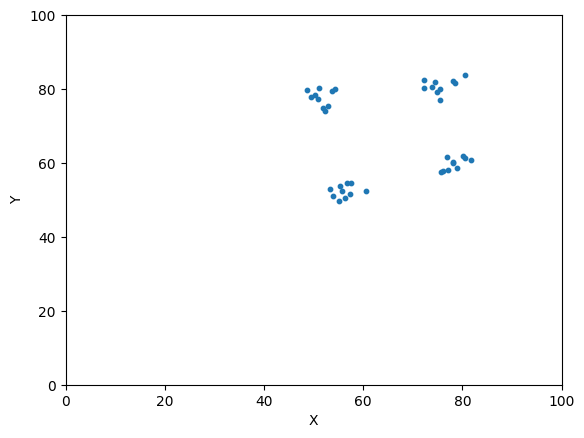

In [56]:
data = generate_clustered_points(K=num_clusters, points_per_cluster=num_clients // num_clusters, sigma=5.0, seed=45)
final_tour = []

plt.clf()
plt.scatter(data[:, 0], data[:, 1], s=10)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel("X")
plt.ylabel("Y")
h = 0.1
xx, yy = np.meshgrid(np.arange(0, 100, h), np.arange(0, 100, h))
plt.show()

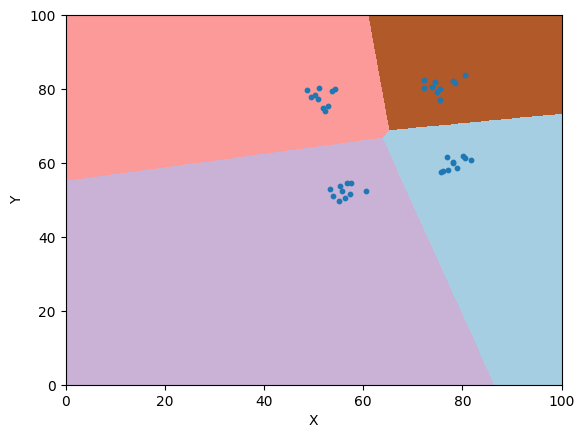

In [57]:
data = generate_clustered_points(K=num_clusters, points_per_cluster=num_clients // num_clusters, sigma=5.0, seed=45)
final_tour = []

plt.clf()
plt.scatter(data[:, 0], data[:, 1], s=10)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel("X")
plt.ylabel("Y")
h = 0.1
xx, yy = np.meshgrid(np.arange(0, 100, h), np.arange(0, 100, h))
kmeans = KMeans(init="k-means++", n_clusters=num_clusters, n_init="auto").fit(data)
labels = kmeans.labels_
clusters = [data[labels == k] for k in range(num_clusters)]
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(0, 100, 0, 100),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)
plt.show()

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 13460.86609         44.56   100.00%    48.90%     0:00:00     0:00:02

Solving cluster with 10 points...


     0.10000         22.34     1.20%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best distance: 22.339628241834106
Solving cluster with 10 points...


     0.10000         13.64     1.20%     0.60%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         31.96   100.00%    48.80%     0:00:00     0:00:02

Best distance: 13.63530886645869
Solving cluster with 10 points...


     0.10000         17.26     3.40%     1.70%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 15348.38569         34.71   100.00%    48.90%     0:00:00     0:00:02

Best distance: 17.25868172381495
Solving cluster with 10 points...


     0.10000         14.71     0.40%     0.20%     0:00:02     0:00:00

Best distance: 14.713928657158888


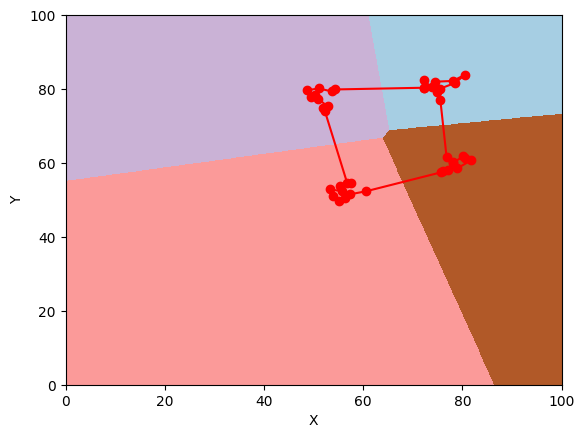

In [58]:
data = generate_clustered_points(K=num_clusters, points_per_cluster=num_clients // num_clusters, sigma=5.0, seed=45)
final_tour = []

plt.clf()
plt.scatter(data[:, 0], data[:, 1], s=10)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel("X")
plt.ylabel("Y")
h = 0.1
xx, yy = np.meshgrid(np.arange(0, 100, h), np.arange(0, 100, h))
kmeans = KMeans(init="k-means++", n_clusters=num_clusters, n_init="auto").fit(data)
labels = kmeans.labels_
clusters = [data[labels == k] for k in range(num_clusters)]
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(0, 100, 0, 100),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

boundaries = [
    boundary_points(clusters[i])
    for i in range(len(clusters))
]

cluster_dist = np.full((len(clusters), len(clusters)), np.inf)
bridge_points = {}

for i in range(len(clusters)):
    for j in range(len(clusters)):
        if i == j:
            continue

        D = spatial.distance_matrix(boundaries[i], boundaries[j])
        idx = np.unravel_index(np.argmin(D), D.shape)

        cluster_dist[i, j] = D[idx]
        bridge_points[(i, j)] = (boundaries[i][idx[0]],
                                 boundaries[j][idx[1]])

cluster_tour = greedy_cluster_tour(cluster_dist)

if len(cluster_tour) > 1:

    entries = {}
    exits = {}

    for idx, c in enumerate(cluster_tour):
        prev_c = cluster_tour[idx - 1]
        next_c = cluster_tour[(idx + 1) % len(cluster_tour)]

        entry = bridge_points[(prev_c, c)][1]
        exit = bridge_points[(c, next_c)][0]

        entries[c] = entry
        exits[c] = exit

    for c in cluster_tour:
        path = solve_cluster(clusters[c], entries[c], exits[c], method="SA")
        final_tour = np.append(final_tour, np.where(labels == c)[0][path])
final_tour = np.concatenate([final_tour, [final_tour[0]]]).astype(int)
tour_points = data[final_tour]
plt.plot(tour_points[:, 0], tour_points[:, 1], 'o-r')
plt.show()

In [ ]:
rows = []

for clustering, methods in final_tour_distances.items():
    for heuristic, distances in methods.items():
        for i, d in enumerate(distances):
            iteration = i+1
            Z1 = d - final_tour_distances["None"]["ACA"][i]
            if heuristic == "NN":
                Z2 = d - final_tour_distances["None"]["NN"][i]
            elif heuristic == "SA":
                Z2 = d - final_tour_distances["None"]["SA"][i]
            elif heuristic == "ACA":
                Z2 = 0
            rows.append({
                "Iteracja": iteration,
                "Marszrutyzacja": heuristic,
                "Klasteryzacja": clustering,
                "Długość trasy": d,
                "Z1": Z1,
                "Z2": Z2
            })

df_distance = pd.DataFrame(rows)

print(df_distance)
df_distance.to_excel("tour_length_summary.xlsx")

      Iteracja Marszrutyzacja  Klasteryzacja  Długość trasy         Z1  \
0            1             NN           None     267.816216  20.287962   
1            2             NN           None     330.213164  22.312682   
2            3             NN           None     305.447627  74.113012   
3            4             NN           None     230.143119  19.532926   
4            5             NN           None     254.088822  24.938811   
...        ...            ...            ...            ...        ...   
3348       475             SA  agglomerative     273.756919   8.430481   
3349       476             SA  agglomerative     263.411914   3.435391   
3350       477             SA  agglomerative     277.439086   3.751092   
3351       478             SA  agglomerative     208.639650   3.764895   
3352       479             SA  agglomerative     262.910439   9.734958   

             Z2  
0      0.000000  
1      0.000000  
2      0.000000  
3      0.000000  
4      0.000000  
...

In [ ]:
summary_distance = (
    df_distance
    .groupby(["Marszrutyzacja", "Klasteryzacja"])
    .agg(
        Błąd_względny=("Długość trasy", lambda x: stats.t.ppf(0.975, len(x)-1) * np.std(x, ddof=1) / np.sqrt(len(x)) / np.mean(x)),
        Dolny_przedział_ufności_dla_wartości_oczekiwanej=("Długość trasy", lambda x: np.mean(x) - stats.t.ppf(0.975, len(x)-1) * np.std(x, ddof=1) / np.sqrt(len(x))),
        Ocena_punktowa_wartości_oczekiwanej=("Długość trasy", "mean"),
        Górny_przedział_ufności_dla_wartości_oczekiwanej=("Długość trasy", lambda x: np.mean(x) + stats.t.ppf(0.975, len(x)-1) * np.std(x, ddof=1) / np.sqrt(len(x))),
        Odchylenie_standardowe_długości_trasy=("Długość trasy", "std"),
        Dolny_przedział_ufności_dla_Z1=("Z1", lambda x: np.mean(x) - stats.t.ppf(0.975, len(x)-1) * np.std(x, ddof=1) / np.sqrt(len(x))),
        Oszacowanie_punktowe_wartości_oczekiwanej_Z1=("Z1", "mean"),
        Górny_przedział_ufności_dla_Z1=("Z1", lambda x: np.mean(x) + stats.t.ppf(0.975, len(x)-1) * np.std(x, ddof=1) / np.sqrt(len(x))),
        Dolny_przedział_ufności_dla_Z2=("Z2", lambda x: np.mean(x) - stats.t.ppf(0.975, len(x)-1) * np.std(x, ddof=1) / np.sqrt(len(x))),
        Oszacowanie_punktowe_wartości_oczekiwanej_Z2=("Z2", "mean"),
        Górny_przedział_ufności_dla_Z2=("Z2", lambda x: np.mean(x) + stats.t.ppf(0.975, len(x)-1) * np.std(x, ddof=1) / np.sqrt(len(x))),
        Liczba_replikacji=("Długość trasy", "count")
    )
    .reset_index()
)
print(summary_distance)
summary_distance.to_excel("tour_length_stats.xlsx")

  Marszrutyzacja  Klasteryzacja  Błąd_względny  \
0            ACA           None       0.016080   
1             NN           None       0.015151   
2             NN  agglomerative       0.014909   
3             NN         kmeans       0.014788   
4             SA           None       0.019985   
5             SA  agglomerative       0.015843   
6             SA         kmeans       0.015679   

   Dolny_przedział_ufności_dla_wartości_oczekiwanej  \
0                                        241.093911   
1                                        263.552020   
2                                        267.207212   
3                                        266.729370   
4                                        267.653742   
5                                        245.913694   
6                                        246.549877   

   Ocena_punktowa_wartości_oczekiwanej  \
0                           245.034006   
1                           267.606529   
2                           271.

In [12]:
rows = []

for clustering, methods in solution_times.items():
    for heuristic, times in methods.items():
        for i, t in enumerate(times):
            iteration = i+1
            rows.append({
                "Iteracja": iteration,
                "Marszrutyzacja": heuristic,
                "Klasteryzacja": clustering,
                "Czas obliczeń": t,
            })

df_times = pd.DataFrame(rows)

print(df_times)
df_times.to_excel("time_summary.xlsx")

      Iteracja Marszrutyzacja  Klasteryzacja  Czas obliczeń
0            1             NN           None       0.002002
1            2             NN           None       0.001000
2            3             NN           None       0.001000
3            4             NN           None       0.001000
4            5             NN           None       0.001000
...        ...            ...            ...            ...
3348       475             SA  agglomerative       6.935547
3349       476             SA  agglomerative       7.000354
3350       477             SA  agglomerative       6.970268
3351       478             SA  agglomerative       7.051325
3352       479             SA  agglomerative       6.993273

[3353 rows x 4 columns]


In [70]:
summary_time = (
    df_times
    .groupby(["Marszrutyzacja", "Klasteryzacja"])
    .agg(
        Błąd_względny = ("Czas obliczeń", lambda x: stats.t.ppf(0.975, len(x)-1) * np.std(x, ddof=1) / np.sqrt(len(x)) / np.mean(x)),
        Dolny_przedział_ufności_dla_wartości_oczekiwanej=("Czas obliczeń", lambda x: np.mean(x) - stats.t.ppf(0.975, len(x)-1) * np.std(x, ddof=1) / np.sqrt(len(x))),
        Ocena_punktowa_wartości_oczekiwanej=("Czas obliczeń", "mean"),
        Górny_przedział_ufności_dla_wartości_oczekiwanej=("Czas obliczeń", lambda x: np.mean(x) + stats.t.ppf(0.975, len(x)-1) * np.std(x, ddof=1) / np.sqrt(len(x))),
        Odchylenie_standardowe_czasu_obliczeń=("Czas obliczeń", "std"),
        Liczba_replikacji=("Czas obliczeń", "count")
    )
    .reset_index()
)
print(summary_time)
summary_time.to_excel("time_stats.xlsx")

  Marszrutyzacja  Klasteryzacja  Błąd_względny  \
0            ACA           None       0.001023   
1             NN           None       0.076660   
2             NN  agglomerative       0.071577   
3             NN         kmeans       0.049566   
4             SA           None       0.002105   
5             SA  agglomerative       0.002952   
6             SA         kmeans       0.003158   

   Dolny_przedział_ufności_dla_wartości_oczekiwanej  \
0                                         84.774989   
1                                          0.001452   
2                                          0.001685   
3                                          0.001744   
4                                          2.707346   
5                                          6.955412   
6                                          6.917728   

   Ocena_punktowa_wartości_oczekiwanej  \
0                            84.861809   
1                             0.001572   
2                             0.

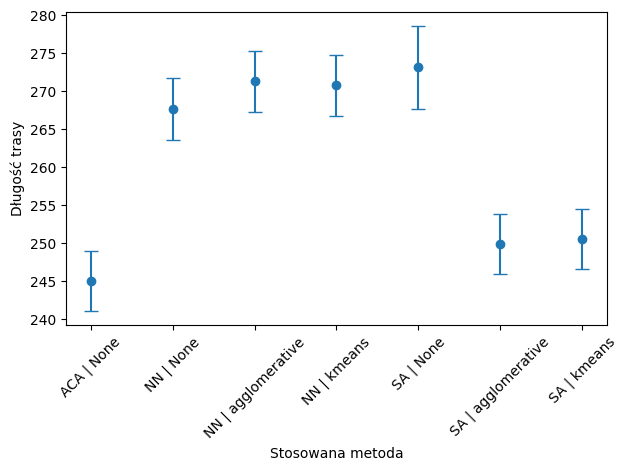

In [83]:
labels = (
    summary_distance["Marszrutyzacja"]
    + " | "
    + summary_distance["Klasteryzacja"]
)
mean = summary_distance["Ocena_punktowa_wartości_oczekiwanej"]
lower = summary_distance["Dolny_przedział_ufności_dla_wartości_oczekiwanej"]
upper = summary_distance["Górny_przedział_ufności_dla_wartości_oczekiwanej"]

x = np.arange(len(labels))

yerr = [mean - lower, upper - mean]

plt.errorbar(x, mean, yerr=yerr, fmt='o', capsize=5)
plt.xticks(x, labels, rotation=45)
plt.ylabel("Długość trasy")
plt.xlabel("Stosowana metoda")
plt.tight_layout()
plt.show()

C:\Users\sasha\AppData\Local\Temp\ipykernel_18140\2018059183.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


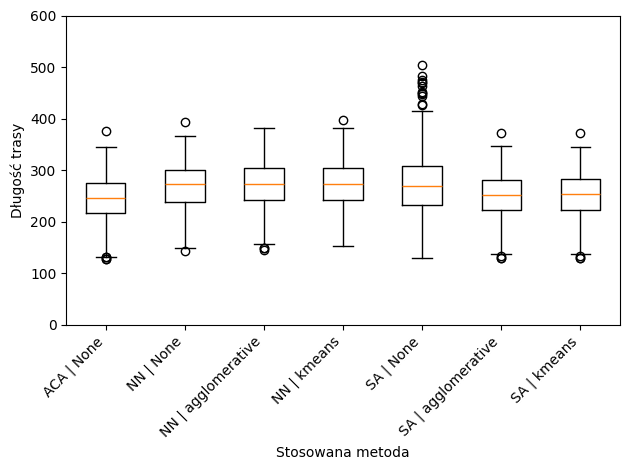

In [82]:
groups = []
labels = []

for (marsz, klas), g in df_distance.groupby(["Marszrutyzacja", "Klasteryzacja"]):
    groups.append(g["Długość trasy"].values)
    labels.append(f"{marsz} | {klas}")

plt.boxplot(
    groups,
    labels=labels,
    showfliers=True,     # outliery
    whis=1.5             # klasyczna definicja wąsów
)

plt.ylabel("Długość trasy")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Stosowana metoda")
plt.ylim(0, 600)
plt.tight_layout()
plt.show()